# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
import imageio
imageio.plugins.ffmpeg.download()

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


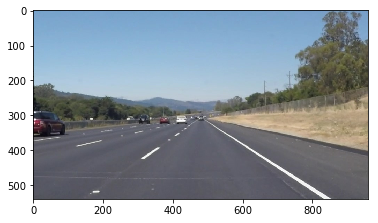

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [269]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def getSlope(x1, y1, x2, y2):
    return ((y2-y1)/(x2-x1))

def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
     
    selectedLines = np.copy(lines)
    #print (lines.shape)
    #print (lines)
    
    
    
    for fstLine, sndLine in zip(lines, lines[1:]):
        #print (type(fstLine))
        #print (str(fstLine) + ", " + str(sndLine))
        for x1,y1,x2,y2 in fstLine:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #selectedLines = np.concatenate(selectedLines, fstLine)
            slope = getSlope(x1, y1, x2, y2)            
            for x3,y3,x4,y4 in sndLine:                             

                errorSlope = 0.02
                
                auxSlope = getSlope(x1, y1, x3, y3)                
                if (auxSlope < slope + errorSlope and auxSlope > slope - errorSlope):
                    #cv2.line(img, (x1, y1), (x3, y3), color, thickness)
                    auxLine = np.array([[x1, y1, x3, y3]], ndmin=3)
                    selectedLines = np.append(selectedLines,auxLine, axis=0)
                auxSlope = getSlope(x1, y1, x4, y4)                
                if (auxSlope < slope + errorSlope and auxSlope > slope - errorSlope):
                    #cv2.line(img, (x1, y1), (x4, y4), color, thickness)
                    auxLine = np.array([[x1, y1, x4, y4]], ndmin=3)
                    selectedLines = np.append(selectedLines,auxLine, axis=0)
                auxSlope = getSlope(x2, y2, x3, y3)                
                if (auxSlope < slope + errorSlope and auxSlope > slope - errorSlope):
                    #cv2.line(img, (x2, y2), (x3, y3), color, thickness)
                    auxLine = np.array([[x2, y2, x3, y3]], ndmin=3)
                    selectedLines = np.append(selectedLines,auxLine, axis=0)
                auxSlope = getSlope(x2, y2, x4, y4)                
                if (auxSlope < slope + errorSlope and auxSlope > slope - errorSlope):
                    #cv2.line(img, (x2, y2), (x4, y4), color, thickness)
                    auxLine = np.array([[x2, y2, x4, y4]], ndmin=3)
                    selectedLines = np.append(selectedLines,auxLine, axis=0)
                    
    for line in selectedLines:      
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
     
    #print (lines.shape)
    #print (str(type(lines)) + " hahaha")
    #auxLine = np.array([[1, 2, 3, 4]], ndmin=3)
    #lines = np.append(lines,auxLine, axis=0)
    #print (np.append(lines, np.atleast_3d(auxLine), axis=0).shape)
    #print (auxLine.shape)
    #print (auxLine)
    
    #print (selectedLines.shape)
    #print (selectedLines)
    
    #print (selectedLines)
    #Draw Last line
    #for x1,y1,x2,y2 in lines[len(lines)-1]:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #selectedLines.append([x1,y1,x2,y2])
    
    #Find y_max of left and right line lanes
    xCenter = img.shape[1]/2
    leftYMax = rightYMax = 0
    leftIMax = rightIMax = leftJMax = rightJMax = 0
    leftLines = rightLines = np.empty([0, 1, 4], dtype=np.uint32)
    j = k = 0
    for i in range(len(selectedLines)): 
        auxLine = np.array(selectedLines[i], ndmin=3)
        for x1,y1,x2,y2 in selectedLines[i]:
            #print(str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2))
            if x1 < xCenter:
                leftLines = np.append(leftLines, auxLine, axis=0)
                if (y1 > leftYMax):
                    leftYMax = y1
                    leftIMax = j
                    leftJMax = 0                    
                if (y2 > leftYMax):
                    leftYMax = y2
                    leftIMax = j
                    leftJMax = 1
                j = j + 1
            else:
                rightLines = np.append(rightLines, auxLine, axis=0)
                if (y1 > rightYMax):
                    rightYMax = y1
                    rightIMax = k
                    rightJMax = 0
                if (y2 > rightYMax):
                    rightYMax = y2
                    rightIMax = k
                    rightJMax = 1
                k = k + 1
    
    print("leftYMax = " + str(leftYMax) + " leftIMax = " + str(leftIMax) + " leftJMax = " + str(leftJMax))
    print("rightYMax = " + str(rightYMax) + " rightIMax = " + str(rightIMax) + " rightJMax = " + str(rightJMax))                
    print("XCenter: " + str(xCenter))
    #print(leftLines)
    #print(rightLines)
    
    leftSlopes = rightSlopes = np.empty([0], dtype=np.float32)
    
    for line in leftLines:    
        for x1,y1,x2,y2 in line:
            #print(str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2) + " " + str(color) + " " + str(thickness))
            leftSlopes = np.append(leftSlopes, getSlope(x1, y1, x2, y2))
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    for line in rightLines:    
        for x1,y1,x2,y2 in line:
            rightSlopes = np.append(rightSlopes, getSlope(x1, y1, x2, y2))
            cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], thickness)
            
    print(leftSlopes)
    print(rightSlopes)
    leftSlope = np.median(leftSlopes)
    rightSlope = np.median(rightSlopes)
    print(leftSlope)
    print(rightSlope)
    
    #Trace lines with slopes and YMax and XMax
    # y = mx + b
    
    
    
    
    #for line in selectedLines:    
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                       
                       
    #for line in selectedLines:      
        #print (line)
        #for x1,y1,x2,y2 in line:
    #for line in lines:              
        #for x1,y1,x2,y2 in line:
            #if (x1 < img.shape[0]/2 and x2 < img.shape[1]/2) or (x1 > img.shape[0]/2 and x2 > img.shape[1]/2):
            #    cv2.line(img, (x1, y1), (math.floor((x1+x2)/2), math.floor((y1+y2)/2)), color, thickness)
            #else:
            #    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #cv2.line(img, (x1, y1), (math.floor((x1+x2)/2), math.floor((y1+y2)/2)), color, thickness)
            #cv2.line(img, (math.floor((x1+x2)/2), math.floor((y1+y2)/2)), (math.floor(x2+(x2-x1)/(y2-y1)), math.floor(y2+(y2-y1)/(x2-x1))), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

leftYMax = 522 leftIMax = 5 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
[-0.70454545 -0.67391304 -0.73333333 -0.7037037  -0.73076923 -0.07692308
 -0.66666667 -0.73913043 -0.66666667 -0.70833333 -0.70454545 -0.72649573
 -0.72222222 -0.72413793 -0.71929825 -0.74485597 -0.74349442 -0.68292683]
[ 0.66060606  0.6196319   0.62151394  0.66666667  0.66037736  0.62162162
  0.62096774  0.6625      0.68181818  0.66776316  0.61842105  0.6217765
  0.62244898  0.66197183  0.65306122  0.66225166  0.65891473]
-0.713815789474
0.658914728682


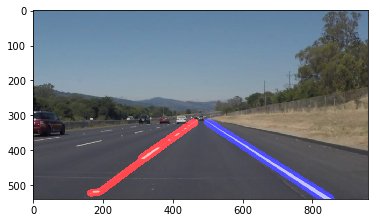

In [266]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def findLaneLines(img):
    clonedImage = np.copy(img) #Copy the image
    grayImage = grayscale(img) #Apply grayscale
    blurred_image = gaussian_blur(grayImage, 3) #Apply gaussian blur
    edges = canny(blurred_image, 70, 180) #Apply canny function
    imshape = edges.shape
    vertices = np.array([[(60,imshape[0]),(imshape[1]/2 - 30, imshape[0]/2 + 50), (imshape[1]/2 + 30, imshape[0]/2 + 50), (imshape[1]-60,imshape[0])]], dtype=np.int32) #Declare vertices 
    selectedEdges = region_of_interest(edges, vertices)
    lines = hough_lines(selectedEdges, 1, np.pi/720, 15, 20, 10) #Apply Hough Transform
    #lines = hough_lines(selectedEdges, 1, np.pi/720, 15, 200, 150) #Apply Hough Transform - Gambiarra
    #image = draw_lines(clonedImage, lines, [255, 0, 0], 2)
    image = weighted_img(lines, clonedImage, α=0.8, β=1., λ=0.)        
    return image


#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

resultImage = findLaneLines(image)
#leftIMax está errado

#plotting
plt.imshow(resultImage, cmap='gray')
#plt.imshow(image, cmap='gray')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [66]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = findLaneLines(img)    
    return result

Let's try the one with the solid white lane on the right first ...

In [244]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
507 320 866 537
(1, 4)
(1, 1, 4)
505 321 848 539
(1, 4)
(1, 1, 4)
590 369 870 539
(1, 4)
(1, 1, 4)
187 513 302 430
(1, 4)
(1, 1, 4)
502 320 565 360
(1, 4)
(1, 1, 4)
203 514 311 432
(1, 4)
(1, 1, 4)
786 499 848 538
(1, 4)
(1, 1, 4)
188 512 299 431
(1, 4)
(1, 1, 4)
200 515 232 491
(1, 4)
(1, 1, 4)
418 350 460 320
(1, 4)
(1, 1, 4)
416 348 454 321
(1, 4)
(1, 1, 4)
704 448 828 527
(1, 4)
(1, 1, 4)
574 364 742 471
(1, 4)
(1, 1, 4)
419 349 457 320
(1, 4)
(1, 1, 4)
429 342 459 320
(1, 4)
(1, 1, 4)
278 458 310 433
(1, 4)
(1, 1, 4)
201 515 231 492
(1, 4)
(1, 1, 4)
265 466 307 434
(1, 4)
(1, 1, 4)
503 320 575 366
(1, 4)
(1, 1, 4)
508 321 584 367
(1, 4)
(1, 1, 4)
866 537 505 321
(1, 4)
(1, 1, 4)
200 515 418 350
(1, 4)
(1, 1, 4)
200 515 460 320
(1, 4)
(1, 1, 4)
232 491 418 350
(1, 4)
(1, 1, 4)
232 491 460 320
(1, 4)
(1, 1, 4)
704 448 574 364
(1, 4)
(1, 1, 4)
828 527 574 364
(1, 4)
(1, 1, 4)
828 527 742 471
(1, 4)
(1, 1, 4)
201 515 265 466
(1, 4)
(1, 1, 4)
201 51

  1%|          | 2/222 [00:00<00:11, 19.59it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
507 320 866 537
(1, 4)
(1, 1, 4)
505 321 848 539
(1, 4)
(1, 1, 4)
590 369 870 539
(1, 4)
(1, 1, 4)
187 513 302 430
(1, 4)
(1, 1, 4)
502 320 565 360
(1, 4)
(1, 1, 4)
203 514 311 432
(1, 4)
(1, 1, 4)
786 499 848 538
(1, 4)
(1, 1, 4)
188 512 299 431
(1, 4)
(1, 1, 4)
200 515 232 491
(1, 4)
(1, 1, 4)
418 350 460 320
(1, 4)
(1, 1, 4)
416 348 454 321
(1, 4)
(1, 1, 4)
704 448 828 527
(1, 4)
(1, 1, 4)
574 364 742 471
(1, 4)
(1, 1, 4)
419 349 457 320
(1, 4)
(1, 1, 4)
429 342 459 320
(1, 4)
(1, 1, 4)
278 458 310 433
(1, 4)
(1, 1, 4)
201 515 231 492
(1, 4)
(1, 1, 4)
265 466 307 434
(1, 4)
(1, 1, 4)
503 320 575 366
(1, 4)
(1, 1, 4)
508 321 584 367
(1, 4)
(1, 1, 4)
866 537 505 321
(1, 4)
(1, 1, 4)
200 515 418 350
(1, 4)
(1, 1, 4)
200 515 460 320
(1, 4)
(1, 1, 4)
232 491 418 350
(1, 4)
(1, 1, 4)
232 491 460 320
(1, 4)
(1, 1, 4)
704 448 574 364
(1, 4)
(1, 1, 4)
828 527 574 364
(1, 4)
(1, 1, 4)
828 527 742 471
(1, 4)
(1, 1, 4)
201 515 265 466
(1, 4)
(1, 1, 4)
201 51

  2%|▏         | 5/222 [00:00<00:10, 21.17it/s]


149 538 369 381 [255, 0, 0] 20
149 538 391 366 [255, 0, 0] 20
210 494 369 381 [255, 0, 0] 20
210 494 391 366 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
503 320 849 538
(1, 4)
(1, 1, 4)
507 320 870 538
(1, 4)
(1, 1, 4)
365 389 389 372
(1, 4)
(1, 1, 4)
360 387 383 371
(1, 4)
(1, 1, 4)
360 388 386 370
(1, 4)
(1, 1, 4)
406 358 427 343
(1, 4)
(1, 1, 4)
728 463 845 537
(1, 4)
(1, 1, 4)
440 335 461 320
(1, 4)
(1, 1, 4)
404 358 426 342
(1, 4)
(1, 1, 4)
367 389 388 373
(1, 4)
(1, 1, 4)
705 448 847 538
(1, 4)
(1, 1, 4)
502 320 622 396
(1, 4)
(1, 1, 4)
799 495 871 538
(1, 4)
(1, 1, 4)
508 320 556 349
(1, 4)
(1, 1, 4)
404 357 425 342
(1, 4)
(1, 1, 4)
438 335 458 321
(1, 4)
(1, 1, 4)
407 358 427 344
(1, 4)
(1, 1, 4)
616 385 736 457
(1, 4)
(1, 1, 4)
369 388 389 373
(1, 4)
(1, 1, 4)
849 538 507 320
(1, 4)
(1, 1, 4)
705 448 502 320
(1, 4)
(1, 1, 4)
705 448 622 396
(1, 4)
(1, 1, 4)
847 538 502 320
(1, 4)
(1, 1, 4)
847 538 622 396
(1, 4)
(1, 1, 4)
799 495 508 320
(1, 4)
(1, 1, 4)
799 495 556 3

  4%|▎         | 8/222 [00:00<00:09, 22.83it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
503 320 848 538
(1, 4)
(1, 1, 4)
508 320 870 538
(1, 4)
(1, 1, 4)
551 347 716 446
(1, 4)
(1, 1, 4)
507 323 705 448
(1, 4)
(1, 1, 4)
351 393 379 374
(1, 4)
(1, 1, 4)
358 395 384 376
(1, 4)
(1, 1, 4)
357 395 384 375
(1, 4)
(1, 1, 4)
631 400 680 431
(1, 4)
(1, 1, 4)
764 475 869 538
(1, 4)
(1, 1, 4)
351 395 380 374
(1, 4)
(1, 1, 4)
783 498 847 538
(1, 4)
(1, 1, 4)
439 335 461 320
(1, 4)
(1, 1, 4)
400 359 422 343
(1, 4)
(1, 1, 4)
358 394 384 374
(1, 4)
(1, 1, 4)
438 335 458 321
(1, 4)
(1, 1, 4)
758 482 824 523
(1, 4)
(1, 1, 4)
707 448 745 472
(1, 4)
(1, 1, 4)
402 360 425 343
(1, 4)
(1, 1, 4)
504 320 563 357
(1, 4)
(1, 1, 4)
720 447 760 471
(1, 4)
(1, 1, 4)
848 538 508 320
(1, 4)
(1, 1, 4)
508 320 716 446
(1, 4)
(1, 1, 4)
870 538 551 347
(1, 4)
(1, 1, 4)
870 538 716 446
(1, 4)
(1, 1, 4)
716 446 507 323
(1, 4)
(1, 1, 4)
824 523 707 448
XCenter: 480.0
(9, 1, 4)
(17, 1, 4)
[[[351 393 379 374]]

 [[358 395 384 376]]

 [[357 395 384 375]]

 [[351 395 380 374]]

  5%|▍         | 11/222 [00:00<00:09, 22.97it/s]


(1, 1, 4)
560 357 779 490
(1, 4)
(1, 1, 4)
860 538 624 397
(1, 4)
(1, 1, 4)
860 538 779 490
(1, 4)
(1, 1, 4)
397 366 263 460
(1, 4)
(1, 1, 4)
456 325 263 460
(1, 4)
(1, 1, 4)
456 325 328 412
(1, 4)
(1, 1, 4)
275 460 406 363
(1, 4)
(1, 1, 4)
275 460 466 320
(1, 4)
(1, 1, 4)
340 412 406 363
(1, 4)
(1, 1, 4)
340 412 466 320
(1, 4)
(1, 1, 4)
501 320 837 525
(1, 4)
(1, 1, 4)
501 320 860 539
(1, 4)
(1, 1, 4)
538 342 837 525
(1, 4)
(1, 1, 4)
538 342 860 539
XCenter: 480.0
(17, 1, 4)
(17, 1, 4)
[[[398 364 461 320]]

 [[397 366 456 325]]

 [[263 460 328 412]]

 [[272 461 339 412]]

 [[275 460 340 412]]

 [[406 363 466 320]]

 [[281 447 332 410]]

 [[413 356 447 332]]

 [[425 350 465 321]]

 [[263 458 283 444]]

 [[397 366 263 460]]

 [[456 325 263 460]]

 [[456 325 328 412]]

 [[275 460 406 363]]

 [[275 460 466 320]]

 [[340 412 406 363]]

 [[340 412 466 320]]]
[[[496 320 838 538]]

 [[560 357 860 538]]

 [[624 397 779 490]]

 [[513 328 612 388]]

 [[497 320 579 372]]

 [[504 322 580 368]]

 

  6%|▋         | 14/222 [00:00<00:09, 22.94it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
624 396 856 539
(1, 4)
(1, 1, 4)
499 320 834 539
(1, 4)
(1, 1, 4)
416 353 461 320
(1, 4)
(1, 1, 4)
144 539 275 447
(1, 4)
(1, 1, 4)
164 538 285 447
(1, 4)
(1, 1, 4)
505 320 608 386
(1, 4)
(1, 1, 4)
165 538 285 448
(1, 4)
(1, 1, 4)
183 525 285 449
(1, 4)
(1, 1, 4)
625 403 794 514
(1, 4)
(1, 1, 4)
414 350 458 320
(1, 4)
(1, 1, 4)
665 422 854 538
(1, 4)
(1, 1, 4)
249 464 274 447
(1, 4)
(1, 1, 4)
806 520 833 538
(1, 4)
(1, 1, 4)
418 350 444 331
(1, 4)
(1, 1, 4)
555 351 621 394
(1, 4)
(1, 1, 4)
200 500 257 460
(1, 4)
(1, 1, 4)
146 538 186 510
(1, 4)
(1, 1, 4)
417 353 445 333
(1, 4)
(1, 1, 4)
608 385 688 435
(1, 4)
(1, 1, 4)
504 320 538 342
(1, 4)
(1, 1, 4)
624 396 499 320
(1, 4)
(1, 1, 4)
856 539 499 320
(1, 4)
(1, 1, 4)
165 538 285 449
(1, 4)
(1, 1, 4)
285 448 183 525
(1, 4)
(1, 1, 4)
200 500 146 538
(1, 4)
(1, 1, 4)
200 500 186 510
(1, 4)
(1, 1, 4)
257 460 146 538
(1, 4)
(1, 1, 4)
257 460 186 510
(1, 4)
(1, 1, 4)
146 538 417 353
(1, 4)
(1, 1, 4)
146 53

  8%|▊         | 17/222 [00:00<00:08, 23.75it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
505 320 835 538
(1, 4)
(1, 1, 4)
520 327 859 539
(1, 4)
(1, 1, 4)
535 339 837 539
(1, 4)
(1, 1, 4)
510 320 859 538
(1, 4)
(1, 1, 4)
158 538 221 491
(1, 4)
(1, 1, 4)
138 538 208 490
(1, 4)
(1, 1, 4)
139 537 205 491
(1, 4)
(1, 1, 4)
373 380 394 364
(1, 4)
(1, 1, 4)
369 378 389 364
(1, 4)
(1, 1, 4)
410 353 451 320
(1, 4)
(1, 1, 4)
181 520 218 493
(1, 4)
(1, 1, 4)
428 340 451 323
(1, 4)
(1, 1, 4)
680 428 816 513
(1, 4)
(1, 1, 4)
175 526 221 492
(1, 4)
(1, 1, 4)
138 539 158 525
(1, 4)
(1, 1, 4)
368 378 388 364
(1, 4)
(1, 1, 4)
512 321 581 364
(1, 4)
(1, 1, 4)
513 326 536 341
(1, 4)
(1, 1, 4)
835 538 520 327
(1, 4)
(1, 1, 4)
859 539 535 339
(1, 4)
(1, 1, 4)
837 539 510 320
(1, 4)
(1, 1, 4)
138 538 205 491
(1, 4)
(1, 1, 4)
208 490 139 537
(1, 4)
(1, 1, 4)
139 537 394 364
(1, 4)
(1, 1, 4)
369 378 451 320
(1, 4)
(1, 1, 4)
389 364 451 320
(1, 4)
(1, 1, 4)
181 520 428 340
(1, 4)
(1, 1, 4)
181 520 451 323
(1, 4)
(1, 1, 4)
218 493 428 340
(1, 4)
(1, 1, 4)
218 49

  9%|▉         | 20/222 [00:00<00:08, 24.48it/s]


214 486 236 485 [255, 0, 0] 20
434 338 455 324 [255, 0, 0] 20
436 335 457 320 [255, 0, 0] 20
334 412 438 337 [255, 0, 0] 20
334 412 463 320 [255, 0, 0] 20
370 386 438 337 [255, 0, 0] 20
370 386 463 320 [255, 0, 0] 20
326 410 214 486 [255, 0, 0] 20
363 385 214 486 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
505 321 853 539
(1, 4)
(1, 1, 4)
499 320 583 375
(1, 4)
(1, 1, 4)
504 320 853 538
(1, 4)
(1, 1, 4)
559 358 832 538
(1, 4)
(1, 1, 4)
310 423 356 392
(1, 4)
(1, 1, 4)
319 425 362 394
(1, 4)
(1, 1, 4)
502 321 674 435
(1, 4)
(1, 1, 4)
433 338 458 320
(1, 4)
(1, 1, 4)
433 339 457 323
(1, 4)
(1, 1, 4)
435 341 463 320
(1, 4)
(1, 1, 4)
310 422 355 392
(1, 4)
(1, 1, 4)
320 424 340 409
(1, 4)
(1, 1, 4)
727 470 832 539
(1, 4)
(1, 1, 4)
434 338 459 320
(1, 4)
(1, 1, 4)
338 412 360 396
(1, 4)
(1, 1, 4)
853 539 499 320
(1, 4)
(1, 1, 4)
853 539 583 375
(1, 4)
(1, 1, 4)
853 538 559 358
XCenter: 480.0
(9, 1, 4)

 10%|█         | 23/222 [00:00<00:08, 24.78it/s]


(9, 1, 4)
[[[310 423 356 392]]

 [[319 425 362 394]]

 [[433 338 458 320]]

 [[433 339 457 323]]

 [[435 341 463 320]]

 [[310 422 355 392]]

 [[320 424 340 409]]

 [[434 338 459 320]]

 [[338 412 360 396]]]
[[[505 321 853 539]]

 [[499 320 583 375]]

 [[504 320 853 538]]

 [[559 358 832 538]]

 [[502 321 674 435]]

 [[727 470 832 539]]

 [[853 539 499 320]]

 [[853 539 583 375]]

 [[853 538 559 358]]]
310 423 356 392 [255, 0, 0] 20
319 425 362 394 [255, 0, 0] 20
433 338 458 320 [255, 0, 0] 20
433 339 457 323 [255, 0, 0] 20
435 341 463 320 [255, 0, 0] 20
310 422 355 392 [255, 0, 0] 20
320 424 340 409 [255, 0, 0] 20
434 338 459 320 [255, 0, 0] 20
338 412 360 396 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
621 400 833 539
(1, 4)
(1, 1, 4)
560 355 854 538
(1, 4)
(1, 1, 4)
508 323 849 536
(1, 4)
(1, 1, 4)
500 321 793 512
(1, 4)
(1, 1, 4)
403 361 456 321
(1, 4)
(1, 1, 4)
499 320 656 422
(1, 4)
(1, 1, 4)
407 362 438 340
(1, 4)
(1, 1, 4)
408 361 448 332
(1, 4)
(1, 1, 4)
416 354 438 3

 12%|█▏        | 26/222 [00:01<00:08, 22.96it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
661 425 833 538
(1, 4)
(1, 1, 4)
531 336 764 481
(1, 4)
(1, 1, 4)
524 335 746 480
(1, 4)
(1, 1, 4)
182 525 289 447
(1, 4)
(1, 1, 4)
140 538 277 445
(1, 4)
(1, 1, 4)
502 320 669 429
(1, 4)
(1, 1, 4)
415 352 456 322
(1, 4)
(1, 1, 4)
163 539 246 477
(1, 4)
(1, 1, 4)
146 536 191 505
(1, 4)
(1, 1, 4)
775 488 854 539
(1, 4)
(1, 1, 4)
245 468 278 445
(1, 4)
(1, 1, 4)
418 352 462 320
(1, 4)
(1, 1, 4)
414 351 457 320
(1, 4)
(1, 1, 4)
162 538 211 502
(1, 4)
(1, 1, 4)
235 486 289 445
(1, 4)
(1, 1, 4)
508 320 530 334
(1, 4)
(1, 1, 4)
190 505 243 469
(1, 4)
(1, 1, 4)
626 394 803 507
(1, 4)
(1, 1, 4)
140 539 192 504
(1, 4)
(1, 1, 4)
508 321 540 341
(1, 4)
(1, 1, 4)
433 340 461 320
(1, 4)
(1, 1, 4)
815 513 854 538
(1, 4)
(1, 1, 4)
528 334 646 407
(1, 4)
(1, 1, 4)
762 480 800 505
(1, 4)
(1, 1, 4)
833 538 531 336
(1, 4)
(1, 1, 4)
764 481 524 335
(1, 4)
(1, 1, 4)
415 352 163 539
(1, 4)
(1, 1, 4)
415 352 246 477
(1, 4)
(1, 1, 4)
456 322 163 539
(1, 4)
(1, 1, 4)
456 32

 13%|█▎        | 29/222 [00:01<00:08, 23.47it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
542 344 856 538
(1, 4)
(1, 1, 4)
501 320 834 538
(1, 4)
(1, 1, 4)
531 340 834 539
(1, 4)
(1, 1, 4)
419 349 461 320
(1, 4)
(1, 1, 4)
369 389 390 373
(1, 4)
(1, 1, 4)
437 334 457 320
(1, 4)
(1, 1, 4)
405 359 428 345
(1, 4)
(1, 1, 4)
362 387 385 371
(1, 4)
(1, 1, 4)
362 388 386 371
(1, 4)
(1, 1, 4)
595 376 734 462
(1, 4)
(1, 1, 4)
506 320 537 339
(1, 4)
(1, 1, 4)
507 321 552 349
(1, 4)
(1, 1, 4)
441 335 462 320
(1, 4)
(1, 1, 4)
408 359 428 346
(1, 4)
(1, 1, 4)
532 337 555 351
(1, 4)
(1, 1, 4)
366 390 388 374
(1, 4)
(1, 1, 4)
141 538 169 525
(1, 4)
(1, 1, 4)
856 538 501 320
(1, 4)
(1, 1, 4)
501 320 531 340
(1, 4)
(1, 1, 4)
501 320 834 539
(1, 4)
(1, 1, 4)
834 538 531 340
(1, 4)
(1, 1, 4)
405 359 385 371
(1, 4)
(1, 1, 4)
428 345 385 371
(1, 4)
(1, 1, 4)
595 376 506 320
(1, 4)
(1, 1, 4)
595 376 537 339
(1, 4)
(1, 1, 4)
734 462 506 320
(1, 4)
(1, 1, 4)
734 462 537 339
(1, 4)
(1, 1, 4)
506 320 552 349
(1, 4)
(1, 1, 4)
537 339 507 321
(1, 4)
(1, 1, 4)
441 33

 14%|█▍        | 32/222 [00:01<00:07, 24.20it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
529 334 857 539
(1, 4)
(1, 1, 4)
503 320 836 538
(1, 4)
(1, 1, 4)
508 320 857 538
(1, 4)
(1, 1, 4)
711 457 836 539
(1, 4)
(1, 1, 4)
618 395 731 469
(1, 4)
(1, 1, 4)
341 401 373 379
(1, 4)
(1, 1, 4)
349 402 379 380
(1, 4)
(1, 1, 4)
436 336 456 321
(1, 4)
(1, 1, 4)
341 400 370 380
(1, 4)
(1, 1, 4)
346 403 379 379
(1, 4)
(1, 1, 4)
537 343 625 401
(1, 4)
(1, 1, 4)
438 336 461 320
(1, 4)
(1, 1, 4)
510 321 536 337
(1, 4)
(1, 1, 4)
435 335 455 320
(1, 4)
(1, 1, 4)
402 361 423 347
(1, 4)
(1, 1, 4)
504 320 536 341
(1, 4)
(1, 1, 4)
437 336 460 320
(1, 4)
(1, 1, 4)
253 459 273 459
(1, 4)
(1, 1, 4)
857 539 503 320
(1, 4)
(1, 1, 4)
836 538 508 320
(1, 4)
(1, 1, 4)
711 457 618 395
(1, 4)
(1, 1, 4)
836 539 618 395
(1, 4)
(1, 1, 4)
836 539 731 469
XCenter: 480.0
(10, 1, 4)
(13, 1, 4)
[[[341 401 373 379]]

 [[349 402 379 380]]

 [[436 336 456 321]]

 [[341 400 370 380]]

 [[346 403 379 379]]

 [[438 336 461 320]]

 [[435 335 455 320]]

 [[402 361 423 347]]

 [[437 3

 16%|█▌        | 35/222 [00:01<00:07, 24.02it/s]


552 350 856 539
(1, 4)
(1, 1, 4)
527 337 834 539
(1, 4)
(1, 1, 4)
282 453 342 407
(1, 4)
(1, 1, 4)
686 441 834 538
(1, 4)
(1, 1, 4)
267 453 320 417
(1, 4)
(1, 1, 4)
506 320 557 352
(1, 4)
(1, 1, 4)
399 362 433 336
(1, 4)
(1, 1, 4)
305 426 336 406
(1, 4)
(1, 1, 4)
502 320 542 346
(1, 4)
(1, 1, 4)
305 436 342 408
(1, 4)
(1, 1, 4)
424 347 454 323
(1, 4)
(1, 1, 4)
399 361 421 344
(1, 4)
(1, 1, 4)
412 356 452 322
(1, 4)
(1, 1, 4)
295 433 335 407
(1, 4)
(1, 1, 4)
501 320 558 357
(1, 4)
(1, 1, 4)
507 320 536 338
(1, 4)
(1, 1, 4)
559 359 653 421
(1, 4)
(1, 1, 4)
279 455 299 439
(1, 4)
(1, 1, 4)
412 353 435 336
(1, 4)
(1, 1, 4)
573 364 726 459
(1, 4)
(1, 1, 4)
534 338 563 356
(1, 4)
(1, 1, 4)
277 455 310 431
(1, 4)
(1, 1, 4)
856 539 527 337
(1, 4)
(1, 1, 4)
305 436 424 347
(1, 4)
(1, 1, 4)
305 436 454 323
(1, 4)
(1, 1, 4)
342 408 424 347
(1, 4)
(1, 1, 4)
342 408 454 323
(1, 4)
(1, 1, 4)
726 459 534 338
(1, 4)
(1, 1, 4)
726 459 563 356
XCenter: 480.0
(16, 1, 4)
(13, 1, 4)
[[[282 453 342 407]]



 17%|█▋        | 38/222 [00:01<00:07, 24.03it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
529 339 833 539
(1, 4)
(1, 1, 4)
580 369 853 538
(1, 4)
(1, 1, 4)
548 348 855 538
(1, 4)
(1, 1, 4)
235 475 318 418
(1, 4)
(1, 1, 4)
248 478 328 419
(1, 4)
(1, 1, 4)
573 369 733 474
(1, 4)
(1, 1, 4)
237 475 308 426
(1, 4)
(1, 1, 4)
502 320 540 345
(1, 4)
(1, 1, 4)
506 320 546 345
(1, 4)
(1, 1, 4)
501 320 584 375
(1, 4)
(1, 1, 4)
395 366 457 320
(1, 4)
(1, 1, 4)
398 367 454 325
(1, 4)
(1, 1, 4)
411 356 458 320
(1, 4)
(1, 1, 4)
751 484 833 538
(1, 4)
(1, 1, 4)
423 349 462 320
(1, 4)
(1, 1, 4)
505 320 562 356
(1, 4)
(1, 1, 4)
419 347 456 320
(1, 4)
(1, 1, 4)
272 461 327 420
(1, 4)
(1, 1, 4)
419 349 455 322
(1, 4)
(1, 1, 4)
833 539 580 369
(1, 4)
(1, 1, 4)
580 369 855 538
(1, 4)
(1, 1, 4)
853 538 548 348
(1, 4)
(1, 1, 4)
272 461 419 349
(1, 4)
(1, 1, 4)
272 461 455 322
XCenter: 480.0
(12, 1, 4)
(12, 1, 4)
[[[235 475 318 418]]

 [[248 478 328 419]]

 [[237 475 308 426]]

 [[395 366 457 320]]

 [[398 367 454 325]]

 [[411 356 458 320]]

 [[423 349 462 320]

 18%|█▊        | 41/222 [00:01<00:07, 23.23it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
546 344 855 539
(1, 4)
(1, 1, 4)
565 361 832 538
(1, 4)
(1, 1, 4)
657 414 854 538
(1, 4)
(1, 1, 4)
504 320 573 365
(1, 4)
(1, 1, 4)
370 387 391 370
(1, 4)
(1, 1, 4)
794 512 834 538
(1, 4)
(1, 1, 4)
365 383 385 369
(1, 4)
(1, 1, 4)
142 538 162 524
(1, 4)
(1, 1, 4)
508 320 565 355
(1, 4)
(1, 1, 4)
364 385 389 368
(1, 4)
(1, 1, 4)
584 369 736 465
(1, 4)
(1, 1, 4)
368 387 388 372
(1, 4)
(1, 1, 4)
438 334 459 320
(1, 4)
(1, 1, 4)
142 539 163 524
(1, 4)
(1, 1, 4)
407 357 427 343
(1, 4)
(1, 1, 4)
405 357 426 341
(1, 4)
(1, 1, 4)
418 348 455 320
(1, 4)
(1, 1, 4)
543 346 622 398
(1, 4)
(1, 1, 4)
363 385 386 369
(1, 4)
(1, 1, 4)
404 355 424 341
(1, 4)
(1, 1, 4)
505 320 545 346
(1, 4)
(1, 1, 4)
510 320 539 338
(1, 4)
(1, 1, 4)
404 357 425 341
(1, 4)
(1, 1, 4)
369 387 391 371
(1, 4)
(1, 1, 4)
543 342 586 369
(1, 4)
(1, 1, 4)
855 539 565 361
(1, 4)
(1, 1, 4)
657 414 504 320
(1, 4)
(1, 1, 4)
854 538 504 320
(1, 4)
(1, 1, 4)
854 538 573 365
(1, 4)
(1, 1, 4)
365 38

 20%|█▉        | 44/222 [00:01<00:08, 21.67it/s]


(1, 4)
(1, 1, 4)
585 369 840 530
(1, 4)
(1, 1, 4)
506 320 801 518
(1, 4)
(1, 1, 4)
505 320 758 490
(1, 4)
(1, 1, 4)
510 320 598 376
(1, 4)
(1, 1, 4)
330 407 365 382
(1, 4)
(1, 1, 4)
748 482 833 539
(1, 4)
(1, 1, 4)
338 409 372 383
(1, 4)
(1, 1, 4)
724 456 855 539
(1, 4)
(1, 1, 4)
435 335 455 320
(1, 4)
(1, 1, 4)
329 409 367 381
(1, 4)
(1, 1, 4)
436 335 456 321
(1, 4)
(1, 1, 4)
337 409 367 386
(1, 4)
(1, 1, 4)
579 365 749 472
(1, 4)
(1, 1, 4)
329 407 364 382
(1, 4)
(1, 1, 4)
348 402 370 385
(1, 4)
(1, 1, 4)
547 344 593 373
(1, 4)
(1, 1, 4)
585 369 506 320
(1, 4)
(1, 1, 4)
840 530 506 320
(1, 4)
(1, 1, 4)
506 320 758 490
(1, 4)
(1, 1, 4)
801 518 505 320
(1, 4)
(1, 1, 4)
758 490 510 320
XCenter: 480.0
(8, 1, 4)
(13, 1, 4)
[[[330 407 365 382]]

 [[338 409 372 383]]

 [[435 335 455 320]]

 [[329 409 367 381]]

 [[436 335 456 321]]

 [[337 409 367 386]]

 [[329 407 364 382]]

 [[348 402 370 385]]]
[[[585 369 840 530]]

 [[506 320 801 518]]

 [[505 320 758 490]]

 [[510 320 598 376]]

 [[748

 21%|██        | 47/222 [00:02<00:08, 20.78it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
505 320 833 539
(1, 4)
(1, 1, 4)
510 320 837 528
(1, 4)
(1, 1, 4)
584 373 828 536
(1, 4)
(1, 1, 4)
282 450 342 405
(1, 4)
(1, 1, 4)
270 448 336 402
(1, 4)
(1, 1, 4)
517 324 561 352
(1, 4)
(1, 1, 4)
509 320 757 478
(1, 4)
(1, 1, 4)
769 484 855 538
(1, 4)
(1, 1, 4)
281 450 342 404
(1, 4)
(1, 1, 4)
432 338 458 320
(1, 4)
(1, 1, 4)
270 449 337 402
(1, 4)
(1, 1, 4)
281 440 333 403
(1, 4)
(1, 1, 4)
428 338 450 322
(1, 4)
(1, 1, 4)
526 333 595 379
(1, 4)
(1, 1, 4)
430 338 453 321
(1, 4)
(1, 1, 4)
723 455 850 536
(1, 4)
(1, 1, 4)
506 321 536 341
(1, 4)
(1, 1, 4)
833 539 510 320
(1, 4)
(1, 1, 4)
517 324 757 478
(1, 4)
(1, 1, 4)
561 352 757 478
(1, 4)
(1, 1, 4)
509 320 769 484
(1, 4)
(1, 1, 4)
509 320 855 538
(1, 4)
(1, 1, 4)
281 450 432 338
(1, 4)
(1, 1, 4)
281 450 458 320
(1, 4)
(1, 1, 4)
432 338 270 449
(1, 4)
(1, 1, 4)
432 338 337 402
(1, 4)
(1, 1, 4)
458 320 270 449
(1, 4)
(1, 1, 4)
458 320 337 402
(1, 4)
(1, 1, 4)
281 440 428 338
(1, 4)
(1, 1, 4)
281 44

 23%|██▎       | 50/222 [00:02<00:08, 19.18it/s]


[[[184 507 283 439]]

 [[161 538 292 441]]

 [[140 538 259 456]]

 [[184 522 292 442]]

 [[430 338 455 320]]

 [[424 343 452 323]]

 [[140 539 189 505]]

 [[412 349 448 323]]

 [[160 538 190 516]]

 [[247 464 279 442]]

 [[401 358 453 320]]

 [[233 484 290 442]]

 [[184 522 430 338]]

 [[184 522 455 320]]

 [[292 442 430 338]]

 [[292 442 455 320]]

 [[140 539 412 349]]

 [[140 539 448 323]]

 [[189 505 412 349]]

 [[189 505 448 323]]

 [[401 358 233 484]]

 [[453 320 233 484]]

 [[453 320 290 442]]]
[[[504 320 831 538]]

 [[507 320 853 538]]

 [[639 411 820 532]]

 [[529 336 631 404]]

 [[508 320 632 398]]

 [[639 404 853 539]]

 [[503 320 527 336]]

 [[831 538 507 320]]

 [[631 404 508 320]]]
184 507 283 439 [255, 0, 0] 20
161 538 292 441 [255, 0, 0] 20
140 538 259 456 [255, 0, 0] 20
184 522 292 442 [255, 0, 0] 20
430 338 455 320 [255, 0, 0] 20
424 343 452 323 [255, 0, 0] 20
140 539 189 505 [255, 0, 0] 20
412 349 448 323 [255, 0, 0] 20
160 538 190 516 [255, 0, 0] 20
247 464 279 442 

 23%|██▎       | 52/222 [00:02<00:09, 18.75it/s]


158 539 232 483 [255, 0, 0] 20
138 537 218 482 [255, 0, 0] 20
137 538 219 482 [255, 0, 0] 20
367 379 389 364 [255, 0, 0] 20
366 378 388 364 [255, 0, 0] 20
407 354 427 341 [255, 0, 0] 20
157 538 232 482 [255, 0, 0] 20
410 351 442 329 [255, 0, 0] 20
406 353 426 339 [255, 0, 0] 20
184 520 232 484 [255, 0, 0] 20
153 528 199 496 [255, 0, 0] 20
138 537 219 482 [255, 0, 0] 20
218 482 137 538 [255, 0, 0] 20
137 538 367 379 [255, 0, 0] 20
137 538 389 364 [255, 0, 0] 20
219 482 367 379 [255, 0, 0] 20
219 482 389 364 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
507 320 853 538
(1, 4)
(1, 1, 4)
519 330 831 538
(1, 4)
(1, 1, 4)
670 423 853 539
(1, 4)
(1, 1, 4)
503 320 831 539
(1, 4)
(1, 1, 4)
136 537 169 515
(1, 4)
(1, 1, 4)
363 386 387 368
(1, 4)
(1, 1, 4)
156 538 185 517
(1, 4)
(1, 1, 4)
358 384 382 368
(1, 4)
(1, 1, 4)
364 386 387 370
(1, 4)
(1, 1, 4)
403 356 453 321
(1, 4)
(1, 1, 4)
135 539 170 515
(1, 4)
(1, 1, 4)
361 383 383 368
(1, 4)
(1, 1, 4)
156 539 185 518
(1, 4)
(1, 1, 4)
439 33

 24%|██▍       | 54/222 [00:02<00:08, 19.06it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
597 383 831 538
(1, 4)
(1, 1, 4)
507 320 853 539
(1, 4)
(1, 1, 4)
503 321 679 436
(1, 4)
(1, 1, 4)
348 391 376 372
(1, 4)
(1, 1, 4)
502 320 595 380
(1, 4)
(1, 1, 4)
353 393 380 374
(1, 4)
(1, 1, 4)
712 460 831 539
(1, 4)
(1, 1, 4)
508 320 853 538
(1, 4)
(1, 1, 4)
348 390 375 372
(1, 4)
(1, 1, 4)
437 334 458 320
(1, 4)
(1, 1, 4)
435 334 455 321
(1, 4)
(1, 1, 4)
438 334 459 320
(1, 4)
(1, 1, 4)
664 427 707 455
(1, 4)
(1, 1, 4)
358 391 380 375
(1, 4)
(1, 1, 4)
831 538 507 320
(1, 4)
(1, 1, 4)
853 539 503 321
(1, 4)
(1, 1, 4)
831 539 508 320
XCenter: 480.0
(7, 1, 4)
(10, 1, 4)
[[[348 391 376 372]]

 [[353 393 380 374]]

 [[348 390 375 372]]

 [[437 334 458 320]]

 [[435 334 455 321]]

 [[438 334 459 320]]

 [[358 391 380 375]]]
[[[597 383 831 538]]

 [[507 320 853 539]]

 [[503 321 679 436]]

 [[502 320 595 380]]

 [[712 460 831 539]]

 [[508 320 853 538]]

 [[664 427 707 455]]

 [[831 538 507 320]]

 [[853 539 503 321]]

 [[831 539 508 320]]]
348 391 3

 25%|██▌       | 56/222 [00:02<00:08, 18.70it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
504 320 852 538
(1, 4)
(1, 1, 4)
633 409 830 539
(1, 4)
(1, 1, 4)
499 320 809 524
(1, 4)
(1, 1, 4)
316 422 358 392
(1, 4)
(1, 1, 4)
307 421 353 390
(1, 4)
(1, 1, 4)
606 385 851 538
(1, 4)
(1, 1, 4)
327 406 351 390
(1, 4)
(1, 1, 4)
500 320 610 392
(1, 4)
(1, 1, 4)
306 421 352 390
(1, 4)
(1, 1, 4)
432 339 461 320
(1, 4)
(1, 1, 4)
431 337 455 320
(1, 4)
(1, 1, 4)
430 339 457 320
(1, 4)
(1, 1, 4)
433 339 462 320
(1, 4)
(1, 1, 4)
313 423 354 394
(1, 4)
(1, 1, 4)
170 515 196 511
(1, 4)
(1, 1, 4)
434 339 461 321
(1, 4)
(1, 1, 4)
633 409 499 320
(1, 4)
(1, 1, 4)
633 409 809 524
(1, 4)
(1, 1, 4)
830 539 499 320
XCenter: 480.0
(11, 1, 4)
(8, 1, 4)
[[[316 422 358 392]]

 [[307 421 353 390]]

 [[327 406 351 390]]

 [[306 421 352 390]]

 [[432 339 461 320]]

 [[431 337 455 320]]

 [[430 339 457 320]]

 [[433 339 462 320]]

 [[313 423 354 394]]

 [[170 515 196 511]]

 [[434 339 461 321]]]
[[[504 320 852 538]]

 [[633 409 830 539]]

 [[499 320 809 524]]

 [[606 38

 26%|██▌       | 58/222 [00:02<00:09, 16.41it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
608 393 827 538
(1, 4)
(1, 1, 4)
503 320 793 504
(1, 4)
(1, 1, 4)
498 320 619 399
(1, 4)
(1, 1, 4)
269 455 335 408
(1, 4)
(1, 1, 4)
260 452 328 406
(1, 4)
(1, 1, 4)
506 326 649 419
(1, 4)
(1, 1, 4)
723 459 849 539
(1, 4)
(1, 1, 4)
260 453 329 406
(1, 4)
(1, 1, 4)
395 361 462 320
(1, 4)
(1, 1, 4)
282 447 335 409
(1, 4)
(1, 1, 4)
423 347 463 320
(1, 4)
(1, 1, 4)
400 363 454 321
(1, 4)
(1, 1, 4)
511 326 539 344
(1, 4)
(1, 1, 4)
813 515 850 538
(1, 4)
(1, 1, 4)
419 345 443 329
(1, 4)
(1, 1, 4)
593 376 809 514
(1, 4)
(1, 1, 4)
422 347 445 331
(1, 4)
(1, 1, 4)
610 394 671 434
(1, 4)
(1, 1, 4)
396 360 430 337
(1, 4)
(1, 1, 4)
827 538 503 320
(1, 4)
(1, 1, 4)
793 504 498 320
(1, 4)
(1, 1, 4)
260 453 395 361
(1, 4)
(1, 1, 4)
329 406 395 361
(1, 4)
(1, 1, 4)
282 447 423 347
(1, 4)
(1, 1, 4)
282 447 463 320
(1, 4)
(1, 1, 4)
335 409 423 347
(1, 4)
(1, 1, 4)
463 320 400 363
(1, 4)
(1, 1, 4)
511 326 813 515
(1, 4)
(1, 1, 4)
511 326 850 538
(1, 4)
(1, 1, 4)
539 34

 27%|██▋       | 61/222 [00:02<00:09, 16.67it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
524 337 823 538
(1, 4)
(1, 1, 4)
510 325 844 538
(1, 4)
(1, 1, 4)
131 538 271 444
(1, 4)
(1, 1, 4)
151 538 281 447
(1, 4)
(1, 1, 4)
498 320 551 356
(1, 4)
(1, 1, 4)
567 365 824 538
(1, 4)
(1, 1, 4)
503 320 845 538
(1, 4)
(1, 1, 4)
414 352 451 326
(1, 4)
(1, 1, 4)
249 468 281 445
(1, 4)
(1, 1, 4)
411 351 457 320
(1, 4)
(1, 1, 4)
441 334 462 320
(1, 4)
(1, 1, 4)
146 529 192 498
(1, 4)
(1, 1, 4)
152 538 267 457
(1, 4)
(1, 1, 4)
412 352 456 321
(1, 4)
(1, 1, 4)
500 321 607 393
(1, 4)
(1, 1, 4)
442 334 463 320
(1, 4)
(1, 1, 4)
209 487 272 444
(1, 4)
(1, 1, 4)
734 479 819 536
(1, 4)
(1, 1, 4)
823 538 510 325
(1, 4)
(1, 1, 4)
498 320 824 538
(1, 4)
(1, 1, 4)
551 356 824 538
(1, 4)
(1, 1, 4)
824 538 503 320
(1, 4)
(1, 1, 4)
414 352 249 468
(1, 4)
(1, 1, 4)
414 352 281 445
(1, 4)
(1, 1, 4)
451 326 249 468
(1, 4)
(1, 1, 4)
451 326 281 445
(1, 4)
(1, 1, 4)
249 468 411 351
(1, 4)
(1, 1, 4)
249 468 457 320
(1, 4)
(1, 1, 4)
281 445 411 351
(1, 4)
(1, 1, 4)
281 44

 28%|██▊       | 63/222 [00:03<00:12, 13.13it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
497 320 816 533
(1, 4)
(1, 1, 4)
502 320 844 538
(1, 4)
(1, 1, 4)
509 325 843 538
(1, 4)
(1, 1, 4)
132 539 243 464
(1, 4)
(1, 1, 4)
151 539 252 467
(1, 4)
(1, 1, 4)
373 376 393 363
(1, 4)
(1, 1, 4)
732 478 823 538
(1, 4)
(1, 1, 4)
151 538 211 495
(1, 4)
(1, 1, 4)
440 335 462 320
(1, 4)
(1, 1, 4)
132 538 176 508
(1, 4)
(1, 1, 4)
408 355 450 324
(1, 4)
(1, 1, 4)
410 355 456 323
(1, 4)
(1, 1, 4)
218 480 240 465
(1, 4)
(1, 1, 4)
629 400 687 437
(1, 4)
(1, 1, 4)
166 515 215 482
(1, 4)
(1, 1, 4)
420 347 457 320
(1, 4)
(1, 1, 4)
152 538 252 466
(1, 4)
(1, 1, 4)
208 499 247 471
(1, 4)
(1, 1, 4)
617 399 696 452
(1, 4)
(1, 1, 4)
816 533 502 320
(1, 4)
(1, 1, 4)
502 320 843 538
(1, 4)
(1, 1, 4)
844 538 509 325
(1, 4)
(1, 1, 4)
151 539 393 363
(1, 4)
(1, 1, 4)
151 538 440 335
(1, 4)
(1, 1, 4)
151 538 462 320
(1, 4)
(1, 1, 4)
211 495 440 335
(1, 4)
(1, 1, 4)
211 495 462 320
(1, 4)
(1, 1, 4)
132 538 408 355
(1, 4)
(1, 1, 4)
132 538 450 324
(1, 4)
(1, 1, 4)
176 50

 29%|██▉       | 65/222 [00:03<00:11, 13.63it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
508 324 843 538
(1, 4)
(1, 1, 4)
497 320 782 511
(1, 4)
(1, 1, 4)
714 466 820 537
(1, 4)
(1, 1, 4)
435 335 457 320
(1, 4)
(1, 1, 4)
362 388 385 372
(1, 4)
(1, 1, 4)
357 386 380 371
(1, 4)
(1, 1, 4)
439 336 463 320
(1, 4)
(1, 1, 4)
517 331 668 427
(1, 4)
(1, 1, 4)
356 388 383 370
(1, 4)
(1, 1, 4)
402 359 459 321
(1, 4)
(1, 1, 4)
774 507 821 538
(1, 4)
(1, 1, 4)
403 359 424 345
(1, 4)
(1, 1, 4)
498 320 716 466
(1, 4)
(1, 1, 4)
400 359 421 344
(1, 4)
(1, 1, 4)
729 466 842 538
(1, 4)
(1, 1, 4)
365 387 386 373
(1, 4)
(1, 1, 4)
843 538 497 320
(1, 4)
(1, 1, 4)
497 320 714 466
(1, 4)
(1, 1, 4)
497 320 820 537
(1, 4)
(1, 1, 4)
782 511 714 466
(1, 4)
(1, 1, 4)
782 511 820 537
(1, 4)
(1, 1, 4)
356 388 459 321
XCenter: 480.0
(10, 1, 4)
(12, 1, 4)
[[[435 335 457 320]]

 [[362 388 385 372]]

 [[357 386 380 371]]

 [[439 336 463 320]]

 [[356 388 383 370]]

 [[402 359 459 321]]

 [[403 359 424 345]]

 [[400 359 421 344]]

 [[365 387 386 373]]

 [[356 388 459 321]

 30%|███       | 67/222 [00:03<00:11, 13.64it/s]

(1, 1, 4)
341 400 373 378
(1, 4)
(1, 1, 4)
432 335 455 320
(1, 4)
(1, 1, 4)
335 398 364 379
(1, 4)
(1, 1, 4)
629 408 699 455
(1, 4)
(1, 1, 4)
555 354 580 370
(1, 4)
(1, 1, 4)
624 398 707 451
(1, 4)
(1, 1, 4)
435 336 455 323
(1, 4)
(1, 1, 4)
530 340 643 416
(1, 4)
(1, 1, 4)
509 327 549 354
(1, 4)
(1, 1, 4)
845 538 500 320
(1, 4)
(1, 1, 4)
823 538 506 321
(1, 4)
(1, 1, 4)
343 400 459 320
(1, 4)
(1, 1, 4)
374 379 459 320
(1, 4)
(1, 1, 4)
452 321 368 377
(1, 4)
(1, 1, 4)
341 400 455 320
(1, 4)
(1, 1, 4)
373 378 455 320
(1, 4)
(1, 1, 4)
432 335 335 398
(1, 4)
(1, 1, 4)
432 335 364 379
(1, 4)
(1, 1, 4)
455 320 335 398
(1, 4)
(1, 1, 4)
455 320 364 379
(1, 4)
(1, 1, 4)
555 354 624 398
(1, 4)
(1, 1, 4)
555 354 707 451
(1, 4)
(1, 1, 4)
580 370 624 398
(1, 4)
(1, 1, 4)
580 370 707 451
(1, 4)
(1, 1, 4)
643 416 509 327
(1, 4)
(1, 1, 4)
643 416 549 354
XCenter: 480.0
(17, 1, 4)
(17, 1, 4)
[[[343 400 374 379]]

 [[433 336 459 320]]

 [[432 334 452 321]]

 [[336 399 368 377]]

 [[341 400 373 378]]

 [

 32%|███▏      | 70/222 [00:03<00:09, 15.49it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
509 323 846 538
(1, 4)
(1, 1, 4)
507 325 825 538
(1, 4)
(1, 1, 4)
332 408 365 384
(1, 4)
(1, 1, 4)
635 412 825 539
(1, 4)
(1, 1, 4)
322 408 361 382
(1, 4)
(1, 1, 4)
336 397 358 383
(1, 4)
(1, 1, 4)
328 409 365 383
(1, 4)
(1, 1, 4)
505 322 846 539
(1, 4)
(1, 1, 4)
406 354 453 322
(1, 4)
(1, 1, 4)
407 351 451 321
(1, 4)
(1, 1, 4)
408 354 459 320
(1, 4)
(1, 1, 4)
406 353 454 320
(1, 4)
(1, 1, 4)
322 407 360 382
(1, 4)
(1, 1, 4)
211 479 231 478
(1, 4)
(1, 1, 4)
632 403 742 473
(1, 4)
(1, 1, 4)
503 322 617 398
(1, 4)
(1, 1, 4)
407 354 458 320
(1, 4)
(1, 1, 4)
770 489 847 538
(1, 4)
(1, 1, 4)
846 538 507 325
(1, 4)
(1, 1, 4)
322 407 211 479
(1, 4)
(1, 1, 4)
360 382 211 479
(1, 4)
(1, 1, 4)
632 403 503 322
(1, 4)
(1, 1, 4)
742 473 503 322
XCenter: 480.0
(13, 1, 4)
(10, 1, 4)
[[[332 408 365 384]]

 [[322 408 361 382]]

 [[336 397 358 383]]

 [[328 409 365 383]]

 [[406 354 453 322]]

 [[407 351 451 321]]

 [[408 354 459 320]]

 [[406 353 454 320]]

 [[322 4

 32%|███▏      | 72/222 [00:03<00:11, 13.53it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
520 331 844 538
(1, 4)
(1, 1, 4)
500 320 731 476
(1, 4)
(1, 1, 4)
695 453 822 539
(1, 4)
(1, 1, 4)
229 468 311 414
(1, 4)
(1, 1, 4)
405 354 454 320
(1, 4)
(1, 1, 4)
419 347 458 320
(1, 4)
(1, 1, 4)
562 363 808 528
(1, 4)
(1, 1, 4)
240 470 322 413
(1, 4)
(1, 1, 4)
243 469 321 415
(1, 4)
(1, 1, 4)
513 326 732 466
(1, 4)
(1, 1, 4)
243 460 314 413
(1, 4)
(1, 1, 4)
688 439 843 538
(1, 4)
(1, 1, 4)
418 347 451 323
(1, 4)
(1, 1, 4)
415 346 453 320
(1, 4)
(1, 1, 4)
417 348 456 321
(1, 4)
(1, 1, 4)
511 328 573 370
(1, 4)
(1, 1, 4)
505 320 528 335
(1, 4)
(1, 1, 4)
844 538 500 320
(1, 4)
(1, 1, 4)
500 320 695 453
(1, 4)
(1, 1, 4)
500 320 822 539
(1, 4)
(1, 1, 4)
731 476 822 539
(1, 4)
(1, 1, 4)
229 468 405 354
(1, 4)
(1, 1, 4)
229 468 454 320
(1, 4)
(1, 1, 4)
311 414 454 320
(1, 4)
(1, 1, 4)
240 470 321 415
(1, 4)
(1, 1, 4)
322 413 243 469
XCenter: 480.0
(14, 1, 4)
(12, 1, 4)
[[[229 468 311 414]]

 [[405 354 454 320]]

 [[419 347 458 320]]

 [[240 470 322 413]

 33%|███▎      | 74/222 [00:03<00:10, 14.26it/s]

416 348 448 326 [255, 0, 0] 20
414 350 454 322 [255, 0, 0] 20
199 499 304 426 [255, 0, 0] 20
416 349 459 320 [255, 0, 0] 20
187 496 276 437 [255, 0, 0] 20
272 441 297 425 [255, 0, 0] 20
201 498 452 322 [255, 0, 0] 20
383 368 187 497 [255, 0, 0] 20
383 368 296 425 [255, 0, 0] 20
452 322 187 497 [255, 0, 0] 20
452 322 296 425 [255, 0, 0] 20
187 497 416 348 [255, 0, 0] 20
187 497 448 326 [255, 0, 0] 20
296 425 416 348 [255, 0, 0] 20
296 425 448 326 [255, 0, 0] 20
416 348 454 322 [255, 0, 0] 20
448 326 414 350 [255, 0, 0] 20
414 350 199 499 [255, 0, 0] 20
414 350 304 426 [255, 0, 0] 20
454 322 199 499 [255, 0, 0] 20
454 322 304 426 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
522 333 841 537
(1, 4)
(1, 1, 4)
500 321 820 539
(1, 4)
(1, 1, 4)
143 538 283 441
(1, 4)
(1, 1, 4)
499 320 820 538
(1, 4)
(1, 1, 4)
127 536 274 440
(1, 4)
(1, 1, 4)
421 342 455 320
(1, 4)
(1, 1, 4)
146 537 283 442
(1, 4)
(1, 1, 4)
533 341 842 538
(1, 4)
(1, 1, 4)
409 350 454 321
(1, 4)
(1, 1, 4)
169 508 253 453

 34%|███▍      | 76/222 [00:03<00:09, 14.78it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
499 320 820 539
(1, 4)
(1, 1, 4)
515 328 841 538
(1, 4)
(1, 1, 4)
123 538 245 459
(1, 4)
(1, 1, 4)
142 538 256 460
(1, 4)
(1, 1, 4)
664 432 820 538
(1, 4)
(1, 1, 4)
371 375 392 362
(1, 4)
(1, 1, 4)
212 491 255 461
(1, 4)
(1, 1, 4)
439 334 460 320
(1, 4)
(1, 1, 4)
518 334 699 457
(1, 4)
(1, 1, 4)
406 353 426 340
(1, 4)
(1, 1, 4)
523 334 671 430
(1, 4)
(1, 1, 4)
179 512 217 486
(1, 4)
(1, 1, 4)
169 507 242 460
(1, 4)
(1, 1, 4)
419 346 455 321
(1, 4)
(1, 1, 4)
123 539 176 504
(1, 4)
(1, 1, 4)
143 538 193 504
(1, 4)
(1, 1, 4)
504 320 528 336
(1, 4)
(1, 1, 4)
230 477 256 459
(1, 4)
(1, 1, 4)
438 334 459 320
(1, 4)
(1, 1, 4)
636 407 676 433
(1, 4)
(1, 1, 4)
820 539 515 328
(1, 4)
(1, 1, 4)
212 491 439 334
(1, 4)
(1, 1, 4)
212 491 460 320
(1, 4)
(1, 1, 4)
255 461 439 334
(1, 4)
(1, 1, 4)
255 461 460 320
(1, 4)
(1, 1, 4)
169 507 419 346
(1, 4)
(1, 1, 4)
169 507 455 321
(1, 4)
(1, 1, 4)
242 460 419 346
(1, 4)
(1, 1, 4)
242 460 455 321
(1, 4)
(1, 1, 4)
230 47

 35%|███▌      | 78/222 [00:04<00:10, 13.46it/s]


(0, 1, 4)
(1, 4)
(1, 1, 4)
521 332 839 539
(1, 4)
(1, 1, 4)
515 331 816 538
(1, 4)
(1, 1, 4)
601 385 778 500
(1, 4)
(1, 1, 4)
347 389 374 372
(1, 4)
(1, 1, 4)
512 325 600 383
(1, 4)
(1, 1, 4)
355 390 378 374
(1, 4)
(1, 1, 4)
351 392 378 373
(1, 4)
(1, 1, 4)
762 500 818 538
(1, 4)
(1, 1, 4)
500 320 548 353
(1, 4)
(1, 1, 4)
344 390 372 372
(1, 4)
(1, 1, 4)
397 359 420 344
(1, 4)
(1, 1, 4)
434 335 457 320
(1, 4)
(1, 1, 4)
432 335 453 321
(1, 4)
(1, 1, 4)
771 494 839 538
(1, 4)
(1, 1, 4)
669 438 751 494
(1, 4)
(1, 1, 4)
538 344 570 365
(1, 4)
(1, 1, 4)
839 539 515 331
(1, 4)
(1, 1, 4)
762 500 500 320
(1, 4)
(1, 1, 4)
762 500 548 353
(1, 4)
(1, 1, 4)
818 538 500 320
(1, 4)
(1, 1, 4)
818 538 548 353
(1, 4)
(1, 1, 4)
397 359 434 335
(1, 4)
(1, 1, 4)
397 359 457 320
(1, 4)
(1, 1, 4)
420 344 434 335
(1, 4)
(1, 1, 4)
420 344 457 320
XCenter: 480.0
(11, 1, 4)
(14, 1, 4)
[[[347 389 374 372]]

 [[355 390 378 374]]

 [[351 392 378 373]]

 [[344 390 372 372]]

 [[397 359 420 344]]

 [[434 335 457 32

 37%|███▋      | 82/222 [00:04<00:09, 14.92it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
535 342 835 539
(1, 4)
(1, 1, 4)
516 332 813 538
(1, 4)
(1, 1, 4)
521 332 835 538
(1, 4)
(1, 1, 4)
401 356 434 333
(1, 4)
(1, 1, 4)
313 418 341 398
(1, 4)
(1, 1, 4)
303 417 347 388
(1, 4)
(1, 1, 4)
399 355 451 321
(1, 4)
(1, 1, 4)
538 348 813 539
(1, 4)
(1, 1, 4)
307 415 352 387
(1, 4)
(1, 1, 4)
330 407 355 388
(1, 4)
(1, 1, 4)
403 356 458 320
(1, 4)
(1, 1, 4)
500 320 625 407
(1, 4)
(1, 1, 4)
515 327 540 344
(1, 4)
(1, 1, 4)
402 356 455 321
(1, 4)
(1, 1, 4)
162 509 189 506
(1, 4)
(1, 1, 4)
506 321 526 334
(1, 4)
(1, 1, 4)
399 356 423 340
(1, 4)
(1, 1, 4)
835 539 516 332
(1, 4)
(1, 1, 4)
813 538 521 332
(1, 4)
(1, 1, 4)
401 356 313 418
(1, 4)
(1, 1, 4)
401 356 341 398
(1, 4)
(1, 1, 4)
434 333 313 418
(1, 4)
(1, 1, 4)
434 333 341 398
(1, 4)
(1, 1, 4)
303 417 399 355
(1, 4)
(1, 1, 4)
303 417 451 321
(1, 4)
(1, 1, 4)
347 388 451 321
(1, 4)
(1, 1, 4)
455 321 162 509
XCenter: 480.0
(18, 1, 4)
(9, 1, 4)
[[[401 356 434 333]]

 [[313 418 341 398]]

 [[303 41

 38%|███▊      | 84/222 [00:04<00:10, 13.13it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
522 336 811 539
(1, 4)
(1, 1, 4)
518 329 559 357
(1, 4)
(1, 1, 4)
530 338 832 538
(1, 4)
(1, 1, 4)
225 467 312 412
(1, 4)
(1, 1, 4)
500 320 811 538
(1, 4)
(1, 1, 4)
226 466 310 412
(1, 4)
(1, 1, 4)
237 469 319 413
(1, 4)
(1, 1, 4)
241 467 319 414
(1, 4)
(1, 1, 4)
386 362 458 320
(1, 4)
(1, 1, 4)
416 347 451 322
(1, 4)
(1, 1, 4)
551 353 584 375
(1, 4)
(1, 1, 4)
392 364 424 341
(1, 4)
(1, 1, 4)
635 407 831 537
(1, 4)
(1, 1, 4)
424 339 453 320
(1, 4)
(1, 1, 4)
511 324 535 340
(1, 4)
(1, 1, 4)
403 354 423 341
(1, 4)
(1, 1, 4)
811 539 518 329
(1, 4)
(1, 1, 4)
811 539 559 357
(1, 4)
(1, 1, 4)
518 329 832 538
(1, 4)
(1, 1, 4)
559 357 832 538
(1, 4)
(1, 1, 4)
237 469 319 414
(1, 4)
(1, 1, 4)
319 413 241 467
(1, 4)
(1, 1, 4)
241 467 458 320
(1, 4)
(1, 1, 4)
319 414 458 320
XCenter: 480.0
(13, 1, 4)
(11, 1, 4)
[[[225 467 312 412]]

 [[226 466 310 412]]

 [[237 469 319 413]]

 [[241 467 319 414]]

 [[386 362 458 320]]

 [[416 347 451 322]]

 [[392 364 424 341]

 39%|███▊      | 86/222 [00:04<00:10, 13.39it/s]


(0, 1, 4)
(1, 4)
(1, 1, 4)
527 336 832 538
(1, 4)
(1, 1, 4)
521 335 811 539
(1, 4)
(1, 1, 4)
182 495 292 424
(1, 4)
(1, 1, 4)
197 497 290 433
(1, 4)
(1, 1, 4)
604 393 811 538
(1, 4)
(1, 1, 4)
201 495 302 425
(1, 4)
(1, 1, 4)
182 496 294 424
(1, 4)
(1, 1, 4)
541 350 808 537
(1, 4)
(1, 1, 4)
411 347 452 320
(1, 4)
(1, 1, 4)
555 356 617 397
(1, 4)
(1, 1, 4)
413 349 451 324
(1, 4)
(1, 1, 4)
501 321 537 342
(1, 4)
(1, 1, 4)
505 320 530 337
(1, 4)
(1, 1, 4)
399 356 453 320
(1, 4)
(1, 1, 4)
194 498 225 477
(1, 4)
(1, 1, 4)
412 349 451 323
(1, 4)
(1, 1, 4)
501 320 524 336
(1, 4)
(1, 1, 4)
500 320 557 360
(1, 4)
(1, 1, 4)
832 538 521 335
(1, 4)
(1, 1, 4)
194 498 412 349
(1, 4)
(1, 1, 4)
194 498 451 323
(1, 4)
(1, 1, 4)
225 477 412 349
(1, 4)
(1, 1, 4)
225 477 451 323
(1, 4)
(1, 1, 4)
501 320 557 360
XCenter: 480.0
(13, 1, 4)
(11, 1, 4)
[[[182 495 292 424]]

 [[197 497 290 433]]

 [[201 495 302 425]]

 [[182 496 294 424]]

 [[411 347 452 320]]

 [[413 349 451 324]]

 [[399 356 453 320]]

 [[194

 40%|███▉      | 88/222 [00:04<00:10, 13.14it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
525 338 794 528
(1, 4)
(1, 1, 4)
551 353 831 539
(1, 4)
(1, 1, 4)
118 538 207 481
(1, 4)
(1, 1, 4)
362 381 383 366
(1, 4)
(1, 1, 4)
137 539 219 482
(1, 4)
(1, 1, 4)
500 320 810 539
(1, 4)
(1, 1, 4)
366 382 389 366
(1, 4)
(1, 1, 4)
148 532 219 483
(1, 4)
(1, 1, 4)
185 507 219 484
(1, 4)
(1, 1, 4)
369 381 389 368
(1, 4)
(1, 1, 4)
753 486 831 538
(1, 4)
(1, 1, 4)
530 338 563 360
(1, 4)
(1, 1, 4)
403 355 424 341
(1, 4)
(1, 1, 4)
438 334 460 320
(1, 4)
(1, 1, 4)
506 320 528 335
(1, 4)
(1, 1, 4)
565 363 649 419
(1, 4)
(1, 1, 4)
506 321 536 341
(1, 4)
(1, 1, 4)
141 524 201 485
(1, 4)
(1, 1, 4)
437 334 459 320
(1, 4)
(1, 1, 4)
405 356 425 344
(1, 4)
(1, 1, 4)
174 503 208 481
(1, 4)
(1, 1, 4)
119 537 170 504
(1, 4)
(1, 1, 4)
137 538 172 514
(1, 4)
(1, 1, 4)
559 363 648 426
(1, 4)
(1, 1, 4)
404 356 425 342
(1, 4)
(1, 1, 4)
503 321 531 341
(1, 4)
(1, 1, 4)
794 528 551 353
(1, 4)
(1, 1, 4)
118 538 362 381
(1, 4)
(1, 1, 4)
118 538 383 366
(1, 4)
(1, 1, 4)
207 48

 41%|████      | 90/222 [00:05<00:11, 11.82it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
620 399 829 538
(1, 4)
(1, 1, 4)
500 320 808 539
(1, 4)
(1, 1, 4)
716 473 808 538
(1, 4)
(1, 1, 4)
532 339 651 421
(1, 4)
(1, 1, 4)
409 351 457 320
(1, 4)
(1, 1, 4)
334 399 369 378
(1, 4)
(1, 1, 4)
540 349 738 490
(1, 4)
(1, 1, 4)
340 401 372 380
(1, 4)
(1, 1, 4)
531 338 575 368
(1, 4)
(1, 1, 4)
409 352 462 320
(1, 4)
(1, 1, 4)
506 320 541 344
(1, 4)
(1, 1, 4)
411 354 437 337
(1, 4)
(1, 1, 4)
678 439 799 519
(1, 4)
(1, 1, 4)
427 342 463 320
(1, 4)
(1, 1, 4)
342 401 367 384
(1, 4)
(1, 1, 4)
753 487 828 537
(1, 4)
(1, 1, 4)
502 320 537 345
(1, 4)
(1, 1, 4)
409 353 456 321
(1, 4)
(1, 1, 4)
621 400 656 424
(1, 4)
(1, 1, 4)
620 399 500 320
(1, 4)
(1, 1, 4)
829 538 500 320
(1, 4)
(1, 1, 4)
500 320 716 473
(1, 4)
(1, 1, 4)
500 320 808 538
(1, 4)
(1, 1, 4)
808 539 716 473
(1, 4)
(1, 1, 4)
808 538 532 339
(1, 4)
(1, 1, 4)
409 351 334 399
(1, 4)
(1, 1, 4)
457 320 334 399
(1, 4)
(1, 1, 4)
457 320 369 378
(1, 4)
(1, 1, 4)
753 487 502 320
(1, 4)
(1, 1, 4)
753 48

 41%|████▏     | 92/222 [00:05<00:10, 12.15it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
572 367 829 539
(1, 4)
(1, 1, 4)
575 374 809 538
(1, 4)
(1, 1, 4)
321 408 358 384
(1, 4)
(1, 1, 4)
683 451 808 539
(1, 4)
(1, 1, 4)
501 320 562 363
(1, 4)
(1, 1, 4)
329 410 365 384
(1, 4)
(1, 1, 4)
432 336 456 320
(1, 4)
(1, 1, 4)
560 363 674 443
(1, 4)
(1, 1, 4)
321 409 360 384
(1, 4)
(1, 1, 4)
507 320 536 340
(1, 4)
(1, 1, 4)
780 505 829 538
(1, 4)
(1, 1, 4)
534 344 573 371
(1, 4)
(1, 1, 4)
435 338 462 320
(1, 4)
(1, 1, 4)
757 490 824 535
(1, 4)
(1, 1, 4)
434 338 461 320
(1, 4)
(1, 1, 4)
538 343 597 383
(1, 4)
(1, 1, 4)
431 338 457 320
(1, 4)
(1, 1, 4)
343 401 365 385
(1, 4)
(1, 1, 4)
505 320 547 348
(1, 4)
(1, 1, 4)
653 422 716 463
(1, 4)
(1, 1, 4)
505 322 531 340
(1, 4)
(1, 1, 4)
829 539 575 374
(1, 4)
(1, 1, 4)
683 451 501 320
(1, 4)
(1, 1, 4)
808 539 501 320
(1, 4)
(1, 1, 4)
808 539 562 363
(1, 4)
(1, 1, 4)
329 410 432 336
(1, 4)
(1, 1, 4)
329 410 456 320
(1, 4)
(1, 1, 4)
365 384 432 336
(1, 4)
(1, 1, 4)
365 384 456 320
(1, 4)
(1, 1, 4)
507 32

 42%|████▏     | 94/222 [00:05<00:09, 12.97it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
612 394 829 538
(1, 4)
(1, 1, 4)
550 355 808 538
(1, 4)
(1, 1, 4)
563 360 636 409
(1, 4)
(1, 1, 4)
399 358 456 321
(1, 4)
(1, 1, 4)
285 433 341 396
(1, 4)
(1, 1, 4)
403 360 435 338
(1, 4)
(1, 1, 4)
545 351 580 375
(1, 4)
(1, 1, 4)
507 320 543 344
(1, 4)
(1, 1, 4)
285 431 338 397
(1, 4)
(1, 1, 4)
296 433 347 398
(1, 4)
(1, 1, 4)
601 392 808 539
(1, 4)
(1, 1, 4)
502 320 544 349
(1, 4)
(1, 1, 4)
508 321 551 350
(1, 4)
(1, 1, 4)
294 433 346 398
(1, 4)
(1, 1, 4)
537 341 562 358
(1, 4)
(1, 1, 4)
399 359 460 322
(1, 4)
(1, 1, 4)
541 348 562 362
(1, 4)
(1, 1, 4)
764 496 828 538
(1, 4)
(1, 1, 4)
286 431 337 398
(1, 4)
(1, 1, 4)
503 320 527 336
(1, 4)
(1, 1, 4)
598 384 652 420
(1, 4)
(1, 1, 4)
430 337 454 325
(1, 4)
(1, 1, 4)
548 349 600 384
(1, 4)
(1, 1, 4)
829 538 550 355
(1, 4)
(1, 1, 4)
808 538 563 360
(1, 4)
(1, 1, 4)
399 358 285 433
(1, 4)
(1, 1, 4)
399 358 341 396
(1, 4)
(1, 1, 4)
456 321 285 433
(1, 4)
(1, 1, 4)
456 321 341 396
(1, 4)
(1, 1, 4)
601 39

 43%|████▎     | 96/222 [00:05<00:09, 13.89it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
508 320 739 478
(1, 4)
(1, 1, 4)
578 374 810 538
(1, 4)
(1, 1, 4)
503 320 613 398
(1, 4)
(1, 1, 4)
261 447 329 403
(1, 4)
(1, 1, 4)
747 482 830 539
(1, 4)
(1, 1, 4)
294 434 335 405
(1, 4)
(1, 1, 4)
395 362 449 324
(1, 4)
(1, 1, 4)
272 448 318 416
(1, 4)
(1, 1, 4)
548 348 702 454
(1, 4)
(1, 1, 4)
714 460 799 518
(1, 4)
(1, 1, 4)
505 320 576 371
(1, 4)
(1, 1, 4)
398 362 461 320
(1, 4)
(1, 1, 4)
273 440 330 403
(1, 4)
(1, 1, 4)
411 352 456 320
(1, 4)
(1, 1, 4)
619 404 810 539
(1, 4)
(1, 1, 4)
510 320 542 342
(1, 4)
(1, 1, 4)
279 444 331 407
(1, 4)
(1, 1, 4)
687 451 802 532
(1, 4)
(1, 1, 4)
421 346 454 324
(1, 4)
(1, 1, 4)
581 376 649 424
(1, 4)
(1, 1, 4)
306 417 326 404
(1, 4)
(1, 1, 4)
429 340 457 321
(1, 4)
(1, 1, 4)
578 374 503 320
(1, 4)
(1, 1, 4)
810 538 503 320
(1, 4)
(1, 1, 4)
810 538 613 398
(1, 4)
(1, 1, 4)
294 434 395 362
(1, 4)
(1, 1, 4)
294 434 449 324
(1, 4)
(1, 1, 4)
335 405 395 362
(1, 4)
(1, 1, 4)
335 405 449 324
(1, 4)
(1, 1, 4)
395 36

 44%|████▍     | 98/222 [00:05<00:08, 15.21it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
512 321 801 519
(1, 4)
(1, 1, 4)
506 320 811 539
(1, 4)
(1, 1, 4)
413 347 456 320
(1, 4)
(1, 1, 4)
146 532 285 438
(1, 4)
(1, 1, 4)
132 529 279 436
(1, 4)
(1, 1, 4)
509 321 811 538
(1, 4)
(1, 1, 4)
669 428 831 539
(1, 4)
(1, 1, 4)
133 528 275 437
(1, 4)
(1, 1, 4)
415 350 452 324
(1, 4)
(1, 1, 4)
148 532 284 440
(1, 4)
(1, 1, 4)
521 326 552 347
(1, 4)
(1, 1, 4)
788 521 812 538
(1, 4)
(1, 1, 4)
236 461 265 443
(1, 4)
(1, 1, 4)
413 348 454 322
(1, 4)
(1, 1, 4)
516 323 556 350
(1, 4)
(1, 1, 4)
801 519 506 320
(1, 4)
(1, 1, 4)
133 528 415 350
(1, 4)
(1, 1, 4)
133 528 452 324
(1, 4)
(1, 1, 4)
275 437 415 350
(1, 4)
(1, 1, 4)
275 437 452 324
(1, 4)
(1, 1, 4)
415 350 284 440
(1, 4)
(1, 1, 4)
452 324 148 532
(1, 4)
(1, 1, 4)
452 324 284 440
(1, 4)
(1, 1, 4)
236 461 413 348
(1, 4)
(1, 1, 4)
236 461 454 322
(1, 4)
(1, 1, 4)
265 443 454 322
XCenter: 480.0
(18, 1, 4)
(8, 1, 4)
[[[413 347 456 320]]

 [[146 532 285 438]]

 [[132 529 279 436]]

 [[133 528 275 437]]

 45%|████▌     | 100/222 [00:05<00:07, 16.03it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
551 347 832 539
(1, 4)
(1, 1, 4)
507 320 812 539
(1, 4)
(1, 1, 4)
116 538 248 454
(1, 4)
(1, 1, 4)
137 538 259 454
(1, 4)
(1, 1, 4)
510 321 812 538
(1, 4)
(1, 1, 4)
516 323 710 455
(1, 4)
(1, 1, 4)
137 539 259 455
(1, 4)
(1, 1, 4)
117 539 249 454
(1, 4)
(1, 1, 4)
422 343 460 320
(1, 4)
(1, 1, 4)
410 351 431 339
(1, 4)
(1, 1, 4)
523 327 553 347
(1, 4)
(1, 1, 4)
375 374 395 360
(1, 4)
(1, 1, 4)
522 329 542 343
(1, 4)
(1, 1, 4)
410 350 430 337
(1, 4)
(1, 1, 4)
378 375 398 362
(1, 4)
(1, 1, 4)
136 538 167 517
(1, 4)
(1, 1, 4)
670 429 795 514
(1, 4)
(1, 1, 4)
757 487 832 538
(1, 4)
(1, 1, 4)
832 539 507 320
(1, 4)
(1, 1, 4)
812 538 516 323
(1, 4)
(1, 1, 4)
117 539 422 343
(1, 4)
(1, 1, 4)
117 539 460 320
(1, 4)
(1, 1, 4)
249 454 422 343
(1, 4)
(1, 1, 4)
249 454 460 320
(1, 4)
(1, 1, 4)
460 320 410 351
(1, 4)
(1, 1, 4)
670 429 757 487
(1, 4)
(1, 1, 4)
670 429 832 538
XCenter: 480.0
(15, 1, 4)
(12, 1, 4)
[[[116 538 248 454]]

 [[137 538 259 454]]

 [[137 5

 46%|████▌     | 102/222 [00:05<00:07, 15.65it/s]


361 390 384 372 [255, 0, 0] 20
438 333 458 320 [255, 0, 0] 20
356 392 383 374 [255, 0, 0] 20
441 334 463 320 [255, 0, 0] 20
401 359 426 342 [255, 0, 0] 20
350 391 379 372 [255, 0, 0] 20
356 392 441 334 [255, 0, 0] 20
356 392 463 320 [255, 0, 0] 20
383 374 463 320 [255, 0, 0] 20
441 334 401 359 [255, 0, 0] 20
463 320 401 359 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
570 362 832 538
(1, 4)
(1, 1, 4)
505 320 812 539
(1, 4)
(1, 1, 4)
349 399 377 379
(1, 4)
(1, 1, 4)
526 334 812 538
(1, 4)
(1, 1, 4)
509 320 594 377
(1, 4)
(1, 1, 4)
339 399 375 377
(1, 4)
(1, 1, 4)
441 336 465 320
(1, 4)
(1, 1, 4)
339 398 372 378
(1, 4)
(1, 1, 4)
559 354 623 397
(1, 4)
(1, 1, 4)
440 336 464 320
(1, 4)
(1, 1, 4)
437 334 459 320
(1, 4)
(1, 1, 4)
347 400 368 385
(1, 4)
(1, 1, 4)
510 320 561 354
(1, 4)
(1, 1, 4)
438 336 458 322
(1, 4)
(1, 1, 4)
594 384 695 456
(1, 4)
(1, 1, 4)
782 505 832 539
(1, 4)
(1, 1, 4)
832 538 505 320
(1, 4)
(1, 1, 4)
812 538 509 320
(1, 4)
(1, 1, 4)
339 399 441 336
(1, 4)
(1, 

 47%|████▋     | 104/222 [00:05<00:08, 14.56it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
508 320 833 539
(1, 4)
(1, 1, 4)
569 366 795 525
(1, 4)
(1, 1, 4)
599 388 813 538
(1, 4)
(1, 1, 4)
684 438 833 538
(1, 4)
(1, 1, 4)
504 320 568 364
(1, 4)
(1, 1, 4)
437 338 466 320
(1, 4)
(1, 1, 4)
436 336 461 320
(1, 4)
(1, 1, 4)
326 409 362 385
(1, 4)
(1, 1, 4)
326 410 364 384
(1, 4)
(1, 1, 4)
335 410 370 385
(1, 4)
(1, 1, 4)
571 363 710 457
(1, 4)
(1, 1, 4)
509 320 579 367
(1, 4)
(1, 1, 4)
502 320 526 336
(1, 4)
(1, 1, 4)
436 338 460 322
(1, 4)
(1, 1, 4)
541 346 611 395
(1, 4)
(1, 1, 4)
340 407 361 392
(1, 4)
(1, 1, 4)
833 539 569 366
(1, 4)
(1, 1, 4)
569 366 813 538
(1, 4)
(1, 1, 4)
795 525 599 388
(1, 4)
(1, 1, 4)
795 525 813 538
(1, 4)
(1, 1, 4)
684 438 504 320
(1, 4)
(1, 1, 4)
833 538 504 320
(1, 4)
(1, 1, 4)
833 538 568 364
(1, 4)
(1, 1, 4)
461 320 326 409
(1, 4)
(1, 1, 4)
461 320 362 385
(1, 4)
(1, 1, 4)
326 409 364 384
(1, 4)
(1, 1, 4)
571 363 509 320
(1, 4)
(1, 1, 4)
710 457 509 320
(1, 4)
(1, 1, 4)
710 457 579 367
XCenter: 480.0
(10, 1, 

 48%|████▊     | 106/222 [00:06<00:07, 14.60it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
509 320 835 539
(1, 4)
(1, 1, 4)
505 320 815 539
(1, 4)
(1, 1, 4)
320 420 363 389
(1, 4)
(1, 1, 4)
419 348 460 322
(1, 4)
(1, 1, 4)
311 418 358 389
(1, 4)
(1, 1, 4)
510 323 622 402
(1, 4)
(1, 1, 4)
596 385 807 534
(1, 4)
(1, 1, 4)
409 356 466 320
(1, 4)
(1, 1, 4)
802 516 835 538
(1, 4)
(1, 1, 4)
406 354 460 320
(1, 4)
(1, 1, 4)
571 362 710 456
(1, 4)
(1, 1, 4)
415 352 464 320
(1, 4)
(1, 1, 4)
524 329 569 359
(1, 4)
(1, 1, 4)
318 413 355 390
(1, 4)
(1, 1, 4)
328 415 362 391
(1, 4)
(1, 1, 4)
426 343 456 322
(1, 4)
(1, 1, 4)
531 337 579 371
(1, 4)
(1, 1, 4)
407 356 437 334
(1, 4)
(1, 1, 4)
748 491 815 538
(1, 4)
(1, 1, 4)
177 508 197 504
(1, 4)
(1, 1, 4)
835 539 505 320
(1, 4)
(1, 1, 4)
320 420 419 348
(1, 4)
(1, 1, 4)
363 389 419 348
(1, 4)
(1, 1, 4)
419 348 311 418
(1, 4)
(1, 1, 4)
460 322 311 418
(1, 4)
(1, 1, 4)
510 323 596 385
(1, 4)
(1, 1, 4)
510 323 807 534
(1, 4)
(1, 1, 4)
622 402 807 534
XCenter: 480.0
(15, 1, 4)
(13, 1, 4)
[[[320 420 363 389]

 49%|████▊     | 108/222 [00:06<00:09, 12.26it/s]

(0, 1, 4)
(1, 4)
(1, 1, 4)
589 378 818 539
(1, 4)
(1, 1, 4)
512 321 774 497
(1, 4)
(1, 1, 4)
713 455 838 539
(1, 4)
(1, 1, 4)
507 320 675 438
(1, 4)
(1, 1, 4)
268 446 337 402
(1, 4)
(1, 1, 4)
268 445 336 402
(1, 4)
(1, 1, 4)
285 444 341 405
(1, 4)
(1, 1, 4)
425 345 463 320
(1, 4)
(1, 1, 4)
279 447 341 403
(1, 4)
(1, 1, 4)
401 361 459 321
(1, 4)
(1, 1, 4)
521 326 587 370
(1, 4)
(1, 1, 4)
414 350 457 320
(1, 4)
(1, 1, 4)
528 334 587 375
(1, 4)
(1, 1, 4)
402 360 459 320
(1, 4)
(1, 1, 4)
636 412 816 538
(1, 4)
(1, 1, 4)
506 320 526 334
(1, 4)
(1, 1, 4)
398 359 434 335
(1, 4)
(1, 1, 4)
677 431 748 479
(1, 4)
(1, 1, 4)
818 539 512 321
(1, 4)
(1, 1, 4)
512 321 713 455
(1, 4)
(1, 1, 4)
512 321 838 539
(1, 4)
(1, 1, 4)
774 497 713 455
(1, 4)
(1, 1, 4)
774 497 838 539
(1, 4)
(1, 1, 4)
713 455 507 320
(1, 4)
(1, 1, 4)
838 539 507 320
(1, 4)
(1, 1, 4)
268 446 336 402
(1, 4)
(1, 1, 4)
337 402 268 445
(1, 4)
(1, 1, 4)
285 444 425 345
(1, 4)
(1, 1, 4)
285 444 463 320
(1, 4)
(1, 1, 4)
341 405 425 345


 50%|█████     | 111/222 [00:06<00:07, 14.06it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
526 333 818 539
(1, 4)
(1, 1, 4)
512 321 839 539
(1, 4)
(1, 1, 4)
198 494 300 425
(1, 4)
(1, 1, 4)
209 496 312 426
(1, 4)
(1, 1, 4)
598 384 789 519
(1, 4)
(1, 1, 4)
236 469 303 424
(1, 4)
(1, 1, 4)
606 384 820 527
(1, 4)
(1, 1, 4)
521 326 623 394
(1, 4)
(1, 1, 4)
744 486 818 538
(1, 4)
(1, 1, 4)
540 342 642 414
(1, 4)
(1, 1, 4)
389 366 459 320
(1, 4)
(1, 1, 4)
212 495 261 462
(1, 4)
(1, 1, 4)
197 495 255 456
(1, 4)
(1, 1, 4)
420 348 458 322
(1, 4)
(1, 1, 4)
506 320 532 338
(1, 4)
(1, 1, 4)
774 495 839 538
(1, 4)
(1, 1, 4)
419 348 455 323
(1, 4)
(1, 1, 4)
265 459 289 441
(1, 4)
(1, 1, 4)
198 493 223 476
(1, 4)
(1, 1, 4)
818 539 512 321
(1, 4)
(1, 1, 4)
606 384 521 326
(1, 4)
(1, 1, 4)
820 527 521 326
(1, 4)
(1, 1, 4)
820 527 623 394
(1, 4)
(1, 1, 4)
744 486 540 342
(1, 4)
(1, 1, 4)
744 486 642 414
(1, 4)
(1, 1, 4)
818 538 540 342
(1, 4)
(1, 1, 4)
818 538 642 414
(1, 4)
(1, 1, 4)
197 495 420 348
(1, 4)
(1, 1, 4)
197 495 458 322
(1, 4)
(1, 1, 4)
255 45

 51%|█████     | 113/222 [00:06<00:08, 12.69it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
535 336 698 444
(1, 4)
(1, 1, 4)
508 322 820 538
(1, 4)
(1, 1, 4)
653 415 840 538
(1, 4)
(1, 1, 4)
153 538 181 518
(1, 4)
(1, 1, 4)
666 432 820 539
(1, 4)
(1, 1, 4)
154 538 190 512
(1, 4)
(1, 1, 4)
133 539 175 511
(1, 4)
(1, 1, 4)
133 538 173 511
(1, 4)
(1, 1, 4)
362 384 387 367
(1, 4)
(1, 1, 4)
534 339 681 441
(1, 4)
(1, 1, 4)
366 386 390 370
(1, 4)
(1, 1, 4)
509 320 550 347
(1, 4)
(1, 1, 4)
442 335 464 320
(1, 4)
(1, 1, 4)
405 356 425 342
(1, 4)
(1, 1, 4)
154 539 190 513
(1, 4)
(1, 1, 4)
440 335 463 320
(1, 4)
(1, 1, 4)
362 383 384 368
(1, 4)
(1, 1, 4)
407 357 428 342
(1, 4)
(1, 1, 4)
613 388 684 435
(1, 4)
(1, 1, 4)
440 334 460 320
(1, 4)
(1, 1, 4)
512 321 566 357
(1, 4)
(1, 1, 4)
504 320 530 338
(1, 4)
(1, 1, 4)
133 538 362 384
(1, 4)
(1, 1, 4)
133 538 387 367
(1, 4)
(1, 1, 4)
173 511 362 384
(1, 4)
(1, 1, 4)
173 511 387 367
(1, 4)
(1, 1, 4)
154 539 440 335
(1, 4)
(1, 1, 4)
154 539 463 320
(1, 4)
(1, 1, 4)
190 513 440 335
(1, 4)
(1, 1, 4)
190 51

 52%|█████▏    | 115/222 [00:06<00:08, 12.98it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
537 340 823 538
(1, 4)
(1, 1, 4)
546 342 843 538
(1, 4)
(1, 1, 4)
437 334 458 320
(1, 4)
(1, 1, 4)
510 322 561 357
(1, 4)
(1, 1, 4)
557 353 704 455
(1, 4)
(1, 1, 4)
342 396 372 375
(1, 4)
(1, 1, 4)
514 322 572 360
(1, 4)
(1, 1, 4)
400 361 426 344
(1, 4)
(1, 1, 4)
347 398 379 377
(1, 4)
(1, 1, 4)
732 476 823 539
(1, 4)
(1, 1, 4)
349 398 372 382
(1, 4)
(1, 1, 4)
345 395 373 375
(1, 4)
(1, 1, 4)
439 336 464 320
(1, 4)
(1, 1, 4)
506 320 544 346
(1, 4)
(1, 1, 4)
576 361 694 439
(1, 4)
(1, 1, 4)
438 335 459 321
(1, 4)
(1, 1, 4)
510 320 542 341
(1, 4)
(1, 1, 4)
438 336 463 320
(1, 4)
(1, 1, 4)
823 538 546 342
(1, 4)
(1, 1, 4)
510 322 704 455
(1, 4)
(1, 1, 4)
561 357 704 455
XCenter: 480.0
(9, 1, 4)
(12, 1, 4)
[[[437 334 458 320]]

 [[342 396 372 375]]

 [[400 361 426 344]]

 [[347 398 379 377]]

 [[349 398 372 382]]

 [[345 395 373 375]]

 [[439 336 464 320]]

 [[438 335 459 321]]

 [[438 336 463 320]]]
[[[537 340 823 538]]

 [[546 342 843 538]]

 [[510 32

 53%|█████▎    | 117/222 [00:06<00:07, 14.35it/s]


643 404 705 445
(1, 4)
(1, 1, 4)
592 372 639 403
(1, 4)
(1, 1, 4)
181 504 207 501
(1, 4)
(1, 1, 4)
427 342 458 322
(1, 4)
(1, 1, 4)
846 539 560 355
(1, 4)
(1, 1, 4)
560 355 517 325
(1, 4)
(1, 1, 4)
742 480 517 325
(1, 4)
(1, 1, 4)
564 359 507 321
(1, 4)
(1, 1, 4)
329 404 407 354
(1, 4)
(1, 1, 4)
329 404 438 333
(1, 4)
(1, 1, 4)
358 385 438 333
(1, 4)
(1, 1, 4)
705 445 592 372
XCenter: 480.0
(13, 1, 4)
(16, 1, 4)
[[[321 416 363 387]]

 [[314 414 360 385]]

 [[323 416 363 388]]

 [[407 355 459 320]]

 [[411 355 464 320]]

 [[420 347 463 320]]

 [[329 404 358 385]]

 [[407 354 438 333]]

 [[181 504 207 501]]

 [[427 342 458 322]]

 [[329 404 407 354]]

 [[329 404 438 333]]

 [[358 385 438 333]]]
[[[538 341 825 538]]

 [[610 383 846 539]]

 [[560 355 742 480]]

 [[517 325 602 378]]

 [[744 483 825 539]]

 [[511 323 564 359]]

 [[507 321 542 345]]

 [[510 320 568 356]]

 [[805 511 846 538]]

 [[643 404 705 445]]

 [[592 372 639 403]]

 [[846 539 560 355]]

 [[560 355 517 325]]

 [[742 480 

 54%|█████▎    | 119/222 [00:07<00:07, 13.62it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
509 322 827 538
(1, 4)
(1, 1, 4)
585 367 847 538
(1, 4)
(1, 1, 4)
285 443 343 402
(1, 4)
(1, 1, 4)
516 323 657 415
(1, 4)
(1, 1, 4)
275 440 338 399
(1, 4)
(1, 1, 4)
552 350 731 472
(1, 4)
(1, 1, 4)
510 320 581 366
(1, 4)
(1, 1, 4)
404 360 464 320
(1, 4)
(1, 1, 4)
282 444 343 401
(1, 4)
(1, 1, 4)
313 414 335 400
(1, 4)
(1, 1, 4)
400 359 459 320
(1, 4)
(1, 1, 4)
669 421 848 538
(1, 4)
(1, 1, 4)
505 320 548 349
(1, 4)
(1, 1, 4)
414 351 460 321
(1, 4)
(1, 1, 4)
424 343 458 320
(1, 4)
(1, 1, 4)
274 441 305 421
(1, 4)
(1, 1, 4)
704 455 810 527
(1, 4)
(1, 1, 4)
771 501 827 539
(1, 4)
(1, 1, 4)
307 418 337 399
(1, 4)
(1, 1, 4)
731 472 510 320
(1, 4)
(1, 1, 4)
404 360 343 401
(1, 4)
(1, 1, 4)
464 320 282 444
(1, 4)
(1, 1, 4)
464 320 343 401
(1, 4)
(1, 1, 4)
313 414 400 359
(1, 4)
(1, 1, 4)
313 414 459 320
(1, 4)
(1, 1, 4)
335 400 400 359
(1, 4)
(1, 1, 4)
335 400 459 320
(1, 4)
(1, 1, 4)
848 538 505 320
(1, 4)
(1, 1, 4)
458 320 274 441
(1, 4)
(1, 1, 4)
458 32

 55%|█████▍    | 121/222 [00:07<00:08, 12.26it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
657 416 851 538
(1, 4)
(1, 1, 4)
152 526 284 436
(1, 4)
(1, 1, 4)
564 360 828 538
(1, 4)
(1, 1, 4)
166 528 295 436
(1, 4)
(1, 1, 4)
509 324 828 539

 56%|█████▋    | 125/222 [00:07<00:06, 14.29it/s]


(1, 4)
(1, 1, 4)
523 331 709 448
(1, 4)
(1, 1, 4)
506 320 653 412
(1, 4)
(1, 1, 4)
168 528 295 438
(1, 4)
(1, 1, 4)
416 351 461 320
(1, 4)
(1, 1, 4)
152 525 249 459
(1, 4)
(1, 1, 4)
502 320 571 366
(1, 4)
(1, 1, 4)
161 520 286 435
(1, 4)
(1, 1, 4)
419 352 467 320
(1, 4)
(1, 1, 4)
421 350 461 321
(1, 4)
(1, 1, 4)
724 459 851 539
(1, 4)
(1, 1, 4)
507 320 542 342
(1, 4)
(1, 1, 4)
418 350 462 320
(1, 4)
(1, 1, 4)
445 334 466 320
(1, 4)
(1, 1, 4)
828 539 523 331
(1, 4)
(1, 1, 4)
523 331 506 320
(1, 4)
(1, 1, 4)
523 331 653 412
(1, 4)
(1, 1, 4)
709 448 506 320
(1, 4)
(1, 1, 4)
709 448 653 412
(1, 4)
(1, 1, 4)
168 528 416 351
(1, 4)
(1, 1, 4)
168 528 461 320
(1, 4)
(1, 1, 4)
295 438 416 351
(1, 4)
(1, 1, 4)
295 438 461 320
(1, 4)
(1, 1, 4)
467 320 421 350
(1, 4)
(1, 1, 4)
724 459 507 320
(1, 4)
(1, 1, 4)
724 459 542 342
(1, 4)
(1, 1, 4)
851 539 507 320
(1, 4)
(1, 1, 4)
851 539 542 342
XCenter: 480.0
(15, 1, 4)
(17, 1, 4)
[[[152 526 284 436]]

 [[166 528 295 436]]

 [[168 528 295 438]]

 [[41

 58%|█████▊    | 128/222 [00:07<00:05, 15.87it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
574 361 855 538
(1, 4)
(1, 1, 4)
503 320 791 509
(1, 4)
(1, 1, 4)
508 320 583 368
(1, 4)
(1, 1, 4)
439 334 460 320
(1, 4)
(1, 1, 4)
735 473 834 538
(1, 4)
(1, 1, 4)
357 390 385 372
(1, 4)
(1, 1, 4)
441 337 465 320
(1, 4)
(1, 1, 4)
363 392 388 375
(1, 4)
(1, 1, 4)
722 455 854 538
(1, 4)
(1, 1, 4)
511 321 649 409
(1, 4)
(1, 1, 4)
440 336 464 320
(1, 4)
(1, 1, 4)
439 335 461 320
(1, 4)
(1, 1, 4)
405 360 427 346
(1, 4)
(1, 1, 4)
795 513 833 538
(1, 4)
(1, 1, 4)
362 392 388 374
(1, 4)
(1, 1, 4)
515 327 552 351
(1, 4)
(1, 1, 4)
723 465 809 521
(1, 4)
(1, 1, 4)
855 538 503 320
(1, 4)
(1, 1, 4)
791 509 508 320
(1, 4)
(1, 1, 4)
357 390 441 337
(1, 4)
(1, 1, 4)
357 390 465 320
(1, 4)
(1, 1, 4)
385 372 441 337
(1, 4)
(1, 1, 4)
385 372 465 320
(1, 4)
(1, 1, 4)
441 337 363 392
(1, 4)
(1, 1, 4)
441 337 388 375
(1, 4)
(1, 1, 4)
465 320 363 392
(1, 4)
(1, 1, 4)
465 320 388 375
(1, 4)
(1, 1, 4)
722 455 511 321
(1, 4)
(1, 1, 4)
722 455 649 409
(1, 4)
(1, 1, 4)
854 53

 59%|█████▉    | 132/222 [00:07<00:05, 16.33it/s]


704 452 767 493
(1, 4)
(1, 1, 4)
407 360 438 336
(1, 4)
(1, 1, 4)
411 360 440 340
(1, 4)
(1, 1, 4)
509 320 536 337
(1, 4)
(1, 1, 4)
799 514 833 536
(1, 4)
(1, 1, 4)
515 327 535 340
(1, 4)
(1, 1, 4)
315 429 360 397
(1, 4)
(1, 1, 4)
591 372 507 320
(1, 4)
(1, 1, 4)
591 372 775 487
(1, 4)
(1, 1, 4)
859 539 507 320
(1, 4)
(1, 1, 4)
859 539 775 487
(1, 4)
(1, 1, 4)
775 487 503 320
(1, 4)
(1, 1, 4)
311 431 467 320
(1, 4)
(1, 1, 4)
359 397 467 320
(1, 4)
(1, 1, 4)
406 359 302 430
(1, 4)
(1, 1, 4)
406 359 354 395
(1, 4)
(1, 1, 4)
463 320 302 430
(1, 4)
(1, 1, 4)
463 320 354 395
(1, 4)
(1, 1, 4)
302 430 468 320
(1, 4)
(1, 1, 4)
354 395 468 320
(1, 4)
(1, 1, 4)
644 413 704 452
(1, 4)
(1, 1, 4)
644 413 767 493
(1, 4)
(1, 1, 4)
670 430 704 452
(1, 4)
(1, 1, 4)
670 430 767 493
(1, 4)
(1, 1, 4)
799 514 515 327
(1, 4)
(1, 1, 4)
799 514 535 340
(1, 4)
(1, 1, 4)
833 536 515 327
(1, 4)
(1, 1, 4)
833 536 535 340
XCenter: 480.0
(17, 1, 4)
(23, 1, 4)
[[[311 431 359 397]]

 [[419 352 467 320]]

 [[406 359 

 61%|██████▏   | 136/222 [00:08<00:05, 14.42it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
533 335 861 538
(1, 4)
(1, 1, 4)
504 320 716 458
(1, 4)
(1, 1, 4)
180 527 303 438
(1, 4)
(1, 1, 4)
584 373 839 539
(1, 4)
(1, 1, 4)
573 361 860 539
(1, 4)
(1, 1, 4)
419 352 466 320
(1, 4)
(1, 1, 4)
164 526 294 436
(1, 4)
(1, 1, 4)
164 525 290 438
(1, 4)
(1, 1, 4)
508 320 541 339
(1, 4)
(1, 1, 4)
394 372 433 340
(1, 4)
(1, 1, 4)
178 528 233 488
(1, 4)
(1, 1, 4)
201 501 295 436
(1, 4)
(1, 1, 4)
220 499 301 440
(1, 4)
(1, 1, 4)
516 327 582 370
(1, 4)
(1, 1, 4)
746 479 812 522
(1, 4)
(1, 1, 4)
586 374 754 483
(1, 4)
(1, 1, 4)
861 538 504 320
(1, 4)
(1, 1, 4)
839 539 573 361
(1, 4)
(1, 1, 4)
419 352 164 526
(1, 4)
(1, 1, 4)
419 352 294 436
(1, 4)
(1, 1, 4)
466 320 164 526
(1, 4)
(1, 1, 4)
466 320 294 436
(1, 4)
(1, 1, 4)
164 526 290 438
(1, 4)
(1, 1, 4)
294 436 164 525
(1, 4)
(1, 1, 4)
516 327 746 479
(1, 4)
(1, 1, 4)
516 327 812 522
(1, 4)
(1, 1, 4)
582 370 746 479
(1, 4)
(1, 1, 4)
582 370 812 522
(1, 4)
(1, 1, 4)
746 479 586 374
(1, 4)
(1, 1, 4)
812 52

 62%|██████▏   | 138/222 [00:08<00:05, 14.32it/s]


(0, 1, 4)
(1, 4)
(1, 1, 4)
549 347 843 538
(1, 4)
(1, 1, 4)
508 320 547 344
(1, 4)
(1, 1, 4)
540 337 864 538
(1, 4)
(1, 1, 4)
161 538 209 504
(1, 4)
(1, 1, 4)
369 381 392 366
(1, 4)
(1, 1, 4)
160 538 209 503
(1, 4)
(1, 1, 4)
141 538 198 500
(1, 4)
(1, 1, 4)
411 356 431 342
(1, 4)
(1, 1, 4)
561 351 864 539
(1, 4)
(1, 1, 4)
142 537 193 502
(1, 4)
(1, 1, 4)
374 383 395 367
(1, 4)
(1, 1, 4)
507 320 577 364
(1, 4)
(1, 1, 4)
412 355 457 320
(1, 4)
(1, 1, 4)
615 391 703 448
(1, 4)
(1, 1, 4)
370 380 390 366
(1, 4)
(1, 1, 4)
537 335 557 347
(1, 4)
(1, 1, 4)
178 525 209 502
(1, 4)
(1, 1, 4)
549 347 508 320
(1, 4)
(1, 1, 4)
843 538 508 320
(1, 4)
(1, 1, 4)
843 538 547 344
(1, 4)
(1, 1, 4)
508 320 864 538
(1, 4)
(1, 1, 4)
547 344 864 538
(1, 4)
(1, 1, 4)
141 538 411 356
(1, 4)
(1, 1, 4)
141 538 431 342
(1, 4)
(1, 1, 4)
198 500 411 356
(1, 4)
(1, 1, 4)
198 500 431 342
(1, 4)
(1, 1, 4)
142 537 395 367
(1, 4)
(1, 1, 4)
193 502 395 367
XCenter: 480.0
(16, 1, 4)
(12, 1, 4)
[[[161 538 209 504]]

 [[369

 63%|██████▎   | 140/222 [00:08<00:06, 13.02it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
604 380 862 538
(1, 4)
(1, 1, 4)
555 353 841 539
(1, 4)
(1, 1, 4)
505 320 649 414
(1, 4)
(1, 1, 4)
417 355 465 320
(1, 4)
(1, 1, 4)
414 353 461 320
(1, 4)
(1, 1, 4)
346 406 377 384
(1, 4)
(1, 1, 4)
567 357 668 419
(1, 4)
(1, 1, 4)
344 407 377 383
(1, 4)
(1, 1, 4)
543 341 643 403
(1, 4)
(1, 1, 4)
339 405 373 381
(1, 4)
(1, 1, 4)
785 502 841 538
(1, 4)
(1, 1, 4)
509 320 560 351
(1, 4)
(1, 1, 4)
414 352 460 320
(1, 4)
(1, 1, 4)
650 416 792 508
(1, 4)
(1, 1, 4)
658 414 778 488
(1, 4)
(1, 1, 4)
414 354 456 325
(1, 4)
(1, 1, 4)
338 405 370 382
(1, 4)
(1, 1, 4)
510 320 545 341
(1, 4)
(1, 1, 4)
443 337 466 320
(1, 4)
(1, 1, 4)
414 355 464 320
(1, 4)
(1, 1, 4)
240 473 260 470
(1, 4)
(1, 1, 4)
862 538 555 353
(1, 4)
(1, 1, 4)
555 353 505 320
(1, 4)
(1, 1, 4)
555 353 649 414
(1, 4)
(1, 1, 4)
841 539 505 320
(1, 4)
(1, 1, 4)
841 539 649 414
(1, 4)
(1, 1, 4)
785 502 509 320
(1, 4)
(1, 1, 4)
841 538 509 320
(1, 4)
(1, 1, 4)
414 354 338 405
(1, 4)
(1, 1, 4)
456 32

 65%|██████▍   | 144/222 [00:08<00:05, 13.03it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
553 349 859 539
(1, 4)
(1, 1, 4)
532 338 817 526
(1, 4)
(1, 1, 4)
506 320 728 457
(1, 4)
(1, 1, 4)
294 446 352 403
(1, 4)
(1, 1, 4)
504 321 535 341
(1, 4)
(1, 1, 4)
286 444 347 403
(1, 4)
(1, 1, 4)
660 416 849 533
(1, 4)
(1, 1, 4)
298 445 352 405
(1, 4)
(1, 1, 4)
417 354 468 320
(1, 4)
(1, 1, 4)
525 334 649 416
(1, 4)
(1, 1, 4)
606 386 836 538
(1, 4)
(1, 1, 4)
426 345 462 320
(1, 4)
(1, 1, 4)
429 345 466 320
(1, 4)
(1, 1, 4)
317 422 345 403
(1, 4)
(1, 1, 4)
508 320 557 350
(1, 4)
(1, 1, 4)
295 446 351 405
(1, 4)
(1, 1, 4)
418 355 460 326
(1, 4)
(1, 1, 4)
404 361 461 322
(1, 4)
(1, 1, 4)
501 320 523 334
(1, 4)
(1, 1, 4)
859 539 532 338
(1, 4)
(1, 1, 4)
817 526 506 320
(1, 4)
(1, 1, 4)
298 445 468 320
(1, 4)
(1, 1, 4)
352 405 468 320
(1, 4)
(1, 1, 4)
525 334 606 386
(1, 4)
(1, 1, 4)
525 334 836 538
(1, 4)
(1, 1, 4)
649 416 836 538
(1, 4)
(1, 1, 4)
429 345 317 422
(1, 4)
(1, 1, 4)
429 345 345 403
(1, 4)
(1, 1, 4)
466 320 317 422
(1, 4)
(1, 1, 4)
466 32

 67%|██████▋   | 148/222 [00:09<00:05, 12.94it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
524 332 842 538
(1, 4)
(1, 1, 4)
558 350 862 539
(1, 4)
(1, 1, 4)
175 524 299 435
(1, 4)
(1, 1, 4)
193 523 307 436
(1, 4)
(1, 1, 4)
703 439 863 538
(1, 4)
(1, 1, 4)
567 360 841 538
(1, 4)
(1, 1, 4)
175 523 272 453
(1, 4)
(1, 1, 4)
220 503 307 437
(1, 4)
(1, 1, 4)
420 350 462 320
(1, 4)
(1, 1, 4)
508 320 582 364
(1, 4)
(1, 1, 4)
423 351 466 320
(1, 4)
(1, 1, 4)
422 352 464 322
(1, 4)
(1, 1, 4)
190 524 222 500
(1, 4)
(1, 1, 4)
509 320 560 350
(1, 4)
(1, 1, 4)
430 344 460 323
(1, 4)
(1, 1, 4)
510 323 536 340
(1, 4)
(1, 1, 4)
398 371 420 349
(1, 4)
(1, 1, 4)
505 320 529 336
(1, 4)
(1, 1, 4)
228 485 281 447
(1, 4)
(1, 1, 4)
842 538 558 350
(1, 4)
(1, 1, 4)
863 538 567 360
(1, 4)
(1, 1, 4)
220 503 420 350
(1, 4)
(1, 1, 4)
220 503 462 320
(1, 4)
(1, 1, 4)
307 437 420 350
(1, 4)
(1, 1, 4)
307 437 462 320
(1, 4)
(1, 1, 4)
423 351 464 322
(1, 4)
(1, 1, 4)
466 320 422 352
XCenter: 480.0
(17, 1, 4)
(10, 1, 4)
[[[175 524 299 435]]

 [[193 523 307 436]]

 [[175 5

 68%|██████▊   | 150/222 [00:09<00:05, 12.26it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
617 385 871 538
(1, 4)
(1, 1, 4)
508 320 849 539
(1, 4)
(1, 1, 4)
371 384 395 367
(1, 4)
(1, 1, 4)
170 538 217 503
(1, 4)
(1, 1, 4)
698 441 848 538
(1, 4)
(1, 1, 4)
151 538 205 501
(1, 4)
(1, 1, 4)
377 385 398 369
(1, 4)
(1, 1, 4)
169 538 215 504
(1, 4)
(1, 1, 4)
571 356 668 415
(1, 4)
(1, 1, 4)
376 385 398 368
(1, 4)
(1, 1, 4)
516 323 570 354
(1, 4)
(1, 1, 4)
536 337 597 376
(1, 4)
(1, 1, 4)
412 356 432 341
(1, 4)
(1, 1, 4)
176 520 200 503
(1, 4)
(1, 1, 4)
151 539 206 501
(1, 4)
(1, 1, 4)
773 480 870 538
(1, 4)
(1, 1, 4)
371 383 392 368
(1, 4)
(1, 1, 4)
413 356 461 322
(1, 4)
(1, 1, 4)
378 385 398 370
(1, 4)
(1, 1, 4)
507 320 532 336
(1, 4)
(1, 1, 4)
555 346 589 366
(1, 4)
(1, 1, 4)
170 539 198 518
(1, 4)
(1, 1, 4)
617 385 508 320
(1, 4)
(1, 1, 4)
871 538 508 320
(1, 4)
(1, 1, 4)
151 538 377 385
(1, 4)
(1, 1, 4)
151 538 398 369
(1, 4)
(1, 1, 4)
205 501 377 385
(1, 4)
(1, 1, 4)
205 501 398 369
XCenter: 480.0
(17, 1, 4)
(11, 1, 4)
[[[371 384 395 367]

 69%|██████▉   | 154/222 [00:09<00:04, 15.10it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
600 380 813 517
(1, 4)
(1, 1, 4)
562 350 797 496
(1, 4)
(1, 1, 4)
725 460 848 539
(1, 4)
(1, 1, 4)
442 338 466 320
(1, 4)
(1, 1, 4)
503 320 610 385
(1, 4)
(1, 1, 4)
349 408 382 384
(1, 4)
(1, 1, 4)
341 407 376 382
(1, 4)
(1, 1, 4)
541 338 752 469
(1, 4)
(1, 1, 4)
781 485 869 539
(1, 4)
(1, 1, 4)
350 407 381 384
(1, 4)
(1, 1, 4)
516 323 563 352
(1, 4)
(1, 1, 4)
347 408 381 383
(1, 4)
(1, 1, 4)
588 372 674 427
(1, 4)
(1, 1, 4)
341 406 375 382
(1, 4)
(1, 1, 4)
510 320 542 340
(1, 4)
(1, 1, 4)
441 336 462 320
(1, 4)
(1, 1, 4)
730 454 812 505
(1, 4)
(1, 1, 4)
823 510 869 538
(1, 4)
(1, 1, 4)
505 320 590 372
(1, 4)
(1, 1, 4)
443 338 466 321
(1, 4)
(1, 1, 4)
542 342 581 366
(1, 4)
(1, 1, 4)
541 338 781 485
(1, 4)
(1, 1, 4)
541 338 869 539
(1, 4)
(1, 1, 4)
730 454 823 510
(1, 4)
(1, 1, 4)
730 454 869 538
(1, 4)
(1, 1, 4)
823 510 505 320
(1, 4)
(1, 1, 4)
823 510 590 372
(1, 4)
(1, 1, 4)
869 538 505 320
(1, 4)
(1, 1, 4)
869 538 590 372
XCenter: 480.0
(8, 1, 4

 70%|███████   | 156/222 [00:09<00:04, 15.02it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
546 340 762 471
(1, 4)
(1, 1, 4)
558 350 850 539
(1, 4)
(1, 1, 4)
620 385 871 538
(1, 4)
(1, 1, 4)
403 361 460 320
(1, 4)
(1, 1, 4)
273 463 343 411
(1, 4)
(1, 1, 4)
262 463 334 409
(1, 4)
(1, 1, 4)
304 439 343 410
(1, 4)
(1, 1, 4)
745 462 871 539
(1, 4)
(1, 1, 4)
508 320 549 346
(1, 4)
(1, 1, 4)
408 362 465 320
(1, 4)
(1, 1, 4)
517 325 554 349
(1, 4)
(1, 1, 4)
419 353 464 320
(1, 4)
(1, 1, 4)
571 354 632 391
(1, 4)
(1, 1, 4)
541 337 564 351
(1, 4)
(1, 1, 4)
262 462 306 429
(1, 4)
(1, 1, 4)
551 346 574 361
(1, 4)
(1, 1, 4)
418 352 449 329
(1, 4)
(1, 1, 4)
586 367 850 538
(1, 4)
(1, 1, 4)
427 346 463 320
(1, 4)
(1, 1, 4)
530 331 550 343
(1, 4)
(1, 1, 4)
274 463 338 415
(1, 4)
(1, 1, 4)
427 343 453 324
(1, 4)
(1, 1, 4)
762 471 558 350
(1, 4)
(1, 1, 4)
745 462 508 320
(1, 4)
(1, 1, 4)
745 462 549 346
(1, 4)
(1, 1, 4)
871 539 508 320
(1, 4)
(1, 1, 4)
871 539 549 346
(1, 4)
(1, 1, 4)
632 391 541 337
(1, 4)
(1, 1, 4)
632 391 564 351
XCenter: 480.0
(11, 1, 

 72%|███████▏  | 160/222 [00:10<00:04, 13.67it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
572 358 822 518
(1, 4)
(1, 1, 4)
571 354 876 539
(1, 4)
(1, 1, 4)
156 538 277 450
(1, 4)
(1, 1, 4)
175 539 289 451
(1, 4)
(1, 1, 4)
685 422 877 538
(1, 4)
(1, 1, 4)
157 538 264 461
(1, 4)
(1, 1, 4)
777 488 856 538
(1, 4)
(1, 1, 4)
421 349 460 320
(1, 4)
(1, 1, 4)
532 332 578 359
(1, 4)
(1, 1, 4)
181 535 290 452
(1, 4)
(1, 1, 4)
421 351 463 322
(1, 4)
(1, 1, 4)
508 320 549 346
(1, 4)
(1, 1, 4)
514 323 563 354
(1, 4)
(1, 1, 4)
421 350 465 320
(1, 4)
(1, 1, 4)
390 371 410 359
(1, 4)
(1, 1, 4)
708 444 854 538
(1, 4)
(1, 1, 4)
565 354 612 384
(1, 4)
(1, 1, 4)
228 486 282 449
(1, 4)
(1, 1, 4)
555 345 607 376
(1, 4)
(1, 1, 4)
175 538 217 506
(1, 4)
(1, 1, 4)
553 347 581 365
(1, 4)
(1, 1, 4)
600 375 689 432
(1, 4)
(1, 1, 4)
257 465 279 450
(1, 4)
(1, 1, 4)
599 370 659 406
(1, 4)
(1, 1, 4)
822 518 571 354
(1, 4)
(1, 1, 4)
181 535 421 351
(1, 4)
(1, 1, 4)
181 535 463 322
(1, 4)
(1, 1, 4)
290 452 421 351
(1, 4)
(1, 1, 4)
290 452 463 322
(1, 4)
(1, 1, 4)
508 32

 74%|███████▍  | 164/222 [00:10<00:04, 14.34it/s]


861 538 599 372
(1, 4)
(1, 1, 4)
459 324 399 374
(1, 4)
(1, 1, 4)
764 469 584 366
(1, 4)
(1, 1, 4)
883 539 584 366
(1, 4)
(1, 1, 4)
505 320 600 377
XCenter: 480.0
(9, 1, 4)
(16, 1, 4)
[[[412 359 468 320]]

 [[370 389 393 372]]

 [[415 360 459 324]]

 [[373 391 399 374]]

 [[371 388 392 372]]

 [[446 336 467 320]]

 [[370 390 395 371]]

 [[377 390 399 373]]

 [[459 324 399 374]]]
[[[556 346 883 538]]

 [[563 354 861 538]]

 [[510 320 599 372]]

 [[509 322 566 357]]

 [[612 378 728 446]]

 [[790 495 860 538]]

 [[764 469 883 539]]

 [[584 366 666 416]]

 [[505 320 547 346]]

 [[517 326 600 377]]

 [[883 538 563 354]]

 [[861 538 510 320]]

 [[861 538 599 372]]

 [[764 469 584 366]]

 [[883 539 584 366]]

 [[505 320 600 377]]]
412 359 468 320 [255, 0, 0] 20
370 389 393 372 [255, 0, 0] 20
415 360 459 324 [255, 0, 0] 20
373 391 399 374 [255, 0, 0] 20
371 388 392 372 [255, 0, 0] 20
446 336 467 320 [255, 0, 0] 20
370 390 395 371 [255, 0, 0] 20
377 390 399 373 [255, 0, 0] 20
459 324 399 374 [

 76%|███████▌  | 168/222 [00:10<00:04, 12.80it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
548 344 887 538
(1, 4)
(1, 1, 4)
535 336 846 514
(1, 4)
(1, 1, 4)
509 323 864 538
(1, 4)
(1, 1, 4)
331 428 372 395
(1, 4)
(1, 1, 4)
321 427 366 394
(1, 4)
(1, 1, 4)
588 370 790 492
(1, 4)
(1, 1, 4)
503 320 584 369
(1, 4)
(1, 1, 4)
439 339 464 320
(1, 4)
(1, 1, 4)
439 338 461 321
(1, 4)
(1, 1, 4)
442 340 467 321
(1, 4)
(1, 1, 4)
439 340 460 324
(1, 4)
(1, 1, 4)
339 413 365 394
(1, 4)
(1, 1, 4)
508 320 552 345
(1, 4)
(1, 1, 4)
328 429 369 397
(1, 4)
(1, 1, 4)
440 340 465 322
(1, 4)
(1, 1, 4)
539 338 753 460
(1, 4)
(1, 1, 4)
326 424 361 398
(1, 4)
(1, 1, 4)
343 419 372 396
(1, 4)
(1, 1, 4)
548 344 846 514
(1, 4)
(1, 1, 4)
887 538 535 336
(1, 4)
(1, 1, 4)
887 538 846 514
(1, 4)
(1, 1, 4)
846 514 509 323
(1, 4)
(1, 1, 4)
588 370 503 320
(1, 4)
(1, 1, 4)
790 492 503 320
(1, 4)
(1, 1, 4)
790 492 584 369
(1, 4)
(1, 1, 4)
328 429 440 340
(1, 4)
(1, 1, 4)
328 429 465 322
(1, 4)
(1, 1, 4)
369 397 465 322
XCenter: 480.0
(14, 1, 4)
(14, 1, 4)
[[[331 428 372 395]

 77%|███████▋  | 170/222 [00:10<00:03, 13.32it/s]


254 488 337 423 [255, 0, 0] 20
242 487 298 446 [255, 0, 0] 20
242 486 328 422 [255, 0, 0] 20
256 488 336 424 [255, 0, 0] 20
402 368 464 320 [255, 0, 0] 20
405 369 467 321 [255, 0, 0] 20
426 348 461 321 [255, 0, 0] 20
417 358 463 323 [255, 0, 0] 20
287 453 318 431 [255, 0, 0] 20
416 358 465 320 [255, 0, 0] 20
299 444 330 422 [255, 0, 0] 20
279 470 338 423 [255, 0, 0] 20
245 483 295 448 [255, 0, 0] 20
298 446 242 486 [255, 0, 0] 20
256 488 464 320 [255, 0, 0] 20
336 424 464 320 [255, 0, 0] 20
463 323 318 431 [255, 0, 0] 20
465 320 330 422 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
506 320 885 539
(1, 4)
(1, 1, 4)
505 322 864 539
(1, 4)
(1, 1, 4)
212 523 321 436
(1, 4)
(1, 1, 4)
545 343 862 526
(1, 4)
(1, 1, 4)
196 521 310 436
(1, 4)
(1, 1, 4)
602 380 863 538
(1, 4)
(1, 1, 4)
508 320 541 339
(1, 4)
(1, 1, 4)
211 511 298 446
(1, 4)
(1, 1, 4)
397 372 460 321
(1, 4)
(1, 1, 4)
211 523 321 435
(1, 4)
(1, 1, 4)
427 352 468 320
(1, 4)
(1, 1, 4)
544 346 628 397
(1, 4)
(1, 1, 4)
426 352 

 77%|███████▋  | 172/222 [00:10<00:03, 13.06it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
573 360 884 538
(1, 4)
(1, 1, 4)
507 323 862 538
(1, 4)
(1, 1, 4)
194 538 273 475
(1, 4)
(1, 1, 4)
176 538 261 474
(1, 4)
(1, 1, 4)
422 356 465 322
(1, 4)
(1, 1, 4)
506 320 572 358
(1, 4)
(1, 1, 4)
543 345 818 512
(1, 4)
(1, 1, 4)
418 354 463 320
(1, 4)
(1, 1, 4)
508 320 546 342
(1, 4)
(1, 1, 4)
421 356 464 320
(1, 4)
(1, 1, 4)
560 352 753 462
(1, 4)
(1, 1, 4)
418 356 461 324
(1, 4)
(1, 1, 4)
193 538 270 477
(1, 4)
(1, 1, 4)
421 353 454 328
(1, 4)
(1, 1, 4)
670 421 864 538
(1, 4)
(1, 1, 4)
176 539 201 520
(1, 4)
(1, 1, 4)
194 539 273 476
(1, 4)
(1, 1, 4)
555 349 587 367
(1, 4)
(1, 1, 4)
177 537 243 487
(1, 4)
(1, 1, 4)
213 511 255 479
(1, 4)
(1, 1, 4)
573 360 507 323
(1, 4)
(1, 1, 4)
884 538 507 323
(1, 4)
(1, 1, 4)
176 538 422 356
(1, 4)
(1, 1, 4)
176 538 465 322
(1, 4)
(1, 1, 4)
261 474 465 322
(1, 4)
(1, 1, 4)
193 538 421 353
(1, 4)
(1, 1, 4)
193 538 454 328
(1, 4)
(1, 1, 4)
270 477 454 328
(1, 4)
(1, 1, 4)
177 537 255 479
XCenter: 480.0
(19, 1, 

 79%|███████▉  | 176/222 [00:11<00:03, 12.58it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
580 363 885 538
(1, 4)
(1, 1, 4)
567 359 864 538
(1, 4)
(1, 1, 4)
635 401 863 538
(1, 4)
(1, 1, 4)
502 320 547 345
(1, 4)
(1, 1, 4)
373 388 394 372
(1, 4)
(1, 1, 4)
508 320 569 355
(1, 4)
(1, 1, 4)
564 357 591 373
(1, 4)
(1, 1, 4)
373 389 396 372
(1, 4)
(1, 1, 4)
505 321 536 338
(1, 4)
(1, 1, 4)
636 396 884 538
(1, 4)
(1, 1, 4)
377 391 399 373
(1, 4)
(1, 1, 4)
509 320 548 342
(1, 4)
(1, 1, 4)
415 360 459 325
(1, 4)
(1, 1, 4)
575 360 595 371
(1, 4)
(1, 1, 4)
379 390 399 374
(1, 4)
(1, 1, 4)
413 359 463 320
(1, 4)
(1, 1, 4)
594 375 639 402
(1, 4)
(1, 1, 4)
372 389 393 373
(1, 4)
(1, 1, 4)
596 372 666 412
(1, 4)
(1, 1, 4)
885 538 567 359
(1, 4)
(1, 1, 4)
567 359 635 401
(1, 4)
(1, 1, 4)
567 359 863 538
(1, 4)
(1, 1, 4)
864 538 635 401
(1, 4)
(1, 1, 4)
635 401 502 320
(1, 4)
(1, 1, 4)
863 538 502 320
(1, 4)
(1, 1, 4)
863 538 547 345
XCenter: 480.0
(7, 1, 4)
(19, 1, 4)
[[[373 388 394 372]]

 [[373 389 396 372]]

 [[377 391 399 373]]

 [[415 360 459 325]]

 80%|████████  | 178/222 [00:11<00:03, 13.94it/s]

563 353 677 420
(1, 4)
(1, 1, 4)
350 416 380 391
(1, 4)
(1, 1, 4)
812 496 885 539
(1, 4)
(1, 1, 4)
660 415 787 493
(1, 4)
(1, 1, 4)
341 414 373 389
(1, 4)
(1, 1, 4)
353 406 376 388
(1, 4)
(1, 1, 4)
441 338 465 320
(1, 4)
(1, 1, 4)
779 488 814 508
(1, 4)
(1, 1, 4)
514 326 540 342
(1, 4)
(1, 1, 4)
773 485 508 320
(1, 4)
(1, 1, 4)
681 421 743 457
(1, 4)
(1, 1, 4)
681 421 834 510
(1, 4)
(1, 1, 4)
790 485 743 457
(1, 4)
(1, 1, 4)
790 485 834 510
(1, 4)
(1, 1, 4)
518 325 677 420
(1, 4)
(1, 1, 4)
353 406 441 338
(1, 4)
(1, 1, 4)
353 406 465 320
(1, 4)
(1, 1, 4)
376 388 441 338
(1, 4)
(1, 1, 4)
376 388 465 320
XCenter: 480.0
(12, 1, 4)
(19, 1, 4)
[[[341 415 377 387]]

 [[349 416 382 389]]

 [[441 337 464 320]]

 [[443 339 464 323]]

 [[350 416 380 391]]

 [[341 414 373 389]]

 [[353 406 376 388]]

 [[441 338 465 320]]

 [[353 406 441 338]]

 [[353 406 465 320]]

 [[376 388 441 338]]

 [[376 388 465 320]]]
[[[521 330 773 485]]

 [[508 320 767 472]]

 [[551 349 656 414]]

 [[681 421 790 485]]

 

 81%|████████  | 180/222 [00:11<00:02, 14.49it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
504 320 578 362
(1, 4)
(1, 1, 4)
618 383 889 538
(1, 4)
(1, 1, 4)
642 403 868 538
(1, 4)
(1, 1, 4)
250 486 333 420
(1, 4)
(1, 1, 4)
263 486 342 421
(1, 4)
(1, 1, 4)
571 355 654 403
(1, 4)
(1, 1, 4)
403 366 460 321
(1, 4)
(1, 1, 4)
568 357 625 391
(1, 4)
(1, 1, 4)
602 378 647 405
(1, 4)
(1, 1, 4)
250 485 332 420
(1, 4)
(1, 1, 4)
409 366 463 320
(1, 4)
(1, 1, 4)
431 348 467 320
(1, 4)
(1, 1, 4)
312 447 342 422
(1, 4)
(1, 1, 4)
510 320 602 372
(1, 4)
(1, 1, 4)
821 511 867 538
(1, 4)
(1, 1, 4)
510 322 564 353
(1, 4)
(1, 1, 4)
418 355 458 323
(1, 4)
(1, 1, 4)
631 396 668 418
(1, 4)
(1, 1, 4)
265 485 308 450
(1, 4)
(1, 1, 4)
311 438 334 420
(1, 4)
(1, 1, 4)
824 502 888 539
(1, 4)
(1, 1, 4)
509 322 532 335
(1, 4)
(1, 1, 4)
658 407 849 516
(1, 4)
(1, 1, 4)
504 320 618 383
(1, 4)
(1, 1, 4)
504 320 889 538
(1, 4)
(1, 1, 4)
578 362 889 538
(1, 4)
(1, 1, 4)
568 357 647 405
(1, 4)
(1, 1, 4)
250 485 463 320
(1, 4)
(1, 1, 4)
867 538 510 322
(1, 4)
(1, 1, 4)
824 50

 84%|████████▍ | 186/222 [00:12<00:02, 12.82it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
772 480 868 538
(1, 4)
(1, 1, 4)
667 411 890 539
(1, 4)
(1, 1, 4)
200 539 306 451
(1, 4)
(1, 1, 4)
527 331 822 511
(1, 4)
(1, 1, 4)
181 538 275 466
(1, 4)
(1, 1, 4)
776 473 891 538
(1, 4)
(1, 1, 4)
180 538 297 449
(1, 4)
(1, 1, 4)
210 529 306 450
(1, 4)
(1, 1, 4)
577 362 768 479
(1, 4)
(1, 1, 4)
569 353 643 397
(1, 4)
(1, 1, 4)
423 351 463 322
(1, 4)
(1, 1, 4)
274 478 303 454
(1, 4)
(1, 1, 4)
423 350 457 323
(1, 4)
(1, 1, 4)
594 367 655 404
(1, 4)
(1, 1, 4)
426 352 465 321
(1, 4)
(1, 1, 4)
252 482 294 450
(1, 4)
(1, 1, 4)
505 320 551 346
(1, 4)
(1, 1, 4)
424 352 462 320
(1, 4)
(1, 1, 4)
181 539 206 520
(1, 4)
(1, 1, 4)
200 538 230 513
(1, 4)
(1, 1, 4)
615 379 671 413
(1, 4)
(1, 1, 4)
654 402 726 446
(1, 4)
(1, 1, 4)
274 478 457 323
(1, 4)
(1, 1, 4)
615 379 654 402
(1, 4)
(1, 1, 4)
615 379 726 446
(1, 4)
(1, 1, 4)
671 413 726 446
XCenter: 480.0
(13, 1, 4)
(13, 1, 4)
[[[200 539 306 451]]

 [[181 538 275 466]]

 [[180 538 297 449]]

 [[210 529 306 450]

 86%|████████▌ | 190/222 [00:12<00:02, 14.97it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
527 332 760 474
(1, 4)
(1, 1, 4)
516 323 886 538
(1, 4)
(1, 1, 4)
547 343 866 538
(1, 4)
(1, 1, 4)
410 359 461 320
(1, 4)
(1, 1, 4)
371 396 395 377
(1, 4)
(1, 1, 4)
364 395 391 375
(1, 4)
(1, 1, 4)
370 396 394 376
(1, 4)
(1, 1, 4)
412 361 433 345
(1, 4)
(1, 1, 4)
364 394 388 375
(1, 4)
(1, 1, 4)
508 320 534 337
(1, 4)
(1, 1, 4)
812 506 865 538
(1, 4)
(1, 1, 4)
410 361 433 344
(1, 4)
(1, 1, 4)
413 358 463 320
(1, 4)
(1, 1, 4)
648 399 887 538
(1, 4)
(1, 1, 4)
510 320 533 333
(1, 4)
(1, 1, 4)
760 474 516 323
(1, 4)
(1, 1, 4)
886 538 547 343
(1, 4)
(1, 1, 4)
370 396 412 361
(1, 4)
(1, 1, 4)
394 376 412 361
(1, 4)
(1, 1, 4)
648 399 510 320
(1, 4)
(1, 1, 4)
648 399 533 333
(1, 4)
(1, 1, 4)
887 538 510 320
(1, 4)
(1, 1, 4)
887 538 533 333
XCenter: 480.0
(10, 1, 4)
(13, 1, 4)
[[[410 359 461 320]]

 [[371 396 395 377]]

 [[364 395 391 375]]

 [[370 396 394 376]]

 [[412 361 433 345]]

 [[364 394 388 375]]

 [[410 361 433 344]]

 [[413 358 463 320]]

 [[370 3

 87%|████████▋ | 194/222 [00:12<00:01, 16.44it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
571 354 678 417
(1, 4)
(1, 1, 4)
628 388 884 539
(1, 4)
(1, 1, 4)
316 438 364 398
(1, 4)
(1, 1, 4)
305 436 356 397
(1, 4)
(1, 1, 4)
674 415 884 538
(1, 4)
(1, 1, 4)
508 320 569 353
(1, 4)
(1, 1, 4)
411 355 456 320
(1, 4)
(1, 1, 4)
415 357 457 323
(1, 4)
(1, 1, 4)
339 420 365 398
(1, 4)
(1, 1, 4)
410 357 457 320
(1, 4)
(1, 1, 4)
306 436 359 396
(1, 4)
(1, 1, 4)
413 357 459 320
(1, 4)
(1, 1, 4)
317 438 356 405
(1, 4)
(1, 1, 4)
635 392 786 480
(1, 4)
(1, 1, 4)
424 347 458 320
(1, 4)
(1, 1, 4)
571 354 628 388
(1, 4)
(1, 1, 4)
571 354 884 539
(1, 4)
(1, 1, 4)
678 417 628 388
(1, 4)
(1, 1, 4)
678 417 884 539
(1, 4)
(1, 1, 4)
674 415 508 320
(1, 4)
(1, 1, 4)
674 415 569 353
(1, 4)
(1, 1, 4)
884 538 508 320
(1, 4)
(1, 1, 4)
884 538 569 353
(1, 4)
(1, 1, 4)
415 357 339 420
(1, 4)
(1, 1, 4)
415 357 365 398
(1, 4)
(1, 1, 4)
457 323 339 420
(1, 4)
(1, 1, 4)
457 323 365 398
(1, 4)
(1, 1, 4)
339 420 457 320
(1, 4)
(1, 1, 4)
365 398 457 320
(1, 4)
(1, 1, 4)
457 32

 89%|████████▊ | 197/222 [00:12<00:01, 17.92it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
562 354 869 538
(1, 4)
(1, 1, 4)
565 352 889 539
(1, 4)
(1, 1, 4)
198 539 304 451
(1, 4)
(1, 1, 4)
626 386 890 538
(1, 4)
(1, 1, 4)
178 538 294 450
(1, 4)
(1, 1, 4)
502 320 565 357
(1, 4)
(1, 1, 4)
521 328 616 382
(1, 4)
(1, 1, 4)
224 518 304 452
(1, 4)
(1, 1, 4)
502 321 535 340
(1, 4)
(1, 1, 4)
422 353 470 320
(1, 4)
(1, 1, 4)
543 343 579 365
(1, 4)
(1, 1, 4)
177 538 235 494
(1, 4)
(1, 1, 4)
198 538 243 501
(1, 4)
(1, 1, 4)
248 484 289 453
(1, 4)
(1, 1, 4)
400 374 457 326
(1, 4)
(1, 1, 4)
517 326 543 341
(1, 4)
(1, 1, 4)
178 539 295 450
(1, 4)
(1, 1, 4)
422 352 453 328
(1, 4)
(1, 1, 4)
766 477 868 538
(1, 4)
(1, 1, 4)
451 334 472 320
(1, 4)
(1, 1, 4)
607 380 757 470
(1, 4)
(1, 1, 4)
422 351 446 332
(1, 4)
(1, 1, 4)
869 538 565 352
(1, 4)
(1, 1, 4)
248 484 457 326
(1, 4)
(1, 1, 4)
289 453 457 326
(1, 4)
(1, 1, 4)
178 539 422 352
(1, 4)
(1, 1, 4)
178 539 453 328
(1, 4)
(1, 1, 4)
295 450 422 352
(1, 4)
(1, 1, 4)
295 450 453 328
XCenter: 480.0
(18, 1, 

 91%|█████████ | 201/222 [00:12<00:01, 16.22it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
524 333 870 538
(1, 4)
(1, 1, 4)
517 326 890 539
(1, 4)
(1, 1, 4)
557 348 890 538
(1, 4)
(1, 1, 4)
359 406 388 383
(1, 4)
(1, 1, 4)
551 348 850 526
(1, 4)
(1, 1, 4)
352 404 384 381
(1, 4)
(1, 1, 4)
502 321 545 346
(1, 4)
(1, 1, 4)
443 338 467 320
(1, 4)
(1, 1, 4)
352 405 372 390
(1, 4)
(1, 1, 4)
505 320 549 345
(1, 4)
(1, 1, 4)
441 338 464 320
(1, 4)
(1, 1, 4)
781 486 868 538
(1, 4)
(1, 1, 4)
358 399 383 381
(1, 4)
(1, 1, 4)
429 347 463 320
(1, 4)
(1, 1, 4)
360 406 389 383
(1, 4)
(1, 1, 4)
419 354 454 326
(1, 4)
(1, 1, 4)
405 365 427 346
(1, 4)
(1, 1, 4)
870 538 517 326
(1, 4)
(1, 1, 4)
517 326 890 538
(1, 4)
(1, 1, 4)
890 539 557 348
(1, 4)
(1, 1, 4)
443 338 352 405
(1, 4)
(1, 1, 4)
443 338 372 390
(1, 4)
(1, 1, 4)
467 320 352 405
(1, 4)
(1, 1, 4)
467 320 372 390
(1, 4)
(1, 1, 4)
358 399 429 347
(1, 4)
(1, 1, 4)
383 381 429 347
(1, 4)
(1, 1, 4)
419 354 405 365
(1, 4)
(1, 1, 4)
454 326 405 365
XCenter: 480.0
(18, 1, 4)
(10, 1, 4)
[[[359 406 388 383]

 92%|█████████▏| 205/222 [00:13<00:01, 15.92it/s]


(0, 1, 4)
(1, 4)
(1, 1, 4)
508 320 896 539
(1, 4)
(1, 1, 4)
557 350 875 539
(1, 4)
(1, 1, 4)
523 331 805 498
(1, 4)
(1, 1, 4)
522 327 896 538
(1, 4)
(1, 1, 4)
316 441 366 400
(1, 4)
(1, 1, 4)
305 439 360 399
(1, 4)
(1, 1, 4)
438 339 467 320
(1, 4)
(1, 1, 4)
439 339 461 320
(1, 4)
(1, 1, 4)
517 328 553 349
(1, 4)
(1, 1, 4)
440 339 462 320
(1, 4)
(1, 1, 4)
503 320 540 342
(1, 4)
(1, 1, 4)
305 440 340 414
(1, 4)
(1, 1, 4)
335 416 358 399
(1, 4)
(1, 1, 4)
332 429 361 405
(1, 4)
(1, 1, 4)
507 320 548 343
(1, 4)
(1, 1, 4)
441 339 466 320
(1, 4)
(1, 1, 4)
896 539 557 350
(1, 4)
(1, 1, 4)
557 350 805 498
(1, 4)
(1, 1, 4)
875 539 523 331
(1, 4)
(1, 1, 4)
875 539 805 498
(1, 4)
(1, 1, 4)
805 498 522 327
(1, 4)
(1, 1, 4)
305 439 467 320
(1, 4)
(1, 1, 4)
360 399 467 320
XCenter: 480.0
(11, 1, 4)
(12, 1, 4)
[[[316 441 366 400]]

 [[305 439 360 399]]

 [[438 339 467 320]]

 [[439 339 461 320]]

 [[440 339 462 320]]

 [[305 440 340 414]]

 [[335 416 358 399]]

 [[332 429 361 405]]

 [[441 339 466 32

 93%|█████████▎| 207/222 [00:13<00:00, 15.39it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
522 329 878 538
(1, 4)
(1, 1, 4)
558 349 782 481
(1, 4)
(1, 1, 4)
204 516 316 431
(1, 4)
(1, 1, 4)
224 517 327 431
(1, 4)
(1, 1, 4)
427 348 461 320
(1, 4)
(1, 1, 4)
204 517 257 477
(1, 4)
(1, 1, 4)
603 372 644 395
(1, 4)
(1, 1, 4)
221 519 292 460
(1, 4)
(1, 1, 4)
266 470 317 431
(1, 4)
(1, 1, 4)
402 368 448 328
(1, 4)
(1, 1, 4)
414 355 435 337
(1, 4)
(1, 1, 4)
273 477 327 432
(1, 4)
(1, 1, 4)
437 341 462 322
(1, 4)
(1, 1, 4)
428 347 460 320
(1, 4)
(1, 1, 4)
509 320 557 346
(1, 4)
(1, 1, 4)
415 356 437 336
(1, 4)
(1, 1, 4)
506 320 543 342
(1, 4)
(1, 1, 4)
857 525 880 538
(1, 4)
(1, 1, 4)
796 489 875 536
(1, 4)
(1, 1, 4)
240 489 271 466
(1, 4)
(1, 1, 4)
522 329 782 481
(1, 4)
(1, 1, 4)
878 538 558 349
(1, 4)
(1, 1, 4)
878 538 782 481
(1, 4)
(1, 1, 4)
224 517 427 348
(1, 4)
(1, 1, 4)
224 517 461 320
(1, 4)
(1, 1, 4)
327 431 427 348
(1, 4)
(1, 1, 4)
327 431 461 320
(1, 4)
(1, 1, 4)
266 470 402 368
(1, 4)
(1, 1, 4)
266 470 448 328
(1, 4)
(1, 1, 4)
414 35

 95%|█████████▌| 211/222 [00:13<00:00, 16.27it/s]

245 500 418 354
(1, 4)
(1, 1, 4)
245 500 460 320
(1, 4)
(1, 1, 4)
418 354 461 320
(1, 4)
(1, 1, 4)
460 320 419 354
(1, 4)
(1, 1, 4)
750 461 510 320
(1, 4)
(1, 1, 4)
750 461 557 346
(1, 4)
(1, 1, 4)
881 537 510 320
(1, 4)
(1, 1, 4)
881 537 557 346
XCenter: 480.0
(14, 1, 4)
(9, 1, 4)
[[[199 538 245 499]]

 [[178 539 231 498]]

 [[178 538 228 499]]

 [[199 539 245 500]]

 [[418 354 460 320]]

 [[419 354 461 320]]

 [[415 353 458 321]]

 [[420 354 461 321]]

 [[199 539 418 354]]

 [[199 539 460 320]]

 [[245 500 418 354]]

 [[245 500 460 320]]

 [[418 354 461 320]]

 [[460 320 419 354]]]
[[[569 355 884 538]]

 [[524 330 733 451]]

 [[506 320 565 354]]

 [[750 461 881 537]]

 [[510 320 557 346]]

 [[750 461 510 320]]

 [[750 461 557 346]]

 [[881 537 510 320]]

 [[881 537 557 346]]]
199 538 245 499 [255, 0, 0] 20
178 539 231 498 [255, 0, 0] 20
178 538 228 499 [255, 0, 0] 20
199 539 245 500 [255, 0, 0] 20
418 354 460 320 [255, 0, 0] 20
419 354 461 320 [255, 0, 0] 20
415 353 458 321 [255, 0, 

 96%|█████████▌| 213/222 [00:13<00:00, 14.15it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
525 333 880 538
(1, 4)
(1, 1, 4)
506 320 811 489
(1, 4)
(1, 1, 4)
418 356 461 321
(1, 4)
(1, 1, 4)
349 414 381 388
(1, 4)
(1, 1, 4)
533 337 765 471
(1, 4)
(1, 1, 4)
340 412 376 385
(1, 4)
(1, 1, 4)
442 339 464 321
(1, 4)
(1, 1, 4)
360 404 381 387
(1, 4)
(1, 1, 4)
341 411 375 385
(1, 4)
(1, 1, 4)
508 324 583 367
(1, 4)
(1, 1, 4)
444 339 470 320
(1, 4)
(1, 1, 4)
441 339 462 321
(1, 4)
(1, 1, 4)
847 518 881 538
(1, 4)
(1, 1, 4)
582 361 740 449
(1, 4)
(1, 1, 4)
747 462 860 527
(1, 4)
(1, 1, 4)
402 368 427 348
(1, 4)
(1, 1, 4)
529 332 596 369
(1, 4)
(1, 1, 4)
880 538 506 320
(1, 4)
(1, 1, 4)
461 321 349 414
(1, 4)
(1, 1, 4)
340 412 464 321
(1, 4)
(1, 1, 4)
847 518 582 361
(1, 4)
(1, 1, 4)
881 538 582 361
XCenter: 480.0
(11, 1, 4)
(11, 1, 4)
[[[418 356 461 321]]

 [[349 414 381 388]]

 [[340 412 376 385]]

 [[442 339 464 321]]

 [[360 404 381 387]]

 [[341 411 375 385]]

 [[444 339 470 320]]

 [[441 339 462 321]]

 [[402 368 427 348]]

 [[461 321 349 414]

 98%|█████████▊| 217/222 [00:14<00:00, 14.62it/s]

(0, 1, 4)
(1, 4)
(1, 1, 4)
507 324 878 538
(1, 4)
(1, 1, 4)
506 321 827 498
(1, 4)
(1, 1, 4)
315 442 364 402
(1, 4)
(1, 1, 4)
305 440 337 416
(1, 4)
(1, 1, 4)
439 342 469 321
(1, 4)
(1, 1, 4)
323 426 358 400
(1, 4)
(1, 1, 4)
749 464 878 539
(1, 4)
(1, 1, 4)
438 340 462 322
(1, 4)
(1, 1, 4)
441 338 465 320
(1, 4)
(1, 1, 4)
509 322 589 366
(1, 4)
(1, 1, 4)
601 377 743 459
(1, 4)
(1, 1, 4)
816 492 865 520
(1, 4)
(1, 1, 4)
508 325 536 341
(1, 4)
(1, 1, 4)
441 342 467 323
(1, 4)
(1, 1, 4)
859 516 894 536
(1, 4)
(1, 1, 4)
318 441 350 414
(1, 4)
(1, 1, 4)
618 382 756 458
(1, 4)
(1, 1, 4)
878 538 506 321
(1, 4)
(1, 1, 4)
305 440 439 342
(1, 4)
(1, 1, 4)
439 342 358 400
(1, 4)
(1, 1, 4)
469 321 323 426
(1, 4)
(1, 1, 4)
469 321 358 400
(1, 4)
(1, 1, 4)
438 340 465 320
(1, 4)
(1, 1, 4)
462 322 441 338
XCenter: 480.0
(14, 1, 4)
(10, 1, 4)
[[[315 442 364 402]]

 [[305 440 337 416]]

 [[439 342 469 321]]

 [[323 426 358 400]]

 [[438 340 462 322]]

 [[441 338 465 320]]

 [[441 342 467 323]]

 [[318 

 99%|█████████▊| 219/222 [00:14<00:00, 14.34it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
508 325 876 538
(1, 4)
(1, 1, 4)
506 321 897 538
(1, 4)
(1, 1, 4)
219 522 323 435
(1, 4)
(1, 1, 4)
203 521 306 438
(1, 4)
(1, 1, 4)
560 352 897 539
(1, 4)
(1, 1, 4)
736 458 875 538
(1, 4)
(1, 1, 4)
203 520 269 467
(1, 4)
(1, 1, 4)
423 350 465 320
(1, 4)
(1, 1, 4)
233 497 312 434
(1, 4)
(1, 1, 4)
425 353 448 335
(1, 4)
(1, 1, 4)
436 346 467 322
(1, 4)
(1, 1, 4)
218 522 267 481
(1, 4)
(1, 1, 4)
422 352 467 320
(1, 4)
(1, 1, 4)
426 352 466 320
(1, 4)
(1, 1, 4)
259 488 319 438
(1, 4)
(1, 1, 4)
293 450 313 434
(1, 4)
(1, 1, 4)
221 521 323 436
(1, 4)
(1, 1, 4)
876 538 506 321
(1, 4)
(1, 1, 4)
218 522 422 352
(1, 4)
(1, 1, 4)
267 481 422 352
(1, 4)
(1, 1, 4)
422 352 466 320
(1, 4)
(1, 1, 4)
426 352 259 488
(1, 4)
(1, 1, 4)
426 352 319 438
(1, 4)
(1, 1, 4)
466 320 259 488
(1, 4)
(1, 1, 4)
466 320 319 438
XCenter: 480.0
(20, 1, 4)
(5, 1, 4)
[[[219 522 323 435]]

 [[203 521 306 438]]

 [[203 520 269 467]]

 [[423 350 465 320]]

 [[233 497 312 434]]

 [[425 35

100%|█████████▉| 221/222 [00:14<00:00, 12.81it/s]


(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
583 364 897 538
(1, 4)
(1, 1, 4)
509 324 876 538
(1, 4)
(1, 1, 4)
507 321 735 448
(1, 4)
(1, 1, 4)
615 387 874 538
(1, 4)
(1, 1, 4)
195 538 239 502
(1, 4)
(1, 1, 4)
195 539 239 503
(1, 4)
(1, 1, 4)
419 357 467 320
(1, 4)
(1, 1, 4)
178 535 223 501
(1, 4)
(1, 1, 4)
378 382 398 368
(1, 4)
(1, 1, 4)
415 357 461 322
(1, 4)
(1, 1, 4)
175 538 211 511
(1, 4)
(1, 1, 4)
511 326 536 341
(1, 4)
(1, 1, 4)
430 348 464 321
(1, 4)
(1, 1, 4)
507 320 575 358
(1, 4)
(1, 1, 4)
414 357 462 320
(1, 4)
(1, 1, 4)
418 357 453 329
(1, 4)
(1, 1, 4)
657 406 805 488
(1, 4)
(1, 1, 4)
802 485 894 536
(1, 4)
(1, 1, 4)
181 533 226 500
(1, 4)
(1, 1, 4)
583 364 509 324
(1, 4)
(1, 1, 4)
897 538 509 324
(1, 4)
(1, 1, 4)
876 538 507 321
(1, 4)
(1, 1, 4)
195 539 419 357
(1, 4)
(1, 1, 4)
195 539 467 320
(1, 4)
(1, 1, 4)
239 503 419 357
(1, 4)
(1, 1, 4)
239 503 467 320
(1, 4)
(1, 1, 4)
178 535 378 382
(1, 4)
(1, 1, 4)
178 535 398 368
(1, 4)
(1, 1, 4)
223 501 378 382
(1, 4)
(1, 1, 4)
223 50

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [68]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [245]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
105 538 433 339
(1, 4)
(1, 1, 4)
125 538 453 329
(1, 4)
(1, 1, 4)
662 429 759 497
(1, 4)
(1, 1, 4)
667 425 774 497
(1, 4)
(1, 1, 4)
658 427 757 497
(1, 4)
(1, 1, 4)
512 321 554 349
(1, 4)
(1, 1, 4)
104 538 221 467
(1, 4)
(1, 1, 4)
666 425 688 440
(1, 4)
(1, 1, 4)
383 375 444 336
(1, 4)
(1, 1, 4)
692 441 775 497
(1, 4)
(1, 1, 4)
523 330 551 350
(1, 4)
(1, 1, 4)
431 340 457 320
(1, 4)
(1, 1, 4)
124 538 371 381
(1, 4)
(1, 1, 4)
513 322 564 357
(1, 4)
(1, 1, 4)
422 345 459 322
(1, 4)
(1, 1, 4)
668 426 714 457
(1, 4)
(1, 1, 4)
367 380 415 351
(1, 4)
(1, 1, 4)
128 537 343 400
(1, 4)
(1, 1, 4)
105 538 453 329
(1, 4)
(1, 1, 4)
658 427 512 321
(1, 4)
(1, 1, 4)
757 497 512 321
(1, 4)
(1, 1, 4)
692 441 523 330
(1, 4)
(1, 1, 4)
775 497 523 330
(1, 4)
(1, 1, 4)
775 497 551 350
XCenter: 480.0
(10, 1, 4)
(14, 1, 4)
[[[105 538 433 339]]

 [[125 538 453 329]]

 [[104 538 221 467]]

 [[383 375 444 336]]

 [[431 340 457 320]]

 [[124 538 371 381]]

 [[422 345 459 322]

  0%|          | 3/682 [00:00<00:27, 24.39it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
105 538 433 339
(1, 4)
(1, 1, 4)
125 538 453 329
(1, 4)
(1, 1, 4)
662 429 759 497
(1, 4)
(1, 1, 4)
667 425 774 497
(1, 4)
(1, 1, 4)
658 427 757 497
(1, 4)
(1, 1, 4)
512 321 554 349
(1, 4)
(1, 1, 4)
104 538 221 467
(1, 4)
(1, 1, 4)
666 425 688 440
(1, 4)
(1, 1, 4)
383 375 444 336
(1, 4)
(1, 1, 4)
692 441 775 497
(1, 4)
(1, 1, 4)
523 330 551 350
(1, 4)
(1, 1, 4)
431 340 457 320
(1, 4)
(1, 1, 4)
124 538 371 381
(1, 4)
(1, 1, 4)
513 322 564 357
(1, 4)
(1, 1, 4)
422 345 459 322
(1, 4)
(1, 1, 4)
668 426 714 457
(1, 4)
(1, 1, 4)
367 380 415 351
(1, 4)
(1, 1, 4)
128 537 343 400
(1, 4)
(1, 1, 4)
105 538 453 329
(1, 4)
(1, 1, 4)
658 427 512 321
(1, 4)
(1, 1, 4)
757 497 512 321
(1, 4)
(1, 1, 4)
692 441 523 330
(1, 4)
(1, 1, 4)
775 497 523 330
(1, 4)
(1, 1, 4)
775 497 551 350
XCenter: 480.0
(10, 1, 4)
(14, 1, 4)
[[[105 538 433 339]]

 [[125 538 453 329]]

 [[104 538 221 467]]

 [[383 375 444 336]]

 [[431 340 457 320]]

 [[124 538 371 381]]

 [[422 345 459 322]

  1%|▏         | 9/682 [00:00<00:27, 24.62it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
117 538 412 355
(1, 4)
(1, 1, 4)
140 537 442 339
(1, 4)
(1, 1, 4)
118 538 396 366
(1, 4)
(1, 1, 4)
136 539 359 393
(1, 4)
(1, 1, 4)
512 321 556 350
(1, 4)
(1, 1, 4)
528 335 555 352
(1, 4)
(1, 1, 4)
592 374 619 392
(1, 4)
(1, 1, 4)
586 374 612 393
(1, 4)
(1, 1, 4)
388 376 409 360
(1, 4)
(1, 1, 4)
392 367 454 328
(1, 4)
(1, 1, 4)
511 321 556 351
(1, 4)
(1, 1, 4)
422 347 458 324
(1, 4)
(1, 1, 4)
586 376 611 393
(1, 4)
(1, 1, 4)
590 374 618 392
(1, 4)
(1, 1, 4)
412 358 444 337
(1, 4)
(1, 1, 4)
366 390 386 377
(1, 4)
(1, 1, 4)
533 337 571 362
(1, 4)
(1, 1, 4)
587 376 610 392
(1, 4)
(1, 1, 4)
117 538 442 339
(1, 4)
(1, 1, 4)
140 537 396 366
(1, 4)
(1, 1, 4)
118 538 359 393
(1, 4)
(1, 1, 4)
528 335 619 392
(1, 4)
(1, 1, 4)
555 352 619 392
XCenter: 480.0
(12, 1, 4)
(11, 1, 4)
[[[117 538 412 355]]

 [[140 537 442 339]]

 [[118 538 396 366]]

 [[136 539 359 393]]

 [[388 376 409 360]]

 [[392 367 454 328]]

 [[422 347 458 324]]

 [[412 358 444 337]]

 [[366 3

  2%|▏         | 12/682 [00:00<00:27, 24.60it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
146 537 437 341
(1, 4)
(1, 1, 4)
370 381 422 347
(1, 4)
(1, 1, 4)
123 538 387 371
(1, 4)
(1, 1, 4)
142 539 274 450
(1, 4)
(1, 1, 4)
636 400 701 442
(1, 4)
(1, 1, 4)
630 402 690 442
(1, 4)
(1, 1, 4)
639 401 701 440
(1, 4)
(1, 1, 4)
521 327 558 352
(1, 4)
(1, 1, 4)
434 339 454 321
(1, 4)
(1, 1, 4)
393 370 443 336
(1, 4)
(1, 1, 4)
634 404 676 432
(1, 4)
(1, 1, 4)
523 329 570 361
(1, 4)
(1, 1, 4)
399 361 433 339
(1, 4)
(1, 1, 4)
535 334 574 360
(1, 4)
(1, 1, 4)
311 427 384 378
(1, 4)
(1, 1, 4)
525 328 548 343
(1, 4)
(1, 1, 4)
123 539 188 498
(1, 4)
(1, 1, 4)
534 335 560 352
(1, 4)
(1, 1, 4)
301 425 382 374
(1, 4)
(1, 1, 4)
146 537 422 347
(1, 4)
(1, 1, 4)
370 381 123 538
(1, 4)
(1, 1, 4)
422 347 123 538
(1, 4)
(1, 1, 4)
639 401 521 327
(1, 4)
(1, 1, 4)
701 440 521 327
(1, 4)
(1, 1, 4)
701 440 558 352
(1, 4)
(1, 1, 4)
634 404 523 329
(1, 4)
(1, 1, 4)
634 404 570 361
(1, 4)
(1, 1, 4)
676 432 523 329
(1, 4)
(1, 1, 4)
676 432 570 361
XCenter: 480.0
(13, 1, 

  2%|▏         | 15/682 [00:00<00:27, 24.66it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
130 539 366 385
(1, 4)
(1, 1, 4)
149 539 360 395
(1, 4)
(1, 1, 4)
703 450 839 539
(1, 4)
(1, 1, 4)
713 448 859 538
(1, 4)
(1, 1, 4)
130 538 236 469
(1, 4)
(1, 1, 4)
360 388 428 343
(1, 4)
(1, 1, 4)
364 392 446 332
(1, 4)
(1, 1, 4)
539 341 560 353
(1, 4)
(1, 1, 4)
716 449 806 504
(1, 4)
(1, 1, 4)
342 400 396 365
(1, 4)
(1, 1, 4)
351 400 436 341
(1, 4)
(1, 1, 4)
429 342 450 323
(1, 4)
(1, 1, 4)
795 509 839 538
(1, 4)
(1, 1, 4)
816 512 858 538
(1, 4)
(1, 1, 4)
151 537 228 484
(1, 4)
(1, 1, 4)
437 340 457 320
(1, 4)
(1, 1, 4)
318 423 365 391
(1, 4)
(1, 1, 4)
703 449 777 497
(1, 4)
(1, 1, 4)
409 355 433 339
(1, 4)
(1, 1, 4)
394 371 427 348
(1, 4)
(1, 1, 4)
130 538 360 388
(1, 4)
(1, 1, 4)
130 538 428 343
(1, 4)
(1, 1, 4)
236 469 360 388
(1, 4)
(1, 1, 4)
236 469 428 343
(1, 4)
(1, 1, 4)
360 388 446 332
(1, 4)
(1, 1, 4)
151 537 437 340
(1, 4)
(1, 1, 4)
228 484 437 340
XCenter: 480.0
(20, 1, 4)
(7, 1, 4)
[[[130 539 366 385]]

 [[149 539 360 395]]

 [[130 53

  3%|▎         | 18/682 [00:00<00:27, 24.48it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
152 539 431 345
(1, 4)
(1, 1, 4)
132 539 404 360
(1, 4)
(1, 1, 4)
749 469 860 538
(1, 4)
(1, 1, 4)
734 470 836 535
(1, 4)
(1, 1, 4)
132 538 224 478
(1, 4)
(1, 1, 4)
206 491 336 406
(1, 4)
(1, 1, 4)
581 365 602 378
(1, 4)
(1, 1, 4)
736 472 840 538
(1, 4)
(1, 1, 4)
375 378 424 346
(1, 4)
(1, 1, 4)
745 468 796 499
(1, 4)
(1, 1, 4)
150 539 214 495
(1, 4)
(1, 1, 4)
432 344 458 320
(1, 4)
(1, 1, 4)
576 365 597 379
(1, 4)
(1, 1, 4)
785 491 861 538
(1, 4)
(1, 1, 4)
543 340 564 354
(1, 4)
(1, 1, 4)
347 403 436 341
(1, 4)
(1, 1, 4)
246 475 366 391
(1, 4)
(1, 1, 4)
433 339 453 320
(1, 4)
(1, 1, 4)
540 342 563 355
(1, 4)
(1, 1, 4)
580 365 602 379
(1, 4)
(1, 1, 4)
779 501 836 536
(1, 4)
(1, 1, 4)
332 407 381 375
(1, 4)
(1, 1, 4)
408 356 430 341
(1, 4)
(1, 1, 4)
357 390 396 365
(1, 4)
(1, 1, 4)
540 340 564 355
(1, 4)
(1, 1, 4)
431 340 452 320
(1, 4)
(1, 1, 4)
152 539 404 360
(1, 4)
(1, 1, 4)
132 538 206 491
(1, 4)
(1, 1, 4)
132 538 336 406
(1, 4)
(1, 1, 4)
224 47

  4%|▎         | 24/682 [00:00<00:25, 25.37it/s]

402 358 425 342
(1, 4)
(1, 1, 4)
532 335 558 352
(1, 4)
(1, 1, 4)
426 341 448 321
(1, 4)
(1, 1, 4)
528 332 550 346
(1, 4)
(1, 1, 4)
528 330 552 346
(1, 4)
(1, 1, 4)
752 482 772 484
(1, 4)
(1, 1, 4)
134 538 404 361
(1, 4)
(1, 1, 4)
306 424 134 539
(1, 4)
(1, 1, 4)
306 424 218 483
(1, 4)
(1, 1, 4)
410 354 134 539
(1, 4)
(1, 1, 4)
410 354 218 483
(1, 4)
(1, 1, 4)
136 537 402 358
(1, 4)
(1, 1, 4)
136 537 425 342
(1, 4)
(1, 1, 4)
267 450 402 358
(1, 4)
(1, 1, 4)
267 450 425 342
(1, 4)
(1, 1, 4)
528 330 752 482
(1, 4)
(1, 1, 4)
552 346 752 482
XCenter: 480.0
(19, 1, 4)
(12, 1, 4)
[[[134 538 419 347]]

 [[155 538 404 361]]

 [[379 381 439 335]]

 [[306 424 410 354]]

 [[134 539 218 483]]

 [[428 340 450 320]]

 [[231 485 426 346]]

 [[136 537 267 450]]

 [[402 358 425 342]]

 [[426 341 448 321]]

 [[134 538 404 361]]

 [[306 424 134 539]]

 [[306 424 218 483]]

 [[410 354 134 539]]

 [[410 354 218 483]]

 [[136 537 402 358]]

 [[136 537 425 342]]

 [[267 450 402 358]]

 [[267 450 425 342]]]
[

  4%|▍         | 27/682 [00:01<00:26, 24.90it/s]


(1, 4)
(1, 1, 4)
137 539 390 370
(1, 4)
(1, 1, 4)
180 523 421 351
(1, 4)
(1, 1, 4)
675 429 788 503
(1, 4)
(1, 1, 4)
685 429 806 503
(1, 4)
(1, 1, 4)
269 450 405 359
(1, 4)
(1, 1, 4)
706 449 789 503
(1, 4)
(1, 1, 4)
137 538 221 482
(1, 4)
(1, 1, 4)
157 539 245 476
(1, 4)
(1, 1, 4)
410 355 445 326
(1, 4)
(1, 1, 4)
535 336 555 349
(1, 4)
(1, 1, 4)
293 444 410 360
(1, 4)
(1, 1, 4)
157 538 195 511
(1, 4)
(1, 1, 4)
683 428 779 487
(1, 4)
(1, 1, 4)
676 431 710 453
(1, 4)
(1, 1, 4)
521 326 556 348
(1, 4)
(1, 1, 4)
406 358 451 320
(1, 4)
(1, 1, 4)
753 479 791 503
(1, 4)
(1, 1, 4)
137 539 421 351
(1, 4)
(1, 1, 4)
157 539 410 355
(1, 4)
(1, 1, 4)
245 476 410 355
(1, 4)
(1, 1, 4)
410 360 157 538
(1, 4)
(1, 1, 4)
410 360 195 511
XCenter: 480.0
(14, 1, 4)
(8, 1, 4)
[[[137 539 390 370]]

 [[180 523 421 351]]

 [[269 450 405 359]]

 [[137 538 221 482]]

 [[157 539 245 476]]

 [[410 355 445 326]]

 [[293 444 410 360]]

 [[157 538 195 511]]

 [[406 358 451 320]]

 [[137 539 421 351]]

 [[157 539 410 35

  4%|▍         | 30/682 [00:01<00:25, 25.48it/s]

[[[586 369 613 385]]

 [[589 366 617 384]]

 [[816 512 857 538]]

 [[831 511 877 539]]

 [[593 368 617 383]]

 [[836 513 878 538]]

 [[820 516 857 539]]

 [[829 520 856 537]]

 [[589 371 610 384]]]
141 538 391 367 [255, 0, 0] 20
161 538 288 448 [255, 0, 0] 20
371 388 439 333 [255, 0, 0] 20
232 486 360 396 [255, 0, 0] 20
141 539 368 384 [255, 0, 0] 20
395 364 424 340 [255, 0, 0] 20
410 353 444 323 [255, 0, 0] 20
388 374 447 326 [255, 0, 0] 20
420 345 446 322 [255, 0, 0] 20
325 420 363 393 [255, 0, 0] 20
177 526 292 445 [255, 0, 0] 20
162 538 220 497 [255, 0, 0] 20
161 538 371 388 [255, 0, 0] 20
288 448 371 388 [255, 0, 0] 20
395 364 444 323 [255, 0, 0] 20
292 445 162 538 [255, 0, 0] 20
292 445 220 497 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
141 538 383 373
(1, 4)
(1, 1, 4)
286 450 424 346
(1, 4)
(1, 1, 4)
163 538 260 467
(1, 4)
(1, 1, 4)
420 348 440 332
(1, 4)
(1, 1, 4)
384 372 435 332
(1, 4)
(1, 1, 4)
255 472 303 436
(1, 4)
(1, 1, 4)
593 372 621 390
(1, 4)
(1, 1, 4)
596 370

  5%|▍         | 33/682 [00:01<00:27, 23.92it/s]


398 362 421 344
(1, 4)
(1, 1, 4)
307 434 339 410
(1, 4)
(1, 1, 4)
227 492 267 462
(1, 4)
(1, 1, 4)
374 379 401 358
(1, 4)
(1, 1, 4)
161 538 191 516
(1, 4)
(1, 1, 4)
295 443 321 423
(1, 4)
(1, 1, 4)
164 537 207 505
(1, 4)
(1, 1, 4)
400 364 420 349
(1, 4)
(1, 1, 4)
141 538 424 346
(1, 4)
(1, 1, 4)
424 346 163 538
(1, 4)
(1, 1, 4)
424 346 260 467
(1, 4)
(1, 1, 4)
163 538 420 348
(1, 4)
(1, 1, 4)
163 538 440 332
(1, 4)
(1, 1, 4)
260 467 420 348
(1, 4)
(1, 1, 4)
260 467 440 332
(1, 4)
(1, 1, 4)
384 372 255 472
(1, 4)
(1, 1, 4)
384 372 303 436
(1, 4)
(1, 1, 4)
435 332 255 472
(1, 4)
(1, 1, 4)
435 332 303 436
(1, 4)
(1, 1, 4)
251 475 418 345
(1, 4)
(1, 1, 4)
251 475 442 326
(1, 4)
(1, 1, 4)
281 452 418 345
(1, 4)
(1, 1, 4)
281 452 442 326
(1, 4)
(1, 1, 4)
442 326 389 367
(1, 4)
(1, 1, 4)
398 362 307 434
(1, 4)
(1, 1, 4)
421 344 307 434
(1, 4)
(1, 1, 4)
339 410 227 492
(1, 4)
(1, 1, 4)
227 492 374 379
(1, 4)
(1, 1, 4)
161 538 321 423
(1, 4)
(1, 1, 4)
191 516 321 423
(1, 4)
(1, 1, 4)
164 537 4

  6%|▌         | 39/682 [00:01<00:25, 25.31it/s]


(1, 1, 4)
356 398 452 320
(1, 4)
(1, 1, 4)
156 532 228 481
(1, 4)
(1, 1, 4)
367 390 436 334
(1, 4)
(1, 1, 4)
146 538 176 517
(1, 4)
(1, 1, 4)
352 401 374 383
(1, 4)
(1, 1, 4)
242 484 313 431
(1, 4)
(1, 1, 4)
395 363 439 326
(1, 4)
(1, 1, 4)
643 398 703 434
(1, 4)
(1, 1, 4)
323 422 354 399
(1, 4)
(1, 1, 4)
640 402 674 424
(1, 4)
(1, 1, 4)
645 404 704 441
(1, 4)
(1, 1, 4)
240 474 325 414
(1, 4)
(1, 1, 4)
299 431 392 365
(1, 4)
(1, 1, 4)
172 521 342 400
(1, 4)
(1, 1, 4)
172 521 410 351
(1, 4)
(1, 1, 4)
156 532 436 334
(1, 4)
(1, 1, 4)
228 481 436 334
(1, 4)
(1, 1, 4)
240 474 392 365
XCenter: 480.0
(19, 1, 4)
(5, 1, 4)
[[[166 539 355 399]]

 [[172 521 383 372]]

 [[342 400 410 351]]

 [[166 538 222 497]]

 [[356 398 452 320]]

 [[156 532 228 481]]

 [[367 390 436 334]]

 [[146 538 176 517]]

 [[352 401 374 383]]

 [[242 484 313 431]]

 [[395 363 439 326]]

 [[323 422 354 399]]

 [[240 474 325 414]]

 [[299 431 392 365]]

 [[172 521 342 400]]

 [[172 521 410 351]]

 [[156 532 436 334]]

 [

  6%|▌         | 42/682 [00:01<00:25, 25.52it/s]


[[[759 466 884 538]]

 [[747 466 863 539]]

 [[577 360 599 374]]

 [[826 505 883 538]]

 [[747 468 848 530]]

 [[831 518 863 538]]

 [[578 358 604 373]]

 [[747 468 831 518]]

 [[747 468 863 538]]]
402 358 425 341 [255, 0, 0] 20
145 538 381 371 [255, 0, 0] 20
165 538 374 382 [255, 0, 0] 20
144 538 395 360 [255, 0, 0] 20
181 526 393 367 [255, 0, 0] 20
384 367 417 343 [255, 0, 0] 20
422 342 448 322 [255, 0, 0] 20
145 539 204 497 [255, 0, 0] 20
377 378 414 350 [255, 0, 0] 20
397 357 418 342 [255, 0, 0] 20
291 445 327 418 [255, 0, 0] 20
413 345 433 330 [255, 0, 0] 20
165 539 244 480 [255, 0, 0] 20
372 376 392 362 [255, 0, 0] 20
145 539 377 378 [255, 0, 0] 20
145 539 414 350 [255, 0, 0] 20
204 497 414 350 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
165 538 388 371
(1, 4)
(1, 1, 4)
144 539 377 374
(1, 4)
(1, 1, 4)
806 493 883 539
(1, 4)
(1, 1, 4)
790 494 861 538
(1, 4)
(1, 1, 4)
144 538 391 363
(1, 4)
(1, 1, 4)
165 539 306 434
(1, 4)
(1, 1, 4)
372 376 411 348
(1, 4)
(1, 1, 4)
582 36

  7%|▋         | 45/682 [00:01<00:26, 24.49it/s]


(1, 1, 4)
716 456 742 459
(1, 4)
(1, 1, 4)
361 385 404 354
(1, 4)
(1, 1, 4)
213 504 335 413
(1, 4)
(1, 1, 4)
601 378 622 391
(1, 4)
(1, 1, 4)
525 328 558 349
(1, 4)
(1, 1, 4)
607 383 636 401
(1, 4)
(1, 1, 4)
303 428 359 388
(1, 4)
(1, 1, 4)
166 538 378 378
(1, 4)
(1, 1, 4)
166 538 438 332
(1, 4)
(1, 1, 4)
525 329 601 379
(1, 4)
(1, 1, 4)
525 329 639 402
(1, 4)
(1, 1, 4)
556 349 639 402
(1, 4)
(1, 1, 4)
145 538 319 417
XCenter: 480.0
(16, 1, 4)
(12, 1, 4)
[[[145 539 386 368]]

 [[166 538 375 382]]

 [[378 378 438 332]]

 [[366 381 425 338]]

 [[351 399 403 360]]

 [[420 345 444 327]]

 [[414 345 440 326]]

 [[169 537 205 510]]

 [[145 538 173 518]]

 [[151 535 319 417]]

 [[361 385 404 354]]

 [[213 504 335 413]]

 [[303 428 359 388]]

 [[166 538 378 378]]

 [[166 538 438 332]]

 [[145 538 319 417]]]
[[[525 329 556 349]]

 [[601 379 639 402]]

 [[605 376 644 400]]

 [[606 376 644 399]]

 [[716 455 743 455]]

 [[716 456 742 459]]

 [[601 378 622 391]]

 [[525 328 558 349]]

 [[607 383 6

  7%|▋         | 48/682 [00:01<00:29, 21.44it/s]

(0, 1, 4)


  7%|▋         | 51/682 [00:02<00:30, 20.77it/s]

(0, 1, 4)
(1, 4)
(1, 1, 4)
154 533 422 340
(1, 4)
(1, 1, 4)
218 500 450 322
(1, 4)
(1, 1, 4)
639 403 718 451
(1, 4)
(1, 1, 4)
648 402 727 449
(1, 4)
(1, 1, 4)
145 539 227 480
(1, 4)
(1, 1, 4)
231 479 392 363
(1, 4)
(1, 1, 4)
641 405 716 451
(1, 4)
(1, 1, 4)
165 539 244 479
(1, 4)
(1, 1, 4)
289 447 441 330
(1, 4)
(1, 1, 4)
646 402 727 451
(1, 4)
(1, 1, 4)
406 351 440 326
(1, 4)
(1, 1, 4)
516 323 544 342
(1, 4)
(1, 1, 4)
165 538 209 505
(1, 4)
(1, 1, 4)
194 518 296 440
(1, 4)
(1, 1, 4)
530 332 558 349
(1, 4)
(1, 1, 4)
545 340 574 358
(1, 4)
(1, 1, 4)
147 537 176 516
(1, 4)
(1, 1, 4)
154 533 450 322
(1, 4)
(1, 1, 4)
145 539 392 363
(1, 4)
(1, 1, 4)
227 480 392 363
(1, 4)
(1, 1, 4)
165 539 289 447
(1, 4)
(1, 1, 4)
165 539 441 330
(1, 4)
(1, 1, 4)
244 479 441 330
(1, 4)
(1, 1, 4)
165 538 296 440
(1, 4)
(1, 1, 4)
209 505 296 440
(1, 4)
(1, 1, 4)
530 332 574 358
XCenter: 480.0
(18, 1, 4)
(8, 1, 4)
[[[154 533 422 340]]

 [[218 500 450 322]]

 [[145 539 227 480]]

 [[231 479 392 363]]

 [[165 5

  8%|▊         | 54/682 [00:02<00:30, 20.45it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
143 538 301 427
(1, 4)
(1, 1, 4)
163 538 406 358
(1, 4)
(1, 1, 4)
774 478 877 539
(1, 4)
(1, 1, 4)
230 478 429 336
(1, 4)
(1, 1, 4)
758 477 856 538
(1, 4)
(1, 1, 4)
350 399 436 335
(1, 4)
(1, 1, 4)
828 509 877 538
(1, 4)
(1, 1, 4)
758 478 856 539
(1, 4)
(1, 1, 4)
164 538 339 409
(1, 4)
(1, 1, 4)
279 444 401 357
(1, 4)
(1, 1, 4)
577 365 599 379
(1, 4)
(1, 1, 4)
521 326 548 343
(1, 4)
(1, 1, 4)
580 363 604 377
(1, 4)
(1, 1, 4)
369 384 444 328
(1, 4)
(1, 1, 4)
411 348 441 326
(1, 4)
(1, 1, 4)
579 363 603 377
(1, 4)
(1, 1, 4)
775 478 876 538
(1, 4)
(1, 1, 4)
526 330 546 342
(1, 4)
(1, 1, 4)
191 505 270 449
(1, 4)
(1, 1, 4)
399 357 438 329
(1, 4)
(1, 1, 4)
143 538 406 358
(1, 4)
(1, 1, 4)
521 326 580 363
(1, 4)
(1, 1, 4)
521 326 604 377
(1, 4)
(1, 1, 4)
548 343 580 363
(1, 4)
(1, 1, 4)
579 363 775 478
(1, 4)
(1, 1, 4)
579 363 876 538
(1, 4)
(1, 1, 4)
603 377 775 478
(1, 4)
(1, 1, 4)
603 377 876 538
(1, 4)
(1, 1, 4)
775 478 526 330
(1, 4)
(1, 1, 4)
775 47

  9%|▊         | 59/682 [00:02<00:38, 16.30it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
141 539 392 363
(1, 4)
(1, 1, 4)
161 539 445 327
(1, 4)
(1, 1, 4)
240 469 430 335
(1, 4)
(1, 1, 4)
523 329 553 349
(1, 4)
(1, 1, 4)
593 377 625 397
(1, 4)
(1, 1, 4)
200 511 309 430
(1, 4)
(1, 1, 4)
512 321 555 348
(1, 4)
(1, 1, 4)
594 376 615 390
(1, 4)
(1, 1, 4)
599 375 634 395
(1, 4)
(1, 1, 4)
387 365 436 330
(1, 4)
(1, 1, 4)
141 538 194 501
(1, 4)
(1, 1, 4)
431 337 453 320
(1, 4)
(1, 1, 4)
162 538 221 494
(1, 4)
(1, 1, 4)
598 375 632 395
(1, 4)
(1, 1, 4)
353 397 429 340
(1, 4)
(1, 1, 4)
523 327 555 347
(1, 4)
(1, 1, 4)
614 385 634 397
(1, 4)
(1, 1, 4)
141 539 445 327
(1, 4)
(1, 1, 4)
161 539 430 335
(1, 4)
(1, 1, 4)
523 329 593 377
(1, 4)
(1, 1, 4)
523 329 625 397
(1, 4)
(1, 1, 4)
553 349 625 397
(1, 4)
(1, 1, 4)
387 365 141 538
(1, 4)
(1, 1, 4)
387 365 194 501
(1, 4)
(1, 1, 4)
436 330 141 538
(1, 4)
(1, 1, 4)
436 330 194 501
(1, 4)
(1, 1, 4)
141 538 431 337
(1, 4)
(1, 1, 4)
141 538 453 320
(1, 4)
(1, 1, 4)
194 501 431 337
(1, 4)
(1, 1, 4)
194 50

  9%|▉         | 61/682 [00:02<00:42, 14.75it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
160 539 443 329
(1, 4)
(1, 1, 4)
140 538 413 348
(1, 4)
(1, 1, 4)
626 392 679 424
(1, 4)
(1, 1, 4)
619 392 665 423
(1, 4)
(1, 1, 4)
511 321 565 355
(1, 4)
(1, 1, 4)
373 375 430 335
(1, 4)
(1, 1, 4)
526 332 562 356
(1, 4)
(1, 1, 4)
629 394 653 409
(1, 4)
(1, 1, 4)
655 409 680 424
(1, 4)
(1, 1, 4)
140 539 249 463
(1, 4)
(1, 1, 4)
408 350 441 326
(1, 4)
(1, 1, 4)
519 325 541 339
(1, 4)
(1, 1, 4)
619 394 672 426
(1, 4)
(1, 1, 4)
528 333 550 347
(1, 4)
(1, 1, 4)
160 538 295 438
(1, 4)
(1, 1, 4)
297 438 428 341
(1, 4)
(1, 1, 4)
515 324 551 347
(1, 4)
(1, 1, 4)
325 410 367 381
(1, 4)
(1, 1, 4)
349 392 417 345
(1, 4)
(1, 1, 4)
160 539 413 348
(1, 4)
(1, 1, 4)
619 392 511 321
(1, 4)
(1, 1, 4)
619 392 565 355
(1, 4)
(1, 1, 4)
665 423 511 321
(1, 4)
(1, 1, 4)
665 423 565 355
(1, 4)
(1, 1, 4)
140 539 408 350
(1, 4)
(1, 1, 4)
140 539 441 326
(1, 4)
(1, 1, 4)
249 463 408 350
(1, 4)
(1, 1, 4)
249 463 441 326
(1, 4)
(1, 1, 4)
160 538 297 438
(1, 4)
(1, 1, 4)
160 53

 10%|▉         | 65/682 [00:03<00:39, 15.47it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
135 538 400 357
(1, 4)
(1, 1, 4)
186 517 441 330
(1, 4)
(1, 1, 4)
660 420 757 480
(1, 4)
(1, 1, 4)
667 417 771 480
(1, 4)
(1, 1, 4)
156 538 296 436
(1, 4)
(1, 1, 4)
352 389 419 343
(1, 4)
(1, 1, 4)
512 321 549 344
(1, 4)
(1, 1, 4)
695 433 771 479
(1, 4)
(1, 1, 4)
660 419 758 480
(1, 4)
(1, 1, 4)
136 538 307 422
(1, 4)
(1, 1, 4)
679 432 756 480
(1, 4)
(1, 1, 4)
429 338 450 323
(1, 4)
(1, 1, 4)
395 359 420 342
(1, 4)
(1, 1, 4)
665 417 739 461
(1, 4)
(1, 1, 4)
276 452 426 342
(1, 4)
(1, 1, 4)
514 323 546 343
(1, 4)
(1, 1, 4)
135 538 441 330
(1, 4)
(1, 1, 4)
156 538 419 343
(1, 4)
(1, 1, 4)
512 321 695 433
(1, 4)
(1, 1, 4)
512 321 771 479
(1, 4)
(1, 1, 4)
549 344 695 433
(1, 4)
(1, 1, 4)
549 344 771 479
XCenter: 480.0
(10, 1, 4)
(12, 1, 4)
[[[135 538 400 357]]

 [[186 517 441 330]]

 [[156 538 296 436]]

 [[352 389 419 343]]

 [[136 538 307 422]]

 [[429 338 450 323]]

 [[395 359 420 342]]

 [[276 452 426 342]]

 [[135 538 441 330]]

 [[156 538 419 343]

 10%|█         | 69/682 [00:03<00:42, 14.40it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
212 500 445 329
(1, 4)
(1, 1, 4)
137 539 420 344
(1, 4)
(1, 1, 4)
773 491 848 538
(1, 4)
(1, 1, 4)
326 410 401 358
(1, 4)
(1, 1, 4)
784 489 869 538
(1, 4)
(1, 1, 4)
170 530 363 389
(1, 4)
(1, 1, 4)
157 538 204 504
(1, 4)
(1, 1, 4)
512 321 561 352
(1, 4)
(1, 1, 4)
773 492 821 522
(1, 4)
(1, 1, 4)
510 321 557 354
(1, 4)
(1, 1, 4)
576 368 601 382
(1, 4)
(1, 1, 4)
537 342 559 354
(1, 4)
(1, 1, 4)
160 537 257 466
(1, 4)
(1, 1, 4)
142 536 313 419
(1, 4)
(1, 1, 4)
399 358 428 338
(1, 4)
(1, 1, 4)
578 365 604 380
(1, 4)
(1, 1, 4)
414 347 437 331
(1, 4)
(1, 1, 4)
581 366 605 380
(1, 4)
(1, 1, 4)
137 538 168 517
(1, 4)
(1, 1, 4)
394 368 449 325
(1, 4)
(1, 1, 4)
422 341 443 326
(1, 4)
(1, 1, 4)
811 505 852 529
(1, 4)
(1, 1, 4)
799 497 832 516
(1, 4)
(1, 1, 4)
509 320 560 354
(1, 4)
(1, 1, 4)
212 500 420 344
(1, 4)
(1, 1, 4)
363 389 157 538
(1, 4)
(1, 1, 4)
363 389 204 504
(1, 4)
(1, 1, 4)
512 321 821 522
(1, 4)
(1, 1, 4)
773 492 557 354
(1, 4)
(1, 1, 4)
821 52

 10%|█         | 71/682 [00:03<00:41, 14.57it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
150 531 343 398
(1, 4)
(1, 1, 4)
157 538 421 348
(1, 4)
(1, 1, 4)
138 539 294 431
(1, 4)
(1, 1, 4)
342 400 448 323
(1, 4)
(1, 1, 4)
594 379 628 401
(1, 4)
(1, 1, 4)
601 378 636 399
(1, 4)
(1, 1, 4)
598 377 635 400
(1, 4)
(1, 1, 4)
324 412 372 378
(1, 4)
(1, 1, 4)
383 375 438 335
(1, 4)
(1, 1, 4)
158 539 403 362
(1, 4)
(1, 1, 4)
509 320 555 350
(1, 4)
(1, 1, 4)
507 320 553 352
(1, 4)
(1, 1, 4)
415 351 453 323
(1, 4)
(1, 1, 4)
516 323 555 349
(1, 4)
(1, 1, 4)
508 320 543 343
(1, 4)
(1, 1, 4)
524 333 551 351
(1, 4)
(1, 1, 4)
364 385 430 337
(1, 4)
(1, 1, 4)
424 340 451 320
(1, 4)
(1, 1, 4)
707 450 727 451
(1, 4)
(1, 1, 4)
595 380 625 400
(1, 4)
(1, 1, 4)
150 531 421 348
(1, 4)
(1, 1, 4)
138 539 342 400
(1, 4)
(1, 1, 4)
138 539 448 323
(1, 4)
(1, 1, 4)
294 431 448 323
(1, 4)
(1, 1, 4)
383 375 158 539
(1, 4)
(1, 1, 4)
438 335 158 539
(1, 4)
(1, 1, 4)
364 385 451 320
XCenter: 480.0
(17, 1, 4)
(10, 1, 4)
[[[150 531 343 398]]

 [[157 538 421 348]]

 [[138 5

 11%|█         | 75/682 [00:03<00:45, 13.43it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
157 539 412 355
(1, 4)
(1, 1, 4)
137 538 377 376
(1, 4)
(1, 1, 4)
426 343 446 329
(1, 4)
(1, 1, 4)
620 397 677 432
(1, 4)
(1, 1, 4)
627 395 686 431
(1, 4)
(1, 1, 4)
138 537 388 368
(1, 4)
(1, 1, 4)
157 538 433 339
(1, 4)
(1, 1, 4)
508 320 565 356
(1, 4)
(1, 1, 4)
366 382 414 349
(1, 4)
(1, 1, 4)
507 320 562 358
(1, 4)
(1, 1, 4)
397 360 427 339
(1, 4)
(1, 1, 4)
619 397 675 432
(1, 4)
(1, 1, 4)
847 539 875 538
(1, 4)
(1, 1, 4)
626 395 673 424
(1, 4)
(1, 1, 4)
429 336 450 321
(1, 4)
(1, 1, 4)
416 346 443 327
(1, 4)
(1, 1, 4)
516 324 562 354
(1, 4)
(1, 1, 4)
414 352 437 336
(1, 4)
(1, 1, 4)
275 455 369 387
(1, 4)
(1, 1, 4)
516 327 561 358
(1, 4)
(1, 1, 4)
509 321 538 340
(1, 4)
(1, 1, 4)
435 336 455 321
(1, 4)
(1, 1, 4)
157 539 377 376
(1, 4)
(1, 1, 4)
137 538 426 343
(1, 4)
(1, 1, 4)
137 538 446 329
(1, 4)
(1, 1, 4)
377 376 426 343
(1, 4)
(1, 1, 4)
377 376 446 329
(1, 4)
(1, 1, 4)
138 537 433 339
(1, 4)
(1, 1, 4)
619 397 847 539
(1, 4)
(1, 1, 4)
675 43

 11%|█▏        | 78/682 [00:03<00:39, 15.14it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
158 539 373 385
(1, 4)
(1, 1, 4)
138 539 400 360
(1, 4)
(1, 1, 4)
672 424 761 479
(1, 4)
(1, 1, 4)
661 424 765 492
(1, 4)
(1, 1, 4)
165 521 368 383
(1, 4)
(1, 1, 4)
158 538 438 336
(1, 4)
(1, 1, 4)
354 391 415 349
(1, 4)
(1, 1, 4)
689 434 784 493
(1, 4)
(1, 1, 4)
680 436 768 493
(1, 4)
(1, 1, 4)
512 321 579 368
(1, 4)
(1, 1, 4)
412 354 454 323
(1, 4)
(1, 1, 4)
419 346 452 320
(1, 4)
(1, 1, 4)
507 321 538 340
(1, 4)
(1, 1, 4)
402 357 425 341
(1, 4)
(1, 1, 4)
324 419 397 367
(1, 4)
(1, 1, 4)
515 327 549 348
(1, 4)
(1, 1, 4)
661 425 685 441
(1, 4)
(1, 1, 4)
671 424 700 442
(1, 4)
(1, 1, 4)
755 474 783 491
(1, 4)
(1, 1, 4)
429 338 451 320
(1, 4)
(1, 1, 4)
381 372 416 348
(1, 4)
(1, 1, 4)
165 521 438 336
(1, 4)
(1, 1, 4)
368 383 438 336
(1, 4)
(1, 1, 4)
158 538 415 349
(1, 4)
(1, 1, 4)
768 493 579 368
(1, 4)
(1, 1, 4)
451 320 416 348
XCenter: 480.0
(15, 1, 4)
(11, 1, 4)
[[[158 539 373 385]]

 [[138 539 400 360]]

 [[165 521 368 383]]

 [[158 538 438 336]

 12%|█▏        | 83/682 [00:04<00:36, 16.28it/s]

394 368 456 320 [255, 0, 0] 20
138 538 205 492 [255, 0, 0] 20
158 538 340 408 [255, 0, 0] 20
430 337 451 320 [255, 0, 0] 20
400 363 424 344 [255, 0, 0] 20
331 413 371 384 [255, 0, 0] 20
375 375 411 350 [255, 0, 0] 20
426 344 454 322 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
152 529 411 351
(1, 4)
(1, 1, 4)
156 539 443 332
(1, 4)
(1, 1, 4)
141 536 275 444
(1, 4)
(1, 1, 4)
583 369 615 390
(1, 4)
(1, 1, 4)
330 406 429 338
(1, 4)
(1, 1, 4)
351 398 445 330
(1, 4)
(1, 1, 4)
507 320 563 358
(1, 4)
(1, 1, 4)
586 370 615 389
(1, 4)
(1, 1, 4)
580 370 608 390
(1, 4)
(1, 1, 4)
509 320 563 357
(1, 4)
(1, 1, 4)
161 536 345 404
(1, 4)
(1, 1, 4)
393 367 452 324
(1, 4)
(1, 1, 4)
506 320 546 348
(1, 4)
(1, 1, 4)
405 354 455 320
(1, 4)
(1, 1, 4)
136 539 187 504
(1, 4)
(1, 1, 4)
580 372 604 388
(1, 4)
(1, 1, 4)
515 323 548 346
(1, 4)
(1, 1, 4)
156 538 201 506
(1, 4)
(1, 1, 4)
427 338 448 323
(1, 4)
(1, 1, 4)
152 529 443 332
(1, 4)
(1, 1, 4)
580 370 509 320
(1, 4)
(1, 1, 4)
608 390 509 320
(1, 4)

 12%|█▏        | 85/682 [00:04<00:37, 15.79it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
154 539 454 321
(1, 4)
(1, 1, 4)
204 492 442 327
(1, 4)
(1, 1, 4)
201 506 450 325
(1, 4)
(1, 1, 4)
606 382 651 410
(1, 4)
(1, 1, 4)
177 510 325 408
(1, 4)
(1, 1, 4)
133 539 202 492
(1, 4)
(1, 1, 4)
600 384 644 413
(1, 4)
(1, 1, 4)
514 326 544 345
(1, 4)
(1, 1, 4)
509 321 556 351
(1, 4)
(1, 1, 4)
534 340 555 353
(1, 4)
(1, 1, 4)
305 423 426 339
(1, 4)
(1, 1, 4)
605 382 651 412
(1, 4)
(1, 1, 4)
515 323 557 351
(1, 4)
(1, 1, 4)
507 320 545 345
(1, 4)
(1, 1, 4)
598 384 641 412
(1, 4)
(1, 1, 4)
134 538 173 511
(1, 4)
(1, 1, 4)
154 538 196 508
(1, 4)
(1, 1, 4)
603 385 645 413
(1, 4)
(1, 1, 4)
428 336 448 322
(1, 4)
(1, 1, 4)
154 539 442 327
(1, 4)
(1, 1, 4)
204 492 450 325
(1, 4)
(1, 1, 4)
325 408 133 539
(1, 4)
(1, 1, 4)
325 408 202 492
(1, 4)
(1, 1, 4)
600 384 514 326
(1, 4)
(1, 1, 4)
644 413 514 326
(1, 4)
(1, 1, 4)
605 382 515 323
(1, 4)
(1, 1, 4)
605 382 557 351
(1, 4)
(1, 1, 4)
651 412 515 323
(1, 4)
(1, 1, 4)
651 412 557 351
XCenter: 480.0
(13, 1, 

 13%|█▎        | 90/682 [00:04<00:35, 16.74it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
152 538 450 325
(1, 4)
(1, 1, 4)
131 539 441 328
(1, 4)
(1, 1, 4)
628 403 704 453
(1, 4)
(1, 1, 4)
258 454 429 337
(1, 4)
(1, 1, 4)
636 402 716 451
(1, 4)
(1, 1, 4)
506 320 568 358
(1, 4)
(1, 1, 4)
132 538 221 477
(1, 4)
(1, 1, 4)
638 402 717 451
(1, 4)
(1, 1, 4)
528 336 565 360
(1, 4)
(1, 1, 4)
153 538 443 331
(1, 4)
(1, 1, 4)
628 402 706 453
(1, 4)
(1, 1, 4)
515 327 553 351
(1, 4)
(1, 1, 4)
528 334 567 359
(1, 4)
(1, 1, 4)
643 413 667 429
(1, 4)
(1, 1, 4)
131 538 159 519
(1, 4)
(1, 1, 4)
338 400 405 354
(1, 4)
(1, 1, 4)
152 538 441 328
(1, 4)
(1, 1, 4)
636 402 506 320
(1, 4)
(1, 1, 4)
716 451 506 320
(1, 4)
(1, 1, 4)
716 451 568 358
(1, 4)
(1, 1, 4)
717 451 528 336
(1, 4)
(1, 1, 4)
628 402 515 327
(1, 4)
(1, 1, 4)
706 453 515 327
(1, 4)
(1, 1, 4)
706 453 553 351
(1, 4)
(1, 1, 4)
515 327 567 359
(1, 4)
(1, 1, 4)
131 538 338 400
(1, 4)
(1, 1, 4)
131 538 405 354
(1, 4)
(1, 1, 4)
159 519 338 400
(1, 4)
(1, 1, 4)
159 519 405 354
XCenter: 480.0
(12, 1, 

 13%|█▎        | 92/682 [00:04<00:34, 17.12it/s]


(1, 1, 4)
507 322 551 350
(1, 4)
(1, 1, 4)
722 455 794 499
(1, 4)
(1, 1, 4)
792 498 857 538
(1, 4)
(1, 1, 4)
130 538 196 494
(1, 4)
(1, 1, 4)
152 538 238 478
(1, 4)
(1, 1, 4)
368 379 439 331
(1, 4)
(1, 1, 4)
411 356 440 335
(1, 4)
(1, 1, 4)
432 335 456 321
(1, 4)
(1, 1, 4)
710 456 731 470
(1, 4)
(1, 1, 4)
717 454 749 473
(1, 4)
(1, 1, 4)
275 451 295 450
(1, 4)
(1, 1, 4)
710 457 507 322
(1, 4)
(1, 1, 4)
784 505 507 322
(1, 4)
(1, 1, 4)
784 505 551 350
(1, 4)
(1, 1, 4)
507 322 722 455
(1, 4)
(1, 1, 4)
507 322 794 499
(1, 4)
(1, 1, 4)
722 455 792 498
(1, 4)
(1, 1, 4)
722 455 857 538
(1, 4)
(1, 1, 4)
794 499 857 538
XCenter: 480.0
(11, 1, 4)
(18, 1, 4)
[[[151 538 448 328]]

 [[236 469 423 343]]

 [[158 521 438 332]]

 [[241 476 442 333]]

 [[131 539 252 457]]

 [[130 538 196 494]]

 [[152 538 238 478]]

 [[368 379 439 331]]

 [[411 356 440 335]]

 [[432 335 456 321]]

 [[275 451 295 450]]]
[[[709 457 835 539]]

 [[719 454 856 538]]

 [[797 513 836 538]]

 [[505 320 555 352]]

 [[710 457 7

 14%|█▍        | 96/682 [00:05<00:38, 15.27it/s]


(1, 4)
(1, 1, 4)
506 324 565 361
(1, 4)
(1, 1, 4)
135 539 272 447
(1, 4)
(1, 1, 4)
586 374 612 390
(1, 4)
(1, 1, 4)
287 447 440 338
(1, 4)
(1, 1, 4)
422 346 443 331
(1, 4)
(1, 1, 4)
510 323 550 350
(1, 4)
(1, 1, 4)
583 373 610 389
(1, 4)
(1, 1, 4)
511 328 548 352
(1, 4)
(1, 1, 4)
155 539 246 474
(1, 4)
(1, 1, 4)
580 374 607 392
(1, 4)
(1, 1, 4)
503 320 545 348
(1, 4)
(1, 1, 4)
439 333 461 320
(1, 4)
(1, 1, 4)
265 453 409 356
(1, 4)
(1, 1, 4)
580 376 601 390
(1, 4)
(1, 1, 4)
410 354 452 324
(1, 4)
(1, 1, 4)
166 532 434 338
(1, 4)
(1, 1, 4)
510 323 583 373
(1, 4)
(1, 1, 4)
510 323 610 389
(1, 4)
(1, 1, 4)
583 373 548 352
(1, 4)
(1, 1, 4)
610 389 548 352
XCenter: 480.0
(10, 1, 4)
(13, 1, 4)
[[[166 532 452 328]]

 [[145 533 434 338]]

 [[135 539 272 447]]

 [[287 447 440 338]]

 [[422 346 443 331]]

 [[155 539 246 474]]

 [[439 333 461 320]]

 [[265 453 409 356]]

 [[410 354 452 324]]

 [[166 532 434 338]]]
[[[580 375 606 392]]

 [[506 324 565 361]]

 [[586 374 612 390]]

 [[510 323 550 3

 14%|█▍        | 98/682 [00:05<00:43, 13.55it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
156 526 441 332
(1, 4)
(1, 1, 4)
205 505 455 325
(1, 4)
(1, 1, 4)
136 539 223 480
(1, 4)
(1, 1, 4)
172 528 374 383
(1, 4)
(1, 1, 4)
296 432 431 340
(1, 4)
(1, 1, 4)
319 424 444 334
(1, 4)
(1, 1, 4)
606 387 647 411
(1, 4)
(1, 1, 4)
515 330 556 358
(1, 4)
(1, 1, 4)
601 388 638 414
(1, 4)
(1, 1, 4)
510 322 559 356
(1, 4)
(1, 1, 4)
507 324 557 358
(1, 4)
(1, 1, 4)
503 320 546 349
(1, 4)
(1, 1, 4)
157 538 238 480
(1, 4)
(1, 1, 4)
604 386 646 411
(1, 4)
(1, 1, 4)
616 398 640 414
(1, 4)
(1, 1, 4)
526 335 559 357
(1, 4)
(1, 1, 4)
155 538 181 520
(1, 4)
(1, 1, 4)
395 370 434 342
(1, 4)
(1, 1, 4)
136 538 175 512
(1, 4)
(1, 1, 4)
745 485 766 483
(1, 4)
(1, 1, 4)
156 526 455 325
(1, 4)
(1, 1, 4)
172 528 431 340
(1, 4)
(1, 1, 4)
296 432 444 334
(1, 4)
(1, 1, 4)
606 387 556 358
(1, 4)
(1, 1, 4)
647 411 556 358
(1, 4)
(1, 1, 4)
515 330 601 388
(1, 4)
(1, 1, 4)
515 330 638 414
(1, 4)
(1, 1, 4)
556 358 601 388
(1, 4)
(1, 1, 4)
556 358 638 414
(1, 4)
(1, 1, 4)
638 41

 15%|█▌        | 103/682 [00:05<00:36, 15.79it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
137 538 427 342
(1, 4)
(1, 1, 4)
156 539 445 332
(1, 4)
(1, 1, 4)
158 538 434 341
(1, 4)
(1, 1, 4)
632 408 697 451
(1, 4)
(1, 1, 4)
632 407 699 451
(1, 4)
(1, 1, 4)
641 406 709 449
(1, 4)
(1, 1, 4)
506 321 570 362
(1, 4)
(1, 1, 4)
164 519 247 463
(1, 4)
(1, 1, 4)
636 405 700 444
(1, 4)
(1, 1, 4)
325 412 406 357
(1, 4)
(1, 1, 4)
385 370 432 338
(1, 4)
(1, 1, 4)
505 320 546 346
(1, 4)
(1, 1, 4)
529 338 554 354
(1, 4)
(1, 1, 4)
510 321 535 338
(1, 4)
(1, 1, 4)
299 436 341 406
(1, 4)
(1, 1, 4)
137 538 445 332
(1, 4)
(1, 1, 4)
156 539 434 341
(1, 4)
(1, 1, 4)
445 332 158 538
(1, 4)
(1, 1, 4)
632 408 699 451
(1, 4)
(1, 1, 4)
697 451 632 407
(1, 4)
(1, 1, 4)
641 406 506 321
(1, 4)
(1, 1, 4)
641 406 570 362
(1, 4)
(1, 1, 4)
709 449 506 321
(1, 4)
(1, 1, 4)
709 449 570 362
(1, 4)
(1, 1, 4)
325 412 432 338
XCenter: 480.0
(11, 1, 4)
(14, 1, 4)
[[[137 538 427 342]]

 [[156 539 445 332]]

 [[158 538 434 341]]

 [[164 519 247 463]]

 [[325 412 406 357]]

 [[385 3

 16%|█▌        | 109/682 [00:06<00:39, 14.54it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
204 492 420 346
(1, 4)
(1, 1, 4)
213 497 421 350
(1, 4)
(1, 1, 4)
153 538 446 331
(1, 4)
(1, 1, 4)
505 320 564 357
(1, 4)
(1, 1, 4)
413 350 436 334
(1, 4)
(1, 1, 4)
577 370 602 386
(1, 4)
(1, 1, 4)
133 539 227 475
(1, 4)
(1, 1, 4)
580 369 607 384
(1, 4)
(1, 1, 4)
154 525 259 454
(1, 4)
(1, 1, 4)
786 507 833 538
(1, 4)
(1, 1, 4)
294 432 401 360
(1, 4)
(1, 1, 4)
803 506 855 538
(1, 4)
(1, 1, 4)
423 347 452 326
(1, 4)
(1, 1, 4)
800 505 847 534
(1, 4)
(1, 1, 4)
522 333 561 358
(1, 4)
(1, 1, 4)
512 322 544 344
(1, 4)
(1, 1, 4)
786 508 833 539
(1, 4)
(1, 1, 4)
426 340 448 325
(1, 4)
(1, 1, 4)
510 324 562 358
(1, 4)
(1, 1, 4)
433 339 454 324
(1, 4)
(1, 1, 4)
195 527 212 506
(1, 4)
(1, 1, 4)
387 368 424 343
(1, 4)
(1, 1, 4)
577 371 600 386
(1, 4)
(1, 1, 4)
215 484 277 442
(1, 4)
(1, 1, 4)
133 538 158 521
(1, 4)
(1, 1, 4)
213 497 446 331
(1, 4)
(1, 1, 4)
421 350 153 538
(1, 4)
(1, 1, 4)
800 505 522 333
(1, 4)
(1, 1, 4)
800 505 561 358
(1, 4)
(1, 1, 4)
847 53

 16%|█▋        | 111/682 [00:06<00:37, 15.18it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
135 538 399 363
(1, 4)
(1, 1, 4)
157 538 416 355
(1, 4)
(1, 1, 4)
508 324 559 359
(1, 4)
(1, 1, 4)
414 355 461 321
(1, 4)
(1, 1, 4)
504 321 561 357
(1, 4)
(1, 1, 4)
435 335 457 320
(1, 4)
(1, 1, 4)
604 390 646 417
(1, 4)
(1, 1, 4)
613 389 654 416
(1, 4)
(1, 1, 4)
326 411 411 354
(1, 4)
(1, 1, 4)
158 536 421 351
(1, 4)
(1, 1, 4)
605 390 647 417
(1, 4)
(1, 1, 4)
610 388 630 401
(1, 4)
(1, 1, 4)
401 360 423 345
(1, 4)
(1, 1, 4)
413 351 445 329
(1, 4)
(1, 1, 4)
509 320 556 358
(1, 4)
(1, 1, 4)
136 537 314 419
(1, 4)
(1, 1, 4)
626 397 654 415
(1, 4)
(1, 1, 4)
532 338 561 358
(1, 4)
(1, 1, 4)
760 490 783 490
(1, 4)
(1, 1, 4)
409 354 433 338
(1, 4)
(1, 1, 4)
395 369 440 337
(1, 4)
(1, 1, 4)
504 320 541 343
(1, 4)
(1, 1, 4)
434 340 462 320
(1, 4)
(1, 1, 4)
135 538 416 355
(1, 4)
(1, 1, 4)
626 397 532 338
(1, 4)
(1, 1, 4)
654 415 532 338
XCenter: 480.0
(13, 1, 4)
(13, 1, 4)
[[[135 538 399 363]]

 [[157 538 416 355]]

 [[414 355 461 321]]

 [[435 335 457 320]

 17%|█▋        | 113/682 [00:06<00:44, 12.91it/s]

(1, 4)
(1, 1, 4)
645 409 721 456
(1, 4)
(1, 1, 4)
519 332 544 349
(1, 4)
(1, 1, 4)
504 320 547 347
(1, 4)
(1, 1, 4)
639 412 709 458
(1, 4)
(1, 1, 4)
137 538 180 509
(1, 4)
(1, 1, 4)
397 363 432 339
(1, 4)
(1, 1, 4)
547 348 573 364
(1, 4)
(1, 1, 4)
341 403 395 366
(1, 4)
(1, 1, 4)
517 330 557 356
(1, 4)
(1, 1, 4)
507 320 548 347
(1, 4)
(1, 1, 4)
506 322 557 355
(1, 4)
(1, 1, 4)
362 393 431 344
(1, 4)
(1, 1, 4)
197 499 256 459
(1, 4)
(1, 1, 4)
678 430 712 451
(1, 4)
(1, 1, 4)
648 410 671 424
(1, 4)
(1, 1, 4)
434 336 457 320
(1, 4)
(1, 1, 4)
674 426 701 443
(1, 4)
(1, 1, 4)
398 367 157 539
(1, 4)
(1, 1, 4)
463 320 157 539
(1, 4)
(1, 1, 4)
150 530 409 354
(1, 4)
(1, 1, 4)
150 530 458 320
(1, 4)
(1, 1, 4)
292 434 409 354
(1, 4)
(1, 1, 4)
292 434 458 320
(1, 4)
(1, 1, 4)
645 409 519 332
(1, 4)
(1, 1, 4)
721 456 519 332
(1, 4)
(1, 1, 4)
721 456 544 349
(1, 4)
(1, 1, 4)
137 538 397 363
(1, 4)
(1, 1, 4)
137 538 432 339
(1, 4)
(1, 1, 4)
180 509 397 363
(1, 4)
(1, 1, 4)
180 509 432 339
XCenter: 4

 17%|█▋        | 117/682 [00:06<00:42, 13.22it/s]

(0, 1, 4)
(1, 4)
(1, 1, 4)
158 539 443 335
(1, 4)
(1, 1, 4)
176 513 397 364
(1, 4)
(1, 1, 4)
137 539 418 349
(1, 4)
(1, 1, 4)
672 433 787 508
(1, 4)
(1, 1, 4)
682 431 804 506
(1, 4)
(1, 1, 4)
672 432 789 508
(1, 4)
(1, 1, 4)
513 326 534 339
(1, 4)
(1, 1, 4)
396 368 462 321
(1, 4)
(1, 1, 4)
680 430 746 471
(1, 4)
(1, 1, 4)
553 352 579 372
(1, 4)
(1, 1, 4)
406 356 457 321
(1, 4)
(1, 1, 4)
298 440 405 363
(1, 4)
(1, 1, 4)
505 320 541 343
(1, 4)
(1, 1, 4)
158 538 260 465
(1, 4)
(1, 1, 4)
426 346 463 320
(1, 4)
(1, 1, 4)
431 338 457 320
(1, 4)
(1, 1, 4)
137 538 166 518
(1, 4)
(1, 1, 4)
722 464 771 496
(1, 4)
(1, 1, 4)
762 481 791 499
(1, 4)
(1, 1, 4)
675 435 707 456
(1, 4)
(1, 1, 4)
392 366 425 344
(1, 4)
(1, 1, 4)
158 539 397 364
(1, 4)
(1, 1, 4)
176 513 137 539
(1, 4)
(1, 1, 4)
176 513 418 349
(1, 4)
(1, 1, 4)
397 364 137 539
(1, 4)
(1, 1, 4)
672 432 513 326
(1, 4)
(1, 1, 4)
789 508 513 326
(1, 4)
(1, 1, 4)
789 508 534 339
(1, 4)
(1, 1, 4)
680 430 553 352
(1, 4)
(1, 1, 4)
746 471 553 352


 17%|█▋        | 119/682 [00:06<00:41, 13.66it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
137 539 419 348
(1, 4)
(1, 1, 4)
158 538 395 370
(1, 4)
(1, 1, 4)
404 357 458 320
(1, 4)
(1, 1, 4)
581 368 606 383
(1, 4)
(1, 1, 4)
505 320 549 347
(1, 4)
(1, 1, 4)
375 383 461 322
(1, 4)
(1, 1, 4)
504 320 558 355
(1, 4)
(1, 1, 4)
773 487 853 535
(1, 4)
(1, 1, 4)
761 489 837 538
(1, 4)
(1, 1, 4)
198 498 385 372
(1, 4)
(1, 1, 4)
303 428 367 385
(1, 4)
(1, 1, 4)
578 371 600 385
(1, 4)
(1, 1, 4)
763 490 836 537
(1, 4)
(1, 1, 4)
777 488 859 538
(1, 4)
(1, 1, 4)
398 366 463 320
(1, 4)
(1, 1, 4)
377 376 440 333
(1, 4)
(1, 1, 4)
137 538 179 509
(1, 4)
(1, 1, 4)
519 330 561 358
(1, 4)
(1, 1, 4)
583 368 605 382
(1, 4)
(1, 1, 4)
157 538 196 510
(1, 4)
(1, 1, 4)
781 503 834 537
(1, 4)
(1, 1, 4)
578 370 602 385
(1, 4)
(1, 1, 4)
516 324 547 345
(1, 4)
(1, 1, 4)
220 495 245 495
(1, 4)
(1, 1, 4)
334 413 396 369
(1, 4)
(1, 1, 4)
240 481 371 388
(1, 4)
(1, 1, 4)
416 353 462 320
(1, 4)
(1, 1, 4)
158 538 458 320
(1, 4)
(1, 1, 4)
198 498 303 428
(1, 4)
(1, 1, 4)
198 49

 18%|█▊        | 124/682 [00:07<00:35, 15.75it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
139 539 438 335
(1, 4)
(1, 1, 4)
161 538 464 320
(1, 4)
(1, 1, 4)
348 403 463 320
(1, 4)
(1, 1, 4)
604 387 645 414
(1, 4)
(1, 1, 4)
383 372 459 320
(1, 4)
(1, 1, 4)
253 473 374 386
(1, 4)
(1, 1, 4)
604 386 646 414
(1, 4)
(1, 1, 4)
233 476 391 368
(1, 4)
(1, 1, 4)
609 385 652 412
(1, 4)
(1, 1, 4)
505 320 549 348
(1, 4)
(1, 1, 4)
527 336 559 356
(1, 4)
(1, 1, 4)
514 324 561 355
(1, 4)
(1, 1, 4)
519 330 539 343
(1, 4)
(1, 1, 4)
512 321 561 354
(1, 4)
(1, 1, 4)
604 388 642 413
(1, 4)
(1, 1, 4)
742 478 762 476
(1, 4)
(1, 1, 4)
426 342 458 320
(1, 4)
(1, 1, 4)
139 538 216 486
(1, 4)
(1, 1, 4)
504 320 532 338
(1, 4)
(1, 1, 4)
160 538 224 492
(1, 4)
(1, 1, 4)
139 539 464 320
(1, 4)
(1, 1, 4)
161 538 348 403
(1, 4)
(1, 1, 4)
161 538 463 320
(1, 4)
(1, 1, 4)
464 320 348 403
(1, 4)
(1, 1, 4)
609 385 505 320
(1, 4)
(1, 1, 4)
609 385 549 348
(1, 4)
(1, 1, 4)
652 412 505 320
(1, 4)
(1, 1, 4)
652 412 549 348
(1, 4)
(1, 1, 4)
604 388 742 478
(1, 4)
(1, 1, 4)
642 41

 19%|█▉        | 129/682 [00:07<00:35, 15.46it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
143 538 461 320
(1, 4)
(1, 1, 4)
164 539 465 320
(1, 4)
(1, 1, 4)
503 320 552 352
(1, 4)
(1, 1, 4)
667 429 779 501
(1, 4)
(1, 1, 4)
678 428 795 501
(1, 4)
(1, 1, 4)
166 536 359 396
(1, 4)
(1, 1, 4)
306 427 437 337
(1, 4)
(1, 1, 4)
507 320 551 349
(1, 4)
(1, 1, 4)
748 480 782 502
(1, 4)
(1, 1, 4)
410 361 467 320
(1, 4)
(1, 1, 4)
668 430 705 454
(1, 4)
(1, 1, 4)
702 442 795 499
(1, 4)
(1, 1, 4)
512 325 553 351
(1, 4)
(1, 1, 4)
677 428 724 457
(1, 4)
(1, 1, 4)
172 518 335 406
(1, 4)
(1, 1, 4)
501 320 522 333
(1, 4)
(1, 1, 4)
143 538 465 320
(1, 4)
(1, 1, 4)
503 320 667 429
(1, 4)
(1, 1, 4)
503 320 779 501
(1, 4)
(1, 1, 4)
552 352 667 429
(1, 4)
(1, 1, 4)
552 352 779 501
(1, 4)
(1, 1, 4)
166 536 437 337
(1, 4)
(1, 1, 4)
507 320 748 480
(1, 4)
(1, 1, 4)
507 320 782 502
(1, 4)
(1, 1, 4)
551 349 748 480
(1, 4)
(1, 1, 4)
551 349 782 502
(1, 4)
(1, 1, 4)
702 442 512 325
(1, 4)
(1, 1, 4)
702 442 553 351
(1, 4)
(1, 1, 4)
795 499 512 325
(1, 4)
(1, 1, 4)
795 49

 19%|█▉        | 131/682 [00:07<00:35, 15.69it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
142 539 461 320
(1, 4)
(1, 1, 4)
164 538 444 335
(1, 4)
(1, 1, 4)
164 539 466 320
(1, 4)
(1, 1, 4)
576 369 597 383
(1, 4)
(1, 1, 4)
502 320 527 336
(1, 4)
(1, 1, 4)
187 509 462 320
(1, 4)
(1, 1, 4)
769 493 838 538
(1, 4)
(1, 1, 4)
511 325 563 357
(1, 4)
(1, 1, 4)
768 482 861 538
(1, 4)
(1, 1, 4)
143 538 283 442
(1, 4)
(1, 1, 4)
579 367 603 383
(1, 4)
(1, 1, 4)
507 320 530 335
(1, 4)
(1, 1, 4)
808 518 839 538
(1, 4)
(1, 1, 4)
750 482 806 518
(1, 4)
(1, 1, 4)
777 488 860 539
(1, 4)
(1, 1, 4)
163 538 234 487
(1, 4)
(1, 1, 4)
420 354 465 321
(1, 4)
(1, 1, 4)
516 327 541 343
(1, 4)
(1, 1, 4)
576 368 599 383
(1, 4)
(1, 1, 4)
766 482 809 508
(1, 4)
(1, 1, 4)
142 539 444 335
(1, 4)
(1, 1, 4)
164 538 466 320
(1, 4)
(1, 1, 4)
444 335 164 539
(1, 4)
(1, 1, 4)
576 369 502 320
(1, 4)
(1, 1, 4)
576 369 527 336
(1, 4)
(1, 1, 4)
597 383 502 320
(1, 4)
(1, 1, 4)
597 383 527 336
(1, 4)
(1, 1, 4)
769 493 511 325
(1, 4)
(1, 1, 4)
769 493 563 357
(1, 4)
(1, 1, 4)
838 53

 20%|█▉        | 135/682 [00:07<00:38, 14.17it/s]


602 380 631 398
(1, 4)
(1, 1, 4)
506 320 533 338
(1, 4)
(1, 1, 4)
163 538 321 424
(1, 4)
(1, 1, 4)
593 380 626 401
(1, 4)
(1, 1, 4)
509 321 533 337
(1, 4)
(1, 1, 4)
500 320 529 338
(1, 4)
(1, 1, 4)
507 320 528 334
(1, 4)
(1, 1, 4)
599 379 627 396
(1, 4)
(1, 1, 4)
142 539 467 320
(1, 4)
(1, 1, 4)
163 539 462 320
(1, 4)
(1, 1, 4)
509 324 597 379
(1, 4)
(1, 1, 4)
531 338 597 379
(1, 4)
(1, 1, 4)
602 380 506 320
(1, 4)
(1, 1, 4)
602 380 533 338
(1, 4)
(1, 1, 4)
631 398 506 320
(1, 4)
(1, 1, 4)
631 398 533 338
XCenter: 480.0
(8, 1, 4)
(16, 1, 4)
[[[142 539 461 320]]

 [[163 539 467 320]]

 [[216 489 462 320]]

 [[142 538 293 435]]

 [[332 416 466 320]]

 [[163 538 321 424]]

 [[142 539 467 320]]

 [[163 539 462 320]]]
[[[593 381 623 400]]

 [[509 324 531 338]]

 [[597 379 631 399]]

 [[602 380 631 398]]

 [[506 320 533 338]]

 [[593 380 626 401]]

 [[509 321 533 337]]

 [[500 320 529 338]]

 [[507 320 528 334]]

 [[599 379 627 396]]

 [[509 324 597 379]]

 [[531 338 597 379]]

 [[602 380 5

 20%|██        | 137/682 [00:07<00:36, 15.10it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
143 539 427 345
(1, 4)
(1, 1, 4)
163 539 468 320
(1, 4)
(1, 1, 4)
618 398 663 427
(1, 4)
(1, 1, 4)
143 538 463 320
(1, 4)
(1, 1, 4)
618 397 669 430
(1, 4)
(1, 1, 4)
498 320 553 353
(1, 4)
(1, 1, 4)
627 396 678 427
(1, 4)
(1, 1, 4)
515 326 567 359
(1, 4)
(1, 1, 4)
626 396 678 428
(1, 4)
(1, 1, 4)
305 436 440 339
(1, 4)
(1, 1, 4)
618 396 641 411
(1, 4)
(1, 1, 4)
520 331 567 360
(1, 4)
(1, 1, 4)
510 326 536 342
(1, 4)
(1, 1, 4)
189 521 399 370
(1, 4)
(1, 1, 4)
422 347 462 320
(1, 4)
(1, 1, 4)
625 401 671 430
(1, 4)
(1, 1, 4)
499 320 519 332
(1, 4)
(1, 1, 4)
646 409 669 423
(1, 4)
(1, 1, 4)
532 341 565 361
(1, 4)
(1, 1, 4)
817 527 842 524
(1, 4)
(1, 1, 4)
513 325 544 345
(1, 4)
(1, 1, 4)
142 538 176 515
(1, 4)
(1, 1, 4)
143 539 468 320
(1, 4)
(1, 1, 4)
618 397 498 320
(1, 4)
(1, 1, 4)
669 430 498 320
(1, 4)
(1, 1, 4)
669 430 553 353
(1, 4)
(1, 1, 4)
498 320 627 396
(1, 4)
(1, 1, 4)
498 320 678 427
(1, 4)
(1, 1, 4)
553 353 627 396
(1, 4)
(1, 1, 4)
553 35

 21%|██        | 141/682 [00:08<00:36, 14.91it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
142 539 461 320
(1, 4)
(1, 1, 4)
164 538 434 342
(1, 4)
(1, 1, 4)
685 433 816 511
(1, 4)
(1, 1, 4)
677 434 799 514
(1, 4)
(1, 1, 4)
241 472 460 321
(1, 4)
(1, 1, 4)
439 340 467 320
(1, 4)
(1, 1, 4)
687 433 760 477
(1, 4)
(1, 1, 4)
733 462 816 512
(1, 4)
(1, 1, 4)
316 429 465 320
(1, 4)
(1, 1, 4)
679 436 737 475
(1, 4)
(1, 1, 4)
504 320 553 353
(1, 4)
(1, 1, 4)
517 327 554 350
(1, 4)
(1, 1, 4)
498 320 523 335
(1, 4)
(1, 1, 4)
503 320 540 345
(1, 4)
(1, 1, 4)
142 538 234 475
(1, 4)
(1, 1, 4)
338 406 459 322
(1, 4)
(1, 1, 4)
514 327 555 352
(1, 4)
(1, 1, 4)
742 476 800 514
(1, 4)
(1, 1, 4)
544 346 565 360
(1, 4)
(1, 1, 4)
194 515 317 428
(1, 4)
(1, 1, 4)
142 539 434 342
(1, 4)
(1, 1, 4)
241 472 467 320
(1, 4)
(1, 1, 4)
687 433 816 512
(1, 4)
(1, 1, 4)
679 436 504 320
(1, 4)
(1, 1, 4)
679 436 553 353
(1, 4)
(1, 1, 4)
737 475 504 320
(1, 4)
(1, 1, 4)
737 475 553 353
(1, 4)
(1, 1, 4)
498 320 540 345
(1, 4)
(1, 1, 4)
523 335 540 345
(1, 4)
(1, 1, 4)
142 53

 21%|██▏       | 145/682 [00:08<00:36, 14.63it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
243 482 421 351
(1, 4)
(1, 1, 4)
143 538 435 338
(1, 4)
(1, 1, 4)
172 519 462 320
(1, 4)
(1, 1, 4)
504 321 531 337
(1, 4)
(1, 1, 4)
163 538 244 481
(1, 4)
(1, 1, 4)
586 372 615 389
(1, 4)
(1, 1, 4)
498 321 529 339
(1, 4)
(1, 1, 4)
583 374 608 390
(1, 4)
(1, 1, 4)
423 351 466 320
(1, 4)
(1, 1, 4)
842 527 862 539
(1, 4)
(1, 1, 4)
164 538 218 500
(1, 4)
(1, 1, 4)
330 419 424 349
(1, 4)
(1, 1, 4)
238 484 278 456
(1, 4)
(1, 1, 4)
399 368 433 343
(1, 4)
(1, 1, 4)
437 342 464 322
(1, 4)
(1, 1, 4)
502 320 566 361
(1, 4)
(1, 1, 4)
590 373 615 388
(1, 4)
(1, 1, 4)
144 537 189 506
(1, 4)
(1, 1, 4)
583 375 605 389
(1, 4)
(1, 1, 4)
234 487 259 470
(1, 4)
(1, 1, 4)
243 482 435 338
(1, 4)
(1, 1, 4)
143 538 462 320
(1, 4)
(1, 1, 4)
435 338 172 519
(1, 4)
(1, 1, 4)
435 338 462 320
(1, 4)
(1, 1, 4)
586 372 498 321
(1, 4)
(1, 1, 4)
586 372 529 339
(1, 4)
(1, 1, 4)
615 389 498 321
(1, 4)
(1, 1, 4)
615 389 529 339
(1, 4)
(1, 1, 4)
164 538 330 419
(1, 4)
(1, 1, 4)
218 50

 22%|██▏       | 149/682 [00:08<00:34, 15.46it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
164 538 429 346
(1, 4)
(1, 1, 4)
173 518 415 351
(1, 4)
(1, 1, 4)
604 388 642 413
(1, 4)
(1, 1, 4)
610 386 652 411
(1, 4)
(1, 1, 4)
608 386 645 408
(1, 4)
(1, 1, 4)
343 402 461 320
(1, 4)
(1, 1, 4)
425 350 466 321
(1, 4)
(1, 1, 4)
604 387 644 413
(1, 4)
(1, 1, 4)
512 328 561 358
(1, 4)
(1, 1, 4)
142 539 230 478
(1, 4)
(1, 1, 4)
420 349 458 323
(1, 4)
(1, 1, 4)
498 321 559 358
(1, 4)
(1, 1, 4)
532 337 560 355
(1, 4)
(1, 1, 4)
142 538 190 505
(1, 4)
(1, 1, 4)
162 539 268 462
(1, 4)
(1, 1, 4)
501 320 549 350
(1, 4)
(1, 1, 4)
399 368 434 343
(1, 4)
(1, 1, 4)
542 343 562 356
(1, 4)
(1, 1, 4)
506 322 551 350
(1, 4)
(1, 1, 4)
209 506 321 425
(1, 4)
(1, 1, 4)
308 426 421 347
(1, 4)
(1, 1, 4)
331 416 414 356
(1, 4)
(1, 1, 4)
744 479 764 477
(1, 4)
(1, 1, 4)
439 341 465 322
(1, 4)
(1, 1, 4)
604 387 512 328
(1, 4)
(1, 1, 4)
644 413 512 328
(1, 4)
(1, 1, 4)
644 413 561 358
(1, 4)
(1, 1, 4)
142 539 420 349
(1, 4)
(1, 1, 4)
142 539 458 323
(1, 4)
(1, 1, 4)
230 47

 22%|██▏       | 153/682 [00:08<00:35, 14.74it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
164 538 410 360
(1, 4)
(1, 1, 4)
142 538 422 348
(1, 4)
(1, 1, 4)
651 418 734 471
(1, 4)
(1, 1, 4)
404 361 454 327
(1, 4)
(1, 1, 4)
688 434 749 470
(1, 4)
(1, 1, 4)
659 416 711 446
(1, 4)
(1, 1, 4)
652 418 737 472
(1, 4)
(1, 1, 4)
277 457 424 351
(1, 4)
(1, 1, 4)
426 351 465 322
(1, 4)
(1, 1, 4)
716 451 749 471
(1, 4)
(1, 1, 4)
499 320 552 350
(1, 4)
(1, 1, 4)
493 320 578 365
(1, 4)
(1, 1, 4)
430 343 462 320
(1, 4)
(1, 1, 4)
651 417 706 452
(1, 4)
(1, 1, 4)
142 539 427 345
(1, 4)
(1, 1, 4)
163 538 282 452
(1, 4)
(1, 1, 4)
656 415 715 449
(1, 4)
(1, 1, 4)
512 326 566 362
(1, 4)
(1, 1, 4)
424 352 467 320
(1, 4)
(1, 1, 4)
375 379 397 364
(1, 4)
(1, 1, 4)
164 538 422 348
(1, 4)
(1, 1, 4)
749 470 659 416
(1, 4)
(1, 1, 4)
277 457 426 351
(1, 4)
(1, 1, 4)
277 457 465 322
(1, 4)
(1, 1, 4)
424 351 465 322
(1, 4)
(1, 1, 4)
716 451 499 320
(1, 4)
(1, 1, 4)
716 451 552 350
(1, 4)
(1, 1, 4)
749 471 499 320
(1, 4)
(1, 1, 4)
749 471 552 350
(1, 4)
(1, 1, 4)
499 32

 23%|██▎       | 155/682 [00:09<00:39, 13.36it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
144 538 410 357
(1, 4)
(1, 1, 4)
417 354 464 320
(1, 4)
(1, 1, 4)
165 538 415 358
(1, 4)
(1, 1, 4)
502 321 560 357
(1, 4)
(1, 1, 4)
718 460 843 539
(1, 4)
(1, 1, 4)
166 538 259 471
(1, 4)
(1, 1, 4)
727 457 865 538
(1, 4)
(1, 1, 4)
498 322 526 338
(1, 4)
(1, 1, 4)
422 355 465 323
(1, 4)
(1, 1, 4)
144 539 262 459
(1, 4)
(1, 1, 4)
499 320 528 338
(1, 4)
(1, 1, 4)
728 457 782 488
(1, 4)
(1, 1, 4)
404 367 440 341
(1, 4)
(1, 1, 4)
543 344 563 356
(1, 4)
(1, 1, 4)
510 325 561 357
(1, 4)
(1, 1, 4)
785 501 835 533
(1, 4)
(1, 1, 4)
406 361 463 320
(1, 4)
(1, 1, 4)
577 366 599 377
(1, 4)
(1, 1, 4)
346 408 417 357
(1, 4)
(1, 1, 4)
254 473 390 375
(1, 4)
(1, 1, 4)
840 524 862 537
(1, 4)
(1, 1, 4)
367 387 399 365
(1, 4)
(1, 1, 4)
542 344 562 357
(1, 4)
(1, 1, 4)
579 366 599 379
(1, 4)
(1, 1, 4)
740 464 839 522
(1, 4)
(1, 1, 4)
144 538 417 354
(1, 4)
(1, 1, 4)
144 538 464 320
(1, 4)
(1, 1, 4)
410 357 464 320
(1, 4)
(1, 1, 4)
417 354 165 538
(1, 4)
(1, 1, 4)
464 32

 23%|██▎       | 159/682 [00:09<00:35, 14.56it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
358 396 452 332
(1, 4)
(1, 1, 4)
148 539 386 376
(1, 4)
(1, 1, 4)
168 539 414 362
(1, 4)
(1, 1, 4)
499 320 533 340
(1, 4)
(1, 1, 4)
419 360 452 336
(1, 4)
(1, 1, 4)
595 378 625 394
(1, 4)
(1, 1, 4)
591 380 620 397
(1, 4)
(1, 1, 4)
493 322 533 342
(1, 4)
(1, 1, 4)
410 366 473 320
(1, 4)
(1, 1, 4)
249 479 393 376
(1, 4)
(1, 1, 4)
495 320 528 339
(1, 4)
(1, 1, 4)
148 538 274 452
(1, 4)
(1, 1, 4)
492 322 529 342
(1, 4)
(1, 1, 4)
397 375 430 351
(1, 4)
(1, 1, 4)
352 400 406 363
(1, 4)
(1, 1, 4)
434 344 468 320
(1, 4)
(1, 1, 4)
592 381 615 395
(1, 4)
(1, 1, 4)
168 538 255 475
(1, 4)
(1, 1, 4)
358 396 148 539
(1, 4)
(1, 1, 4)
452 332 148 539
(1, 4)
(1, 1, 4)
452 332 386 376
(1, 4)
(1, 1, 4)
148 539 414 362
(1, 4)
(1, 1, 4)
591 380 493 322
(1, 4)
(1, 1, 4)
620 397 493 322
(1, 4)
(1, 1, 4)
352 400 434 344
(1, 4)
(1, 1, 4)
352 400 468 320
(1, 4)
(1, 1, 4)
406 363 434 344
(1, 4)
(1, 1, 4)
406 363 468 320
XCenter: 480.0
(19, 1, 4)
(9, 1, 4)
[[[358 396 452 332]]

 24%|██▎       | 161/682 [00:09<00:37, 13.91it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
172 538 474 321
(1, 4)
(1, 1, 4)
153 538 385 379
(1, 4)
(1, 1, 4)
619 393 660 417
(1, 4)
(1, 1, 4)
153 539 455 331
(1, 4)
(1, 1, 4)
615 396 659 422
(1, 4)
(1, 1, 4)
496 321 568 362
(1, 4)
(1, 1, 4)
452 336 473 321
(1, 4)
(1, 1, 4)
533 341 567 361
(1, 4)
(1, 1, 4)
622 394 650 410
(1, 4)
(1, 1, 4)
615 395 660 422
(1, 4)
(1, 1, 4)
490 320 544 351
(1, 4)
(1, 1, 4)
413 362 442 341
(1, 4)
(1, 1, 4)
209 511 392 379
(1, 4)
(1, 1, 4)
396 378 451 338
(1, 4)
(1, 1, 4)
448 335 468 321
(1, 4)
(1, 1, 4)
378 385 439 343
(1, 4)
(1, 1, 4)
435 328 462 320
(1, 4)
(1, 1, 4)
510 331 536 346
(1, 4)
(1, 1, 4)
172 539 250 483
(1, 4)
(1, 1, 4)
781 496 802 497
(1, 4)
(1, 1, 4)
493 323 520 338
(1, 4)
(1, 1, 4)
497 320 522 335
(1, 4)
(1, 1, 4)
777 497 797 496
(1, 4)
(1, 1, 4)
241 477 340 409
(1, 4)
(1, 1, 4)
457 320 478 320
(1, 4)
(1, 1, 4)
452 322 485 321
(1, 4)
(1, 1, 4)
533 341 622 394
(1, 4)
(1, 1, 4)
533 341 650 410
(1, 4)
(1, 1, 4)
567 361 622 394
(1, 4)
(1, 1, 4)
567 36

 24%|██▍       | 165/682 [00:09<00:35, 14.37it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
154 538 435 346
(1, 4)
(1, 1, 4)
174 539 379 389
(1, 4)
(1, 1, 4)
496 320 552 354
(1, 4)
(1, 1, 4)
155 538 332 417
(1, 4)
(1, 1, 4)
499 320 553 354
(1, 4)
(1, 1, 4)
651 416 730 464
(1, 4)
(1, 1, 4)
327 428 462 329
(1, 4)
(1, 1, 4)
656 414 742 462
(1, 4)
(1, 1, 4)
659 415 716 447
(1, 4)
(1, 1, 4)
501 325 523 338
(1, 4)
(1, 1, 4)
414 360 448 336
(1, 4)
(1, 1, 4)
397 378 447 341
(1, 4)
(1, 1, 4)
494 322 522 338
(1, 4)
(1, 1, 4)
710 445 740 462
(1, 4)
(1, 1, 4)
366 394 423 355
(1, 4)
(1, 1, 4)
539 343 582 370
(1, 4)
(1, 1, 4)
661 415 684 428
(1, 4)
(1, 1, 4)
652 416 703 447
(1, 4)
(1, 1, 4)
450 337 473 320
(1, 4)
(1, 1, 4)
433 346 468 322
(1, 4)
(1, 1, 4)
513 328 565 361
(1, 4)
(1, 1, 4)
653 418 729 464
(1, 4)
(1, 1, 4)
174 538 300 446
(1, 4)
(1, 1, 4)
310 440 395 378
(1, 4)
(1, 1, 4)
248 473 352 402
(1, 4)
(1, 1, 4)
499 320 651 416
(1, 4)
(1, 1, 4)
499 320 730 464
(1, 4)
(1, 1, 4)
553 354 651 416
(1, 4)
(1, 1, 4)
553 354 730 464
(1, 4)
(1, 1, 4)
656 41

 24%|██▍       | 167/682 [00:10<00:38, 13.29it/s]


(0, 1, 4)
(1, 4)
(1, 1, 4)
174 539 451 337
(1, 4)
(1, 1, 4)
155 539 323 422
(1, 4)
(1, 1, 4)
714 452 856 538
(1, 4)
(1, 1, 4)
216 497 442 340
(1, 4)
(1, 1, 4)
826 510 876 539
(1, 4)
(1, 1, 4)
724 451 873 536
(1, 4)
(1, 1, 4)
176 538 429 354
(1, 4)
(1, 1, 4)
714 453 856 539
(1, 4)
(1, 1, 4)
579 366 600 378
(1, 4)
(1, 1, 4)
541 346 562 358
(1, 4)
(1, 1, 4)
321 425 419 357
(1, 4)
(1, 1, 4)
155 538 237 481
(1, 4)
(1, 1, 4)
174 538 309 440
(1, 4)
(1, 1, 4)
543 345 564 356
(1, 4)
(1, 1, 4)
576 368 596 379
(1, 4)
(1, 1, 4)
490 320 515 330
(1, 4)
(1, 1, 4)
736 458 805 498
(1, 4)
(1, 1, 4)
518 332 561 357
(1, 4)
(1, 1, 4)
368 393 418 358
(1, 4)
(1, 1, 4)
488 320 515 331
(1, 4)
(1, 1, 4)
428 349 450 333
(1, 4)
(1, 1, 4)
426 355 452 336
(1, 4)
(1, 1, 4)
733 455 773 478
(1, 4)
(1, 1, 4)
826 510 724 451
(1, 4)
(1, 1, 4)
876 539 724 451
(1, 4)
(1, 1, 4)
856 539 579 366
(1, 4)
(1, 1, 4)
321 425 155 538
(1, 4)
(1, 1, 4)
419 357 155 538
(1, 4)
(1, 1, 4)
419 357 237 481
(1, 4)
(1, 1, 4)
576 368 490 320

 25%|██▌       | 171/682 [00:10<00:33, 15.28it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
158 538 286 449
(1, 4)
(1, 1, 4)
178 538 436 349
(1, 4)
(1, 1, 4)
158 539 418 358
(1, 4)
(1, 1, 4)
504 325 532 341
(1, 4)
(1, 1, 4)
594 377 620 393
(1, 4)
(1, 1, 4)
501 321 533 339
(1, 4)
(1, 1, 4)
597 375 626 393
(1, 4)
(1, 1, 4)
404 367 430 349
(1, 4)
(1, 1, 4)
330 420 395 375
(1, 4)
(1, 1, 4)
439 345 465 325
(1, 4)
(1, 1, 4)
594 378 619 393
(1, 4)
(1, 1, 4)
495 321 531 341
(1, 4)
(1, 1, 4)
401 374 448 339
(1, 4)
(1, 1, 4)
416 358 443 339
(1, 4)
(1, 1, 4)
549 348 571 362
(1, 4)
(1, 1, 4)
180 536 210 536
(1, 4)
(1, 1, 4)
436 343 468 321
(1, 4)
(1, 1, 4)
179 537 330 426
(1, 4)
(1, 1, 4)
596 375 625 391
(1, 4)
(1, 1, 4)
598 375 625 390
(1, 4)
(1, 1, 4)
499 320 534 341
(1, 4)
(1, 1, 4)
445 336 468 320
(1, 4)
(1, 1, 4)
338 422 410 369
(1, 4)
(1, 1, 4)
158 538 436 349
(1, 4)
(1, 1, 4)
178 538 418 358
(1, 4)
(1, 1, 4)
504 325 594 377
(1, 4)
(1, 1, 4)
504 325 620 393
(1, 4)
(1, 1, 4)
532 341 594 377
(1, 4)
(1, 1, 4)
532 341 620 393
(1, 4)
(1, 1, 4)
594 37

 25%|██▌       | 173/682 [00:10<00:40, 12.67it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
223 496 436 344
(1, 4)
(1, 1, 4)
181 538 372 398
(1, 4)
(1, 1, 4)
187 521 284 452
(1, 4)
(1, 1, 4)
509 324 559 354
(1, 4)
(1, 1, 4)
500 320 571 362
(1, 4)
(1, 1, 4)
626 396 677 426
(1, 4)
(1, 1, 4)
335 424 420 361
(1, 4)
(1, 1, 4)
161 539 245 479
(1, 4)
(1, 1, 4)
646 401 684 424
(1, 4)
(1, 1, 4)
308 437 415 360
(1, 4)
(1, 1, 4)
627 396 649 409
(1, 4)
(1, 1, 4)
393 380 446 340
(1, 4)
(1, 1, 4)
538 340 573 361
(1, 4)
(1, 1, 4)
633 394 684 426
(1, 4)
(1, 1, 4)
507 326 546 349
(1, 4)
(1, 1, 4)
303 448 374 396
(1, 4)
(1, 1, 4)
442 338 462 323
(1, 4)
(1, 1, 4)
428 353 456 332
(1, 4)
(1, 1, 4)
645 408 676 426
(1, 4)
(1, 1, 4)
496 321 521 335
(1, 4)
(1, 1, 4)
181 539 230 503
(1, 4)
(1, 1, 4)
377 392 430 353
(1, 4)
(1, 1, 4)
161 538 182 523
(1, 4)
(1, 1, 4)
509 324 571 362
(1, 4)
(1, 1, 4)
500 320 626 396
(1, 4)
(1, 1, 4)
500 320 677 426
(1, 4)
(1, 1, 4)
571 362 677 426
(1, 4)
(1, 1, 4)
538 340 684 426
(1, 4)
(1, 1, 4)
573 361 684 426
(1, 4)
(1, 1, 4)
645 40

 26%|██▌       | 175/682 [00:10<00:40, 12.65it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
163 539 415 359
(1, 4)
(1, 1, 4)
259 483 466 323
(1, 4)
(1, 1, 4)
509 323 565 357
(1, 4)
(1, 1, 4)
652 409 711 445
(1, 4)
(1, 1, 4)
658 408 735 452
(1, 4)
(1, 1, 4)
651 410 724 453
(1, 4)
(1, 1, 4)
401 368 441 339
(1, 4)
(1, 1, 4)
184 538 242 494
(1, 4)
(1, 1, 4)
498 321 552 350
(1, 4)
(1, 1, 4)
317 439 463 326
(1, 4)
(1, 1, 4)
163 538 218 499
(1, 4)
(1, 1, 4)
416 358 461 323
(1, 4)
(1, 1, 4)
501 320 525 333
(1, 4)
(1, 1, 4)
217 514 269 474
(1, 4)
(1, 1, 4)
659 408 735 451
(1, 4)
(1, 1, 4)
405 366 462 321
(1, 4)
(1, 1, 4)
660 408 680 419
(1, 4)
(1, 1, 4)
236 500 315 439
(1, 4)
(1, 1, 4)
539 340 583 366
(1, 4)
(1, 1, 4)
182 539 212 516
(1, 4)
(1, 1, 4)
298 444 380 385
(1, 4)
(1, 1, 4)
499 322 521 334
(1, 4)
(1, 1, 4)
163 539 466 323
(1, 4)
(1, 1, 4)
415 359 466 323
(1, 4)
(1, 1, 4)
509 323 652 409
(1, 4)
(1, 1, 4)
509 323 711 445
(1, 4)
(1, 1, 4)
565 357 652 409
(1, 4)
(1, 1, 4)
565 357 711 445
(1, 4)
(1, 1, 4)
163 538 416 358
(1, 4)
(1, 1, 4)
163 53

 26%|██▌       | 179/682 [00:10<00:34, 14.61it/s]


(1, 4)
(1, 1, 4)
244 484 167 539
(1, 4)
(1, 1, 4)
244 484 295 446
(1, 4)
(1, 1, 4)
435 344 167 539
(1, 4)
(1, 1, 4)
435 344 295 446
(1, 4)
(1, 1, 4)
167 539 437 347
(1, 4)
(1, 1, 4)
413 361 167 538
(1, 4)
(1, 1, 4)
413 361 221 499
XCenter: 480.0
(18, 1, 4)
(10, 1, 4)
[[[374 395 463 326]]

 [[244 484 435 344]]

 [[167 539 295 446]]

 [[187 539 437 347]]

 [[411 361 467 320]]

 [[188 538 268 476]]

 [[293 449 413 361]]

 [[167 538 221 499]]

 [[418 360 466 323]]

 [[433 344 463 322]]

 [[256 487 353 413]]

 [[244 484 167 539]]

 [[244 484 295 446]]

 [[435 344 167 539]]

 [[435 344 295 446]]

 [[167 539 437 347]]

 [[413 361 167 538]]

 [[413 361 221 499]]]
[[[499 322 546 347]]

 [[693 433 803 500]]

 [[694 428 818 499]]

 [[500 320 524 333]]

 [[687 430 772 482]]

 [[697 429 819 498]]

 [[506 322 529 335]]

 [[497 321 524 336]]

 [[501 321 560 354]]

 [[771 480 805 500]]]
374 395 463 326 [255, 0, 0] 20
244 484 435 344 [255, 0, 0] 20
167 539 295 446 [255, 0, 0] 20
187 539 437 347 [255, 

 27%|██▋       | 183/682 [00:11<00:34, 14.62it/s]


(1, 4)
(1, 1, 4)
280 471 455 329
(1, 4)
(1, 1, 4)
845 512 597 377
(1, 4)
(1, 1, 4)
845 512 620 390
(1, 4)
(1, 1, 4)
894 538 597 377
(1, 4)
(1, 1, 4)
894 538 620 390
(1, 4)
(1, 1, 4)
597 377 832 513
(1, 4)
(1, 1, 4)
597 377 874 539
(1, 4)
(1, 1, 4)
620 390 832 513
(1, 4)
(1, 1, 4)
849 513 504 322
(1, 4)
(1, 1, 4)
849 513 531 337
(1, 4)
(1, 1, 4)
893 537 504 322
(1, 4)
(1, 1, 4)
893 537 531 337
(1, 4)
(1, 1, 4)
344 421 192 539
(1, 4)
(1, 1, 4)
461 328 192 539
(1, 4)
(1, 1, 4)
461 328 266 480
(1, 4)
(1, 1, 4)
192 539 430 347
(1, 4)
(1, 1, 4)
192 539 461 324
(1, 4)
(1, 1, 4)
266 480 430 347
(1, 4)
(1, 1, 4)
266 480 461 324
(1, 4)
(1, 1, 4)
433 349 225 513
(1, 4)
(1, 1, 4)
467 322 225 513
XCenter: 480.0
(22, 1, 4)
(22, 1, 4)
[[[280 471 466 323]]

 [[174 537 455 329]]

 [[214 522 352 413]]

 [[295 449 428 350]]

 [[436 342 464 321]]

 [[192 538 234 505]]

 [[171 539 260 473]]

 [[344 421 461 328]]

 [[192 539 266 480]]

 [[430 347 461 324]]

 [[433 349 467 322]]

 [[225 513 250 512]]

 [[28

 27%|██▋       | 185/682 [00:11<00:34, 14.37it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
172 538 466 321
(1, 4)
(1, 1, 4)
192 539 428 354
(1, 4)
(1, 1, 4)
172 539 426 351
(1, 4)
(1, 1, 4)
618 386 664 410
(1, 4)
(1, 1, 4)
614 388 657 412
(1, 4)
(1, 1, 4)
192 538 463 326
(1, 4)
(1, 1, 4)
498 320 567 359
(1, 4)
(1, 1, 4)
171 538 223 500
(1, 4)
(1, 1, 4)
494 322 564 359
(1, 4)
(1, 1, 4)
429 347 466 320
(1, 4)
(1, 1, 4)
496 322 567 358
(1, 4)
(1, 1, 4)
506 324 567 357
(1, 4)
(1, 1, 4)
387 385 464 325
(1, 4)
(1, 1, 4)
505 327 533 342
(1, 4)
(1, 1, 4)
632 399 653 411
(1, 4)
(1, 1, 4)
203 531 253 492
(1, 4)
(1, 1, 4)
617 386 662 410
(1, 4)
(1, 1, 4)
615 389 656 412
(1, 4)
(1, 1, 4)
372 392 407 366
(1, 4)
(1, 1, 4)
172 538 428 354
(1, 4)
(1, 1, 4)
192 539 426 351
(1, 4)
(1, 1, 4)
496 322 567 357
XCenter: 480.0
(11, 1, 4)
(11, 1, 4)
[[[172 538 466 321]]

 [[192 539 428 354]]

 [[172 539 426 351]]

 [[192 538 463 326]]

 [[171 538 223 500]]

 [[429 347 466 320]]

 [[387 385 464 325]]

 [[203 531 253 492]]

 [[372 392 407 366]]

 [[172 538 428 354]

 28%|██▊       | 190/682 [00:11<00:33, 14.90it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
173 538 411 363
(1, 4)
(1, 1, 4)
194 538 463 326
(1, 4)
(1, 1, 4)
653 406 728 446
(1, 4)
(1, 1, 4)
495 323 521 337
(1, 4)
(1, 1, 4)
647 408 717 448
(1, 4)
(1, 1, 4)
313 444 462 326
(1, 4)
(1, 1, 4)
319 430 446 336
(1, 4)
(1, 1, 4)
652 406 728 448
(1, 4)
(1, 1, 4)
414 359 458 326
(1, 4)
(1, 1, 4)
512 328 551 350
(1, 4)
(1, 1, 4)
208 528 411 368
(1, 4)
(1, 1, 4)
646 408 715 448
(1, 4)
(1, 1, 4)
423 356 444 340
(1, 4)
(1, 1, 4)
688 431 714 446
(1, 4)
(1, 1, 4)
504 327 524 337
(1, 4)
(1, 1, 4)
541 345 578 366
(1, 4)
(1, 1, 4)
539 346 575 367
(1, 4)
(1, 1, 4)
173 539 359 402
(1, 4)
(1, 1, 4)
496 320 524 336
(1, 4)
(1, 1, 4)
429 347 461 323
(1, 4)
(1, 1, 4)
173 538 463 326
(1, 4)
(1, 1, 4)
653 406 495 323
(1, 4)
(1, 1, 4)
653 406 521 337
(1, 4)
(1, 1, 4)
728 446 495 323
(1, 4)
(1, 1, 4)
728 446 521 337
(1, 4)
(1, 1, 4)
688 431 504 327
(1, 4)
(1, 1, 4)
688 431 524 337
(1, 4)
(1, 1, 4)
714 446 504 327
(1, 4)
(1, 1, 4)
714 446 524 337
(1, 4)
(1, 1, 4)
504 32

 28%|██▊       | 192/682 [00:11<00:32, 15.06it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
176 537 463 321
(1, 4)
(1, 1, 4)
764 476 875 539
(1, 4)
(1, 1, 4)
777 474 893 537
(1, 4)
(1, 1, 4)
208 528 462 324
(1, 4)
(1, 1, 4)
772 473 894 538
(1, 4)
(1, 1, 4)
209 513 416 357
(1, 4)
(1, 1, 4)
173 539 271 465
(1, 4)
(1, 1, 4)
583 369 607 381
(1, 4)
(1, 1, 4)
193 539 352 412
(1, 4)
(1, 1, 4)
763 476 872 538
(1, 4)
(1, 1, 4)
492 323 548 352
(1, 4)
(1, 1, 4)
300 455 406 370
(1, 4)
(1, 1, 4)
515 331 563 360
(1, 4)
(1, 1, 4)
494 323 540 347
(1, 4)
(1, 1, 4)
580 372 606 384
(1, 4)
(1, 1, 4)
492 320 539 346
(1, 4)
(1, 1, 4)
527 337 565 359
(1, 4)
(1, 1, 4)
410 360 463 320
(1, 4)
(1, 1, 4)
402 372 433 347
(1, 4)
(1, 1, 4)
496 321 519 334
(1, 4)
(1, 1, 4)
416 357 173 539
(1, 4)
(1, 1, 4)
416 357 271 465
(1, 4)
(1, 1, 4)
763 476 492 323
(1, 4)
(1, 1, 4)
763 476 548 352
(1, 4)
(1, 1, 4)
872 538 492 323
(1, 4)
(1, 1, 4)
872 538 548 352
(1, 4)
(1, 1, 4)
492 320 565 359
XCenter: 480.0
(10, 1, 4)
(17, 1, 4)
[[[176 537 463 321]]

 [[208 528 462 324]]

 [[209 5

 29%|██▊       | 196/682 [00:12<00:35, 13.86it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
191 539 373 395
(1, 4)
(1, 1, 4)
171 538 381 382
(1, 4)
(1, 1, 4)
191 538 461 323
(1, 4)
(1, 1, 4)
235 490 399 368
(1, 4)
(1, 1, 4)
493 322 556 355
(1, 4)
(1, 1, 4)
392 372 462 320
(1, 4)
(1, 1, 4)
496 320 558 354
(1, 4)
(1, 1, 4)
500 325 538 345
(1, 4)
(1, 1, 4)
601 383 630 399
(1, 4)
(1, 1, 4)
495 320 540 345
(1, 4)
(1, 1, 4)
597 380 633 399
(1, 4)
(1, 1, 4)
601 378 629 394
(1, 4)
(1, 1, 4)
411 362 456 328
(1, 4)
(1, 1, 4)
603 378 636 397
(1, 4)
(1, 1, 4)
172 538 308 437
(1, 4)
(1, 1, 4)
378 383 440 337
(1, 4)
(1, 1, 4)
531 338 559 353
(1, 4)
(1, 1, 4)
414 355 456 324
(1, 4)
(1, 1, 4)
604 378 636 396
(1, 4)
(1, 1, 4)
171 538 461 323
(1, 4)
(1, 1, 4)
381 382 461 323
(1, 4)
(1, 1, 4)
495 320 633 399
(1, 4)
(1, 1, 4)
172 538 378 383
(1, 4)
(1, 1, 4)
172 538 440 337
(1, 4)
(1, 1, 4)
308 437 440 337
XCenter: 480.0
(14, 1, 4)
(11, 1, 4)
[[[191 539 373 395]]

 [[171 538 381 382]]

 [[191 538 461 323]]

 [[235 490 399 368]]

 [[392 372 462 320]]

 [[411 3

 29%|██▉       | 201/682 [00:12<00:30, 15.80it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
171 538 376 386
(1, 4)
(1, 1, 4)
191 539 459 326
(1, 4)
(1, 1, 4)
328 421 462 322
(1, 4)
(1, 1, 4)
622 396 675 427
(1, 4)
(1, 1, 4)
629 395 663 413
(1, 4)
(1, 1, 4)
627 395 684 425
(1, 4)
(1, 1, 4)
509 330 565 362
(1, 4)
(1, 1, 4)
507 328 568 360
(1, 4)
(1, 1, 4)
489 320 563 362
(1, 4)
(1, 1, 4)
379 382 461 321
(1, 4)
(1, 1, 4)
622 395 677 427
(1, 4)
(1, 1, 4)
823 513 851 512
(1, 4)
(1, 1, 4)
435 346 456 329
(1, 4)
(1, 1, 4)
372 394 430 348
(1, 4)
(1, 1, 4)
247 495 367 400
(1, 4)
(1, 1, 4)
191 538 241 498
(1, 4)
(1, 1, 4)
506 328 544 349
(1, 4)
(1, 1, 4)
531 340 569 362
(1, 4)
(1, 1, 4)
233 493 330 421
(1, 4)
(1, 1, 4)
173 536 235 490
(1, 4)
(1, 1, 4)
171 538 459 326
(1, 4)
(1, 1, 4)
376 386 459 326
(1, 4)
(1, 1, 4)
191 539 462 322
(1, 4)
(1, 1, 4)
629 395 684 425
(1, 4)
(1, 1, 4)
627 395 565 362
(1, 4)
(1, 1, 4)
684 425 509 330
(1, 4)
(1, 1, 4)
684 425 565 362
(1, 4)
(1, 1, 4)
565 362 507 328
(1, 4)
(1, 1, 4)
568 360 489 320
(1, 4)
(1, 1, 4)
622 39

 30%|██▉       | 203/682 [00:12<00:28, 16.81it/s]


(1, 1, 4)
807 504 523 336
(1, 4)
(1, 1, 4)
201 528 333 422
(1, 4)
(1, 1, 4)
201 528 419 355
(1, 4)
(1, 1, 4)
323 432 419 355
(1, 4)
(1, 1, 4)
493 323 782 490
(1, 4)
(1, 1, 4)
493 323 806 504
(1, 4)
(1, 1, 4)
518 337 782 490
(1, 4)
(1, 1, 4)
518 337 806 504
XCenter: 480.0
(11, 1, 4)
(19, 1, 4)
[[[167 539 461 320]]

 [[187 538 460 323]]

 [[167 538 417 352]]

 [[412 363 456 327]]

 [[201 528 323 432]]

 [[333 422 419 355]]

 [[400 366 447 331]]

 [[167 539 460 323]]

 [[201 528 333 422]]

 [[201 528 419 355]]

 [[323 432 419 355]]]
[[[499 324 551 355]]

 [[681 432 805 504]]

 [[689 430 799 491]]

 [[691 430 820 502]]

 [[682 432 807 504]]

 [[497 322 523 336]]

 [[496 324 521 338]]

 [[534 343 554 354]]

 [[493 323 518 337]]

 [[782 490 806 504]]

 [[689 430 820 502]]

 [[799 491 691 430]]

 [[682 432 497 322]]

 [[807 504 497 322]]

 [[807 504 523 336]]

 [[493 323 782 490]]

 [[493 323 806 504]]

 [[518 337 782 490]]

 [[518 337 806 504]]]
167 539 461 320 [255, 0, 0] 20
187 538 460 32

 30%|███       | 207/682 [00:12<00:34, 13.61it/s]

857 538 526 340
(1, 4)
(1, 1, 4)
786 487 580 371
(1, 4)
(1, 1, 4)
786 487 608 385
(1, 4)
(1, 1, 4)
854 525 580 371
(1, 4)
(1, 1, 4)
854 525 608 385
(1, 4)
(1, 1, 4)
353 401 465 320
(1, 4)
(1, 1, 4)
828 520 541 348
(1, 4)
(1, 1, 4)
828 520 563 361
(1, 4)
(1, 1, 4)
858 538 541 348
(1, 4)
(1, 1, 4)
858 538 563 361
XCenter: 480.0
(13, 1, 4)
(27, 1, 4)
[[[187 539 417 358]]

 [[167 538 453 326]]

 [[187 538 403 368]]

 [[259 469 359 395]]

 [[416 360 439 341]]

 [[167 539 261 469]]

 [[353 401 460 322]]

 [[423 355 465 320]]

 [[166 538 381 379]]

 [[399 373 425 352]]

 [[411 359 442 336]]

 [[187 539 453 326]]

 [[353 401 465 320]]]
[[[774 488 858 539]]

 [[789 488 879 538]]

 [[784 494 857 538]]

 [[489 320 526 340]]

 [[500 328 524 341]]

 [[774 489 807 509]]

 [[786 487 854 525]]

 [[580 371 608 385]]

 [[579 374 601 386]]

 [[588 374 608 384]]

 [[579 373 604 387]]

 [[499 324 525 339]]

 [[492 322 526 341]]

 [[828 520 858 538]]

 [[541 348 563 361]]

 [[784 494 489 320]]

 [[784 494 5

 31%|███       | 209/682 [00:12<00:34, 13.60it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
163 538 460 322
(1, 4)
(1, 1, 4)
184 537 453 330
(1, 4)
(1, 1, 4)
183 538 451 333
(1, 4)
(1, 1, 4)
487 321 552 358
(1, 4)
(1, 1, 4)
493 322 556 356
(1, 4)
(1, 1, 4)
436 339 462 320
(1, 4)
(1, 1, 4)
601 383 639 404
(1, 4)
(1, 1, 4)
163 539 238 484
(1, 4)
(1, 1, 4)
597 385 633 405
(1, 4)
(1, 1, 4)
195 514 363 392
(1, 4)
(1, 1, 4)
486 320 556 358
(1, 4)
(1, 1, 4)
393 372 439 338
(1, 4)
(1, 1, 4)
257 480 398 372
(1, 4)
(1, 1, 4)
603 383 639 403
(1, 4)
(1, 1, 4)
505 331 555 359
(1, 4)
(1, 1, 4)
293 444 443 335
(1, 4)
(1, 1, 4)
183 539 234 500
(1, 4)
(1, 1, 4)
163 538 453 330
(1, 4)
(1, 1, 4)
184 537 451 333
(1, 4)
(1, 1, 4)
453 330 183 538
(1, 4)
(1, 1, 4)
639 403 505 331
XCenter: 480.0
(13, 1, 4)
(8, 1, 4)
[[[163 538 460 322]]

 [[184 537 453 330]]

 [[183 538 451 333]]

 [[436 339 462 320]]

 [[163 539 238 484]]

 [[195 514 363 392]]

 [[393 372 439 338]]

 [[257 480 398 372]]

 [[293 444 443 335]]

 [[183 539 234 500]]

 [[163 538 453 330]]

 [[184 53

 31%|███       | 211/682 [00:13<00:34, 13.74it/s]


(1, 1, 4)
857 538 883 536
(1, 4)
(1, 1, 4)
526 343 562 364
(1, 4)
(1, 1, 4)
382 385 450 332
(1, 4)
(1, 1, 4)
624 399 649 415
(1, 4)
(1, 1, 4)
219 496 323 420
(1, 4)
(1, 1, 4)
491 324 517 334
(1, 4)
(1, 1, 4)
625 401 647 415
(1, 4)
(1, 1, 4)
242 492 459 322
(1, 4)
(1, 1, 4)
629 399 508 332
(1, 4)
(1, 1, 4)
629 399 563 364
(1, 4)
(1, 1, 4)
690 432 508 332
(1, 4)
(1, 1, 4)
690 432 563 364
(1, 4)
(1, 1, 4)
501 325 624 400
(1, 4)
(1, 1, 4)
501 325 671 429
(1, 4)
(1, 1, 4)
552 356 624 400
(1, 4)
(1, 1, 4)
552 356 671 429
(1, 4)
(1, 1, 4)
160 538 381 380
(1, 4)
(1, 1, 4)
160 538 437 339
(1, 4)
(1, 1, 4)
255 469 381 380
(1, 4)
(1, 1, 4)
255 469 437 339
(1, 4)
(1, 1, 4)
632 399 530 342
(1, 4)
(1, 1, 4)
632 399 567 363
(1, 4)
(1, 1, 4)
690 431 530 342
(1, 4)
(1, 1, 4)
690 431 567 363
(1, 4)
(1, 1, 4)
530 342 494 322
(1, 4)
(1, 1, 4)
567 363 494 322
(1, 4)
(1, 1, 4)
494 322 643 411
(1, 4)
(1, 1, 4)
494 322 679 434
(1, 4)
(1, 1, 4)
552 357 643 411
(1, 4)
(1, 1, 4)
552 357 679 434
XCenter: 480.0
(

 32%|███▏      | 215/682 [00:13<00:33, 14.09it/s]


(1, 4)
(1, 1, 4)
747 465 516 338
(1, 4)
(1, 1, 4)
699 446 513 334
(1, 4)
(1, 1, 4)
699 446 537 347
(1, 4)
(1, 1, 4)
736 468 513 334
(1, 4)
(1, 1, 4)
736 468 537 347
(1, 4)
(1, 1, 4)
164 534 414 359
(1, 4)
(1, 1, 4)
164 534 443 338
(1, 4)
(1, 1, 4)
536 348 651 417
(1, 4)
(1, 1, 4)
536 348 689 440
(1, 4)
(1, 1, 4)
573 370 651 417
(1, 4)
(1, 1, 4)
573 370 689 440
(1, 4)
(1, 1, 4)
689 440 508 334
(1, 4)
(1, 1, 4)
376 384 453 330
XCenter: 480.0
(11, 1, 4)
(23, 1, 4)
[[[159 538 432 343]]

 [[179 538 394 375]]

 [[179 539 446 336]]

 [[410 358 459 323]]

 [[164 534 365 390]]

 [[414 359 443 338]]

 [[376 384 404 364]]

 [[433 345 453 330]]

 [[164 534 414 359]]

 [[164 534 443 338]]

 [[376 384 453 330]]]
[[[650 418 705 451]]

 [[658 416 745 465]]

 [[652 418 734 468]]

 [[662 417 747 465]]

 [[485 320 516 338]]

 [[495 323 518 336]]

 [[699 446 736 468]]

 [[513 334 537 347]]

 [[536 348 573 370]]

 [[651 417 689 440]]

 [[483 320 508 334]]

 [[662 417 485 320]]

 [[747 465 485 320]]

 [[74

 32%|███▏      | 219/682 [00:13<00:30, 15.41it/s]


(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
210 513 452 329
(1, 4)
(1, 1, 4)
154 538 442 334
(1, 4)
(1, 1, 4)
154 539 418 352
(1, 4)
(1, 1, 4)
749 478 849 539
(1, 4)
(1, 1, 4)
761 476 870 538
(1, 4)
(1, 1, 4)
578 370 600 382
(1, 4)
(1, 1, 4)
577 370 601 384
(1, 4)
(1, 1, 4)
175 538 318 430
(1, 4)
(1, 1, 4)
494 322 522 337
(1, 4)
(1, 1, 4)
535 348 558 361
(1, 4)
(1, 1, 4)
750 479 847 538
(1, 4)
(1, 1, 4)
488 323 522 339
(1, 4)
(1, 1, 4)
347 410 444 336
(1, 4)
(1, 1, 4)
574 371 597 385
(1, 4)
(1, 1, 4)
791 492 869 537
(1, 4)
(1, 1, 4)
752 479 818 519
(1, 4)
(1, 1, 4)
488 320 522 338
(1, 4)
(1, 1, 4)
574 372 594 384
(1, 4)
(1, 1, 4)
413 354 458 322
(1, 4)
(1, 1, 4)
175 539 349 407
(1, 4)
(1, 1, 4)
210 513 442 334
(1, 4)
(1, 1, 4)
154 538 418 352
(1, 4)
(1, 1, 4)
442 334 154 539
(1, 4)
(1, 1, 4)
761 476 578 370
(1, 4)
(1, 1, 4)
761 476 600 382
(1, 4)
(1, 1, 4)
870 538 578 370
(1, 4)
(1, 1, 4)
870 538 600 382
(1, 4)
(1, 1, 4)
750 479 488 323
(1, 4)
(1, 1, 4)
750 479 522 339
(1, 4)
(1, 1, 4)
847 5

 33%|███▎      | 223/682 [00:13<00:32, 14.23it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
188 527 445 335
(1, 4)
(1, 1, 4)
151 539 412 356
(1, 4)
(1, 1, 4)
151 538 303 432
(1, 4)
(1, 1, 4)
172 538 282 456
(1, 4)
(1, 1, 4)
488 320 523 341
(1, 4)
(1, 1, 4)
600 387 636 409
(1, 4)
(1, 1, 4)
493 321 557 357
(1, 4)
(1, 1, 4)
604 385 642 408
(1, 4)
(1, 1, 4)
389 371 434 340
(1, 4)
(1, 1, 4)
267 469 378 386
(1, 4)
(1, 1, 4)
607 386 641 406
(1, 4)
(1, 1, 4)
432 341 455 321
(1, 4)
(1, 1, 4)
379 384 446 334
(1, 4)
(1, 1, 4)
599 387 634 409
(1, 4)
(1, 1, 4)
378 379 416 353
(1, 4)
(1, 1, 4)
618 392 643 406
(1, 4)
(1, 1, 4)
509 331 536 347
(1, 4)
(1, 1, 4)
500 327 534 347
(1, 4)
(1, 1, 4)
414 353 454 327
(1, 4)
(1, 1, 4)
298 437 368 388
(1, 4)
(1, 1, 4)
617 397 637 409
(1, 4)
(1, 1, 4)
188 527 412 356
(1, 4)
(1, 1, 4)
151 539 303 432
(1, 4)
(1, 1, 4)
412 356 151 538
(1, 4)
(1, 1, 4)
412 356 303 432
(1, 4)
(1, 1, 4)
488 320 600 387
(1, 4)
(1, 1, 4)
488 320 636 409
(1, 4)
(1, 1, 4)
523 341 600 387
(1, 4)
(1, 1, 4)
523 341 636 409
(1, 4)
(1, 1, 4)
600 38

 33%|███▎      | 225/682 [00:14<00:30, 14.85it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
151 539 457 324
(1, 4)
(1, 1, 4)
172 539 450 331
(1, 4)
(1, 1, 4)
492 323 568 365
(1, 4)
(1, 1, 4)
157 535 404 362
(1, 4)
(1, 1, 4)
638 404 700 440
(1, 4)
(1, 1, 4)
220 504 358 401
(1, 4)
(1, 1, 4)
630 406 691 442
(1, 4)
(1, 1, 4)
634 403 699 440
(1, 4)
(1, 1, 4)
360 398 453 328
(1, 4)
(1, 1, 4)
491 320 569 363
(1, 4)
(1, 1, 4)
392 369 440 335
(1, 4)
(1, 1, 4)
630 405 678 434
(1, 4)
(1, 1, 4)
524 340 566 362
(1, 4)
(1, 1, 4)
494 321 546 349
(1, 4)
(1, 1, 4)
172 538 215 506
(1, 4)
(1, 1, 4)
151 538 191 510
(1, 4)
(1, 1, 4)
632 406 657 421
(1, 4)
(1, 1, 4)
344 405 370 402
(1, 4)
(1, 1, 4)
421 348 458 322
(1, 4)
(1, 1, 4)
490 320 533 344
(1, 4)
(1, 1, 4)
151 539 450 331
(1, 4)
(1, 1, 4)
630 405 524 340
(1, 4)
(1, 1, 4)
678 434 524 340
XCenter: 480.0
(11, 1, 4)
(12, 1, 4)
[[[151 539 457 324]]

 [[172 539 450 331]]

 [[157 535 404 362]]

 [[220 504 358 401]]

 [[360 398 453 328]]

 [[392 369 440 335]]

 [[172 538 215 506]]

 [[151 538 191 510]]

 [[344 4

 34%|███▎      | 229/682 [00:14<00:30, 15.05it/s]


(1, 1, 4)
173 539 341 413
(1, 4)
(1, 1, 4)
680 434 801 510
(1, 4)
(1, 1, 4)
245 484 440 339
(1, 4)
(1, 1, 4)
689 433 817 508
(1, 4)
(1, 1, 4)
688 433 802 500
(1, 4)
(1, 1, 4)
303 432 442 333
(1, 4)
(1, 1, 4)
344 409 452 329
(1, 4)
(1, 1, 4)
152 538 210 497
(1, 4)
(1, 1, 4)
680 435 768 490
(1, 4)
(1, 1, 4)
499 322 538 344
(1, 4)
(1, 1, 4)
566 362 586 373
(1, 4)
(1, 1, 4)
152 539 242 475
(1, 4)
(1, 1, 4)
494 320 516 332
(1, 4)
(1, 1, 4)
751 478 803 510
(1, 4)
(1, 1, 4)
173 538 237 490
(1, 4)
(1, 1, 4)
437 336 459 320
(1, 4)
(1, 1, 4)
172 538 207 512
(1, 4)
(1, 1, 4)
689 433 802 500
(1, 4)
(1, 1, 4)
817 508 688 433
(1, 4)
(1, 1, 4)
680 435 499 322
(1, 4)
(1, 1, 4)
680 435 538 344
(1, 4)
(1, 1, 4)
768 490 499 322
(1, 4)
(1, 1, 4)
768 490 538 344
(1, 4)
(1, 1, 4)
173 538 437 336
(1, 4)
(1, 1, 4)
173 538 459 320
(1, 4)
(1, 1, 4)
237 490 459 320
XCenter: 480.0
(13, 1, 4)
(14, 1, 4)
[[[155 537 434 340]]

 [[173 539 341 413]]

 [[245 484 440 339]]

 [[303 432 442 333]]

 [[344 409 452 329]]

 

 34%|███▍      | 232/682 [00:14<00:27, 16.64it/s]

(1, 4)
(1, 1, 4)
248 480 273 480
(1, 4)
(1, 1, 4)
815 507 867 537
(1, 4)
(1, 1, 4)
252 477 272 476
(1, 4)
(1, 1, 4)
150 538 177 519
(1, 4)
(1, 1, 4)
173 537 440 334
(1, 4)
(1, 1, 4)
150 539 369 384
(1, 4)
(1, 1, 4)
440 334 151 538
(1, 4)
(1, 1, 4)
440 334 369 384
(1, 4)
(1, 1, 4)
790 492 579 371
(1, 4)
(1, 1, 4)
790 492 602 385
(1, 4)
(1, 1, 4)
870 538 579 371
(1, 4)
(1, 1, 4)
870 538 602 385
(1, 4)
(1, 1, 4)
579 371 777 494
(1, 4)
(1, 1, 4)
579 371 848 539
(1, 4)
(1, 1, 4)
602 385 777 494
(1, 4)
(1, 1, 4)
602 385 848 539
(1, 4)
(1, 1, 4)
792 492 581 369
(1, 4)
(1, 1, 4)
792 492 608 385
(1, 4)
(1, 1, 4)
826 512 581 369
(1, 4)
(1, 1, 4)
826 512 608 385
(1, 4)
(1, 1, 4)
170 539 414 358
(1, 4)
(1, 1, 4)
170 539 451 329
(1, 4)
(1, 1, 4)
220 501 451 329
(1, 4)
(1, 1, 4)
254 475 437 335
(1, 4)
(1, 1, 4)
254 475 457 323
(1, 4)
(1, 1, 4)
321 425 457 323
XCenter: 480.0
(23, 1, 4)
(24, 1, 4)
[[[173 537 409 360]]

 [[150 539 440 334]]

 [[151 538 369 384]]

 [[387 378 456 324]]

 [[357 400 420 35

 35%|███▍      | 237/682 [00:14<00:25, 17.64it/s]


[[[508 327 560 357]]

 [[502 327 559 359]]

 [[619 394 672 424]]

 [[615 396 661 425]]

 [[615 395 663 425]]

 [[492 320 559 358]]

 [[628 398 656 414]]

 [[524 340 557 359]]

 [[506 326 529 340]]

 [[804 515 829 513]]

 [[502 327 619 394]]

 [[502 327 672 424]]

 [[559 359 672 424]]

 [[615 395 492 320]]

 [[663 425 492 320]]

 [[663 425 559 358]]

 [[492 320 628 398]]

 [[492 320 656 414]]

 [[559 358 628 398]]

 [[559 358 656 414]]

 [[628 398 524 340]]

 [[656 414 524 340]]

 [[656 414 557 359]]]
147 538 430 343 [255, 0, 0] 20
167 538 394 374 [255, 0, 0] 20
256 473 433 345 [255, 0, 0] 20
169 537 287 452 [255, 0, 0] 20
148 538 348 401 [255, 0, 0] 20
389 376 449 332 [255, 0, 0] 20
386 373 439 336 [255, 0, 0] 20
433 339 460 320 [255, 0, 0] 20
295 437 401 364 [255, 0, 0] 20
386 373 460 320 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
145 539 426 345
(1, 4)
(1, 1, 4)
165 538 440 338
(1, 4)
(1, 1, 4)
528 337 550 351
(1, 4)
(1, 1, 4)
494 320 560 360
(1, 4)
(1, 1, 4)
373 381 436 33

 35%|███▌      | 241/682 [00:14<00:28, 15.62it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
212 504 448 331
(1, 4)
(1, 1, 4)
275 448 421 348
(1, 4)
(1, 1, 4)
509 328 544 349
(1, 4)
(1, 1, 4)
673 428 766 488
(1, 4)
(1, 1, 4)
679 426 798 496
(1, 4)
(1, 1, 4)
144 538 226 481
(1, 4)
(1, 1, 4)
163 539 267 463
(1, 4)
(1, 1, 4)
747 475 782 498
(1, 4)
(1, 1, 4)
186 510 368 385
(1, 4)
(1, 1, 4)
683 427 720 449
(1, 4)
(1, 1, 4)
495 322 516 333
(1, 4)
(1, 1, 4)
370 382 426 344
(1, 4)
(1, 1, 4)
272 461 437 340
(1, 4)
(1, 1, 4)
508 325 545 346
(1, 4)
(1, 1, 4)
519 333 542 346
(1, 4)
(1, 1, 4)
171 520 243 470
(1, 4)
(1, 1, 4)
163 538 207 506
(1, 4)
(1, 1, 4)
757 473 786 490
(1, 4)
(1, 1, 4)
194 517 318 426
(1, 4)
(1, 1, 4)
675 430 729 465
(1, 4)
(1, 1, 4)
142 539 182 511
(1, 4)
(1, 1, 4)
697 443 754 480
(1, 4)
(1, 1, 4)
535 343 557 355
(1, 4)
(1, 1, 4)
704 440 731 456
(1, 4)
(1, 1, 4)
212 504 421 348
(1, 4)
(1, 1, 4)
509 328 673 428
(1, 4)
(1, 1, 4)
544 349 673 428
(1, 4)
(1, 1, 4)
754 480 557 355
XCenter: 480.0
(12, 1, 4)
(16, 1, 4)
[[[212 504 448 331]

 36%|███▌      | 244/682 [00:15<00:24, 17.57it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
144 539 403 362
(1, 4)
(1, 1, 4)
165 538 452 329
(1, 4)
(1, 1, 4)
760 483 850 539
(1, 4)
(1, 1, 4)
773 481 871 538
(1, 4)
(1, 1, 4)
164 524 423 347
(1, 4)
(1, 1, 4)
760 482 794 503
(1, 4)
(1, 1, 4)
567 365 589 377
(1, 4)
(1, 1, 4)
798 496 846 524
(1, 4)
(1, 1, 4)
221 498 434 344
(1, 4)
(1, 1, 4)
416 351 443 332
(1, 4)
(1, 1, 4)
570 363 594 377
(1, 4)
(1, 1, 4)
492 320 520 336
(1, 4)
(1, 1, 4)
499 323 554 353
(1, 4)
(1, 1, 4)
498 325 519 336
(1, 4)
(1, 1, 4)
164 538 237 485
(1, 4)
(1, 1, 4)
776 482 812 503
(1, 4)
(1, 1, 4)
797 505 850 538
(1, 4)
(1, 1, 4)
429 341 460 320
(1, 4)
(1, 1, 4)
437 335 459 320
(1, 4)
(1, 1, 4)
433 342 458 323
(1, 4)
(1, 1, 4)
568 365 590 377
(1, 4)
(1, 1, 4)
144 539 452 329
(1, 4)
(1, 1, 4)
403 362 452 329
(1, 4)
(1, 1, 4)
760 482 567 365
(1, 4)
(1, 1, 4)
760 482 589 377
(1, 4)
(1, 1, 4)
794 503 567 365
(1, 4)
(1, 1, 4)
794 503 589 377
XCenter: 480.0
(11, 1, 4)
(16, 1, 4)
[[[144 539 403 362]]

 [[165 538 452 329]]

 [[164 5

 37%|███▋      | 250/682 [00:15<00:22, 18.97it/s]

(1, 1, 4)
491 321 643 406
(1, 4)
(1, 1, 4)
555 357 598 382
(1, 4)
(1, 1, 4)
555 357 643 406
(1, 4)
(1, 1, 4)
643 407 506 330
(1, 4)
(1, 1, 4)
643 407 553 357
(1, 4)
(1, 1, 4)
526 337 790 503
(1, 4)
(1, 1, 4)
555 355 790 503
XCenter: 480.0
(11, 1, 4)
(19, 1, 4)
[[[143 538 416 353]]

 [[164 538 426 351]]

 [[143 539 397 367]]

 [[165 538 400 370]]

 [[391 375 427 349]]

 [[412 359 453 329]]

 [[399 364 431 342]]

 [[418 350 459 322]]

 [[429 346 457 325]]

 [[437 336 459 321]]

 [[143 538 426 351]]]
[[[596 384 635 408]]

 [[491 321 555 357]]

 [[598 382 643 406]]

 [[597 382 643 407]]

 [[506 330 553 357]]

 [[510 329 548 352]]

 [[484 322 505 330]]

 [[526 337 555 355]]

 [[790 503 816 502]]

 [[598 386 634 408]]

 [[524 337 555 356]]

 [[491 321 598 382]]

 [[491 321 643 406]]

 [[555 357 598 382]]

 [[555 357 643 406]]

 [[643 407 506 330]]

 [[643 407 553 357]]

 [[526 337 790 503]]

 [[555 355 790 503]]]
143 538 416 353 [255, 0, 0] 20
164 538 426 351 [255, 0, 0] 20
143 539 397 367 [

 37%|███▋      | 252/682 [00:15<00:25, 16.85it/s]

(0, 1, 4)
(1, 4)
(1, 1, 4)
164 538 422 352
(1, 4)
(1, 1, 4)
143 538 384 375
(1, 4)
(1, 1, 4)
637 409 716 458
(1, 4)
(1, 1, 4)
642 406 727 456
(1, 4)
(1, 1, 4)
143 539 362 391
(1, 4)
(1, 1, 4)
634 408 713 457
(1, 4)
(1, 1, 4)
493 321 567 365
(1, 4)
(1, 1, 4)
142 538 203 497
(1, 4)
(1, 1, 4)
165 538 369 392
(1, 4)
(1, 1, 4)
371 383 409 357
(1, 4)
(1, 1, 4)
400 362 420 349
(1, 4)
(1, 1, 4)
396 370 439 339
(1, 4)
(1, 1, 4)
486 321 515 335
(1, 4)
(1, 1, 4)
516 332 570 364
(1, 4)
(1, 1, 4)
411 354 440 334
(1, 4)
(1, 1, 4)
433 338 459 320
(1, 4)
(1, 1, 4)
640 406 710 447
(1, 4)
(1, 1, 4)
529 340 555 356
(1, 4)
(1, 1, 4)
501 325 553 356
(1, 4)
(1, 1, 4)
434 343 454 326
(1, 4)
(1, 1, 4)
702 441 726 455
(1, 4)
(1, 1, 4)
514 332 554 356
(1, 4)
(1, 1, 4)
373 389 395 371
(1, 4)
(1, 1, 4)
164 538 384 375
(1, 4)
(1, 1, 4)
634 408 493 321
(1, 4)
(1, 1, 4)
713 457 493 321
(1, 4)
(1, 1, 4)
713 457 567 365
(1, 4)
(1, 1, 4)
371 383 420 349
(1, 4)
(1, 1, 4)
411 354 459 320
(1, 4)
(1, 1, 4)
640 406 529 340


 37%|███▋      | 254/682 [00:15<00:27, 15.55it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
148 538 388 373
(1, 4)
(1, 1, 4)
225 498 452 330
(1, 4)
(1, 1, 4)
697 441 866 539
(1, 4)
(1, 1, 4)
146 538 207 497
(1, 4)
(1, 1, 4)
500 326 520 338
(1, 4)
(1, 1, 4)
211 508 279 457
(1, 4)
(1, 1, 4)
686 442 843 538
(1, 4)
(1, 1, 4)
385 375 459 320
(1, 4)
(1, 1, 4)
413 355 436 338
(1, 4)
(1, 1, 4)
740 467 855 534
(1, 4)
(1, 1, 4)
373 388 465 320
(1, 4)
(1, 1, 4)
168 538 197 518
(1, 4)
(1, 1, 4)
532 345 552 356
(1, 4)
(1, 1, 4)
171 535 212 507
(1, 4)
(1, 1, 4)
695 441 723 457
(1, 4)
(1, 1, 4)
509 330 549 353
(1, 4)
(1, 1, 4)
490 321 518 338
(1, 4)
(1, 1, 4)
352 397 402 362
(1, 4)
(1, 1, 4)
483 322 521 338
(1, 4)
(1, 1, 4)
326 417 355 395
(1, 4)
(1, 1, 4)
273 462 294 462
(1, 4)
(1, 1, 4)
700 451 772 496
(1, 4)
(1, 1, 4)
421 352 457 325
(1, 4)
(1, 1, 4)
717 452 738 464
(1, 4)
(1, 1, 4)
818 522 846 539
(1, 4)
(1, 1, 4)
498 325 519 338
(1, 4)
(1, 1, 4)
210 508 234 490
(1, 4)
(1, 1, 4)
398 364 459 322
(1, 4)
(1, 1, 4)
148 538 452 330
(1, 4)
(1, 1, 4)
388 37

 38%|███▊      | 258/682 [00:15<00:28, 14.96it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
191 511 433 340
(1, 4)
(1, 1, 4)
171 539 456 326
(1, 4)
(1, 1, 4)
308 428 459 321
(1, 4)
(1, 1, 4)
497 324 525 340
(1, 4)
(1, 1, 4)
150 538 198 505
(1, 4)
(1, 1, 4)
838 524 864 538
(1, 4)
(1, 1, 4)
494 323 523 340
(1, 4)
(1, 1, 4)
577 374 601 388
(1, 4)
(1, 1, 4)
537 346 561 361
(1, 4)
(1, 1, 4)
580 372 607 386
(1, 4)
(1, 1, 4)
822 525 843 538
(1, 4)
(1, 1, 4)
185 515 247 471
(1, 4)
(1, 1, 4)
495 326 521 340
(1, 4)
(1, 1, 4)
215 507 339 415
(1, 4)
(1, 1, 4)
170 538 210 509
(1, 4)
(1, 1, 4)
538 349 560 361
(1, 4)
(1, 1, 4)
232 483 382 377
(1, 4)
(1, 1, 4)
153 537 201 503
(1, 4)
(1, 1, 4)
822 524 842 537
(1, 4)
(1, 1, 4)
582 372 606 385
(1, 4)
(1, 1, 4)
577 372 602 388
(1, 4)
(1, 1, 4)
840 524 863 537
(1, 4)
(1, 1, 4)
366 393 454 327
(1, 4)
(1, 1, 4)
434 338 458 321
(1, 4)
(1, 1, 4)
795 510 815 508
(1, 4)
(1, 1, 4)
191 511 456 326
(1, 4)
(1, 1, 4)
171 539 459 321
(1, 4)
(1, 1, 4)
339 415 170 538
(1, 4)
(1, 1, 4)
339 415 210 509
(1, 4)
(1, 1, 4)
382 37

 39%|███▊      | 263/682 [00:16<00:25, 16.21it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
151 538 458 321
(1, 4)
(1, 1, 4)
172 537 455 327
(1, 4)
(1, 1, 4)
319 421 427 344
(1, 4)
(1, 1, 4)
489 320 553 356
(1, 4)
(1, 1, 4)
611 388 654 413
(1, 4)
(1, 1, 4)
606 389 645 415
(1, 4)
(1, 1, 4)
171 539 432 345
(1, 4)
(1, 1, 4)
610 388 654 414
(1, 4)
(1, 1, 4)
492 321 561 357
(1, 4)
(1, 1, 4)
151 539 340 406
(1, 4)
(1, 1, 4)
486 322 512 335
(1, 4)
(1, 1, 4)
606 390 630 406
(1, 4)
(1, 1, 4)
497 326 524 341
(1, 4)
(1, 1, 4)
623 400 648 416
(1, 4)
(1, 1, 4)
526 338 548 351
(1, 4)
(1, 1, 4)
317 422 387 372
(1, 4)
(1, 1, 4)
361 396 456 326
(1, 4)
(1, 1, 4)
151 538 455 327
(1, 4)
(1, 1, 4)
172 537 427 344
(1, 4)
(1, 1, 4)
489 320 611 388
(1, 4)
(1, 1, 4)
489 320 654 413
(1, 4)
(1, 1, 4)
553 356 611 388
(1, 4)
(1, 1, 4)
553 356 654 413
(1, 4)
(1, 1, 4)
654 414 492 321
(1, 4)
(1, 1, 4)
623 400 526 338
(1, 4)
(1, 1, 4)
623 400 548 351
(1, 4)
(1, 1, 4)
648 416 526 338
(1, 4)
(1, 1, 4)
648 416 548 351
XCenter: 480.0
(9, 1, 4)
(19, 1, 4)
[[[151 538 458 321]]

 39%|███▉      | 265/682 [00:16<00:24, 17.01it/s]


(1, 1, 4)
486 321 518 336
(1, 4)
(1, 1, 4)
492 320 535 345
(1, 4)
(1, 1, 4)
656 420 743 475
(1, 4)
(1, 1, 4)
426 343 459 320
(1, 4)
(1, 1, 4)
407 357 449 328
(1, 4)
(1, 1, 4)
680 427 759 473
(1, 4)
(1, 1, 4)
487 321 509 331
(1, 4)
(1, 1, 4)
666 425 699 446
(1, 4)
(1, 1, 4)
168 538 423 347
(1, 4)
(1, 1, 4)
148 538 455 327
(1, 4)
(1, 1, 4)
759 474 665 418
(1, 4)
(1, 1, 4)
665 418 495 321
(1, 4)
(1, 1, 4)
665 418 562 358
(1, 4)
(1, 1, 4)
703 440 495 321
(1, 4)
(1, 1, 4)
703 440 562 358
(1, 4)
(1, 1, 4)
459 320 407 357
(1, 4)
(1, 1, 4)
759 473 509 331
XCenter: 480.0
(9, 1, 4)
(16, 1, 4)
[[[168 538 457 325]]

 [[148 538 423 347]]

 [[171 537 455 327]]

 [[321 417 459 322]]

 [[426 343 459 320]]

 [[407 357 449 328]]

 [[168 538 423 347]]

 [[148 538 455 327]]

 [[459 320 407 357]]]
[[[656 419 744 475]]

 [[663 418 759 474]]

 [[665 418 703 440]]

 [[495 321 562 358]]

 [[486 321 518 336]]

 [[492 320 535 345]]

 [[656 420 743 475]]

 [[680 427 759 473]]

 [[487 321 509 331]]

 [[666 425 69

 40%|███▉      | 270/682 [00:16<00:27, 15.11it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
175 535 438 341
(1, 4)
(1, 1, 4)
272 454 412 357
(1, 4)
(1, 1, 4)
490 320 526 340
(1, 4)
(1, 1, 4)
149 539 337 408
(1, 4)
(1, 1, 4)
780 487 869 538
(1, 4)
(1, 1, 4)
169 539 249 479
(1, 4)
(1, 1, 4)
488 322 524 340
(1, 4)
(1, 1, 4)
579 372 601 385
(1, 4)
(1, 1, 4)
768 488 848 539
(1, 4)
(1, 1, 4)
350 399 443 335
(1, 4)
(1, 1, 4)
329 423 455 329
(1, 4)
(1, 1, 4)
493 321 526 339
(1, 4)
(1, 1, 4)
149 538 232 480
(1, 4)
(1, 1, 4)
581 370 608 383
(1, 4)
(1, 1, 4)
585 370 608 385
(1, 4)
(1, 1, 4)
579 370 602 385
(1, 4)
(1, 1, 4)
768 489 837 533
(1, 4)
(1, 1, 4)
418 351 460 323
(1, 4)
(1, 1, 4)
540 346 565 360
(1, 4)
(1, 1, 4)
811 505 867 537
(1, 4)
(1, 1, 4)
840 522 869 539
(1, 4)
(1, 1, 4)
785 489 834 517
(1, 4)
(1, 1, 4)
539 346 563 360
(1, 4)
(1, 1, 4)
400 364 460 324
(1, 4)
(1, 1, 4)
175 535 412 357
(1, 4)
(1, 1, 4)
811 505 840 522
(1, 4)
(1, 1, 4)
811 505 869 539
(1, 4)
(1, 1, 4)
867 537 840 522
(1, 4)
(1, 1, 4)
840 522 785 489
(1, 4)
(1, 1, 4)
869 53

 40%|████      | 274/682 [00:16<00:28, 14.32it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
150 538 461 323
(1, 4)
(1, 1, 4)
170 539 455 330
(1, 4)
(1, 1, 4)
150 539 411 358
(1, 4)
(1, 1, 4)
489 322 556 357
(1, 4)
(1, 1, 4)
600 383 635 404
(1, 4)
(1, 1, 4)
492 323 521 338
(1, 4)
(1, 1, 4)
494 321 547 350
(1, 4)
(1, 1, 4)
604 381 642 402
(1, 4)
(1, 1, 4)
417 352 461 321
(1, 4)
(1, 1, 4)
539 344 559 356
(1, 4)
(1, 1, 4)
341 413 457 328
(1, 4)
(1, 1, 4)
170 538 236 490
(1, 4)
(1, 1, 4)
606 387 634 404
(1, 4)
(1, 1, 4)
405 361 461 322
(1, 4)
(1, 1, 4)
493 321 539 347
(1, 4)
(1, 1, 4)
529 339 559 357
(1, 4)
(1, 1, 4)
417 357 439 341
(1, 4)
(1, 1, 4)
197 520 304 442
(1, 4)
(1, 1, 4)
150 538 455 330
(1, 4)
(1, 1, 4)
170 539 411 358
(1, 4)
(1, 1, 4)
494 321 604 381
(1, 4)
(1, 1, 4)
494 321 642 402
(1, 4)
(1, 1, 4)
547 350 604 381
(1, 4)
(1, 1, 4)
547 350 642 402
(1, 4)
(1, 1, 4)
341 413 170 538
(1, 4)
(1, 1, 4)
341 413 236 490
(1, 4)
(1, 1, 4)
457 328 170 538
(1, 4)
(1, 1, 4)
457 328 236 490
(1, 4)
(1, 1, 4)
493 321 559 357
(1, 4)
(1, 1, 4)
417 35

 40%|████      | 276/682 [00:17<00:29, 13.70it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
172 538 400 372
(1, 4)
(1, 1, 4)
242 477 461 323
(1, 4)
(1, 1, 4)
635 399 696 433
(1, 4)
(1, 1, 4)
152 538 249 472
(1, 4)
(1, 1, 4)
503 326 568 364
(1, 4)
(1, 1, 4)
628 399 684 435
(1, 4)
(1, 1, 4)
378 387 455 331
(1, 4)
(1, 1, 4)
493 321 571 363
(1, 4)
(1, 1, 4)
419 353 460 324
(1, 4)
(1, 1, 4)
486 320 543 351
(1, 4)
(1, 1, 4)
173 538 257 477
(1, 4)
(1, 1, 4)
630 401 680 433
(1, 4)
(1, 1, 4)
315 433 405 368
(1, 4)
(1, 1, 4)
407 365 459 327
(1, 4)
(1, 1, 4)
485 320 518 338
(1, 4)
(1, 1, 4)
203 503 260 463
(1, 4)
(1, 1, 4)
263 462 305 432
(1, 4)
(1, 1, 4)
634 399 687 429
(1, 4)
(1, 1, 4)
326 419 404 364
(1, 4)
(1, 1, 4)
628 400 657 419
(1, 4)
(1, 1, 4)
490 320 544 351
(1, 4)
(1, 1, 4)
154 538 215 496
(1, 4)
(1, 1, 4)
241 477 269 457
(1, 4)
(1, 1, 4)
172 538 461 323
(1, 4)
(1, 1, 4)
503 326 628 399
(1, 4)
(1, 1, 4)
503 326 684 435
(1, 4)
(1, 1, 4)
568 364 628 399
(1, 4)
(1, 1, 4)
315 433 407 365
(1, 4)
(1, 1, 4)
315 433 459 327
(1, 4)
(1, 1, 4)
203 50

 41%|████      | 280/682 [00:17<00:27, 14.62it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
171 538 452 332
(1, 4)
(1, 1, 4)
150 538 460 323
(1, 4)
(1, 1, 4)
719 447 800 492
(1, 4)
(1, 1, 4)
514 331 553 354
(1, 4)
(1, 1, 4)
675 428 786 495
(1, 4)
(1, 1, 4)
385 380 423 352
(1, 4)
(1, 1, 4)
680 425 750 463
(1, 4)
(1, 1, 4)
152 538 381 379
(1, 4)
(1, 1, 4)
684 426 717 444
(1, 4)
(1, 1, 4)
491 322 549 354
(1, 4)
(1, 1, 4)
499 323 551 354
(1, 4)
(1, 1, 4)
376 381 449 330
(1, 4)
(1, 1, 4)
289 451 456 328
(1, 4)
(1, 1, 4)
752 466 800 493
(1, 4)
(1, 1, 4)
677 429 744 469
(1, 4)
(1, 1, 4)
366 370 389 370
(1, 4)
(1, 1, 4)
675 427 698 441
(1, 4)
(1, 1, 4)
501 327 523 339
(1, 4)
(1, 1, 4)
492 320 512 331
(1, 4)
(1, 1, 4)
367 368 395 367
(1, 4)
(1, 1, 4)
170 538 259 473
(1, 4)
(1, 1, 4)
745 471 785 495
(1, 4)
(1, 1, 4)
393 368 460 322
(1, 4)
(1, 1, 4)
250 481 370 393
(1, 4)
(1, 1, 4)
307 430 332 429
(1, 4)
(1, 1, 4)
171 538 460 323
(1, 4)
(1, 1, 4)
719 447 514 331
(1, 4)
(1, 1, 4)
719 447 553 354
(1, 4)
(1, 1, 4)
800 492 514 331
(1, 4)
(1, 1, 4)
800 49

 41%|████▏     | 282/682 [00:17<00:27, 14.37it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
154 538 459 324
(1, 4)
(1, 1, 4)
772 480 875 538
(1, 4)
(1, 1, 4)
173 538 424 353
(1, 4)
(1, 1, 4)
762 482 854 538
(1, 4)
(1, 1, 4)
154 539 460 325
(1, 4)
(1, 1, 4)
174 539 454 331
(1, 4)
(1, 1, 4)
580 371 606 384
(1, 4)
(1, 1, 4)
578 373 601 386
(1, 4)
(1, 1, 4)
482 320 543 354
(1, 4)
(1, 1, 4)
776 481 810 500
(1, 4)
(1, 1, 4)
492 321 547 353
(1, 4)
(1, 1, 4)
496 327 561 362
(1, 4)
(1, 1, 4)
345 383 372 383
(1, 4)
(1, 1, 4)
764 484 854 539
(1, 4)
(1, 1, 4)
367 380 399 383
(1, 4)
(1, 1, 4)
492 322 532 346
(1, 4)
(1, 1, 4)
851 525 875 539
(1, 4)
(1, 1, 4)
422 356 450 335
(1, 4)
(1, 1, 4)
345 382 366 380
(1, 4)
(1, 1, 4)
484 320 514 322
(1, 4)
(1, 1, 4)
153 538 183 517
(1, 4)
(1, 1, 4)
154 539 454 331
(1, 4)
(1, 1, 4)
578 373 482 320
(1, 4)
(1, 1, 4)
601 386 482 320
(1, 4)
(1, 1, 4)
601 386 543 354
(1, 4)
(1, 1, 4)
482 320 776 481
(1, 4)
(1, 1, 4)
482 320 810 500
(1, 4)
(1, 1, 4)
543 354 776 481
(1, 4)
(1, 1, 4)
543 354 810 500
(1, 4)
(1, 1, 4)
776 48

 42%|████▏     | 286/682 [00:17<00:29, 13.24it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
175 539 378 388
(1, 4)
(1, 1, 4)
155 539 465 320
(1, 4)
(1, 1, 4)
351 407 448 337
(1, 4)
(1, 1, 4)
494 324 556 358
(1, 4)
(1, 1, 4)
486 324 555 360
(1, 4)
(1, 1, 4)
381 380 445 335
(1, 4)
(1, 1, 4)
598 383 636 403
(1, 4)
(1, 1, 4)
379 386 451 334
(1, 4)
(1, 1, 4)
596 386 630 405
(1, 4)
(1, 1, 4)
480 320 515 338
(1, 4)
(1, 1, 4)
486 320 555 359
(1, 4)
(1, 1, 4)
318 401 350 399
(1, 4)
(1, 1, 4)
320 397 355 397
(1, 4)
(1, 1, 4)
368 400 389 400
(1, 4)
(1, 1, 4)
157 537 236 481
(1, 4)
(1, 1, 4)
193 513 332 415
(1, 4)
(1, 1, 4)
525 345 553 360
(1, 4)
(1, 1, 4)
205 516 360 401
(1, 4)
(1, 1, 4)
175 538 197 521
(1, 4)
(1, 1, 4)
228 500 301 446
(1, 4)
(1, 1, 4)
602 384 626 397
(1, 4)
(1, 1, 4)
175 539 465 320
(1, 4)
(1, 1, 4)
155 539 448 337
(1, 4)
(1, 1, 4)
596 386 480 320
(1, 4)
(1, 1, 4)
630 405 480 320
(1, 4)
(1, 1, 4)
480 320 555 359
(1, 4)
(1, 1, 4)
515 338 555 359
(1, 4)
(1, 1, 4)
157 537 332 415
(1, 4)
(1, 1, 4)
205 516 175 538
(1, 4)
(1, 1, 4)
360 40

 42%|████▏     | 288/682 [00:18<00:29, 13.28it/s]


(1, 1, 4)
528 345 550 357
(1, 4)
(1, 1, 4)
844 534 869 533
(1, 4)
(1, 1, 4)
387 374 443 334
(1, 4)
(1, 1, 4)
341 412 364 395
(1, 4)
(1, 1, 4)
173 538 402 363
(1, 4)
(1, 1, 4)
153 538 366 389
(1, 4)
(1, 1, 4)
153 538 457 325
(1, 4)
(1, 1, 4)
402 363 366 389
(1, 4)
(1, 1, 4)
402 363 457 325
(1, 4)
(1, 1, 4)
366 389 152 538
(1, 4)
(1, 1, 4)
366 389 218 492
(1, 4)
(1, 1, 4)
457 325 152 538
(1, 4)
(1, 1, 4)
457 325 218 492
(1, 4)
(1, 1, 4)
311 436 408 365
(1, 4)
(1, 1, 4)
311 436 456 327
(1, 4)
(1, 1, 4)
410 362 456 327
(1, 4)
(1, 1, 4)
290 420 358 421
(1, 4)
(1, 1, 4)
328 424 265 424
(1, 4)
(1, 1, 4)
362 424 265 424
(1, 4)
(1, 1, 4)
623 402 508 330
(1, 4)
(1, 1, 4)
674 433 508 330
(1, 4)
(1, 1, 4)
674 433 543 351
(1, 4)
(1, 1, 4)
631 400 565 363
(1, 4)
(1, 1, 4)
666 419 565 363
(1, 4)
(1, 1, 4)
528 345 869 533
(1, 4)
(1, 1, 4)
550 357 869 533
XCenter: 480.0
(33, 1, 4)
(18, 1, 4)
[[[173 538 400 369]]

 [[153 538 402 363]]

 [[366 389 457 325]]

 [[152 538 218 492]]

 [[242 488 294 449]]

 

 43%|████▎     | 292/682 [00:18<00:32, 12.17it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
155 539 466 321
(1, 4)
(1, 1, 4)
195 525 448 336
(1, 4)
(1, 1, 4)
695 442 838 524
(1, 4)
(1, 1, 4)
700 451 822 526
(1, 4)
(1, 1, 4)
166 530 313 427
(1, 4)
(1, 1, 4)
686 444 821 526
(1, 4)
(1, 1, 4)
697 442 838 523
(1, 4)
(1, 1, 4)
229 501 282 503
(1, 4)
(1, 1, 4)
487 320 523 342
(1, 4)
(1, 1, 4)
192 497 214 497
(1, 4)
(1, 1, 4)
403 367 434 344
(1, 4)
(1, 1, 4)
152 504 208 501
(1, 4)
(1, 1, 4)
230 498 256 498
(1, 4)
(1, 1, 4)
477 320 520 343
(1, 4)
(1, 1, 4)
132 500 185 497
(1, 4)
(1, 1, 4)
361 402 444 340
(1, 4)
(1, 1, 4)
176 539 219 506
(1, 4)
(1, 1, 4)
139 495 191 495
(1, 4)
(1, 1, 4)
503 331 586 380
(1, 4)
(1, 1, 4)
171 494 218 494
(1, 4)
(1, 1, 4)
500 330 550 361
(1, 4)
(1, 1, 4)
175 538 205 516
(1, 4)
(1, 1, 4)
369 390 420 354
(1, 4)
(1, 1, 4)
479 320 508 336
(1, 4)
(1, 1, 4)
257 499 282 499
(1, 4)
(1, 1, 4)
687 444 716 461
(1, 4)
(1, 1, 4)
263 473 307 441
(1, 4)
(1, 1, 4)
287 455 378 388
(1, 4)
(1, 1, 4)
783 493 816 512
(1, 4)
(1, 1, 4)
232 49

 43%|████▎     | 294/682 [00:18<00:30, 12.68it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
154 538 434 342
(1, 4)
(1, 1, 4)
203 517 334 421
(1, 4)
(1, 1, 4)
536 350 557 363
(1, 4)
(1, 1, 4)
572 374 595 387
(1, 4)
(1, 1, 4)
747 479 833 532
(1, 4)
(1, 1, 4)
225 500 436 345
(1, 4)
(1, 1, 4)
760 477 866 538
(1, 4)
(1, 1, 4)
576 372 599 385
(1, 4)
(1, 1, 4)
833 520 866 539
(1, 4)
(1, 1, 4)
807 515 845 539
(1, 4)
(1, 1, 4)
352 401 427 348
(1, 4)
(1, 1, 4)
153 538 203 503
(1, 4)
(1, 1, 4)
489 320 525 341
(1, 4)
(1, 1, 4)
176 538 223 503
(1, 4)
(1, 1, 4)
759 477 821 513
(1, 4)
(1, 1, 4)
398 372 444 338
(1, 4)
(1, 1, 4)
773 494 830 530
(1, 4)
(1, 1, 4)
488 324 523 343
(1, 4)
(1, 1, 4)
158 535 288 444
(1, 4)
(1, 1, 4)
574 372 594 383
(1, 4)
(1, 1, 4)
415 355 456 326
(1, 4)
(1, 1, 4)
492 325 524 342
(1, 4)
(1, 1, 4)
176 539 200 521
(1, 4)
(1, 1, 4)
577 372 598 384
(1, 4)
(1, 1, 4)
246 486 269 486
(1, 4)
(1, 1, 4)
490 320 512 333
(1, 4)
(1, 1, 4)
536 350 595 387
(1, 4)
(1, 1, 4)
557 363 595 387
(1, 4)
(1, 1, 4)
760 477 576 372
(1, 4)
(1, 1, 4)
760 47

 44%|████▎     | 298/682 [00:18<00:26, 14.69it/s]

255 467 312 427
(1, 4)
(1, 1, 4)
530 341 555 356
(1, 4)
(1, 1, 4)
212 512 433 342
(1, 4)
(1, 1, 4)
178 537 364 399
(1, 4)
(1, 1, 4)
178 537 442 339
(1, 4)
(1, 1, 4)
318 431 442 339
(1, 4)
(1, 1, 4)
597 382 488 322
(1, 4)
(1, 1, 4)
629 400 488 322
(1, 4)
(1, 1, 4)
629 400 554 359
(1, 4)
(1, 1, 4)
175 538 434 341
(1, 4)
(1, 1, 4)
207 514 434 341
XCenter: 480.0
(20, 1, 4)
(12, 1, 4)
[[[212 512 360 400]]

 [[154 539 433 342]]

 [[178 537 318 431]]

 [[364 399 442 339]]

 [[333 422 391 377]]

 [[339 410 423 350]]

 [[154 538 238 479]]

 [[349 410 408 364]]

 [[175 538 207 514]]

 [[434 341 454 321]]

 [[426 353 457 323]]

 [[378 388 416 358]]

 [[326 419 369 388]]

 [[255 467 312 427]]

 [[212 512 433 342]]

 [[178 537 364 399]]

 [[178 537 442 339]]

 [[318 431 442 339]]

 [[175 538 434 341]]

 [[207 514 434 341]]]
[[[590 383 620 402]]

 [[597 382 629 400]]

 [[488 322 554 359]]

 [[490 320 555 358]]

 [[593 381 629 401]]

 [[495 322 554 356]]

 [[496 325 527 343]]

 [[590 384 624 402]]

 

 44%|████▍     | 302/682 [00:19<00:26, 14.54it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
154 539 369 390
(1, 4)
(1, 1, 4)
384 383 448 334
(1, 4)
(1, 1, 4)
175 539 377 390
(1, 4)
(1, 1, 4)
155 538 395 371
(1, 4)
(1, 1, 4)
630 410 690 445
(1, 4)
(1, 1, 4)
644 412 699 443
(1, 4)
(1, 1, 4)
350 409 423 355
(1, 4)
(1, 1, 4)
632 405 699 442
(1, 4)
(1, 1, 4)
360 395 425 349
(1, 4)
(1, 1, 4)
493 324 543 353
(1, 4)
(1, 1, 4)
491 321 514 334
(1, 4)
(1, 1, 4)
497 323 571 367
(1, 4)
(1, 1, 4)
505 330 555 359
(1, 4)
(1, 1, 4)
626 407 677 437
(1, 4)
(1, 1, 4)
434 340 457 323
(1, 4)
(1, 1, 4)
635 406 678 430
(1, 4)
(1, 1, 4)
213 510 366 398
(1, 4)
(1, 1, 4)
393 371 431 344
(1, 4)
(1, 1, 4)
416 360 439 340
(1, 4)
(1, 1, 4)
186 530 220 505
(1, 4)
(1, 1, 4)
154 539 384 383
(1, 4)
(1, 1, 4)
154 539 448 334
(1, 4)
(1, 1, 4)
369 390 448 334
(1, 4)
(1, 1, 4)
384 383 175 539
(1, 4)
(1, 1, 4)
448 334 175 539
(1, 4)
(1, 1, 4)
491 321 571 367
(1, 4)
(1, 1, 4)
514 334 571 367
XCenter: 480.0
(16, 1, 4)
(11, 1, 4)
[[[154 539 369 390]]

 [[384 383 448 334]]

 [[175 5

 45%|████▍     | 304/682 [00:19<00:25, 15.02it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
175 538 380 386
(1, 4)
(1, 1, 4)
155 539 423 349
(1, 4)
(1, 1, 4)
683 435 803 504
(1, 4)
(1, 1, 4)
392 377 456 325
(1, 4)
(1, 1, 4)
685 435 817 511
(1, 4)
(1, 1, 4)
675 436 801 514
(1, 4)
(1, 1, 4)
496 324 520 338
(1, 4)
(1, 1, 4)
495 321 521 336
(1, 4)
(1, 1, 4)
176 538 329 425
(1, 4)
(1, 1, 4)
567 364 587 374
(1, 4)
(1, 1, 4)
675 437 798 513
(1, 4)
(1, 1, 4)
492 320 516 334
(1, 4)
(1, 1, 4)
337 419 374 389
(1, 4)
(1, 1, 4)
424 348 453 323
(1, 4)
(1, 1, 4)
161 535 342 408
(1, 4)
(1, 1, 4)
540 346 565 364
(1, 4)
(1, 1, 4)
155 538 226 488
(1, 4)
(1, 1, 4)
493 323 519 338
(1, 4)
(1, 1, 4)
384 376 428 345
(1, 4)
(1, 1, 4)
373 391 407 364
(1, 4)
(1, 1, 4)
175 539 231 498
(1, 4)
(1, 1, 4)
412 362 451 330
(1, 4)
(1, 1, 4)
675 436 496 324
(1, 4)
(1, 1, 4)
675 436 520 338
(1, 4)
(1, 1, 4)
801 514 496 324
(1, 4)
(1, 1, 4)
801 514 520 338
(1, 4)
(1, 1, 4)
798 513 492 320
(1, 4)
(1, 1, 4)
798 513 516 334
(1, 4)
(1, 1, 4)
337 419 424 348
(1, 4)
(1, 1, 4)
337 41

 45%|████▌     | 308/682 [00:19<00:26, 14.37it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
381 376 428 342
(1, 4)
(1, 1, 4)
173 538 441 336
(1, 4)
(1, 1, 4)
151 538 409 357
(1, 4)
(1, 1, 4)
587 377 612 393
(1, 4)
(1, 1, 4)
171 539 240 487
(1, 4)
(1, 1, 4)
238 490 428 347
(1, 4)
(1, 1, 4)
496 320 552 352
(1, 4)
(1, 1, 4)
495 322 550 354
(1, 4)
(1, 1, 4)
588 374 619 392
(1, 4)
(1, 1, 4)
151 539 281 448
(1, 4)
(1, 1, 4)
431 338 456 320
(1, 4)
(1, 1, 4)
521 335 567 362
(1, 4)
(1, 1, 4)
495 320 549 353
(1, 4)
(1, 1, 4)
359 393 396 367
(1, 4)
(1, 1, 4)
425 343 456 321
(1, 4)
(1, 1, 4)
433 341 454 325
(1, 4)
(1, 1, 4)
498 320 546 348
(1, 4)
(1, 1, 4)
300 433 417 351
(1, 4)
(1, 1, 4)
592 375 617 390
(1, 4)
(1, 1, 4)
173 538 409 357
(1, 4)
(1, 1, 4)
171 539 428 347
(1, 4)
(1, 1, 4)
240 487 428 347
(1, 4)
(1, 1, 4)
495 322 619 392
(1, 4)
(1, 1, 4)
151 539 431 338
(1, 4)
(1, 1, 4)
151 539 456 320
(1, 4)
(1, 1, 4)
521 335 495 320
(1, 4)
(1, 1, 4)
567 362 495 320
XCenter: 480.0
(16, 1, 4)
(11, 1, 4)
[[[381 376 428 342]]

 [[173 538 441 336]]

 [[151 5

 46%|████▌     | 312/682 [00:19<00:24, 15.20it/s]


(1, 4)
(1, 1, 4)
169 538 330 418
(1, 4)
(1, 1, 4)
613 388 658 414
(1, 4)
(1, 1, 4)
317 421 402 361
(1, 4)
(1, 1, 4)
607 389 649 415
(1, 4)
(1, 1, 4)
496 322 558 358
(1, 4)
(1, 1, 4)
425 346 454 324
(1, 4)
(1, 1, 4)
498 320 562 357
(1, 4)
(1, 1, 4)
536 346 556 358
(1, 4)
(1, 1, 4)
417 348 455 320
(1, 4)
(1, 1, 4)
149 538 331 411
(1, 4)
(1, 1, 4)
607 390 646 415
(1, 4)
(1, 1, 4)
396 369 437 338
(1, 4)
(1, 1, 4)
503 325 548 350
(1, 4)
(1, 1, 4)
634 401 656 414
(1, 4)
(1, 1, 4)
616 389 640 403
(1, 4)
(1, 1, 4)
404 358 425 343
(1, 4)
(1, 1, 4)
759 484 781 485
(1, 4)
(1, 1, 4)
170 538 210 508
(1, 4)
(1, 1, 4)
315 422 350 397
(1, 4)
(1, 1, 4)
324 424 403 365
(1, 4)
(1, 1, 4)
148 538 422 350
(1, 4)
(1, 1, 4)
217 503 169 538
(1, 4)
(1, 1, 4)
217 503 330 418
(1, 4)
(1, 1, 4)
422 350 169 538
(1, 4)
(1, 1, 4)
422 350 330 418
(1, 4)
(1, 1, 4)
607 389 496 322
(1, 4)
(1, 1, 4)
607 389 558 358
(1, 4)
(1, 1, 4)
649 415 496 322
(1, 4)
(1, 1, 4)
649 415 558 358
(1, 4)
(1, 1, 4)
417 348 331 411
(1, 4)
(1

 46%|████▌     | 314/682 [00:19<00:26, 13.73it/s]


497 320 648 409
(1, 4)
(1, 1, 4)
497 320 672 422
(1, 4)
(1, 1, 4)
517 332 648 409
(1, 4)
(1, 1, 4)
517 332 672 422
(1, 4)
(1, 1, 4)
648 409 532 344
(1, 4)
(1, 1, 4)
672 422 532 344
(1, 4)
(1, 1, 4)
496 323 664 419
(1, 4)
(1, 1, 4)
496 323 725 454
(1, 4)
(1, 1, 4)
532 344 664 419
(1, 4)
(1, 1, 4)
532 344 725 454
(1, 4)
(1, 1, 4)
664 419 514 331
(1, 4)
(1, 1, 4)
664 419 546 349
(1, 4)
(1, 1, 4)
725 454 514 331
(1, 4)
(1, 1, 4)
725 454 546 349
XCenter: 480.0
(14, 1, 4)
(30, 1, 4)
[[[384 374 455 320]]

 [[291 448 449 329]]

 [[144 539 321 418]]

 [[166 539 272 460]]

 [[241 484 344 407]]

 [[144 538 393 367]]

 [[166 538 229 491]]

 [[352 403 413 357]]

 [[425 346 454 324]]

 [[366 387 438 332]]

 [[288 450 347 405]]

 [[212 505 275 458]]

 [[165 538 192 518]]

 [[455 320 291 448]]]
[[[508 328 543 350]]

 [[642 411 713 456]]

 [[498 320 518 332]]

 [[684 431 725 455]]

 [[647 409 695 436]]

 [[497 320 517 332]]

 [[648 409 672 422]]

 [[496 323 532 344]]

 [[664 419 725 454]]

 [[514 331 

 47%|████▋     | 318/682 [00:20<00:27, 13.05it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
349 398 439 334
(1, 4)
(1, 1, 4)
700 449 843 538
(1, 4)
(1, 1, 4)
571 364 592 376
(1, 4)
(1, 1, 4)
714 448 860 536
(1, 4)
(1, 1, 4)
166 539 396 371
(1, 4)
(1, 1, 4)
152 535 282 444
(1, 4)
(1, 1, 4)
289 441 397 365
(1, 4)
(1, 1, 4)
490 320 519 337
(1, 4)
(1, 1, 4)
399 362 455 322
(1, 4)
(1, 1, 4)
419 347 455 321
(1, 4)
(1, 1, 4)
499 322 554 356
(1, 4)
(1, 1, 4)
166 538 299 441
(1, 4)
(1, 1, 4)
402 365 451 329
(1, 4)
(1, 1, 4)
699 448 833 531
(1, 4)
(1, 1, 4)
495 321 521 337
(1, 4)
(1, 1, 4)
146 539 200 501
(1, 4)
(1, 1, 4)
493 323 516 336
(1, 4)
(1, 1, 4)
358 398 415 356
(1, 4)
(1, 1, 4)
224 486 285 442
(1, 4)
(1, 1, 4)
277 449 326 414
(1, 4)
(1, 1, 4)
707 446 750 470
(1, 4)
(1, 1, 4)
797 497 861 536
(1, 4)
(1, 1, 4)
534 343 554 355
(1, 4)
(1, 1, 4)
709 446 732 459
(1, 4)
(1, 1, 4)
426 346 453 326
(1, 4)
(1, 1, 4)
261 460 297 434
(1, 4)
(1, 1, 4)
764 479 793 496
(1, 4)
(1, 1, 4)
797 510 842 538
(1, 4)
(1, 1, 4)
843 538 571 364
(1, 4)
(1, 1, 4)
571 36

 47%|████▋     | 321/682 [00:20<00:28, 12.74it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
189 523 416 355
(1, 4)
(1, 1, 4)
151 536 414 352
(1, 4)
(1, 1, 4)
146 539 196 504
(1, 4)
(1, 1, 4)
166 538 209 507
(1, 4)
(1, 1, 4)
593 378 627 396
(1, 4)
(1, 1, 4)
201 502 388 371
(1, 4)
(1, 1, 4)
590 380 621 398
(1, 4)
(1, 1, 4)
398 367 450 329
(1, 4)
(1, 1, 4)
242 485 385 379
(1, 4)
(1, 1, 4)
167 539 216 502
(1, 4)
(1, 1, 4)
489 320 552 354
(1, 4)
(1, 1, 4)
498 322 553 353
(1, 4)
(1, 1, 4)
394 365 454 323
(1, 4)
(1, 1, 4)
495 324 551 355
(1, 4)
(1, 1, 4)
492 320 552 353
(1, 4)
(1, 1, 4)
420 346 447 327
(1, 4)
(1, 1, 4)
380 381 443 335
(1, 4)
(1, 1, 4)
602 382 626 395
(1, 4)
(1, 1, 4)
419 351 452 327
(1, 4)
(1, 1, 4)
189 523 414 352
(1, 4)
(1, 1, 4)
151 536 196 504
(1, 4)
(1, 1, 4)
414 352 146 539
(1, 4)
(1, 1, 4)
414 352 196 504
(1, 4)
(1, 1, 4)
450 329 242 485
(1, 4)
(1, 1, 4)
385 379 167 539
(1, 4)
(1, 1, 4)
385 379 216 502
XCenter: 480.0
(19, 1, 4)
(7, 1, 4)
[[[189 523 416 355]]

 [[151 536 414 352]]

 [[146 539 196 504]]

 [[166 538 209 507]]

 47%|████▋     | 323/682 [00:20<00:25, 13.99it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
177 532 451 328
(1, 4)
(1, 1, 4)
225 485 454 322
(1, 4)
(1, 1, 4)
492 320 556 358
(1, 4)
(1, 1, 4)
611 387 655 412
(1, 4)
(1, 1, 4)
604 387 642 412
(1, 4)
(1, 1, 4)
151 536 250 466
(1, 4)
(1, 1, 4)
267 456 454 323
(1, 4)
(1, 1, 4)
501 323 559 357
(1, 4)
(1, 1, 4)
313 432 378 383
(1, 4)
(1, 1, 4)
372 386 435 339
(1, 4)
(1, 1, 4)
167 539 236 487
(1, 4)
(1, 1, 4)
146 538 171 521
(1, 4)
(1, 1, 4)
222 487 279 446
(1, 4)
(1, 1, 4)
491 320 526 341
(1, 4)
(1, 1, 4)
495 321 545 350
(1, 4)
(1, 1, 4)
604 389 647 414
(1, 4)
(1, 1, 4)
606 389 649 414
(1, 4)
(1, 1, 4)
631 399 654 412
(1, 4)
(1, 1, 4)
199 503 242 472
(1, 4)
(1, 1, 4)
146 539 197 503
(1, 4)
(1, 1, 4)
507 330 530 339
(1, 4)
(1, 1, 4)
177 532 454 322
(1, 4)
(1, 1, 4)
151 536 267 456
(1, 4)
(1, 1, 4)
151 536 454 323
(1, 4)
(1, 1, 4)
250 466 454 323
(1, 4)
(1, 1, 4)
313 432 435 339
(1, 4)
(1, 1, 4)
378 383 435 339
(1, 4)
(1, 1, 4)
372 386 167 539
(1, 4)
(1, 1, 4)
372 386 236 487
(1, 4)
(1, 1, 4)
435 33

 48%|████▊     | 327/682 [00:20<00:24, 14.32it/s]

271 453 453 325
(1, 4)
(1, 1, 4)
191 508 240 473
(1, 4)
(1, 1, 4)
517 334 554 357
(1, 4)
(1, 1, 4)
675 426 723 453
(1, 4)
(1, 1, 4)
223 486 452 327
(1, 4)
(1, 1, 4)
336 406 147 538
(1, 4)
(1, 1, 4)
336 406 235 476
(1, 4)
(1, 1, 4)
446 328 147 538
(1, 4)
(1, 1, 4)
446 328 235 476
(1, 4)
(1, 1, 4)
145 539 453 325
(1, 4)
(1, 1, 4)
186 510 453 325
(1, 4)
(1, 1, 4)
271 453 191 508
(1, 4)
(1, 1, 4)
453 325 191 508
(1, 4)
(1, 1, 4)
453 325 240 473
XCenter: 480.0
(21, 1, 4)
(10, 1, 4)
[[[223 486 454 323]]

 [[166 539 452 327]]

 [[250 478 362 395]]

 [[336 406 446 328]]

 [[147 538 235 476]]

 [[166 538 246 479]]

 [[210 495 266 455]]

 [[416 355 448 331]]

 [[145 539 186 510]]

 [[271 453 453 325]]

 [[191 508 240 473]]

 [[223 486 452 327]]

 [[336 406 147 538]]

 [[336 406 235 476]]

 [[446 328 147 538]]

 [[446 328 235 476]]

 [[145 539 453 325]]

 [[186 510 453 325]]

 [[271 453 191 508]]

 [[453 325 191 508]]

 [[453 325 240 473]]]
[[[493 321 542 351]]

 [[638 411 711 455]]

 [[645 409 7

 48%|████▊     | 329/682 [00:21<00:26, 13.40it/s]

147 538 419 348 [255, 0, 0] 20
409 361 449 331 [255, 0, 0] 20
338 411 405 362 [255, 0, 0] 20
145 539 245 469 [255, 0, 0] 20
398 364 452 326 [255, 0, 0] 20
146 538 180 514 [255, 0, 0] 20
168 537 256 473 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
165 539 448 331
(1, 4)
(1, 1, 4)
737 464 865 538
(1, 4)
(1, 1, 4)
145 539 452 326
(1, 4)
(1, 1, 4)
724 465 844 538
(1, 4)
(1, 1, 4)
171 535 298 442
(1, 4)
(1, 1, 4)
485 320 554 359
(1, 4)
(1, 1, 4)
493 322 556 358
(1, 4)
(1, 1, 4)
284 451 419 352
(1, 4)
(1, 1, 4)
282 443 451 326
(1, 4)
(1, 1, 4)
571 367 594 380
(1, 4)
(1, 1, 4)
571 370 591 382
(1, 4)
(1, 1, 4)
739 464 854 531
(1, 4)
(1, 1, 4)
483 322 543 349
(1, 4)
(1, 1, 4)
772 495 844 539
(1, 4)
(1, 1, 4)
817 521 838 534
(1, 4)
(1, 1, 4)
414 357 445 334
(1, 4)
(1, 1, 4)
727 466 778 497
(1, 4)
(1, 1, 4)
145 538 217 488
(1, 4)
(1, 1, 4)
362 387 446 329
(1, 4)
(1, 1, 4)
284 451 451 326
(1, 4)
(1, 1, 4)
739 464 543 349
(1, 4)
(1, 1, 4)
854 531 483 322
(1, 4)
(1, 1, 4)
854 531 543 349
(1, 

 49%|████▉     | 333/682 [00:21<00:22, 15.54it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
208 504 449 328
(1, 4)
(1, 1, 4)
141 539 453 322
(1, 4)
(1, 1, 4)
834 518 869 538
(1, 4)
(1, 1, 4)
163 538 230 489
(1, 4)
(1, 1, 4)
814 518 848 539
(1, 4)
(1, 1, 4)
497 322 547 351
(1, 4)
(1, 1, 4)
579 374 607 390
(1, 4)
(1, 1, 4)
581 372 612 388
(1, 4)
(1, 1, 4)
361 387 452 324
(1, 4)
(1, 1, 4)
814 517 848 538
(1, 4)
(1, 1, 4)
584 372 606 384
(1, 4)
(1, 1, 4)
490 320 545 352
(1, 4)
(1, 1, 4)
491 320 546 352
(1, 4)
(1, 1, 4)
580 375 603 389
(1, 4)
(1, 1, 4)
141 538 190 504
(1, 4)
(1, 1, 4)
161 538 287 447
(1, 4)
(1, 1, 4)
523 335 548 350
(1, 4)
(1, 1, 4)
210 490 350 393
(1, 4)
(1, 1, 4)
414 355 444 333
(1, 4)
(1, 1, 4)
248 474 409 357
(1, 4)
(1, 1, 4)
512 329 543 348
(1, 4)
(1, 1, 4)
537 346 561 361
(1, 4)
(1, 1, 4)
193 517 213 516
(1, 4)
(1, 1, 4)
144 537 222 483
(1, 4)
(1, 1, 4)
208 504 453 322
(1, 4)
(1, 1, 4)
814 518 497 322
(1, 4)
(1, 1, 4)
814 518 547 351
(1, 4)
(1, 1, 4)
848 539 497 322
(1, 4)
(1, 1, 4)
848 539 547 351
(1, 4)
(1, 1, 4)
814 51

 49%|████▉     | 337/682 [00:21<00:22, 15.07it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
137 538 451 328
(1, 4)
(1, 1, 4)
159 538 447 332
(1, 4)
(1, 1, 4)
610 395 658 424
(1, 4)
(1, 1, 4)
616 393 667 423
(1, 4)
(1, 1, 4)
348 396 452 327
(1, 4)
(1, 1, 4)
376 384 447 333
(1, 4)
(1, 1, 4)
618 393 667 422
(1, 4)
(1, 1, 4)
513 336 555 356
(1, 4)
(1, 1, 4)
611 396 656 424
(1, 4)
(1, 1, 4)
513 332 558 359
(1, 4)
(1, 1, 4)
524 342 559 362
(1, 4)
(1, 1, 4)
480 321 524 340
(1, 4)
(1, 1, 4)
138 538 239 471
(1, 4)
(1, 1, 4)
493 321 516 335
(1, 4)
(1, 1, 4)
787 508 807 507
(1, 4)
(1, 1, 4)
492 322 512 334
(1, 4)
(1, 1, 4)
784 507 805 508
(1, 4)
(1, 1, 4)
421 347 452 326
(1, 4)
(1, 1, 4)
137 538 447 332
(1, 4)
(1, 1, 4)
618 393 555 356
(1, 4)
(1, 1, 4)
667 422 555 356
(1, 4)
(1, 1, 4)
493 321 807 507
(1, 4)
(1, 1, 4)
516 335 807 507
(1, 4)
(1, 1, 4)
492 322 805 508
(1, 4)
(1, 1, 4)
512 334 805 508
XCenter: 480.0
(7, 1, 4)
(18, 1, 4)
[[[137 538 451 328]]

 [[159 538 447 332]]

 [[348 396 452 327]]

 [[376 384 447 333]]

 [[138 538 239 471]]

 [[421 34

 50%|████▉     | 339/682 [00:21<00:24, 13.93it/s]


(0, 1, 4)
(1, 4)
(1, 1, 4)
136 539 452 326
(1, 4)
(1, 1, 4)
157 538 444 335
(1, 4)
(1, 1, 4)
654 416 748 470
(1, 4)
(1, 1, 4)
648 417 735 472
(1, 4)
(1, 1, 4)
263 454 450 328
(1, 4)
(1, 1, 4)
648 419 733 472
(1, 4)
(1, 1, 4)
136 538 334 405
(1, 4)
(1, 1, 4)
489 321 556 359
(1, 4)
(1, 1, 4)
156 538 446 333
(1, 4)
(1, 1, 4)
655 416 726 457
(1, 4)
(1, 1, 4)
157 539 236 483
(1, 4)
(1, 1, 4)
490 321 529 342
(1, 4)
(1, 1, 4)
722 456 747 471
(1, 4)
(1, 1, 4)
659 417 681 430
(1, 4)
(1, 1, 4)
688 444 732 472
(1, 4)
(1, 1, 4)
383 379 441 338
(1, 4)
(1, 1, 4)
136 539 444 335
(1, 4)
(1, 1, 4)
722 456 659 417
(1, 4)
(1, 1, 4)
747 471 659 417
XCenter: 480.0
(8, 1, 4)
(11, 1, 4)
[[[136 539 452 326]]

 [[157 538 444 335]]

 [[263 454 450 328]]

 [[136 538 334 405]]

 [[156 538 446 333]]

 [[157 539 236 483]]

 [[383 379 441 338]]

 [[136 539 444 335]]]
[[[654 416 748 470]]

 [[648 417 735 472]]

 [[648 419 733 472]]

 [[489 321 556 359]]

 [[655 416 726 457]]

 [[490 321 529 342]]

 [[722 456 747 471

 50%|█████     | 343/682 [00:21<00:24, 13.79it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
157 539 440 339
(1, 4)
(1, 1, 4)
157 538 444 335
(1, 4)
(1, 1, 4)
141 536 449 330
(1, 4)
(1, 1, 4)
727 460 861 538
(1, 4)
(1, 1, 4)
136 538 357 391
(1, 4)
(1, 1, 4)
717 462 839 539
(1, 4)
(1, 1, 4)
717 464 759 490
(1, 4)
(1, 1, 4)
485 320 519 339
(1, 4)
(1, 1, 4)
572 367 592 378
(1, 4)
(1, 1, 4)
800 503 861 539
(1, 4)
(1, 1, 4)
496 323 522 339
(1, 4)
(1, 1, 4)
569 367 592 379
(1, 4)
(1, 1, 4)
495 324 517 337
(1, 4)
(1, 1, 4)
782 502 839 538
(1, 4)
(1, 1, 4)
569 369 590 381
(1, 4)
(1, 1, 4)
729 460 804 504
(1, 4)
(1, 1, 4)
509 330 542 351
(1, 4)
(1, 1, 4)
717 463 789 508
(1, 4)
(1, 1, 4)
422 347 451 328
(1, 4)
(1, 1, 4)
157 539 444 335
(1, 4)
(1, 1, 4)
440 339 157 538
(1, 4)
(1, 1, 4)
157 538 449 330
(1, 4)
(1, 1, 4)
839 539 717 464
(1, 4)
(1, 1, 4)
839 539 759 490
(1, 4)
(1, 1, 4)
717 464 485 320
(1, 4)
(1, 1, 4)
717 464 519 339
(1, 4)
(1, 1, 4)
759 490 485 320
(1, 4)
(1, 1, 4)
759 490 519 339
(1, 4)
(1, 1, 4)
485 320 572 367
(1, 4)
(1, 1, 4)
485 32

 51%|█████     | 347/682 [00:22<00:21, 15.53it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
156 539 441 337
(1, 4)
(1, 1, 4)
136 538 399 364
(1, 4)
(1, 1, 4)
135 538 425 346
(1, 4)
(1, 1, 4)
193 513 438 340
(1, 4)
(1, 1, 4)
587 376 619 394
(1, 4)
(1, 1, 4)
585 379 610 395
(1, 4)
(1, 1, 4)
156 538 224 490
(1, 4)
(1, 1, 4)
585 378 613 396
(1, 4)
(1, 1, 4)
485 322 551 352
(1, 4)
(1, 1, 4)
488 320 523 340
(1, 4)
(1, 1, 4)
492 320 527 340
(1, 4)
(1, 1, 4)
389 369 430 342
(1, 4)
(1, 1, 4)
522 336 566 364
(1, 4)
(1, 1, 4)
431 341 451 321
(1, 4)
(1, 1, 4)
367 391 432 345
(1, 4)
(1, 1, 4)
589 376 617 392
(1, 4)
(1, 1, 4)
156 539 399 364
(1, 4)
(1, 1, 4)
136 538 425 346
(1, 4)
(1, 1, 4)
399 364 135 538
(1, 4)
(1, 1, 4)
135 538 438 340
(1, 4)
(1, 1, 4)
485 322 523 340
XCenter: 480.0
(12, 1, 4)
(9, 1, 4)
[[[156 539 441 337]]

 [[136 538 399 364]]

 [[135 538 425 346]]

 [[193 513 438 340]]

 [[156 538 224 490]]

 [[389 369 430 342]]

 [[431 341 451 321]]

 [[367 391 432 345]]

 [[156 539 399 364]]

 [[136 538 425 346]]

 [[399 364 135 538]]

 [[135 53

 51%|█████     | 349/682 [00:22<00:24, 13.77it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
170 518 446 332
(1, 4)
(1, 1, 4)
160 538 358 399
(1, 4)
(1, 1, 4)
156 539 429 348
(1, 4)
(1, 1, 4)
623 398 681 431
(1, 4)
(1, 1, 4)
139 538 233 475
(1, 4)
(1, 1, 4)
619 400 671 433
(1, 4)
(1, 1, 4)
495 323 539 349
(1, 4)
(1, 1, 4)
489 321 538 349
(1, 4)
(1, 1, 4)
514 332 566 363
(1, 4)
(1, 1, 4)
237 474 415 354
(1, 4)
(1, 1, 4)
618 400 669 433
(1, 4)
(1, 1, 4)
513 332 550 355
(1, 4)
(1, 1, 4)
522 336 566 362
(1, 4)
(1, 1, 4)
358 397 436 342
(1, 4)
(1, 1, 4)
633 403 661 419
(1, 4)
(1, 1, 4)
428 343 451 327
(1, 4)
(1, 1, 4)
433 344 451 320
(1, 4)
(1, 1, 4)
834 538 861 535
(1, 4)
(1, 1, 4)
138 538 174 514
(1, 4)
(1, 1, 4)
160 538 429 348
(1, 4)
(1, 1, 4)
358 399 156 539
(1, 4)
(1, 1, 4)
358 399 429 348
(1, 4)
(1, 1, 4)
619 400 495 323
(1, 4)
(1, 1, 4)
619 400 539 349
(1, 4)
(1, 1, 4)
671 433 495 323
(1, 4)
(1, 1, 4)
671 433 539 349
(1, 4)
(1, 1, 4)
495 323 538 349
(1, 4)
(1, 1, 4)
618 400 513 332
(1, 4)
(1, 1, 4)
618 400 550 355
(1, 4)
(1, 1, 4)
669 43

 51%|█████▏    | 351/682 [00:22<00:25, 12.91it/s]


(1, 1, 4)
321 418 430 343
(1, 4)
(1, 1, 4)
646 417 725 468
(1, 4)
(1, 1, 4)
650 415 705 446
(1, 4)
(1, 1, 4)
489 321 531 346
(1, 4)
(1, 1, 4)
141 538 238 472
(1, 4)
(1, 1, 4)
652 415 682 432
(1, 4)
(1, 1, 4)
478 320 504 331
(1, 4)
(1, 1, 4)
533 342 569 369
(1, 4)
(1, 1, 4)
140 538 168 519
(1, 4)
(1, 1, 4)
709 450 738 467
(1, 4)
(1, 1, 4)
484 320 505 332
(1, 4)
(1, 1, 4)
373 383 422 349
(1, 4)
(1, 1, 4)
431 341 451 321
(1, 4)
(1, 1, 4)
140 539 424 352
(1, 4)
(1, 1, 4)
160 539 449 329
(1, 4)
(1, 1, 4)
530 341 663 422
(1, 4)
(1, 1, 4)
530 341 738 466
(1, 4)
(1, 1, 4)
574 367 738 466
(1, 4)
(1, 1, 4)
650 415 531 346
(1, 4)
(1, 1, 4)
705 446 489 321
(1, 4)
(1, 1, 4)
705 446 531 346
(1, 4)
(1, 1, 4)
652 415 504 331
(1, 4)
(1, 1, 4)
682 432 478 320
(1, 4)
(1, 1, 4)
682 432 504 331
(1, 4)
(1, 1, 4)
709 450 484 320
(1, 4)
(1, 1, 4)
709 450 505 332
(1, 4)
(1, 1, 4)
738 467 484 320
(1, 4)
(1, 1, 4)
738 467 505 332
XCenter: 480.0
(12, 1, 4)
(25, 1, 4)
[[[140 539 313 422]]

 [[160 539 424 352]]

 

 52%|█████▏    | 355/682 [00:22<00:22, 14.34it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
139 539 423 347
(1, 4)
(1, 1, 4)
213 501 434 342
(1, 4)
(1, 1, 4)
710 457 837 538
(1, 4)
(1, 1, 4)
486 320 506 332
(1, 4)
(1, 1, 4)
572 365 592 377
(1, 4)
(1, 1, 4)
719 455 858 538
(1, 4)
(1, 1, 4)
175 528 311 430
(1, 4)
(1, 1, 4)
710 458 837 539
(1, 4)
(1, 1, 4)
489 320 539 349
(1, 4)
(1, 1, 4)
159 539 242 479
(1, 4)
(1, 1, 4)
364 394 426 349
(1, 4)
(1, 1, 4)
141 537 249 464
(1, 4)
(1, 1, 4)
571 365 592 378
(1, 4)
(1, 1, 4)
499 325 527 341
(1, 4)
(1, 1, 4)
723 456 751 473
(1, 4)
(1, 1, 4)
421 347 442 335
(1, 4)
(1, 1, 4)
568 367 589 379
(1, 4)
(1, 1, 4)
414 354 449 323
(1, 4)
(1, 1, 4)
514 336 538 349
(1, 4)
(1, 1, 4)
159 538 215 498
(1, 4)
(1, 1, 4)
139 538 192 502
(1, 4)
(1, 1, 4)
529 339 556 356
(1, 4)
(1, 1, 4)
516 334 542 349
(1, 4)
(1, 1, 4)
800 504 858 539
(1, 4)
(1, 1, 4)
318 419 408 358
(1, 4)
(1, 1, 4)
756 476 829 520
(1, 4)
(1, 1, 4)
482 321 507 331
(1, 4)
(1, 1, 4)
139 539 434 342
(1, 4)
(1, 1, 4)
837 538 486 320
(1, 4)
(1, 1, 4)
837 53

 53%|█████▎    | 359/682 [00:23<00:20, 15.96it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
159 538 419 354
(1, 4)
(1, 1, 4)
139 539 180 511
(1, 4)
(1, 1, 4)
337 405 417 351
(1, 4)
(1, 1, 4)
181 509 360 391
(1, 4)
(1, 1, 4)
594 380 616 392
(1, 4)
(1, 1, 4)
602 390 622 402
(1, 4)
(1, 1, 4)
486 320 551 357
(1, 4)
(1, 1, 4)
263 454 407 359
(1, 4)
(1, 1, 4)
424 350 450 326
(1, 4)
(1, 1, 4)
520 337 553 356
(1, 4)
(1, 1, 4)
411 356 449 322
(1, 4)
(1, 1, 4)
609 389 629 400
(1, 4)
(1, 1, 4)
590 382 625 402
(1, 4)
(1, 1, 4)
138 538 182 509
(1, 4)
(1, 1, 4)
491 322 541 350
(1, 4)
(1, 1, 4)
420 353 452 323
(1, 4)
(1, 1, 4)
159 539 402 367
(1, 4)
(1, 1, 4)
158 538 274 456
(1, 4)
(1, 1, 4)
183 507 204 493
(1, 4)
(1, 1, 4)
206 493 255 461
(1, 4)
(1, 1, 4)
139 539 337 405
(1, 4)
(1, 1, 4)
139 539 417 351
(1, 4)
(1, 1, 4)
180 511 337 405
(1, 4)
(1, 1, 4)
180 511 417 351
(1, 4)
(1, 1, 4)
337 405 181 509
(1, 4)
(1, 1, 4)
417 351 181 509
(1, 4)
(1, 1, 4)
602 390 486 320
(1, 4)
(1, 1, 4)
622 402 486 320
(1, 4)
(1, 1, 4)
263 454 424 350
(1, 4)
(1, 1, 4)
159 53

 53%|█████▎    | 361/682 [00:23<00:25, 12.69it/s]

135 539 239 469 [255, 0, 0] 20
413 357 451 323 [255, 0, 0] 20
407 360 430 343 [255, 0, 0] 20
158 537 271 457 [255, 0, 0] 20
407 357 430 337 [255, 0, 0] 20
308 431 404 363 [255, 0, 0] 20
365 385 405 358 [255, 0, 0] 20
155 538 188 515 [255, 0, 0] 20
147 531 409 360 [255, 0, 0] 20
135 539 413 357 [255, 0, 0] 20
135 539 451 323 [255, 0, 0] 20
239 469 451 323 [255, 0, 0] 20
158 537 407 357 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
135 539 382 375
(1, 4)
(1, 1, 4)
155 538 367 391
(1, 4)
(1, 1, 4)
392 373 438 336
(1, 4)
(1, 1, 4)
628 406 679 438
(1, 4)
(1, 1, 4)
375 385 446 329
(1, 4)
(1, 1, 4)
485 320 565 365
(1, 4)
(1, 1, 4)
633 404 700 444
(1, 4)
(1, 1, 4)
408 356 447 323
(1, 4)
(1, 1, 4)
529 341 567 363
(1, 4)
(1, 1, 4)
635 411 691 446
(1, 4)
(1, 1, 4)
135 538 396 365
(1, 4)
(1, 1, 4)
635 404 655 415
(1, 4)
(1, 1, 4)
478 320 542 349
(1, 4)
(1, 1, 4)
157 538 228 489
(1, 4)
(1, 1, 4)
404 359 425 341
(1, 4)
(1, 1, 4)
328 417 377 383
(1, 4)
(1, 1, 4)
487 320 513 334
(1, 4)
(1, 1, 4)

 54%|█████▎    | 365/682 [00:23<00:21, 14.78it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
137 539 391 369
(1, 4)
(1, 1, 4)
158 538 404 364
(1, 4)
(1, 1, 4)
647 419 718 464
(1, 4)
(1, 1, 4)
679 432 731 462
(1, 4)
(1, 1, 4)
479 320 544 352
(1, 4)
(1, 1, 4)
697 443 731 463
(1, 4)
(1, 1, 4)
489 320 540 352
(1, 4)
(1, 1, 4)
137 538 403 360
(1, 4)
(1, 1, 4)
649 413 678 430
(1, 4)
(1, 1, 4)
405 363 449 325
(1, 4)
(1, 1, 4)
646 413 697 441
(1, 4)
(1, 1, 4)
419 352 449 326
(1, 4)
(1, 1, 4)
525 344 554 358
(1, 4)
(1, 1, 4)
642 415 720 464
(1, 4)
(1, 1, 4)
421 346 448 322
(1, 4)
(1, 1, 4)
198 511 369 390
(1, 4)
(1, 1, 4)
484 320 513 334
(1, 4)
(1, 1, 4)
407 357 444 325
(1, 4)
(1, 1, 4)
478 320 500 331
(1, 4)
(1, 1, 4)
493 325 544 350
(1, 4)
(1, 1, 4)
594 382 621 382
(1, 4)
(1, 1, 4)
595 385 626 385
(1, 4)
(1, 1, 4)
390 375 417 352
(1, 4)
(1, 1, 4)
137 539 404 364
(1, 4)
(1, 1, 4)
679 432 479 320
(1, 4)
(1, 1, 4)
679 432 544 352
(1, 4)
(1, 1, 4)
731 462 479 320
(1, 4)
(1, 1, 4)
731 462 544 352
(1, 4)
(1, 1, 4)
697 443 489 320
(1, 4)
(1, 1, 4)
697 44

 54%|█████▍    | 367/682 [00:23<00:24, 12.98it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
161 539 398 368
(1, 4)
(1, 1, 4)
511 332 553 358
(1, 4)
(1, 1, 4)
739 475 837 538
(1, 4)
(1, 1, 4)
205 496 393 367
(1, 4)
(1, 1, 4)
489 324 514 338
(1, 4)
(1, 1, 4)
749 473 816 512
(1, 4)
(1, 1, 4)
142 538 248 466
(1, 4)
(1, 1, 4)
769 485 855 536
(1, 4)
(1, 1, 4)
570 370 591 382
(1, 4)
(1, 1, 4)
231 490 384 379
(1, 4)
(1, 1, 4)
739 476 835 538
(1, 4)
(1, 1, 4)
398 362 423 344
(1, 4)
(1, 1, 4)
415 355 448 327
(1, 4)
(1, 1, 4)
140 539 185 508
(1, 4)
(1, 1, 4)
486 320 531 345
(1, 4)
(1, 1, 4)
752 474 773 486
(1, 4)
(1, 1, 4)
574 368 597 380
(1, 4)
(1, 1, 4)
818 515 857 538
(1, 4)
(1, 1, 4)
503 331 536 350
(1, 4)
(1, 1, 4)
487 320 542 349
(1, 4)
(1, 1, 4)
639 411 665 407
(1, 4)
(1, 1, 4)
420 350 450 324
(1, 4)
(1, 1, 4)
569 370 590 382
(1, 4)
(1, 1, 4)
161 538 189 518
(1, 4)
(1, 1, 4)
254 473 274 473
(1, 4)
(1, 1, 4)
211 504 234 487
(1, 4)
(1, 1, 4)
199 500 283 442
(1, 4)
(1, 1, 4)
344 402 381 375
(1, 4)
(1, 1, 4)
511 332 739 475
(1, 4)
(1, 1, 4)
511 33

 54%|█████▍    | 369/682 [00:23<00:23, 13.29it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
143 538 360 391
(1, 4)
(1, 1, 4)
378 378 438 332
(1, 4)
(1, 1, 4)
163 539 398 368
(1, 4)
(1, 1, 4)
175 531 376 385
(1, 4)
(1, 1, 4)
481 321 545 354
(1, 4)
(1, 1, 4)
163 538 252 474
(1, 4)
(1, 1, 4)
403 364 452 322
(1, 4)
(1, 1, 4)
502 328 547 353
(1, 4)
(1, 1, 4)
585 375 615 391
(1, 4)
(1, 1, 4)
581 377 610 394
(1, 4)
(1, 1, 4)
411 358 451 324
(1, 4)
(1, 1, 4)
489 321 535 347
(1, 4)
(1, 1, 4)
143 539 289 440
(1, 4)
(1, 1, 4)
342 403 452 321
(1, 4)
(1, 1, 4)
672 429 706 432
(1, 4)
(1, 1, 4)
503 331 546 354
(1, 4)
(1, 1, 4)
673 434 698 429
(1, 4)
(1, 1, 4)
285 441 371 383
(1, 4)
(1, 1, 4)
317 429 362 396
(1, 4)
(1, 1, 4)
520 337 547 352
(1, 4)
(1, 1, 4)
369 389 392 372
(1, 4)
(1, 1, 4)
143 538 378 378
(1, 4)
(1, 1, 4)
378 378 163 539
(1, 4)
(1, 1, 4)
438 332 163 539
(1, 4)
(1, 1, 4)
163 539 376 385
(1, 4)
(1, 1, 4)
398 368 175 531
(1, 4)
(1, 1, 4)
163 538 403 364
(1, 4)
(1, 1, 4)
252 474 403 364
(1, 4)
(1, 1, 4)
502 328 585 375
(1, 4)
(1, 1, 4)
502 32

 55%|█████▍    | 373/682 [00:24<00:20, 14.72it/s]


226 482 260 458 [255, 0, 0] 20
164 537 204 508 [255, 0, 0] 20
409 357 442 332 [255, 0, 0] 20
408 353 432 336 [255, 0, 0] 20
423 343 142 539 [255, 0, 0] 20
423 343 227 480 [255, 0, 0] 20
314 429 426 345 [255, 0, 0] 20
247 468 380 375 [255, 0, 0] 20
295 434 380 375 [255, 0, 0] 20
164 537 409 357 [255, 0, 0] 20
164 537 442 332 [255, 0, 0] 20
204 508 409 357 [255, 0, 0] 20
204 508 442 332 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
258 471 420 350
(1, 4)
(1, 1, 4)
333 407 414 350
(1, 4)
(1, 1, 4)
219 499 436 337
(1, 4)
(1, 1, 4)
193 505 366 385
(1, 4)
(1, 1, 4)
491 325 522 343
(1, 4)
(1, 1, 4)
612 397 661 428
(1, 4)
(1, 1, 4)
613 397 660 426
(1, 4)
(1, 1, 4)
173 518 235 475
(1, 4)
(1, 1, 4)
619 395 673 427
(1, 4)
(1, 1, 4)
415 352 445 329
(1, 4)
(1, 1, 4)
142 539 183 510
(1, 4)
(1, 1, 4)
522 339 560 360
(1, 4)
(1, 1, 4)
370 382 444 326
(1, 4)
(1, 1, 4)
488 320 559 362
(1, 4)
(1, 1, 4)
212 504 263 466
(1, 4)
(1, 1, 4)
163 538 207 506
(1, 4)
(1, 1, 4)
170 534 228 491
(1, 4)
(1, 1, 4

 55%|█████▍    | 375/682 [00:24<00:21, 13.99it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
171 520 414 350
(1, 4)
(1, 1, 4)
163 538 421 349
(1, 4)
(1, 1, 4)
660 422 761 481
(1, 4)
(1, 1, 4)
653 424 750 484
(1, 4)
(1, 1, 4)
143 539 310 422
(1, 4)
(1, 1, 4)
662 422 721 456
(1, 4)
(1, 1, 4)
166 537 357 397
(1, 4)
(1, 1, 4)
489 321 514 335
(1, 4)
(1, 1, 4)
687 446 748 484
(1, 4)
(1, 1, 4)
502 331 540 353
(1, 4)
(1, 1, 4)
309 423 423 343
(1, 4)
(1, 1, 4)
721 458 762 482
(1, 4)
(1, 1, 4)
359 394 439 335
(1, 4)
(1, 1, 4)
486 320 544 353
(1, 4)
(1, 1, 4)
479 320 500 331
(1, 4)
(1, 1, 4)
407 358 445 330
(1, 4)
(1, 1, 4)
740 470 762 484
(1, 4)
(1, 1, 4)
394 363 431 337
(1, 4)
(1, 1, 4)
416 347 437 332
(1, 4)
(1, 1, 4)
484 320 542 353
(1, 4)
(1, 1, 4)
656 425 683 442
(1, 4)
(1, 1, 4)
722 459 761 482
(1, 4)
(1, 1, 4)
143 538 166 522
(1, 4)
(1, 1, 4)
171 520 421 349
(1, 4)
(1, 1, 4)
687 446 502 331
(1, 4)
(1, 1, 4)
687 446 540 353
(1, 4)
(1, 1, 4)
748 484 502 331
(1, 4)
(1, 1, 4)
748 484 540 353
(1, 4)
(1, 1, 4)
394 363 437 332
XCenter: 480.0
(13, 1, 

 56%|█████▌    | 379/682 [00:24<00:21, 14.43it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
159 539 441 332
(1, 4)
(1, 1, 4)
138 539 409 352
(1, 4)
(1, 1, 4)
729 471 836 538
(1, 4)
(1, 1, 4)
739 468 857 538
(1, 4)
(1, 1, 4)
501 326 538 347
(1, 4)
(1, 1, 4)
568 366 593 381
(1, 4)
(1, 1, 4)
482 320 514 338
(1, 4)
(1, 1, 4)
141 537 320 414
(1, 4)
(1, 1, 4)
488 320 538 348
(1, 4)
(1, 1, 4)
159 538 284 447
(1, 4)
(1, 1, 4)
572 367 593 379
(1, 4)
(1, 1, 4)
566 368 588 381
(1, 4)
(1, 1, 4)
366 381 432 335
(1, 4)
(1, 1, 4)
769 486 856 538
(1, 4)
(1, 1, 4)
495 326 550 357
(1, 4)
(1, 1, 4)
212 501 415 352
(1, 4)
(1, 1, 4)
415 346 453 320
(1, 4)
(1, 1, 4)
425 343 449 325
(1, 4)
(1, 1, 4)
487 322 515 338
(1, 4)
(1, 1, 4)
756 477 805 506
(1, 4)
(1, 1, 4)
729 470 789 508
(1, 4)
(1, 1, 4)
730 472 836 539
(1, 4)
(1, 1, 4)
569 366 590 378
(1, 4)
(1, 1, 4)
490 320 514 334
(1, 4)
(1, 1, 4)
506 331 551 357
(1, 4)
(1, 1, 4)
159 539 409 352
(1, 4)
(1, 1, 4)
739 468 501 326
(1, 4)
(1, 1, 4)
739 468 538 347
(1, 4)
(1, 1, 4)
857 538 501 326
(1, 4)
(1, 1, 4)
857 53

 56%|█████▌    | 382/682 [00:24<00:22, 13.60it/s]

(1, 4)
(1, 1, 4)
413 353 450 326
(1, 4)
(1, 1, 4)
406 354 455 320
(1, 4)
(1, 1, 4)
498 327 530 346
(1, 4)
(1, 1, 4)
603 393 628 407
(1, 4)
(1, 1, 4)
430 338 450 320
(1, 4)
(1, 1, 4)
509 331 532 344
(1, 4)
(1, 1, 4)
137 539 443 332
(1, 4)
(1, 1, 4)
488 320 548 355
(1, 4)
(1, 1, 4)
550 356 487 320
(1, 4)
(1, 1, 4)
347 395 143 534
(1, 4)
(1, 1, 4)
347 395 303 425
(1, 4)
(1, 1, 4)
426 341 143 534
(1, 4)
(1, 1, 4)
426 341 303 425
XCenter: 480.0
(13, 1, 4)
(11, 1, 4)
[[[137 539 418 347]]

 [[161 537 443 332]]

 [[158 538 291 442]]

 [[347 395 426 341]]

 [[143 534 303 425]]

 [[413 353 450 326]]

 [[406 354 455 320]]

 [[430 338 450 320]]

 [[137 539 443 332]]

 [[347 395 143 534]]

 [[347 395 303 425]]

 [[426 341 143 534]]

 [[426 341 303 425]]]
[[[482 320 538 351]]

 [[488 320 550 356]]

 [[487 320 548 355]]

 [[592 386 630 407]]

 [[596 383 633 404]]

 [[594 383 634 405]]

 [[498 327 530 346]]

 [[603 393 628 407]]

 [[509 331 532 344]]

 [[488 320 548 355]]

 [[550 356 487 320]]]
137 53

 56%|█████▋    | 384/682 [00:24<00:23, 12.63it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
273 447 423 344
(1, 4)
(1, 1, 4)
157 539 448 329
(1, 4)
(1, 1, 4)
134 539 242 466
(1, 4)
(1, 1, 4)
401 358 455 321
(1, 4)
(1, 1, 4)
609 397 658 427
(1, 4)
(1, 1, 4)
488 320 558 361
(1, 4)
(1, 1, 4)
171 515 434 336
(1, 4)
(1, 1, 4)
198 510 430 343
(1, 4)
(1, 1, 4)
612 394 668 426
(1, 4)
(1, 1, 4)
157 538 241 478
(1, 4)
(1, 1, 4)
486 322 556 362
(1, 4)
(1, 1, 4)
487 320 520 339
(1, 4)
(1, 1, 4)
609 395 657 426
(1, 4)
(1, 1, 4)
505 329 536 347
(1, 4)
(1, 1, 4)
615 395 668 425
(1, 4)
(1, 1, 4)
617 395 651 415
(1, 4)
(1, 1, 4)
134 538 155 524
(1, 4)
(1, 1, 4)
410 356 450 327
(1, 4)
(1, 1, 4)
273 447 448 329
(1, 4)
(1, 1, 4)
134 539 401 358
(1, 4)
(1, 1, 4)
134 539 455 321
(1, 4)
(1, 1, 4)
242 466 401 358
(1, 4)
(1, 1, 4)
242 466 455 321
(1, 4)
(1, 1, 4)
658 427 488 320
(1, 4)
(1, 1, 4)
171 515 430 343
(1, 4)
(1, 1, 4)
609 395 505 329
(1, 4)
(1, 1, 4)
609 395 536 347
(1, 4)
(1, 1, 4)
657 426 505 329
(1, 4)
(1, 1, 4)
657 426 536 347
(1, 4)
(1, 1, 4)
505 32

 57%|█████▋    | 389/682 [00:25<00:21, 13.63it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
199 496 421 345
(1, 4)
(1, 1, 4)
156 539 395 368
(1, 4)
(1, 1, 4)
134 539 335 403
(1, 4)
(1, 1, 4)
640 409 717 455
(1, 4)
(1, 1, 4)
633 411 706 457
(1, 4)
(1, 1, 4)
336 409 450 327
(1, 4)
(1, 1, 4)
633 410 707 457
(1, 4)
(1, 1, 4)
491 320 560 366
(1, 4)
(1, 1, 4)
386 368 436 334
(1, 4)
(1, 1, 4)
483 320 549 357
(1, 4)
(1, 1, 4)
641 409 717 454
(1, 4)
(1, 1, 4)
498 324 554 358
(1, 4)
(1, 1, 4)
416 347 455 321
(1, 4)
(1, 1, 4)
526 340 567 365
(1, 4)
(1, 1, 4)
318 422 421 349
(1, 4)
(1, 1, 4)
134 538 179 508
(1, 4)
(1, 1, 4)
405 359 451 326
(1, 4)
(1, 1, 4)
156 538 181 520
(1, 4)
(1, 1, 4)
162 534 300 435
(1, 4)
(1, 1, 4)
489 320 510 332
(1, 4)
(1, 1, 4)
633 410 491 320
(1, 4)
(1, 1, 4)
707 457 491 320
(1, 4)
(1, 1, 4)
707 457 560 366
(1, 4)
(1, 1, 4)
483 320 641 409
(1, 4)
(1, 1, 4)
483 320 717 454
(1, 4)
(1, 1, 4)
549 357 641 409
(1, 4)
(1, 1, 4)
549 357 717 454
(1, 4)
(1, 1, 4)
641 409 498 324
(1, 4)
(1, 1, 4)
641 409 554 358
(1, 4)
(1, 1, 4)
717 45

 57%|█████▋    | 391/682 [00:25<00:20, 14.01it/s]


(1, 4)
(1, 1, 4)
732 465 855 539
(1, 4)
(1, 1, 4)
171 527 443 333
(1, 4)
(1, 1, 4)
498 325 518 338
(1, 4)
(1, 1, 4)
722 469 830 538
(1, 4)
(1, 1, 4)
568 366 591 379
(1, 4)
(1, 1, 4)
333 404 424 343
(1, 4)
(1, 1, 4)
488 321 517 338
(1, 4)
(1, 1, 4)
800 507 845 534
(1, 4)
(1, 1, 4)
134 537 221 479
(1, 4)
(1, 1, 4)
394 362 439 332
(1, 4)
(1, 1, 4)
493 320 550 358
(1, 4)
(1, 1, 4)
566 369 586 381
(1, 4)
(1, 1, 4)
500 324 520 336
(1, 4)
(1, 1, 4)
298 429 344 398
(1, 4)
(1, 1, 4)
154 538 407 355
(1, 4)
(1, 1, 4)
498 325 722 469
(1, 4)
(1, 1, 4)
498 325 830 538
(1, 4)
(1, 1, 4)
518 338 722 469
(1, 4)
(1, 1, 4)
518 338 830 538
(1, 4)
(1, 1, 4)
830 538 568 366
(1, 4)
(1, 1, 4)
488 321 800 507
(1, 4)
(1, 1, 4)
488 321 845 534
(1, 4)
(1, 1, 4)
517 338 800 507
(1, 4)
(1, 1, 4)
517 338 845 534
(1, 4)
(1, 1, 4)
134 537 394 362
(1, 4)
(1, 1, 4)
134 537 439 332
(1, 4)
(1, 1, 4)
221 479 394 362
(1, 4)
(1, 1, 4)
221 479 439 332
(1, 4)
(1, 1, 4)
493 320 566 369
(1, 4)
(1, 1, 4)
493 320 586 381
XCenter: 

 58%|█████▊    | 393/682 [00:25<00:25, 11.39it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
154 538 451 326
(1, 4)
(1, 1, 4)
132 539 440 331
(1, 4)
(1, 1, 4)
205 491 355 390
(1, 4)
(1, 1, 4)
376 381 444 332
(1, 4)
(1, 1, 4)
169 528 358 394
(1, 4)
(1, 1, 4)
586 377 617 396
(1, 4)
(1, 1, 4)
582 379 610 397
(1, 4)
(1, 1, 4)
493 323 547 355
(1, 4)
(1, 1, 4)
492 320 538 348
(1, 4)
(1, 1, 4)
486 320 546 355
(1, 4)
(1, 1, 4)
362 385 427 341
(1, 4)
(1, 1, 4)
422 343 456 320
(1, 4)
(1, 1, 4)
498 323 549 353
(1, 4)
(1, 1, 4)
133 538 189 500
(1, 4)
(1, 1, 4)
491 320 530 344
(1, 4)
(1, 1, 4)
584 377 610 392
(1, 4)
(1, 1, 4)
154 538 440 331
(1, 4)
(1, 1, 4)
132 539 205 491
(1, 4)
(1, 1, 4)
132 539 355 390
(1, 4)
(1, 1, 4)
440 331 205 491
(1, 4)
(1, 1, 4)
440 331 355 390
(1, 4)
(1, 1, 4)
205 491 444 332
(1, 4)
(1, 1, 4)
376 381 169 528
(1, 4)
(1, 1, 4)
376 381 358 394
(1, 4)
(1, 1, 4)
444 332 169 528
(1, 4)
(1, 1, 4)
444 332 358 394
(1, 4)
(1, 1, 4)
582 379 493 323
(1, 4)
(1, 1, 4)
610 397 493 323
(1, 4)
(1, 1, 4)
362 385 456 320
(1, 4)
(1, 1, 4)
491 32

 58%|█████▊    | 398/682 [00:25<00:21, 13.29it/s]

132 539 453 325 [255, 0, 0] 20
153 539 380 377 [255, 0, 0] 20
453 325 154 538 [255, 0, 0] 20
453 325 380 377 [255, 0, 0] 20
154 538 441 331 [255, 0, 0] 20
137 536 180 507 [255, 0, 0] 20
137 536 312 419 [255, 0, 0] 20
167 516 312 419 [255, 0, 0] 20
180 507 435 334 [255, 0, 0] 20
180 507 456 320 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
152 539 449 329
(1, 4)
(1, 1, 4)
131 539 432 338
(1, 4)
(1, 1, 4)
152 538 382 376
(1, 4)
(1, 1, 4)
621 400 681 436
(1, 4)
(1, 1, 4)
616 403 670 438
(1, 4)
(1, 1, 4)
131 538 457 321
(1, 4)
(1, 1, 4)
485 320 563 362
(1, 4)
(1, 1, 4)
492 320 522 339
(1, 4)
(1, 1, 4)
618 403 671 438
(1, 4)
(1, 1, 4)
242 476 317 423
(1, 4)
(1, 1, 4)
484 320 561 364
(1, 4)
(1, 1, 4)
495 321 538 347
(1, 4)
(1, 1, 4)
623 400 658 421
(1, 4)
(1, 1, 4)
660 424 680 436
(1, 4)
(1, 1, 4)
384 376 443 334
(1, 4)
(1, 1, 4)
430 338 457 320
(1, 4)
(1, 1, 4)
152 539 432 338
(1, 4)
(1, 1, 4)
131 539 382 376
(1, 4)
(1, 1, 4)
495 321 623 400
(1, 4)
(1, 1, 4)
495 321 658 421
(1, 4)
(1,

 59%|█████▉    | 402/682 [00:26<00:20, 13.98it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
217 480 408 355
(1, 4)
(1, 1, 4)
150 538 450 328
(1, 4)
(1, 1, 4)
660 432 767 503
(1, 4)
(1, 1, 4)
152 538 447 331
(1, 4)
(1, 1, 4)
670 430 783 501
(1, 4)
(1, 1, 4)
266 447 431 339
(1, 4)
(1, 1, 4)
494 321 547 354
(1, 4)
(1, 1, 4)
130 539 214 482
(1, 4)
(1, 1, 4)
660 431 769 503
(1, 4)
(1, 1, 4)
488 321 542 354
(1, 4)
(1, 1, 4)
492 320 545 354
(1, 4)
(1, 1, 4)
496 325 543 354
(1, 4)
(1, 1, 4)
700 448 784 501
(1, 4)
(1, 1, 4)
669 430 784 503
(1, 4)
(1, 1, 4)
418 347 458 320
(1, 4)
(1, 1, 4)
491 320 542 353
(1, 4)
(1, 1, 4)
180 506 234 469
(1, 4)
(1, 1, 4)
130 538 166 514
(1, 4)
(1, 1, 4)
224 486 314 423
(1, 4)
(1, 1, 4)
354 397 434 341
(1, 4)
(1, 1, 4)
433 336 457 320
(1, 4)
(1, 1, 4)
217 480 450 328
(1, 4)
(1, 1, 4)
408 355 450 328
(1, 4)
(1, 1, 4)
660 431 542 354
(1, 4)
(1, 1, 4)
769 503 488 321
(1, 4)
(1, 1, 4)
769 503 542 354
(1, 4)
(1, 1, 4)
496 325 700 448
(1, 4)
(1, 1, 4)
496 325 784 501
(1, 4)
(1, 1, 4)
543 354 700 448
(1, 4)
(1, 1, 4)
543 35

 59%|█████▉    | 404/682 [00:26<00:19, 14.17it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
188 500 406 357
(1, 4)
(1, 1, 4)
149 538 428 346
(1, 4)
(1, 1, 4)
760 487 842 538
(1, 4)
(1, 1, 4)
570 372 591 386
(1, 4)
(1, 1, 4)
148 538 444 334
(1, 4)
(1, 1, 4)
321 412 437 335
(1, 4)
(1, 1, 4)
128 539 293 430
(1, 4)
(1, 1, 4)
745 488 804 527
(1, 4)
(1, 1, 4)
746 490 820 539
(1, 4)
(1, 1, 4)
775 497 842 539
(1, 4)
(1, 1, 4)
490 320 556 360
(1, 4)
(1, 1, 4)
491 323 555 360
(1, 4)
(1, 1, 4)
573 370 597 386
(1, 4)
(1, 1, 4)
128 538 184 501
(1, 4)
(1, 1, 4)
492 320 542 350
(1, 4)
(1, 1, 4)
484 320 539 352
(1, 4)
(1, 1, 4)
428 340 453 326
(1, 4)
(1, 1, 4)
576 371 597 385
(1, 4)
(1, 1, 4)
435 335 456 323
(1, 4)
(1, 1, 4)
431 342 451 328
(1, 4)
(1, 1, 4)
296 429 347 395
(1, 4)
(1, 1, 4)
188 500 428 346
(1, 4)
(1, 1, 4)
760 487 570 372
(1, 4)
(1, 1, 4)
842 538 570 372
(1, 4)
(1, 1, 4)
842 538 591 386
(1, 4)
(1, 1, 4)
148 538 437 335
(1, 4)
(1, 1, 4)
321 412 128 539
(1, 4)
(1, 1, 4)
437 335 128 539
(1, 4)
(1, 1, 4)
437 335 293 430
(1, 4)
(1, 1, 4)
745 48

 60%|██████    | 410/682 [00:26<00:15, 17.10it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
250 461 444 330
(1, 4)
(1, 1, 4)
150 538 447 332
(1, 4)
(1, 1, 4)
153 537 437 340
(1, 4)
(1, 1, 4)
202 492 316 416
(1, 4)
(1, 1, 4)
130 538 218 480
(1, 4)
(1, 1, 4)
601 387 640 411
(1, 4)
(1, 1, 4)
490 320 550 359
(1, 4)
(1, 1, 4)
596 390 630 413
(1, 4)
(1, 1, 4)
306 424 421 347
(1, 4)
(1, 1, 4)
492 320 553 360
(1, 4)
(1, 1, 4)
600 387 640 412
(1, 4)
(1, 1, 4)
165 516 241 465
(1, 4)
(1, 1, 4)
596 389 631 413
(1, 4)
(1, 1, 4)
395 368 449 330
(1, 4)
(1, 1, 4)
498 323 554 359
(1, 4)
(1, 1, 4)
534 345 554 358
(1, 4)
(1, 1, 4)
129 538 161 517
(1, 4)
(1, 1, 4)
494 325 541 354
(1, 4)
(1, 1, 4)
610 398 634 414
(1, 4)
(1, 1, 4)
149 538 174 521
(1, 4)
(1, 1, 4)
150 538 437 340
(1, 4)
(1, 1, 4)
447 332 153 537
(1, 4)
(1, 1, 4)
316 416 130 538
(1, 4)
(1, 1, 4)
316 416 218 480
(1, 4)
(1, 1, 4)
601 387 490 320
(1, 4)
(1, 1, 4)
640 411 490 320
(1, 4)
(1, 1, 4)
490 320 596 390
(1, 4)
(1, 1, 4)
490 320 630 413
(1, 4)
(1, 1, 4)
498 323 554 358
(1, 4)
(1, 1, 4)
494 32

 61%|██████    | 413/682 [00:26<00:15, 17.80it/s]

(1, 4)
(1, 1, 4)
733 469 496 324
(1, 4)
(1, 1, 4)
648 416 505 328
(1, 4)
(1, 1, 4)
733 470 505 328
(1, 4)
(1, 1, 4)
733 470 540 351
(1, 4)
(1, 1, 4)
319 423 422 349
(1, 4)
(1, 1, 4)
319 423 445 333
(1, 4)
(1, 1, 4)
681 446 512 332
(1, 4)
(1, 1, 4)
719 471 512 332
(1, 4)
(1, 1, 4)
132 537 435 337
(1, 4)
(1, 1, 4)
132 537 456 320
(1, 4)
(1, 1, 4)
208 487 435 337
(1, 4)
(1, 1, 4)
208 487 456 320
XCenter: 480.0
(18, 1, 4)
(16, 1, 4)
[[[153 538 447 332]]

 [[131 538 401 361]]

 [[266 449 421 347]]

 [[151 538 213 495]]

 [[422 346 455 320]]

 [[319 423 434 342]]

 [[422 349 445 333]]

 [[388 368 432 339]]

 [[224 489 316 425]]

 [[132 537 208 487]]

 [[435 337 456 320]]

 [[153 538 401 361]]

 [[319 423 422 349]]

 [[319 423 445 333]]

 [[132 537 435 337]]

 [[132 537 456 320]]

 [[208 487 435 337]]

 [[208 487 456 320]]]
[[[494 320 543 350]]

 [[641 418 721 471]]

 [[649 416 733 469]]

 [[496 324 539 351]]

 [[648 416 733 470]]

 [[505 328 540 351]]

 [[652 425 678 442]]

 [[486 320 516 33

 61%|██████    | 417/682 [00:27<00:19, 13.79it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
132 539 399 362
(1, 4)
(1, 1, 4)
152 539 308 429
(1, 4)
(1, 1, 4)
497 320 522 335
(1, 4)
(1, 1, 4)
132 538 436 336
(1, 4)
(1, 1, 4)
742 481 829 538
(1, 4)
(1, 1, 4)
269 458 443 335
(1, 4)
(1, 1, 4)
753 478 850 538
(1, 4)
(1, 1, 4)
756 479 779 493
(1, 4)
(1, 1, 4)
573 367 598 381
(1, 4)
(1, 1, 4)
492 320 520 337
(1, 4)
(1, 1, 4)
223 490 345 403
(1, 4)
(1, 1, 4)
570 369 591 382
(1, 4)
(1, 1, 4)
352 398 449 330
(1, 4)
(1, 1, 4)
570 368 594 383
(1, 4)
(1, 1, 4)
431 338 456 324
(1, 4)
(1, 1, 4)
757 479 851 538
(1, 4)
(1, 1, 4)
536 343 556 355
(1, 4)
(1, 1, 4)
438 333 459 321
(1, 4)
(1, 1, 4)
534 345 555 357
(1, 4)
(1, 1, 4)
789 513 829 539
(1, 4)
(1, 1, 4)
174 524 226 487
(1, 4)
(1, 1, 4)
500 324 534 343
(1, 4)
(1, 1, 4)
575 367 597 380
(1, 4)
(1, 1, 4)
239 478 260 479
(1, 4)
(1, 1, 4)
277 452 371 385
(1, 4)
(1, 1, 4)
808 524 828 537
(1, 4)
(1, 1, 4)
850 538 756 479
(1, 4)
(1, 1, 4)
850 538 779 493
(1, 4)
(1, 1, 4)
756 479 573 367
(1, 4)
(1, 1, 4)
756 47

 61%|██████▏   | 419/682 [00:27<00:19, 13.37it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
133 539 426 345
(1, 4)
(1, 1, 4)
154 539 441 338
(1, 4)
(1, 1, 4)
380 375 445 331
(1, 4)
(1, 1, 4)
154 538 455 327
(1, 4)
(1, 1, 4)
588 382 620 402
(1, 4)
(1, 1, 4)
496 320 553 355
(1, 4)
(1, 1, 4)
489 320 552 356
(1, 4)
(1, 1, 4)
207 491 394 367
(1, 4)
(1, 1, 4)
590 379 629 400
(1, 4)
(1, 1, 4)
589 382 619 401
(1, 4)
(1, 1, 4)
134 538 195 497
(1, 4)
(1, 1, 4)
504 327 566 365
(1, 4)
(1, 1, 4)
133 538 154 524
(1, 4)
(1, 1, 4)
435 337 455 323
(1, 4)
(1, 1, 4)
516 336 550 356
(1, 4)
(1, 1, 4)
606 388 627 400
(1, 4)
(1, 1, 4)
506 325 553 354
(1, 4)
(1, 1, 4)
133 539 441 338
(1, 4)
(1, 1, 4)
154 539 445 331
(1, 4)
(1, 1, 4)
133 538 435 337
(1, 4)
(1, 1, 4)
133 538 455 323
(1, 4)
(1, 1, 4)
154 524 435 337
(1, 4)
(1, 1, 4)
154 524 455 323
(1, 4)
(1, 1, 4)
516 336 606 388
(1, 4)
(1, 1, 4)
516 336 627 400
(1, 4)
(1, 1, 4)
550 356 606 388
(1, 4)
(1, 1, 4)
550 356 627 400
XCenter: 480.0
(14, 1, 4)
(13, 1, 4)
[[[133 539 426 345]]

 [[154 539 441 338]]

 [[380 3

 62%|██████▏   | 422/682 [00:27<00:17, 14.94it/s]

(1, 4)
(1, 1, 4)
615 400 666 433
(1, 4)
(1, 1, 4)
618 396 678 431
(1, 4)
(1, 1, 4)
495 320 548 354
(1, 4)
(1, 1, 4)
619 397 678 432
(1, 4)
(1, 1, 4)
632 410 669 434
(1, 4)
(1, 1, 4)
489 320 563 364
(1, 4)
(1, 1, 4)
391 368 436 338
(1, 4)
(1, 1, 4)
156 539 282 451
(1, 4)
(1, 1, 4)
433 339 462 320
(1, 4)
(1, 1, 4)
419 353 448 333
(1, 4)
(1, 1, 4)
209 491 373 382
(1, 4)
(1, 1, 4)
528 339 562 360
(1, 4)
(1, 1, 4)
497 320 548 353
(1, 4)
(1, 1, 4)
318 426 413 359
(1, 4)
(1, 1, 4)
816 533 841 530
(1, 4)
(1, 1, 4)
532 342 563 362
(1, 4)
(1, 1, 4)
503 327 539 349
(1, 4)
(1, 1, 4)
616 401 642 418
(1, 4)
(1, 1, 4)
156 538 421 349
(1, 4)
(1, 1, 4)
618 396 548 354
(1, 4)
(1, 1, 4)
678 431 548 354
(1, 4)
(1, 1, 4)
632 410 489 320
(1, 4)
(1, 1, 4)
632 410 563 364
(1, 4)
(1, 1, 4)
669 434 489 320
(1, 4)
(1, 1, 4)
669 434 563 364
(1, 4)
(1, 1, 4)
156 539 462 320
(1, 4)
(1, 1, 4)
528 339 497 320
(1, 4)
(1, 1, 4)
562 360 497 320
XCenter: 480.0
(10, 1, 4)
(20, 1, 4)
[[[156 538 443 337]]

 [[136 538 421 34

 62%|██████▏   | 426/682 [00:27<00:18, 13.98it/s]


(1, 1, 4)
345 398 400 362
(1, 4)
(1, 1, 4)
435 336 460 320
(1, 4)
(1, 1, 4)
663 422 770 488
(1, 4)
(1, 1, 4)
324 422 368 388
(1, 4)
(1, 1, 4)
730 472 757 490
(1, 4)
(1, 1, 4)
428 347 451 328
(1, 4)
(1, 1, 4)
133 538 431 345
(1, 4)
(1, 1, 4)
652 422 504 323
(1, 4)
(1, 1, 4)
757 491 504 323
(1, 4)
(1, 1, 4)
757 491 548 350
(1, 4)
(1, 1, 4)
504 323 661 422
(1, 4)
(1, 1, 4)
504 323 773 490
(1, 4)
(1, 1, 4)
548 350 773 490
(1, 4)
(1, 1, 4)
269 450 400 362
XCenter: 480.0
(15, 1, 4)
(18, 1, 4)
[[[133 538 393 367]]

 [[153 538 431 345]]

 [[370 381 422 347]]

 [[134 539 183 506]]

 [[155 538 298 439]]

 [[410 358 445 334]]

 [[401 360 437 336]]

 [[375 383 436 341]]

 [[269 450 343 401]]

 [[345 398 400 362]]

 [[435 336 460 320]]

 [[324 422 368 388]]

 [[428 347 451 328]]

 [[133 538 431 345]]

 [[269 450 400 362]]]
[[[664 422 773 489]]

 [[652 422 757 491]]

 [[504 323 548 350]]

 [[661 422 773 490]]

 [[652 423 710 461]]

 [[492 320 519 335]]

 [[683 442 758 491]]

 [[497 322 548 351]]

 

 63%|██████▎   | 428/682 [00:27<00:18, 13.95it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
160 523 416 352
(1, 4)
(1, 1, 4)
156 539 394 372
(1, 4)
(1, 1, 4)
136 538 285 439
(1, 4)
(1, 1, 4)
496 320 523 336
(1, 4)
(1, 1, 4)
744 473 852 539
(1, 4)
(1, 1, 4)
156 538 440 339
(1, 4)
(1, 1, 4)
512 331 554 358
(1, 4)
(1, 1, 4)
727 472 829 539
(1, 4)
(1, 1, 4)
574 367 598 382
(1, 4)
(1, 1, 4)
569 368 594 384
(1, 4)
(1, 1, 4)
569 369 592 384
(1, 4)
(1, 1, 4)
364 386 437 337
(1, 4)
(1, 1, 4)
397 368 456 326
(1, 4)
(1, 1, 4)
570 366 591 378
(1, 4)
(1, 1, 4)
727 473 804 523
(1, 4)
(1, 1, 4)
819 518 852 538
(1, 4)
(1, 1, 4)
493 321 522 338
(1, 4)
(1, 1, 4)
506 325 555 357
(1, 4)
(1, 1, 4)
418 349 449 328
(1, 4)
(1, 1, 4)
355 398 446 334
(1, 4)
(1, 1, 4)
797 517 829 538
(1, 4)
(1, 1, 4)
489 320 521 338
(1, 4)
(1, 1, 4)
743 473 787 500
(1, 4)
(1, 1, 4)
512 331 727 472
(1, 4)
(1, 1, 4)
512 331 829 539
(1, 4)
(1, 1, 4)
554 358 727 472
(1, 4)
(1, 1, 4)
554 358 829 539
(1, 4)
(1, 1, 4)
829 539 574 367
(1, 4)
(1, 1, 4)
364 386 456 326
(1, 4)
(1, 1, 4)
819 51

 63%|██████▎   | 432/682 [00:28<00:15, 15.73it/s]

(1, 1, 4)
492 320 534 344
(1, 4)
(1, 1, 4)
179 523 424 350
(1, 4)
(1, 1, 4)
416 350 438 335
(1, 4)
(1, 1, 4)
490 320 547 354
(1, 4)
(1, 1, 4)
428 341 460 320
(1, 4)
(1, 1, 4)
590 377 618 394
(1, 4)
(1, 1, 4)
496 320 531 342
(1, 4)
(1, 1, 4)
585 379 618 402
(1, 4)
(1, 1, 4)
156 539 426 344
(1, 4)
(1, 1, 4)
135 539 454 327
(1, 4)
(1, 1, 4)
135 538 411 355
(1, 4)
(1, 1, 4)
192 500 411 355
(1, 4)
(1, 1, 4)
179 523 438 335
(1, 4)
(1, 1, 4)
590 377 496 320
(1, 4)
(1, 1, 4)
590 377 531 342
(1, 4)
(1, 1, 4)
618 394 496 320
(1, 4)
(1, 1, 4)
618 394 531 342
XCenter: 480.0
(13, 1, 4)
(12, 1, 4)
[[[156 539 445 334]]

 [[135 539 426 344]]

 [[156 538 454 327]]

 [[135 538 192 500]]

 [[143 534 411 355]]

 [[179 523 424 350]]

 [[416 350 438 335]]

 [[428 341 460 320]]

 [[156 539 426 344]]

 [[135 539 454 327]]

 [[135 538 411 355]]

 [[192 500 411 355]]

 [[179 523 438 335]]]
[[[588 376 626 400]]

 [[584 377 619 402]]

 [[497 320 551 353]]

 [[492 320 534 344]]

 [[490 320 547 354]]

 [[590 377 61

 64%|██████▎   | 434/682 [00:28<00:15, 15.76it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
155 539 451 329
(1, 4)
(1, 1, 4)
133 538 415 351
(1, 4)
(1, 1, 4)
625 398 684 435
(1, 4)
(1, 1, 4)
133 539 379 376
(1, 4)
(1, 1, 4)
620 401 687 445
(1, 4)
(1, 1, 4)
498 321 560 362
(1, 4)
(1, 1, 4)
498 320 563 360
(1, 4)
(1, 1, 4)
154 538 288 444
(1, 4)
(1, 1, 4)
664 423 695 442
(1, 4)
(1, 1, 4)
646 419 684 444
(1, 4)
(1, 1, 4)
384 371 432 339
(1, 4)
(1, 1, 4)
492 320 528 342
(1, 4)
(1, 1, 4)
507 325 564 360
(1, 4)
(1, 1, 4)
391 371 452 328
(1, 4)
(1, 1, 4)
415 350 437 335
(1, 4)
(1, 1, 4)
424 343 459 320
(1, 4)
(1, 1, 4)
219 494 417 354
(1, 4)
(1, 1, 4)
626 398 660 419
(1, 4)
(1, 1, 4)
527 342 557 361
(1, 4)
(1, 1, 4)
430 343 456 324
(1, 4)
(1, 1, 4)
155 539 415 351
(1, 4)
(1, 1, 4)
620 401 498 321
(1, 4)
(1, 1, 4)
620 401 560 362
(1, 4)
(1, 1, 4)
687 445 498 321
(1, 4)
(1, 1, 4)
687 445 560 362
(1, 4)
(1, 1, 4)
560 362 498 320
(1, 4)
(1, 1, 4)
415 350 459 320
(1, 4)
(1, 1, 4)
437 335 459 320
XCenter: 480.0
(13, 1, 4)
(15, 1, 4)
[[[155 539 451 329]

 64%|██████▍   | 436/682 [00:28<00:19, 12.93it/s]


(0, 1, 4)
(1, 4)
(1, 1, 4)
161 534 447 332
(1, 4)
(1, 1, 4)
133 538 408 356
(1, 4)
(1, 1, 4)
643 416 749 487
(1, 4)
(1, 1, 4)
495 322 554 357
(1, 4)
(1, 1, 4)
153 538 198 507
(1, 4)
(1, 1, 4)
695 442 763 485
(1, 4)
(1, 1, 4)
651 415 705 447
(1, 4)
(1, 1, 4)
490 320 514 334
(1, 4)
(1, 1, 4)
737 469 762 485
(1, 4)
(1, 1, 4)
643 415 710 460
(1, 4)
(1, 1, 4)
496 320 545 350
(1, 4)
(1, 1, 4)
654 416 683 433
(1, 4)
(1, 1, 4)
132 538 170 513
(1, 4)
(1, 1, 4)
155 538 324 418
(1, 4)
(1, 1, 4)
689 438 735 466
(1, 4)
(1, 1, 4)
418 347 460 320
(1, 4)
(1, 1, 4)
362 386 416 350
(1, 4)
(1, 1, 4)
410 353 437 335
(1, 4)
(1, 1, 4)
497 320 518 333
(1, 4)
(1, 1, 4)
415 354 455 325
(1, 4)
(1, 1, 4)
712 463 748 487
(1, 4)
(1, 1, 4)
662 429 702 456
(1, 4)
(1, 1, 4)
224 479 313 420
(1, 4)
(1, 1, 4)
545 351 572 365
(1, 4)
(1, 1, 4)
308 423 334 423
(1, 4)
(1, 1, 4)
298 437 448 331
(1, 4)
(1, 1, 4)
161 534 408 356
(1, 4)
(1, 1, 4)
643 416 554 357
(1, 4)
(1, 1, 4)
749 487 554 357
(1, 4)
(1, 1, 4)
695 442 651 415

 64%|██████▍   | 439/682 [00:28<00:18, 13.01it/s]


(1, 1, 4)
433 340 454 325
(1, 4)
(1, 1, 4)
745 482 498 320
(1, 4)
(1, 1, 4)
745 482 521 334
(1, 4)
(1, 1, 4)
831 538 498 320
(1, 4)
(1, 1, 4)
831 538 521 334
(1, 4)
(1, 1, 4)
532 344 494 321
(1, 4)
(1, 1, 4)
532 344 519 336
(1, 4)
(1, 1, 4)
552 356 494 321
(1, 4)
(1, 1, 4)
552 356 519 336
(1, 4)
(1, 1, 4)
328 409 459 320
(1, 4)
(1, 1, 4)
401 360 459 320
(1, 4)
(1, 1, 4)
748 472 569 364
(1, 4)
(1, 1, 4)
748 472 589 376
(1, 4)
(1, 1, 4)
777 490 569 364
(1, 4)
(1, 1, 4)
777 490 589 376
(1, 4)
(1, 1, 4)
500 321 794 515
(1, 4)
(1, 1, 4)
500 321 831 539
(1, 4)
(1, 1, 4)
549 354 794 515
(1, 4)
(1, 1, 4)
549 354 831 539
(1, 4)
(1, 1, 4)
794 515 532 342
(1, 4)
(1, 1, 4)
794 515 552 355
(1, 4)
(1, 1, 4)
831 539 532 342
(1, 4)
(1, 1, 4)
831 539 552 355
XCenter: 480.0
(12, 1, 4)
(34, 1, 4)
[[[154 538 452 327]]

 [[132 539 429 340]]

 [[152 538 317 422]]

 [[132 538 249 460]]

 [[328 409 401 360]]

 [[407 354 459 320]]

 [[285 446 435 340]]

 [[427 340 452 323]]

 [[248 471 268 471]]

 [[433 340 4

 65%|██████▍   | 443/682 [00:28<00:16, 14.63it/s]


150 538 430 342 [255, 0, 0] 20
129 538 401 358 [255, 0, 0] 20
129 539 386 369 [255, 0, 0] 20
149 538 453 325 [255, 0, 0] 20
399 358 448 325 [255, 0, 0] 20
69 539 94 525 [255, 0, 0] 20
388 366 420 345 [255, 0, 0] 20
347 401 387 373 [255, 0, 0] 20
70 535 90 524 [255, 0, 0] 20
435 333 458 320 [255, 0, 0] 20
69 538 94 524 [255, 0, 0] 20
247 471 330 413 [255, 0, 0] 20
150 538 401 358 [255, 0, 0] 20
129 538 386 369 [255, 0, 0] 20
401 358 129 539 [255, 0, 0] 20
129 539 453 325 [255, 0, 0] 20
386 369 453 325 [255, 0, 0] 20
149 538 399 358 [255, 0, 0] 20
149 538 448 325 [255, 0, 0] 20
70 535 435 333 [255, 0, 0] 20
70 535 458 320 [255, 0, 0] 20
90 524 435 333 [255, 0, 0] 20
90 524 458 320 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
148 538 426 345
(1, 4)
(1, 1, 4)
128 539 416 348
(1, 4)
(1, 1, 4)
435 337 455 323
(1, 4)
(1, 1, 4)
392 363 448 325
(1, 4)
(1, 1, 4)
585 373 612 389
(1, 4)
(1, 1, 4)
580 374 606 391
(1, 4)
(1, 1, 4)
162 517 387 368
(1, 4)
(1, 1, 4)
492 320 524 337
(1, 4)
(1, 1

 66%|██████▌   | 447/682 [00:29<00:16, 14.31it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
129 538 377 375
(1, 4)
(1, 1, 4)
148 538 445 332
(1, 4)
(1, 1, 4)
606 387 646 411
(1, 4)
(1, 1, 4)
601 388 643 415
(1, 4)
(1, 1, 4)
503 325 553 358
(1, 4)
(1, 1, 4)
332 404 419 346
(1, 4)
(1, 1, 4)
149 539 376 381
(1, 4)
(1, 1, 4)
378 378 451 327
(1, 4)
(1, 1, 4)
601 390 641 415
(1, 4)
(1, 1, 4)
609 388 651 413
(1, 4)
(1, 1, 4)
497 320 544 350
(1, 4)
(1, 1, 4)
392 363 450 324
(1, 4)
(1, 1, 4)
501 322 557 358
(1, 4)
(1, 1, 4)
525 336 557 357
(1, 4)
(1, 1, 4)
417 350 457 322
(1, 4)
(1, 1, 4)
491 320 523 339
(1, 4)
(1, 1, 4)
601 389 642 415
(1, 4)
(1, 1, 4)
754 490 776 488
(1, 4)
(1, 1, 4)
421 343 452 322
(1, 4)
(1, 1, 4)
218 479 363 384
(1, 4)
(1, 1, 4)
129 538 445 332
(1, 4)
(1, 1, 4)
601 388 503 325
(1, 4)
(1, 1, 4)
601 388 553 358
(1, 4)
(1, 1, 4)
643 415 503 325
(1, 4)
(1, 1, 4)
643 415 553 358
(1, 4)
(1, 1, 4)
149 539 378 378
(1, 4)
(1, 1, 4)
149 539 451 327
(1, 4)
(1, 1, 4)
609 388 497 320
(1, 4)
(1, 1, 4)
609 388 544 350
(1, 4)
(1, 1, 4)
651 41

 66%|██████▌   | 449/682 [00:29<00:17, 13.16it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
152 523 400 359
(1, 4)
(1, 1, 4)
183 515 460 320
(1, 4)
(1, 1, 4)
642 409 713 452
(1, 4)
(1, 1, 4)
498 323 530 343
(1, 4)
(1, 1, 4)
633 410 675 438
(1, 4)
(1, 1, 4)
127 539 239 465
(1, 4)
(1, 1, 4)
498 320 553 356
(1, 4)
(1, 1, 4)
659 426 704 456
(1, 4)
(1, 1, 4)
151 537 249 468
(1, 4)
(1, 1, 4)
324 409 407 354
(1, 4)
(1, 1, 4)
365 381 458 320
(1, 4)
(1, 1, 4)
529 338 569 364
(1, 4)
(1, 1, 4)
269 456 452 326
(1, 4)
(1, 1, 4)
126 538 148 524
(1, 4)
(1, 1, 4)
492 320 514 334
(1, 4)
(1, 1, 4)
634 409 679 440
(1, 4)
(1, 1, 4)
528 341 566 366
(1, 4)
(1, 1, 4)
148 539 204 499
(1, 4)
(1, 1, 4)
643 409 710 450
(1, 4)
(1, 1, 4)
422 342 452 322
(1, 4)
(1, 1, 4)
681 432 717 454
(1, 4)
(1, 1, 4)
505 324 569 365
(1, 4)
(1, 1, 4)
496 320 529 342
(1, 4)
(1, 1, 4)
152 523 460 320
(1, 4)
(1, 1, 4)
400 359 460 320
(1, 4)
(1, 1, 4)
642 409 498 323
(1, 4)
(1, 1, 4)
642 409 530 343
(1, 4)
(1, 1, 4)
713 452 498 323
(1, 4)
(1, 1, 4)
713 452 530 343
(1, 4)
(1, 1, 4)
498 32

 66%|██████▌   | 451/682 [00:29<00:17, 13.33it/s]


(1, 1, 4)
678 430 550 351
(1, 4)
(1, 1, 4)
755 477 502 321
(1, 4)
(1, 1, 4)
755 477 550 351
(1, 4)
(1, 1, 4)
758 488 501 322
(1, 4)
(1, 1, 4)
758 488 545 351
(1, 4)
(1, 1, 4)
784 505 501 322
(1, 4)
(1, 1, 4)
784 505 545 351
XCenter: 480.0
(9, 1, 4)
(27, 1, 4)
[[[158 519 430 337]]

 [[148 538 450 326]]

 [[127 538 194 494]]

 [[171 523 324 416]]

 [[320 410 444 327]]

 [[400 356 449 323]]

 [[397 363 455 322]]

 [[282 445 302 444]]

 [[158 519 450 326]]]
[[[677 429 800 504]]

 [[499 320 547 351]]

 [[667 431 751 485]]

 [[735 474 783 505]]

 [[667 430 720 464]]

 [[678 430 755 477]]

 [[502 321 550 351]]

 [[758 488 784 505]]

 [[501 322 545 351]]

 [[494 320 515 333]]

 [[729 460 798 502]]

 [[769 484 800 502]]

 [[677 429 499 320]]

 [[677 429 547 351]]

 [[800 504 499 320]]

 [[800 504 547 351]]

 [[499 320 667 431]]

 [[499 320 751 485]]

 [[547 351 751 485]]

 [[678 430 502 321]]

 [[678 430 550 351]]

 [[755 477 502 321]]

 [[755 477 550 351]]

 [[758 488 501 322]]

 [[758 488 54

 67%|██████▋   | 455/682 [00:29<00:14, 15.44it/s]

243 471 274 450
(1, 4)
(1, 1, 4)
768 495 814 525
(1, 4)
(1, 1, 4)
85 528 105 517
(1, 4)
(1, 1, 4)
790 508 810 521
(1, 4)
(1, 1, 4)
810 510 857 538
(1, 4)
(1, 1, 4)
573 369 593 382
(1, 4)
(1, 1, 4)
146 538 447 325
(1, 4)
(1, 1, 4)
127 539 449 327
(1, 4)
(1, 1, 4)
501 320 772 486
(1, 4)
(1, 1, 4)
501 320 858 538
(1, 4)
(1, 1, 4)
524 334 772 486
(1, 4)
(1, 1, 4)
524 334 858 538
(1, 4)
(1, 1, 4)
757 487 494 320
(1, 4)
(1, 1, 4)
757 487 521 335
(1, 4)
(1, 1, 4)
814 524 494 320
(1, 4)
(1, 1, 4)
814 524 521 335
(1, 4)
(1, 1, 4)
494 320 535 342
(1, 4)
(1, 1, 4)
494 320 559 356
(1, 4)
(1, 1, 4)
521 335 559 356
(1, 4)
(1, 1, 4)
789 497 573 368
(1, 4)
(1, 1, 4)
789 497 596 383
(1, 4)
(1, 1, 4)
856 537 573 368
(1, 4)
(1, 1, 4)
856 537 596 383
(1, 4)
(1, 1, 4)
810 510 573 369
(1, 4)
(1, 1, 4)
810 510 593 382
(1, 4)
(1, 1, 4)
857 538 573 369
(1, 4)
(1, 1, 4)
857 538 593 382
XCenter: 480.0
(13, 1, 4)
(33, 1, 4)
[[[146 538 458 320]]

 [[127 539 447 325]]

 [[322 416 449 327]]

 [[240 463 349 390]]

 [

 67%|██████▋   | 457/682 [00:29<00:13, 16.21it/s]

603 384 645 409
(1, 4)
(1, 1, 4)
600 387 636 411
(1, 4)
(1, 1, 4)
499 322 555 356
(1, 4)
(1, 1, 4)
124 538 265 445
(1, 4)
(1, 1, 4)
499 320 557 354
(1, 4)
(1, 1, 4)
311 417 385 368
(1, 4)
(1, 1, 4)
407 352 451 323
(1, 4)
(1, 1, 4)
146 537 200 500
(1, 4)
(1, 1, 4)
418 351 447 330
(1, 4)
(1, 1, 4)
495 320 524 338
(1, 4)
(1, 1, 4)
505 322 544 348
(1, 4)
(1, 1, 4)
510 328 556 356
(1, 4)
(1, 1, 4)
144 538 443 329
(1, 4)
(1, 1, 4)
636 411 499 322
(1, 4)
(1, 1, 4)
636 411 555 356
(1, 4)
(1, 1, 4)
311 417 407 352
(1, 4)
(1, 1, 4)
311 417 451 323
(1, 4)
(1, 1, 4)
385 368 451 323
(1, 4)
(1, 1, 4)
146 537 418 351
(1, 4)
(1, 1, 4)
146 537 447 330
(1, 4)
(1, 1, 4)
200 500 418 351
(1, 4)
(1, 1, 4)
200 500 447 330
(1, 4)
(1, 1, 4)
505 322 556 356
(1, 4)
(1, 1, 4)
544 348 556 356
XCenter: 480.0
(16, 1, 4)
(13, 1, 4)
[[[144 538 460 320]]

 [[124 539 443 329]]

 [[288 440 381 376]]

 [[124 538 265 445]]

 [[311 417 385 368]]

 [[407 352 451 323]]

 [[146 537 200 500]]

 [[418 351 447 330]]

 [[144 538 4

 68%|██████▊   | 462/682 [00:30<00:14, 15.56it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
173 507 443 330
(1, 4)
(1, 1, 4)
233 479 427 344
(1, 4)
(1, 1, 4)
645 415 730 471
(1, 4)
(1, 1, 4)
666 423 742 469
(1, 4)
(1, 1, 4)
145 538 240 473
(1, 4)
(1, 1, 4)
645 416 728 471
(1, 4)
(1, 1, 4)
123 539 226 472
(1, 4)
(1, 1, 4)
494 320 556 357
(1, 4)
(1, 1, 4)
655 415 719 454
(1, 4)
(1, 1, 4)
385 374 461 320
(1, 4)
(1, 1, 4)
499 320 547 349
(1, 4)
(1, 1, 4)
123 538 191 494
(1, 4)
(1, 1, 4)
506 326 556 356
(1, 4)
(1, 1, 4)
367 379 444 329
(1, 4)
(1, 1, 4)
492 320 542 349
(1, 4)
(1, 1, 4)
429 344 452 327
(1, 4)
(1, 1, 4)
190 508 279 446
(1, 4)
(1, 1, 4)
710 450 742 470
(1, 4)
(1, 1, 4)
652 415 742 468
(1, 4)
(1, 1, 4)
222 476 324 409
(1, 4)
(1, 1, 4)
173 507 427 344
(1, 4)
(1, 1, 4)
494 320 655 415
(1, 4)
(1, 1, 4)
494 320 719 454
(1, 4)
(1, 1, 4)
556 357 655 415
(1, 4)
(1, 1, 4)
556 357 719 454
(1, 4)
(1, 1, 4)
742 470 652 415
XCenter: 480.0
(11, 1, 4)
(15, 1, 4)
[[[173 507 443 330]]

 [[233 479 427 344]]

 [[145 538 240 473]]

 [[123 539 226 472]

 68%|██████▊   | 466/682 [00:30<00:13, 15.92it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
207 498 465 320
(1, 4)
(1, 1, 4)
130 538 440 334
(1, 4)
(1, 1, 4)
760 481 855 538
(1, 4)
(1, 1, 4)
747 483 833 538
(1, 4)
(1, 1, 4)
150 538 233 481
(1, 4)
(1, 1, 4)
573 370 595 383
(1, 4)
(1, 1, 4)
747 484 833 539
(1, 4)
(1, 1, 4)
130 539 242 465
(1, 4)
(1, 1, 4)
578 368 600 381
(1, 4)
(1, 1, 4)
763 482 796 502
(1, 4)
(1, 1, 4)
296 428 460 320
(1, 4)
(1, 1, 4)
498 320 524 336
(1, 4)
(1, 1, 4)
503 326 559 358
(1, 4)
(1, 1, 4)
491 320 523 338
(1, 4)
(1, 1, 4)
151 539 175 522
(1, 4)
(1, 1, 4)
832 525 855 539
(1, 4)
(1, 1, 4)
496 320 524 337
(1, 4)
(1, 1, 4)
213 494 369 387
(1, 4)
(1, 1, 4)
575 367 597 380
(1, 4)
(1, 1, 4)
157 534 205 501
(1, 4)
(1, 1, 4)
407 361 443 336
(1, 4)
(1, 1, 4)
306 429 421 350
(1, 4)
(1, 1, 4)
207 498 440 334
(1, 4)
(1, 1, 4)
498 320 559 358
(1, 4)
(1, 1, 4)
524 336 559 358
(1, 4)
(1, 1, 4)
559 358 491 320
(1, 4)
(1, 1, 4)
559 358 523 338
(1, 4)
(1, 1, 4)
832 525 496 320
(1, 4)
(1, 1, 4)
832 525 524 337
(1, 4)
(1, 1, 4)
855 53

 69%|██████▊   | 468/682 [00:30<00:14, 14.41it/s]


(1, 1, 4)
459 320 168 513
(1, 4)
(1, 1, 4)
459 320 440 333
(1, 4)
(1, 1, 4)
492 320 594 378
(1, 4)
(1, 1, 4)
492 320 629 399
(1, 4)
(1, 1, 4)
535 344 594 378
(1, 4)
(1, 1, 4)
594 378 498 320
(1, 4)
(1, 1, 4)
594 378 553 353
(1, 4)
(1, 1, 4)
629 399 498 320
(1, 4)
(1, 1, 4)
629 399 553 353
(1, 4)
(1, 1, 4)
502 324 597 379
(1, 4)
(1, 1, 4)
502 324 629 398
(1, 4)
(1, 1, 4)
541 347 597 379
(1, 4)
(1, 1, 4)
541 347 629 398
XCenter: 480.0
(18, 1, 4)
(19, 1, 4)
[[[127 539 330 405]]

 [[150 538 376 380]]

 [[201 503 463 320]]

 [[423 344 459 320]]

 [[168 513 440 333]]

 [[408 360 464 320]]

 [[360 387 434 338]]

 [[373 385 421 350]]

 [[150 538 201 503]]

 [[150 538 463 320]]

 [[376 380 201 503]]

 [[376 380 463 320]]

 [[201 503 423 344]]

 [[201 503 459 320]]

 [[423 344 168 513]]

 [[423 344 440 333]]

 [[459 320 168 513]]

 [[459 320 440 333]]]
[[[492 320 535 344]]

 [[594 378 629 399]]

 [[498 320 553 353]]

 [[591 380 623 401]]

 [[502 324 541 347]]

 [[597 379 629 398]]

 [[522 338 5

 69%|██████▉   | 472/682 [00:30<00:15, 13.63it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
152 538 465 321
(1, 4)
(1, 1, 4)
130 539 437 337
(1, 4)
(1, 1, 4)
621 397 678 430
(1, 4)
(1, 1, 4)
615 399 668 432
(1, 4)
(1, 1, 4)
179 520 440 339
(1, 4)
(1, 1, 4)
229 475 429 343
(1, 4)
(1, 1, 4)
623 397 672 426
(1, 4)
(1, 1, 4)
488 320 563 360
(1, 4)
(1, 1, 4)
617 399 669 432
(1, 4)
(1, 1, 4)
438 335 461 320
(1, 4)
(1, 1, 4)
495 320 558 362
(1, 4)
(1, 1, 4)
829 537 849 538
(1, 4)
(1, 1, 4)
511 329 563 362
(1, 4)
(1, 1, 4)
151 538 356 396
(1, 4)
(1, 1, 4)
824 534 851 532
(1, 4)
(1, 1, 4)
440 334 462 320
(1, 4)
(1, 1, 4)
656 418 676 430
(1, 4)
(1, 1, 4)
527 342 563 361
(1, 4)
(1, 1, 4)
342 401 422 348
(1, 4)
(1, 1, 4)
616 398 638 412
(1, 4)
(1, 1, 4)
152 538 437 337
(1, 4)
(1, 1, 4)
179 520 429 343
(1, 4)
(1, 1, 4)
672 426 488 320
(1, 4)
(1, 1, 4)
672 426 563 360
(1, 4)
(1, 1, 4)
495 320 829 537
(1, 4)
(1, 1, 4)
656 418 527 342
(1, 4)
(1, 1, 4)
656 418 563 361
(1, 4)
(1, 1, 4)
676 430 527 342
(1, 4)
(1, 1, 4)
676 430 563 361
XCenter: 480.0
(10, 1, 

 70%|██████▉   | 474/682 [00:31<00:14, 14.05it/s]


(0, 1, 4)
(1, 4)
(1, 1, 4)
154 538 349 402
(1, 4)
(1, 1, 4)
132 538 431 342
(1, 4)
(1, 1, 4)
664 424 772 489
(1, 4)
(1, 1, 4)
494 320 575 372
(1, 4)
(1, 1, 4)
198 508 465 321
(1, 4)
(1, 1, 4)
657 425 711 460
(1, 4)
(1, 1, 4)
659 427 759 491
(1, 4)
(1, 1, 4)
658 427 757 491
(1, 4)
(1, 1, 4)
487 320 517 337
(1, 4)
(1, 1, 4)
667 425 698 443
(1, 4)
(1, 1, 4)
309 431 446 335
(1, 4)
(1, 1, 4)
503 325 571 367
(1, 4)
(1, 1, 4)
437 340 457 326
(1, 4)
(1, 1, 4)
493 320 545 354
(1, 4)
(1, 1, 4)
429 342 459 322
(1, 4)
(1, 1, 4)
153 538 282 448
(1, 4)
(1, 1, 4)
328 411 410 357
(1, 4)
(1, 1, 4)
730 464 770 488
(1, 4)
(1, 1, 4)
165 516 261 453
(1, 4)
(1, 1, 4)
492 322 512 333
(1, 4)
(1, 1, 4)
419 349 439 336
(1, 4)
(1, 1, 4)
285 439 307 441
(1, 4)
(1, 1, 4)
545 352 568 369
(1, 4)
(1, 1, 4)
687 437 737 467
(1, 4)
(1, 1, 4)
154 538 431 342
(1, 4)
(1, 1, 4)
664 424 494 320
(1, 4)
(1, 1, 4)
664 424 575 372
(1, 4)
(1, 1, 4)
772 489 494 320
(1, 4)
(1, 1, 4)
772 489 575 372
(1, 4)
(1, 1, 4)
657 425 759 491

 70%|███████   | 478/682 [00:31<00:15, 12.97it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
134 539 399 365
(1, 4)
(1, 1, 4)
155 539 466 321
(1, 4)
(1, 1, 4)
735 476 830 538
(1, 4)
(1, 1, 4)
747 475 851 538
(1, 4)
(1, 1, 4)
134 538 423 348
(1, 4)
(1, 1, 4)
736 478 830 539
(1, 4)
(1, 1, 4)
573 369 597 382
(1, 4)
(1, 1, 4)
571 371 592 384
(1, 4)
(1, 1, 4)
534 346 557 360
(1, 4)
(1, 1, 4)
425 345 463 320
(1, 4)
(1, 1, 4)
488 320 520 339
(1, 4)
(1, 1, 4)
154 538 199 507
(1, 4)
(1, 1, 4)
298 440 430 347
(1, 4)
(1, 1, 4)
494 320 524 338
(1, 4)
(1, 1, 4)
535 346 558 359
(1, 4)
(1, 1, 4)
751 476 852 538
(1, 4)
(1, 1, 4)
407 358 427 345
(1, 4)
(1, 1, 4)
496 324 521 339
(1, 4)
(1, 1, 4)
197 509 224 509
(1, 4)
(1, 1, 4)
432 344 455 328
(1, 4)
(1, 1, 4)
157 537 288 445
(1, 4)
(1, 1, 4)
436 337 456 324
(1, 4)
(1, 1, 4)
134 539 466 321
(1, 4)
(1, 1, 4)
399 365 466 321
(1, 4)
(1, 1, 4)
736 478 573 369
(1, 4)
(1, 1, 4)
830 539 573 369
(1, 4)
(1, 1, 4)
154 538 298 440
(1, 4)
(1, 1, 4)
154 538 430 347
(1, 4)
(1, 1, 4)
199 507 298 440
(1, 4)
(1, 1, 4)
199 50

 71%|███████   | 481/682 [00:31<00:14, 14.35it/s]


(0, 1, 4)
(1, 4)
(1, 1, 4)
224 481 415 354
(1, 4)
(1, 1, 4)
159 538 418 356
(1, 4)
(1, 1, 4)
139 538 247 467
(1, 4)
(1, 1, 4)
601 385 638 407
(1, 4)
(1, 1, 4)
515 334 554 359
(1, 4)
(1, 1, 4)
595 387 631 409
(1, 4)
(1, 1, 4)
139 539 189 506
(1, 4)
(1, 1, 4)
394 372 465 322
(1, 4)
(1, 1, 4)
417 351 463 320
(1, 4)
(1, 1, 4)
495 320 556 358
(1, 4)
(1, 1, 4)
159 539 199 511
(1, 4)
(1, 1, 4)
489 320 512 334
(1, 4)
(1, 1, 4)
187 506 301 431
(1, 4)
(1, 1, 4)
606 394 630 409
(1, 4)
(1, 1, 4)
428 347 464 322
(1, 4)
(1, 1, 4)
509 328 556 357
(1, 4)
(1, 1, 4)
390 370 421 349
(1, 4)
(1, 1, 4)
439 335 462 320
(1, 4)
(1, 1, 4)
536 347 556 359
(1, 4)
(1, 1, 4)
494 320 544 351
(1, 4)
(1, 1, 4)
330 412 388 373
(1, 4)
(1, 1, 4)
492 321 551 358
(1, 4)
(1, 1, 4)
228 489 426 350
(1, 4)
(1, 1, 4)
161 537 237 484
(1, 4)
(1, 1, 4)
603 385 636 405
(1, 4)
(1, 1, 4)
601 385 515 334
(1, 4)
(1, 1, 4)
638 407 515 334
(1, 4)
(1, 1, 4)
515 334 631 409
(1, 4)
(1, 1, 4)
554 359 631 409
(1, 4)
(1, 1, 4)
139 539 394 372

 71%|███████   | 485/682 [00:31<00:13, 14.28it/s]


[[[618 397 672 429]]

 [[614 400 663 431]]

 [[495 320 541 348]]

 [[507 329 563 362]]

 [[489 320 515 336]]

 [[620 397 672 428]]

 [[614 399 664 431]]

 [[492 321 562 364]]

 [[494 320 515 333]]]
159 538 372 390 [255, 0, 0] 20
140 538 389 373 [255, 0, 0] 20
410 361 466 322 [255, 0, 0] 20
292 437 410 358 [255, 0, 0] 20
347 406 412 361 [255, 0, 0] 20
398 365 436 339 [255, 0, 0] 20
140 539 300 433 [255, 0, 0] 20
160 538 287 450 [255, 0, 0] 20
416 352 464 320 [255, 0, 0] 20
385 379 421 354 [255, 0, 0] 20
426 349 465 322 [255, 0, 0] 20
336 414 390 377 [255, 0, 0] 20
428 343 463 320 [255, 0, 0] 20
159 539 220 497 [255, 0, 0] 20
140 538 410 361 [255, 0, 0] 20
140 538 466 322 [255, 0, 0] 20
389 373 466 322 [255, 0, 0] 20
398 365 140 539 [255, 0, 0] 20
398 365 300 433 [255, 0, 0] 20
436 339 140 539 [255, 0, 0] 20
436 339 300 433 [255, 0, 0] 20
385 379 465 322 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
162 538 401 369
(1, 4)
(1, 1, 4)
141 538 382 378
(1, 4)
(1, 1, 4)
160 539 438 342


 71%|███████▏  | 487/682 [00:32<00:14, 13.16it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
158 524 413 352
(1, 4)
(1, 1, 4)
673 435 792 513
(1, 4)
(1, 1, 4)
682 433 809 511
(1, 4)
(1, 1, 4)
155 538 399 367
(1, 4)
(1, 1, 4)
240 470 391 368
(1, 4)
(1, 1, 4)
673 434 794 513
(1, 4)
(1, 1, 4)
135 539 230 475
(1, 4)
(1, 1, 4)
369 387 465 320
(1, 4)
(1, 1, 4)
500 320 549 353
(1, 4)
(1, 1, 4)
155 539 339 410
(1, 4)
(1, 1, 4)
508 324 551 350
(1, 4)
(1, 1, 4)
495 320 520 335
(1, 4)
(1, 1, 4)
402 363 464 320
(1, 4)
(1, 1, 4)
684 433 808 510
(1, 4)
(1, 1, 4)
408 354 459 320
(1, 4)
(1, 1, 4)
393 365 437 335
(1, 4)
(1, 1, 4)
509 327 537 346
(1, 4)
(1, 1, 4)
421 349 456 325
(1, 4)
(1, 1, 4)
337 410 400 366
(1, 4)
(1, 1, 4)
155 538 391 368
(1, 4)
(1, 1, 4)
135 539 465 320
(1, 4)
(1, 1, 4)
230 475 465 320
(1, 4)
(1, 1, 4)
408 354 437 335
(1, 4)
(1, 1, 4)
459 320 393 365
(1, 4)
(1, 1, 4)
459 320 437 335
XCenter: 480.0
(17, 1, 4)
(8, 1, 4)
[[[158 524 413 352]]

 [[155 538 399 367]]

 [[240 470 391 368]]

 [[135 539 230 475]]

 [[369 387 465 320]]

 [[155 53

 72%|███████▏  | 491/682 [00:32<00:14, 13.48it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
258 467 455 326
(1, 4)
(1, 1, 4)
383 372 458 321
(1, 4)
(1, 1, 4)
134 539 406 357
(1, 4)
(1, 1, 4)
740 469 852 538
(1, 4)
(1, 1, 4)
571 369 591 382
(1, 4)
(1, 1, 4)
727 470 830 539
(1, 4)
(1, 1, 4)
187 517 366 389
(1, 4)
(1, 1, 4)
576 367 596 379
(1, 4)
(1, 1, 4)
327 411 388 370
(1, 4)
(1, 1, 4)
727 471 816 530
(1, 4)
(1, 1, 4)
155 539 253 469
(1, 4)
(1, 1, 4)
340 409 457 325
(1, 4)
(1, 1, 4)
499 320 525 335
(1, 4)
(1, 1, 4)
574 367 596 380
(1, 4)
(1, 1, 4)
493 320 522 337
(1, 4)
(1, 1, 4)
136 537 208 489
(1, 4)
(1, 1, 4)
165 519 314 420
(1, 4)
(1, 1, 4)
537 343 559 355
(1, 4)
(1, 1, 4)
500 323 523 337
(1, 4)
(1, 1, 4)
500 321 557 357
(1, 4)
(1, 1, 4)
788 498 851 537
(1, 4)
(1, 1, 4)
434 336 460 321
(1, 4)
(1, 1, 4)
779 504 830 538
(1, 4)
(1, 1, 4)
394 369 444 333
(1, 4)
(1, 1, 4)
742 471 818 518
(1, 4)
(1, 1, 4)
538 343 558 357
(1, 4)
(1, 1, 4)
258 467 458 321
(1, 4)
(1, 1, 4)
383 372 134 539
(1, 4)
(1, 1, 4)
458 321 134 539
(1, 4)
(1, 1, 4)
458 32

 72%|███████▏  | 493/682 [00:32<00:13, 13.68it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
195 500 459 321
(1, 4)
(1, 1, 4)
156 539 463 322
(1, 4)
(1, 1, 4)
498 320 553 354
(1, 4)
(1, 1, 4)
136 539 285 438
(1, 4)
(1, 1, 4)
497 320 543 348
(1, 4)
(1, 1, 4)
587 380 617 399
(1, 4)
(1, 1, 4)
493 320 552 355
(1, 4)
(1, 1, 4)
394 369 448 331
(1, 4)
(1, 1, 4)
593 378 623 397
(1, 4)
(1, 1, 4)
159 537 374 385
(1, 4)
(1, 1, 4)
492 320 550 355
(1, 4)
(1, 1, 4)
529 338 553 353
(1, 4)
(1, 1, 4)
221 492 245 475
(1, 4)
(1, 1, 4)
307 425 392 367
(1, 4)
(1, 1, 4)
136 538 170 515
(1, 4)
(1, 1, 4)
404 357 449 327
(1, 4)
(1, 1, 4)
330 415 447 332
(1, 4)
(1, 1, 4)
195 500 463 322
(1, 4)
(1, 1, 4)
587 380 493 320
(1, 4)
(1, 1, 4)
617 399 493 320
(1, 4)
(1, 1, 4)
392 367 136 538
(1, 4)
(1, 1, 4)
392 367 170 515
(1, 4)
(1, 1, 4)
136 538 404 357
(1, 4)
(1, 1, 4)
136 538 449 327
(1, 4)
(1, 1, 4)
170 515 404 357
(1, 4)
(1, 1, 4)
170 515 449 327
XCenter: 480.0
(17, 1, 4)
(9, 1, 4)
[[[195 500 459 321]]

 [[156 539 463 322]]

 [[136 539 285 438]]

 [[394 369 448 331]]

 73%|███████▎  | 497/682 [00:32<00:12, 15.41it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
191 514 453 328
(1, 4)
(1, 1, 4)
135 538 222 480
(1, 4)
(1, 1, 4)
135 539 459 321
(1, 4)
(1, 1, 4)
612 395 661 426
(1, 4)
(1, 1, 4)
617 393 668 423
(1, 4)
(1, 1, 4)
495 320 539 347
(1, 4)
(1, 1, 4)
220 483 371 381
(1, 4)
(1, 1, 4)
371 385 437 338
(1, 4)
(1, 1, 4)
620 393 649 411
(1, 4)
(1, 1, 4)
383 371 452 325
(1, 4)
(1, 1, 4)
500 320 564 358
(1, 4)
(1, 1, 4)
532 342 560 360
(1, 4)
(1, 1, 4)
155 539 249 472
(1, 4)
(1, 1, 4)
792 514 813 511
(1, 4)
(1, 1, 4)
637 405 668 424
(1, 4)
(1, 1, 4)
612 394 649 418
(1, 4)
(1, 1, 4)
527 338 561 360
(1, 4)
(1, 1, 4)
155 538 199 507
(1, 4)
(1, 1, 4)
499 320 550 352
(1, 4)
(1, 1, 4)
494 320 515 333
(1, 4)
(1, 1, 4)
500 321 528 340
(1, 4)
(1, 1, 4)
613 396 658 425
(1, 4)
(1, 1, 4)
135 538 459 321
(1, 4)
(1, 1, 4)
222 480 135 539
(1, 4)
(1, 1, 4)
222 480 459 321
(1, 4)
(1, 1, 4)
617 393 495 320
(1, 4)
(1, 1, 4)
617 393 539 347
(1, 4)
(1, 1, 4)
668 423 495 320
(1, 4)
(1, 1, 4)
668 423 539 347
(1, 4)
(1, 1, 4)
220 48

 73%|███████▎  | 500/682 [00:32<00:11, 15.98it/s]


158 538 353 400 [255, 0, 0] 20
384 376 468 320 [255, 0, 0] 20
143 536 451 327 [255, 0, 0] 20
138 539 441 333 [255, 0, 0] 20
341 407 396 369 [255, 0, 0] 20
311 429 361 394 [255, 0, 0] 20
161 537 211 502 [255, 0, 0] 20
409 360 463 320 [255, 0, 0] 20
169 531 288 447 [255, 0, 0] 20
158 538 384 376 [255, 0, 0] 20
158 538 468 320 [255, 0, 0] 20
353 400 468 320 [255, 0, 0] 20
384 376 143 536 [255, 0, 0] 20
468 320 143 536 [255, 0, 0] 20
361 394 161 537 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
139 539 448 329
(1, 4)
(1, 1, 4)
703 443 860 538
(1, 4)
(1, 1, 4)
159 538 444 335
(1, 4)
(1, 1, 4)
693 445 815 523
(1, 4)
(1, 1, 4)
769 484 860 539
(1, 4)
(1, 1, 4)
495 320 519 335
(1, 4)
(1, 1, 4)
693 446 838 539
(1, 4)
(1, 1, 4)
500 320 524 334
(1, 4)
(1, 1, 4)
693 444 741 475
(1, 4)
(1, 1, 4)
159 539 353 400
(1, 4)
(1, 1, 4)
501 321 524 335
(1, 4)
(1, 1, 4)
496 320 523 337
(1, 4)
(1, 1, 4)
705 443 757 475
(1, 4)
(1, 1, 4)
315 426 423 349
(1, 4)
(1, 1, 4)
511 328 555 355
(1, 4)
(1, 1, 4)
13

 74%|███████▎  | 502/682 [00:33<00:14, 12.19it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
248 474 426 347
(1, 4)
(1, 1, 4)
164 522 447 330
(1, 4)
(1, 1, 4)
236 472 389 368
(1, 4)
(1, 1, 4)
388 375 443 336
(1, 4)
(1, 1, 4)
760 488 840 538
(1, 4)
(1, 1, 4)
439 340 465 322
(1, 4)
(1, 1, 4)
501 321 527 337
(1, 4)
(1, 1, 4)
774 485 861 538
(1, 4)
(1, 1, 4)
158 538 271 459
(1, 4)
(1, 1, 4)
139 539 208 491
(1, 4)
(1, 1, 4)
496 320 525 338
(1, 4)
(1, 1, 4)
583 369 604 382
(1, 4)
(1, 1, 4)
196 511 300 438
(1, 4)
(1, 1, 4)
770 484 861 539
(1, 4)
(1, 1, 4)
291 444 401 365
(1, 4)
(1, 1, 4)
500 324 523 338
(1, 4)
(1, 1, 4)
500 320 527 336
(1, 4)
(1, 1, 4)
579 368 604 384
(1, 4)
(1, 1, 4)
160 538 215 499
(1, 4)
(1, 1, 4)
576 370 600 384
(1, 4)
(1, 1, 4)
494 320 521 336
(1, 4)
(1, 1, 4)
436 338 463 320
(1, 4)
(1, 1, 4)
138 538 168 518
(1, 4)
(1, 1, 4)
580 368 602 381
(1, 4)
(1, 1, 4)
185 519 209 520
(1, 4)
(1, 1, 4)
193 502 232 475
(1, 4)
(1, 1, 4)
758 486 812 520
(1, 4)
(1, 1, 4)
816 525 840 539
(1, 4)
(1, 1, 4)
538 346 561 359
(1, 4)
(1, 1, 4)
542 34

 74%|███████▍  | 506/682 [00:33<00:12, 13.55it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
159 538 430 345
(1, 4)
(1, 1, 4)
138 538 390 368
(1, 4)
(1, 1, 4)
138 539 448 330
(1, 4)
(1, 1, 4)
157 538 382 378
(1, 4)
(1, 1, 4)
588 378 615 395
(1, 4)
(1, 1, 4)
594 377 623 394
(1, 4)
(1, 1, 4)
390 374 433 343
(1, 4)
(1, 1, 4)
494 320 528 340
(1, 4)
(1, 1, 4)
499 320 529 339
(1, 4)
(1, 1, 4)
445 337 468 321
(1, 4)
(1, 1, 4)
426 349 464 320
(1, 4)
(1, 1, 4)
590 376 622 394
(1, 4)
(1, 1, 4)
499 324 526 340
(1, 4)
(1, 1, 4)
588 377 618 396
(1, 4)
(1, 1, 4)
440 340 465 320
(1, 4)
(1, 1, 4)
429 343 453 327
(1, 4)
(1, 1, 4)
592 376 619 392
(1, 4)
(1, 1, 4)
138 538 448 330
(1, 4)
(1, 1, 4)
390 368 138 539
(1, 4)
(1, 1, 4)
390 368 448 330
(1, 4)
(1, 1, 4)
138 539 382 378
(1, 4)
(1, 1, 4)
590 376 499 324
(1, 4)
(1, 1, 4)
590 376 526 340
(1, 4)
(1, 1, 4)
622 394 499 324
(1, 4)
(1, 1, 4)
622 394 526 340
(1, 4)
(1, 1, 4)
499 324 588 377
(1, 4)
(1, 1, 4)
499 324 618 396
(1, 4)
(1, 1, 4)
526 340 588 377
(1, 4)
(1, 1, 4)
526 340 618 396
XCenter: 480.0
(13, 1, 

 74%|███████▍  | 508/682 [00:33<00:11, 14.53it/s]

499 321 562 358
(1, 4)
(1, 1, 4)
438 337 464 320
(1, 4)
(1, 1, 4)
430 346 462 324
(1, 4)
(1, 1, 4)
611 393 657 421
(1, 4)
(1, 1, 4)
138 537 255 459
(1, 4)
(1, 1, 4)
511 330 541 348
(1, 4)
(1, 1, 4)
780 502 803 500
(1, 4)
(1, 1, 4)
784 504 805 505
(1, 4)
(1, 1, 4)
778 498 806 502
(1, 4)
(1, 1, 4)
136 538 426 347
(1, 4)
(1, 1, 4)
156 538 445 335
(1, 4)
(1, 1, 4)
426 347 157 538
(1, 4)
(1, 1, 4)
511 330 803 500
(1, 4)
(1, 1, 4)
541 348 803 500
XCenter: 480.0
(10, 1, 4)
(13, 1, 4)
[[[136 538 444 332]]

 [[156 538 426 347]]

 [[157 538 445 335]]

 [[337 404 449 329]]

 [[438 337 464 320]]

 [[430 346 462 324]]

 [[138 537 255 459]]

 [[136 538 426 347]]

 [[156 538 445 335]]

 [[426 347 157 538]]]
[[[505 325 562 359]]

 [[610 393 655 421]]

 [[616 391 665 419]]

 [[493 320 560 361]]

 [[614 391 664 420]]

 [[499 321 562 358]]

 [[611 393 657 421]]

 [[511 330 541 348]]

 [[780 502 803 500]]

 [[784 504 805 505]]

 [[778 498 806 502]]

 [[511 330 803 500]]

 [[541 348 803 500]]]
136 538 444 

 75%|███████▍  | 510/682 [00:33<00:12, 13.85it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
135 539 438 337
(1, 4)
(1, 1, 4)
155 539 441 339
(1, 4)
(1, 1, 4)
489 320 544 354
(1, 4)
(1, 1, 4)
347 399 368 385
(1, 4)
(1, 1, 4)
655 417 739 468
(1, 4)
(1, 1, 4)
650 420 728 470
(1, 4)
(1, 1, 4)
646 418 726 470
(1, 4)
(1, 1, 4)
135 538 312 420
(1, 4)
(1, 1, 4)
155 538 421 352
(1, 4)
(1, 1, 4)
497 322 546 352
(1, 4)
(1, 1, 4)
324 414 445 333
(1, 4)
(1, 1, 4)
512 332 546 354
(1, 4)
(1, 1, 4)
495 320 547 352
(1, 4)
(1, 1, 4)
434 341 462 322
(1, 4)
(1, 1, 4)
441 325 462 320
(1, 4)
(1, 1, 4)
445 338 467 323
(1, 4)
(1, 1, 4)
683 435 740 468
(1, 4)
(1, 1, 4)
492 321 520 338
(1, 4)
(1, 1, 4)
654 417 685 436
(1, 4)
(1, 1, 4)
710 458 730 471
(1, 4)
(1, 1, 4)
135 539 441 339
(1, 4)
(1, 1, 4)
650 420 726 470
(1, 4)
(1, 1, 4)
728 470 646 418
(1, 4)
(1, 1, 4)
135 538 421 352
(1, 4)
(1, 1, 4)
546 354 495 320
(1, 4)
(1, 1, 4)
683 435 492 321
(1, 4)
(1, 1, 4)
683 435 520 338
(1, 4)
(1, 1, 4)
740 468 492 321
(1, 4)
(1, 1, 4)
740 468 520 338
(1, 4)
(1, 1, 4)
492 32

 75%|███████▌  | 514/682 [00:34<00:13, 12.43it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
264 454 464 321
(1, 4)
(1, 1, 4)
155 538 424 350
(1, 4)
(1, 1, 4)
489 320 520 340
(1, 4)
(1, 1, 4)
494 320 555 359
(1, 4)
(1, 1, 4)
719 459 852 538
(1, 4)
(1, 1, 4)
710 461 832 538
(1, 4)
(1, 1, 4)
135 538 298 430
(1, 4)
(1, 1, 4)
156 538 361 395
(1, 4)
(1, 1, 4)
711 462 831 539
(1, 4)
(1, 1, 4)
721 459 778 493
(1, 4)
(1, 1, 4)
349 396 437 338
(1, 4)
(1, 1, 4)
567 370 587 382
(1, 4)
(1, 1, 4)
405 364 429 347
(1, 4)
(1, 1, 4)
437 343 465 324
(1, 4)
(1, 1, 4)
420 354 440 340
(1, 4)
(1, 1, 4)
501 329 521 341
(1, 4)
(1, 1, 4)
134 538 182 506
(1, 4)
(1, 1, 4)
439 326 461 320
(1, 4)
(1, 1, 4)
493 320 551 359
(1, 4)
(1, 1, 4)
832 527 852 539
(1, 4)
(1, 1, 4)
441 337 467 320
(1, 4)
(1, 1, 4)
241 469 346 398
(1, 4)
(1, 1, 4)
488 320 515 337
(1, 4)
(1, 1, 4)
735 468 801 507
(1, 4)
(1, 1, 4)
340 409 385 378
(1, 4)
(1, 1, 4)
264 454 424 350
(1, 4)
(1, 1, 4)
465 324 420 354
(1, 4)
(1, 1, 4)
134 538 461 320
(1, 4)
(1, 1, 4)
182 506 461 320
(1, 4)
(1, 1, 4)
441 33

 76%|███████▌  | 516/682 [00:34<00:12, 12.84it/s]

853 538 577 375
(1, 4)
(1, 1, 4)
853 538 598 389
(1, 4)
(1, 1, 4)
805 509 495 320
(1, 4)
(1, 1, 4)
805 509 525 339
(1, 4)
(1, 1, 4)
852 537 495 320
(1, 4)
(1, 1, 4)
852 537 525 339
(1, 4)
(1, 1, 4)
790 511 579 373
(1, 4)
(1, 1, 4)
790 511 606 390
(1, 4)
(1, 1, 4)
831 538 579 373
(1, 4)
(1, 1, 4)
831 538 606 390
XCenter: 480.0
(13, 1, 4)
(27, 1, 4)
[[[132 539 464 320]]

 [[153 539 429 346]]

 [[369 381 427 343]]

 [[178 522 338 410]]

 [[442 339 465 323]]

 [[344 404 409 359]]

 [[133 538 243 465]]

 [[411 359 442 338]]

 [[255 459 309 423]]

 [[335 404 369 382]]

 [[428 348 464 323]]

 [[439 337 465 320]]

 [[132 539 429 346]]]
[[[583 374 607 390]]

 [[490 320 525 341]]

 [[789 510 833 538]]

 [[824 521 853 538]]

 [[577 375 598 389]]

 [[805 509 852 537]]

 [[495 320 525 339]]

 [[577 374 601 390]]

 [[790 511 831 538]]

 [[579 373 606 390]]

 [[505 327 525 340]]

 [[500 327 523 341]]

 [[498 321 524 338]]

 [[493 321 514 334]]

 [[582 374 607 388]]

 [[824 521 577 375]]

 [[824 521 5

 76%|███████▌  | 520/682 [00:34<00:11, 13.72it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
154 538 296 439
(1, 4)
(1, 1, 4)
135 538 429 342
(1, 4)
(1, 1, 4)
215 495 333 413
(1, 4)
(1, 1, 4)
284 446 464 323
(1, 4)
(1, 1, 4)
611 391 657 419
(1, 4)
(1, 1, 4)
605 393 647 420
(1, 4)
(1, 1, 4)
339 407 421 351
(1, 4)
(1, 1, 4)
497 320 560 361
(1, 4)
(1, 1, 4)
493 320 557 361
(1, 4)
(1, 1, 4)
433 341 465 320
(1, 4)
(1, 1, 4)
374 379 442 334
(1, 4)
(1, 1, 4)
528 339 559 359
(1, 4)
(1, 1, 4)
154 539 230 486
(1, 4)
(1, 1, 4)
605 392 650 420
(1, 4)
(1, 1, 4)
259 454 375 377
(1, 4)
(1, 1, 4)
612 391 657 418
(1, 4)
(1, 1, 4)
494 320 546 353
(1, 4)
(1, 1, 4)
438 342 465 323
(1, 4)
(1, 1, 4)
161 520 269 448
(1, 4)
(1, 1, 4)
416 352 462 321
(1, 4)
(1, 1, 4)
609 395 649 420
(1, 4)
(1, 1, 4)
762 495 785 493
(1, 4)
(1, 1, 4)
498 320 559 360
(1, 4)
(1, 1, 4)
154 538 429 342
(1, 4)
(1, 1, 4)
215 495 284 446
(1, 4)
(1, 1, 4)
215 495 464 323
(1, 4)
(1, 1, 4)
333 413 464 323
(1, 4)
(1, 1, 4)
433 341 374 379
(1, 4)
(1, 1, 4)
465 320 374 379
(1, 4)
(1, 1, 4)
612 39

 77%|███████▋  | 522/682 [00:34<00:13, 11.99it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
133 539 359 388
(1, 4)
(1, 1, 4)
153 538 432 345
(1, 4)
(1, 1, 4)
640 413 716 463
(1, 4)
(1, 1, 4)
648 413 727 461
(1, 4)
(1, 1, 4)
651 414 729 461
(1, 4)
(1, 1, 4)
312 420 430 342
(1, 4)
(1, 1, 4)
284 446 422 351
(1, 4)
(1, 1, 4)
640 414 682 442
(1, 4)
(1, 1, 4)
499 320 547 350
(1, 4)
(1, 1, 4)
363 387 464 320
(1, 4)
(1, 1, 4)
495 321 573 366
(1, 4)
(1, 1, 4)
424 351 466 322
(1, 4)
(1, 1, 4)
435 344 467 322
(1, 4)
(1, 1, 4)
498 323 556 359
(1, 4)
(1, 1, 4)
271 446 308 421
(1, 4)
(1, 1, 4)
153 539 212 498
(1, 4)
(1, 1, 4)
429 344 465 320
(1, 4)
(1, 1, 4)
511 332 544 352
(1, 4)
(1, 1, 4)
498 320 557 358
(1, 4)
(1, 1, 4)
697 450 717 463
(1, 4)
(1, 1, 4)
257 465 311 428
(1, 4)
(1, 1, 4)
133 539 432 345
(1, 4)
(1, 1, 4)
648 413 729 461
(1, 4)
(1, 1, 4)
727 461 651 414
(1, 4)
(1, 1, 4)
640 414 499 320
(1, 4)
(1, 1, 4)
682 442 499 320
(1, 4)
(1, 1, 4)
682 442 547 350
(1, 4)
(1, 1, 4)
424 351 467 322
(1, 4)
(1, 1, 4)
466 322 435 344
(1, 4)
(1, 1, 4)
153 53

 77%|███████▋  | 526/682 [00:35<00:12, 12.33it/s]


(1, 4)
(1, 1, 4)
427 349 154 538
(1, 4)
(1, 1, 4)
154 538 431 348
(1, 4)
(1, 1, 4)
154 538 470 321
(1, 4)
(1, 1, 4)
500 320 747 482
(1, 4)
(1, 1, 4)
500 320 802 518
(1, 4)
(1, 1, 4)
554 355 747 482
(1, 4)
(1, 1, 4)
554 355 802 518
(1, 4)
(1, 1, 4)
135 538 368 383
(1, 4)
(1, 1, 4)
135 538 466 320
(1, 4)
(1, 1, 4)
159 522 368 383
(1, 4)
(1, 1, 4)
159 522 466 320
(1, 4)
(1, 1, 4)
466 320 249 462
(1, 4)
(1, 1, 4)
466 320 389 371
(1, 4)
(1, 1, 4)
249 462 464 324
(1, 4)
(1, 1, 4)
748 483 506 328
(1, 4)
(1, 1, 4)
748 483 542 349
(1, 4)
(1, 1, 4)
801 518 506 328
(1, 4)
(1, 1, 4)
801 518 542 349
XCenter: 480.0
(24, 1, 4)
(26, 1, 4)
[[[155 539 419 354]]

 [[264 451 467 320]]

 [[140 536 269 448]]

 [[375 385 427 349]]

 [[154 538 392 372]]

 [[431 348 470 321]]

 [[402 367 441 340]]

 [[135 538 159 522]]

 [[368 383 466 320]]

 [[249 462 389 371]]

 [[423 353 464 324]]

 [[155 539 467 320]]

 [[419 354 467 320]]

 [[375 385 154 538]]

 [[427 349 154 538]]

 [[154 538 431 348]]

 [[154 538 470 3

 77%|███████▋  | 528/682 [00:35<00:11, 13.67it/s]


(1, 1, 4)
353 396 451 332
(1, 4)
(1, 1, 4)
789 498 856 538
(1, 4)
(1, 1, 4)
789 509 835 539
(1, 4)
(1, 1, 4)
577 374 597 387
(1, 4)
(1, 1, 4)
156 538 332 417
(1, 4)
(1, 1, 4)
787 498 854 537
(1, 4)
(1, 1, 4)
498 322 548 353
(1, 4)
(1, 1, 4)
334 414 420 355
(1, 4)
(1, 1, 4)
581 372 606 388
(1, 4)
(1, 1, 4)
583 372 603 385
(1, 4)
(1, 1, 4)
206 491 276 445
(1, 4)
(1, 1, 4)
158 537 237 483
(1, 4)
(1, 1, 4)
577 373 602 388
(1, 4)
(1, 1, 4)
255 460 469 320
(1, 4)
(1, 1, 4)
539 347 563 362
(1, 4)
(1, 1, 4)
169 530 192 529
(1, 4)
(1, 1, 4)
543 347 564 361
(1, 4)
(1, 1, 4)
427 352 472 321
(1, 4)
(1, 1, 4)
793 511 829 534
(1, 4)
(1, 1, 4)
775 500 813 525
(1, 4)
(1, 1, 4)
441 325 461 320
(1, 4)
(1, 1, 4)
831 524 855 538
(1, 4)
(1, 1, 4)
541 347 564 362
(1, 4)
(1, 1, 4)
502 325 524 339
(1, 4)
(1, 1, 4)
160 535 468 320
(1, 4)
(1, 1, 4)
789 509 577 374
(1, 4)
(1, 1, 4)
789 509 597 387
(1, 4)
(1, 1, 4)
835 539 577 374
(1, 4)
(1, 1, 4)
835 539 597 387
(1, 4)
(1, 1, 4)
854 537 548 353
(1, 4)
(1, 1, 4)

 78%|███████▊  | 532/682 [00:35<00:11, 13.05it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
137 538 467 320
(1, 4)
(1, 1, 4)
158 538 417 357
(1, 4)
(1, 1, 4)
419 357 472 320
(1, 4)
(1, 1, 4)
498 320 532 342
(1, 4)
(1, 1, 4)
148 532 456 328
(1, 4)
(1, 1, 4)
596 383 630 406
(1, 4)
(1, 1, 4)
501 320 533 340
(1, 4)
(1, 1, 4)
599 383 638 405
(1, 4)
(1, 1, 4)
425 354 456 332
(1, 4)
(1, 1, 4)
498 321 531 342
(1, 4)
(1, 1, 4)
602 383 637 404
(1, 4)
(1, 1, 4)
397 372 470 321
(1, 4)
(1, 1, 4)
502 320 532 339
(1, 4)
(1, 1, 4)
158 539 284 451
(1, 4)
(1, 1, 4)
597 385 627 405
(1, 4)
(1, 1, 4)
338 413 419 356
(1, 4)
(1, 1, 4)
137 538 417 357
(1, 4)
(1, 1, 4)
158 538 419 357
(1, 4)
(1, 1, 4)
158 538 472 320
(1, 4)
(1, 1, 4)
596 383 501 320
(1, 4)
(1, 1, 4)
596 383 533 340
(1, 4)
(1, 1, 4)
630 406 501 320
(1, 4)
(1, 1, 4)
630 406 533 340
(1, 4)
(1, 1, 4)
501 320 599 383
(1, 4)
(1, 1, 4)
501 320 638 405
(1, 4)
(1, 1, 4)
533 340 638 405
XCenter: 480.0
(11, 1, 4)
(15, 1, 4)
[[[137 538 467 320]]

 [[158 538 417 357]]

 [[419 357 472 320]]

 [[148 532 456 328]

 79%|███████▊  | 536/682 [00:35<00:09, 15.46it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
158 538 331 418
(1, 4)
(1, 1, 4)
139 538 468 320
(1, 4)
(1, 1, 4)
214 498 472 320
(1, 4)
(1, 1, 4)
624 402 652 421
(1, 4)
(1, 1, 4)
632 401 692 438
(1, 4)
(1, 1, 4)
626 403 680 439
(1, 4)
(1, 1, 4)
138 538 331 410
(1, 4)
(1, 1, 4)
503 320 569 362
(1, 4)
(1, 1, 4)
511 327 555 356
(1, 4)
(1, 1, 4)
498 321 566 364
(1, 4)
(1, 1, 4)
505 322 544 347
(1, 4)
(1, 1, 4)
631 401 692 439
(1, 4)
(1, 1, 4)
361 390 455 328
(1, 4)
(1, 1, 4)
642 413 681 439
(1, 4)
(1, 1, 4)
336 413 413 360
(1, 4)
(1, 1, 4)
498 320 523 336
(1, 4)
(1, 1, 4)
412 362 453 334
(1, 4)
(1, 1, 4)
203 506 296 442
(1, 4)
(1, 1, 4)
158 539 187 519
(1, 4)
(1, 1, 4)
158 538 468 320
(1, 4)
(1, 1, 4)
139 538 472 320
(1, 4)
(1, 1, 4)
511 327 566 364
(1, 4)
(1, 1, 4)
505 322 631 401
(1, 4)
(1, 1, 4)
505 322 692 439
(1, 4)
(1, 1, 4)
544 347 692 439
(1, 4)
(1, 1, 4)
412 362 203 506
(1, 4)
(1, 1, 4)
412 362 296 442
(1, 4)
(1, 1, 4)
453 334 203 506
(1, 4)
(1, 1, 4)
453 334 296 442
(1, 4)
(1, 1, 4)
296 44

 79%|███████▉  | 538/682 [00:35<00:09, 15.05it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
141 538 467 320
(1, 4)
(1, 1, 4)
160 539 472 320
(1, 4)
(1, 1, 4)
498 321 556 356
(1, 4)
(1, 1, 4)
272 459 390 376
(1, 4)
(1, 1, 4)
505 322 527 336
(1, 4)
(1, 1, 4)
748 473 856 538
(1, 4)
(1, 1, 4)
692 447 834 538
(1, 4)
(1, 1, 4)
141 539 449 333
(1, 4)
(1, 1, 4)
692 446 836 538
(1, 4)
(1, 1, 4)
705 446 857 538
(1, 4)
(1, 1, 4)
160 538 471 320
(1, 4)
(1, 1, 4)
504 325 525 338
(1, 4)
(1, 1, 4)
570 364 590 377
(1, 4)
(1, 1, 4)
501 322 523 335
(1, 4)
(1, 1, 4)
703 445 760 480
(1, 4)
(1, 1, 4)
141 538 472 320
(1, 4)
(1, 1, 4)
505 322 748 473
(1, 4)
(1, 1, 4)
527 336 748 473
(1, 4)
(1, 1, 4)
504 325 590 377
(1, 4)
(1, 1, 4)
525 338 590 377
(1, 4)
(1, 1, 4)
501 322 703 445
(1, 4)
(1, 1, 4)
501 322 760 480
XCenter: 480.0
(6, 1, 4)
(16, 1, 4)
[[[141 538 467 320]]

 [[160 539 472 320]]

 [[272 459 390 376]]

 [[141 539 449 333]]

 [[160 538 471 320]]

 [[141 538 472 320]]]
[[[498 321 556 356]]

 [[505 322 527 336]]

 [[748 473 856 538]]

 [[692 447 834 538]]

 80%|███████▉  | 543/682 [00:36<00:08, 15.57it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
162 539 388 378
(1, 4)
(1, 1, 4)
143 539 467 320
(1, 4)
(1, 1, 4)
323 425 471 320
(1, 4)
(1, 1, 4)
809 521 836 539
(1, 4)
(1, 1, 4)
586 373 613 389
(1, 4)
(1, 1, 4)
497 320 528 340
(1, 4)
(1, 1, 4)
503 320 531 339
(1, 4)
(1, 1, 4)
583 375 608 391
(1, 4)
(1, 1, 4)
143 538 248 467
(1, 4)
(1, 1, 4)
342 405 443 337
(1, 4)
(1, 1, 4)
396 374 472 320
(1, 4)
(1, 1, 4)
826 520 853 536
(1, 4)
(1, 1, 4)
583 376 605 390
(1, 4)
(1, 1, 4)
500 321 530 340
(1, 4)
(1, 1, 4)
585 373 612 390
(1, 4)
(1, 1, 4)
543 349 564 362
(1, 4)
(1, 1, 4)
267 454 350 398
(1, 4)
(1, 1, 4)
444 335 466 320
(1, 4)
(1, 1, 4)
811 523 831 536
(1, 4)
(1, 1, 4)
162 539 467 320
(1, 4)
(1, 1, 4)
143 539 471 320
(1, 4)
(1, 1, 4)
809 521 586 373
(1, 4)
(1, 1, 4)
809 521 613 389
(1, 4)
(1, 1, 4)
836 539 586 373
(1, 4)
(1, 1, 4)
836 539 613 389
(1, 4)
(1, 1, 4)
586 373 497 320
(1, 4)
(1, 1, 4)
613 389 497 320
(1, 4)
(1, 1, 4)
613 389 528 340
(1, 4)
(1, 1, 4)
503 320 583 375
(1, 4)
(1, 1, 4)
503 32

 80%|███████▉  | 545/682 [00:36<00:10, 13.18it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
164 539 413 360
(1, 4)
(1, 1, 4)
143 539 443 336
(1, 4)
(1, 1, 4)
220 499 470 320
(1, 4)
(1, 1, 4)
623 399 675 434
(1, 4)
(1, 1, 4)
628 397 686 432
(1, 4)
(1, 1, 4)
501 320 570 360
(1, 4)
(1, 1, 4)
317 422 419 353
(1, 4)
(1, 1, 4)
505 320 547 346
(1, 4)
(1, 1, 4)
441 336 465 320
(1, 4)
(1, 1, 4)
626 397 685 432
(1, 4)
(1, 1, 4)
500 320 570 361
(1, 4)
(1, 1, 4)
164 538 292 446
(1, 4)
(1, 1, 4)
159 527 208 494
(1, 4)
(1, 1, 4)
421 350 449 331
(1, 4)
(1, 1, 4)
648 415 670 430
(1, 4)
(1, 1, 4)
622 399 649 417
(1, 4)
(1, 1, 4)
359 400 448 336
(1, 4)
(1, 1, 4)
532 340 567 362
(1, 4)
(1, 1, 4)
164 539 443 336
(1, 4)
(1, 1, 4)
143 539 470 320
(1, 4)
(1, 1, 4)
628 397 501 320
(1, 4)
(1, 1, 4)
686 432 501 320
(1, 4)
(1, 1, 4)
686 432 570 360
(1, 4)
(1, 1, 4)
626 397 500 320
(1, 4)
(1, 1, 4)
685 432 500 320
(1, 4)
(1, 1, 4)
159 527 421 350
(1, 4)
(1, 1, 4)
159 527 449 331
(1, 4)
(1, 1, 4)
208 494 421 350
(1, 4)
(1, 1, 4)
208 494 449 331
XCenter: 480.0
(15, 1, 

 80%|████████  | 549/682 [00:36<00:09, 14.38it/s]


145 538 303 431 [255, 0, 0] 20
250 468 466 320 [255, 0, 0] 20
165 538 471 320 [255, 0, 0] 20
166 538 445 339 [255, 0, 0] 20
307 430 445 335 [255, 0, 0] 20
447 336 468 321 [255, 0, 0] 20
145 538 250 468 [255, 0, 0] 20
145 538 466 320 [255, 0, 0] 20
303 431 466 320 [255, 0, 0] 20
250 468 471 320 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
144 538 361 391
(1, 4)
(1, 1, 4)
164 538 324 423
(1, 4)
(1, 1, 4)
213 492 438 339
(1, 4)
(1, 1, 4)
657 414 742 467
(1, 4)
(1, 1, 4)
290 449 451 333
(1, 4)
(1, 1, 4)
648 415 729 467
(1, 4)
(1, 1, 4)
658 414 720 452
(1, 4)
(1, 1, 4)
443 338 466 321
(1, 4)
(1, 1, 4)
161 526 230 479
(1, 4)
(1, 1, 4)
506 320 552 349
(1, 4)
(1, 1, 4)
165 539 391 375
(1, 4)
(1, 1, 4)
649 416 695 446
(1, 4)
(1, 1, 4)
502 320 549 351
(1, 4)
(1, 1, 4)
381 377 448 331
(1, 4)
(1, 1, 4)
691 442 731 468
(1, 4)
(1, 1, 4)
376 386 469 320
(1, 4)
(1, 1, 4)
516 328 575 367
(1, 4)
(1, 1, 4)
440 336 464 320
(1, 4)
(1, 1, 4)
164 538 438 339
(1, 4)
(1, 1, 4)
324 423 438 339
(1, 4)
(1

 81%|████████  | 551/682 [00:36<00:09, 13.98it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
164 538 445 337
(1, 4)
(1, 1, 4)
151 534 433 342
(1, 4)
(1, 1, 4)
712 455 843 538
(1, 4)
(1, 1, 4)
577 364 597 376
(1, 4)
(1, 1, 4)
831 519 864 539
(1, 4)
(1, 1, 4)
724 454 808 504
(1, 4)
(1, 1, 4)
502 320 526 335
(1, 4)
(1, 1, 4)
376 380 443 334
(1, 4)
(1, 1, 4)
364 394 468 320
(1, 4)
(1, 1, 4)
164 539 314 432
(1, 4)
(1, 1, 4)
143 539 203 498
(1, 4)
(1, 1, 4)
778 487 864 538
(1, 4)
(1, 1, 4)
713 455 844 538
(1, 4)
(1, 1, 4)
507 320 528 333
(1, 4)
(1, 1, 4)
428 344 463 320
(1, 4)
(1, 1, 4)
738 463 816 509
(1, 4)
(1, 1, 4)
507 322 558 355
(1, 4)
(1, 1, 4)
719 460 832 532
(1, 4)
(1, 1, 4)
576 364 597 377
(1, 4)
(1, 1, 4)
144 538 176 516
(1, 4)
(1, 1, 4)
183 513 304 431
(1, 4)
(1, 1, 4)
165 538 361 398
(1, 4)
(1, 1, 4)
164 538 433 342
(1, 4)
(1, 1, 4)
577 364 831 519
(1, 4)
(1, 1, 4)
577 364 864 539
(1, 4)
(1, 1, 4)
597 376 831 519
(1, 4)
(1, 1, 4)
597 376 864 539
(1, 4)
(1, 1, 4)
831 519 724 454
(1, 4)
(1, 1, 4)
864 539 724 454
(1, 4)
(1, 1, 4)
864 53

 82%|████████▏ | 556/682 [00:36<00:07, 16.23it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
168 539 469 320
(1, 4)
(1, 1, 4)
147 539 420 353
(1, 4)
(1, 1, 4)
147 538 240 475
(1, 4)
(1, 1, 4)
603 381 634 400
(1, 4)
(1, 1, 4)
288 442 428 347
(1, 4)
(1, 1, 4)
600 380 628 397
(1, 4)
(1, 1, 4)
596 381 626 401
(1, 4)
(1, 1, 4)
498 320 559 354
(1, 4)
(1, 1, 4)
437 339 465 320
(1, 4)
(1, 1, 4)
409 359 441 337
(1, 4)
(1, 1, 4)
355 404 444 339
(1, 4)
(1, 1, 4)
595 382 623 400
(1, 4)
(1, 1, 4)
509 322 557 356
(1, 4)
(1, 1, 4)
527 338 556 356
(1, 4)
(1, 1, 4)
167 538 228 494
(1, 4)
(1, 1, 4)
530 336 558 353
(1, 4)
(1, 1, 4)
515 330 559 355
(1, 4)
(1, 1, 4)
443 334 464 320
(1, 4)
(1, 1, 4)
403 370 426 353
(1, 4)
(1, 1, 4)
168 539 420 353
(1, 4)
(1, 1, 4)
147 539 240 475
(1, 4)
(1, 1, 4)
420 353 147 538
(1, 4)
(1, 1, 4)
420 353 240 475
(1, 4)
(1, 1, 4)
465 320 409 359
(1, 4)
(1, 1, 4)
509 322 556 356
XCenter: 480.0
(15, 1, 4)
(10, 1, 4)
[[[168 539 469 320]]

 [[147 539 420 353]]

 [[147 538 240 475]]

 [[288 442 428 347]]

 [[437 339 465 320]]

 [[409 3

 82%|████████▏ | 560/682 [00:37<00:07, 15.44it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
167 538 467 320
(1, 4)
(1, 1, 4)
146 538 417 353
(1, 4)
(1, 1, 4)
633 402 697 443
(1, 4)
(1, 1, 4)
641 402 706 441
(1, 4)
(1, 1, 4)
510 321 549 346
(1, 4)
(1, 1, 4)
633 403 679 433
(1, 4)
(1, 1, 4)
331 420 435 344
(1, 4)
(1, 1, 4)
369 385 428 345
(1, 4)
(1, 1, 4)
504 320 549 348
(1, 4)
(1, 1, 4)
421 353 465 321
(1, 4)
(1, 1, 4)
166 538 254 474
(1, 4)
(1, 1, 4)
436 337 461 320
(1, 4)
(1, 1, 4)
423 347 463 320
(1, 4)
(1, 1, 4)
510 320 549 345
(1, 4)
(1, 1, 4)
518 328 559 353
(1, 4)
(1, 1, 4)
411 356 433 341
(1, 4)
(1, 1, 4)
663 416 695 435
(1, 4)
(1, 1, 4)
674 421 706 440
(1, 4)
(1, 1, 4)
147 538 250 468
(1, 4)
(1, 1, 4)
167 538 417 353
(1, 4)
(1, 1, 4)
641 402 510 321
(1, 4)
(1, 1, 4)
641 402 549 346
(1, 4)
(1, 1, 4)
706 441 510 321
(1, 4)
(1, 1, 4)
706 441 549 346
(1, 4)
(1, 1, 4)
421 353 166 538
(1, 4)
(1, 1, 4)
421 353 254 474
(1, 4)
(1, 1, 4)
465 321 166 538
(1, 4)
(1, 1, 4)
465 321 254 474
(1, 4)
(1, 1, 4)
166 538 436 337
(1, 4)
(1, 1, 4)
166 53

 82%|████████▏ | 562/682 [00:37<00:08, 13.66it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
167 538 382 384
(1, 4)
(1, 1, 4)
147 538 411 358
(1, 4)
(1, 1, 4)
718 456 809 514
(1, 4)
(1, 1, 4)
518 328 558 352
(1, 4)
(1, 1, 4)
694 434 767 476
(1, 4)
(1, 1, 4)
332 419 420 356
(1, 4)
(1, 1, 4)
691 433 827 512
(1, 4)
(1, 1, 4)
688 437 746 475
(1, 4)
(1, 1, 4)
405 361 426 347
(1, 4)
(1, 1, 4)
420 350 463 320
(1, 4)
(1, 1, 4)
168 539 262 471
(1, 4)
(1, 1, 4)
503 320 557 353
(1, 4)
(1, 1, 4)
380 384 434 345
(1, 4)
(1, 1, 4)
684 435 716 456
(1, 4)
(1, 1, 4)
369 386 405 362
(1, 4)
(1, 1, 4)
434 344 469 320
(1, 4)
(1, 1, 4)
502 320 524 334
(1, 4)
(1, 1, 4)
760 482 810 514
(1, 4)
(1, 1, 4)
763 474 826 511
(1, 4)
(1, 1, 4)
292 448 313 447
(1, 4)
(1, 1, 4)
151 536 232 481
(1, 4)
(1, 1, 4)
410 362 438 342
(1, 4)
(1, 1, 4)
290 449 414 362
(1, 4)
(1, 1, 4)
735 467 772 491
(1, 4)
(1, 1, 4)
433 340 459 322
(1, 4)
(1, 1, 4)
718 456 518 328
(1, 4)
(1, 1, 4)
718 456 558 352
(1, 4)
(1, 1, 4)
809 514 518 328
(1, 4)
(1, 1, 4)
809 514 558 352
(1, 4)
(1, 1, 4)
518 32

 83%|████████▎ | 564/682 [00:37<00:09, 12.87it/s]


(1, 4)
(1, 1, 4)
435 343 456 328
(1, 4)
(1, 1, 4)
829 524 851 538
(1, 4)
(1, 1, 4)
579 369 599 381
(1, 4)
(1, 1, 4)
543 342 565 356
(1, 4)
(1, 1, 4)
541 343 564 356
(1, 4)
(1, 1, 4)
168 525 216 492
(1, 4)
(1, 1, 4)
432 341 460 322
(1, 4)
(1, 1, 4)
514 325 551 348
(1, 4)
(1, 1, 4)
169 539 417 354
(1, 4)
(1, 1, 4)
756 469 509 320
(1, 4)
(1, 1, 4)
756 469 529 332
(1, 4)
(1, 1, 4)
873 538 509 320
(1, 4)
(1, 1, 4)
873 538 529 332
(1, 4)
(1, 1, 4)
743 471 504 320
(1, 4)
(1, 1, 4)
743 471 529 335
(1, 4)
(1, 1, 4)
777 493 504 320
(1, 4)
(1, 1, 4)
777 493 529 335
(1, 4)
(1, 1, 4)
829 524 579 369
(1, 4)
(1, 1, 4)
829 524 599 381
(1, 4)
(1, 1, 4)
851 538 579 369
(1, 4)
(1, 1, 4)
851 538 599 381
(1, 4)
(1, 1, 4)
168 525 432 341
(1, 4)
(1, 1, 4)
168 525 460 322
(1, 4)
(1, 1, 4)
216 492 432 341
(1, 4)
(1, 1, 4)
216 492 460 322
XCenter: 480.0
(17, 1, 4)
(28, 1, 4)
[[[169 539 423 354]]

 [[146 539 417 354]]

 [[417 357 445 337]]

 [[176 520 395 370]]

 [[397 367 419 352]]

 [[449 334 469 320]]

 [[41

 83%|████████▎ | 569/682 [00:37<00:07, 16.03it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
150 539 418 353
(1, 4)
(1, 1, 4)
172 538 289 452
(1, 4)
(1, 1, 4)
177 535 468 320
(1, 4)
(1, 1, 4)
601 377 634 396
(1, 4)
(1, 1, 4)
512 324 558 353
(1, 4)
(1, 1, 4)
596 379 626 397
(1, 4)
(1, 1, 4)
429 343 453 326
(1, 4)
(1, 1, 4)
406 360 463 320
(1, 4)
(1, 1, 4)
503 320 532 337
(1, 4)
(1, 1, 4)
509 320 559 350
(1, 4)
(1, 1, 4)
387 374 428 345
(1, 4)
(1, 1, 4)
291 452 424 353
(1, 4)
(1, 1, 4)
598 379 628 397
(1, 4)
(1, 1, 4)
510 321 559 351
(1, 4)
(1, 1, 4)
355 398 392 372
(1, 4)
(1, 1, 4)
603 377 634 395
(1, 4)
(1, 1, 4)
425 351 456 328
(1, 4)
(1, 1, 4)
534 337 559 352
(1, 4)
(1, 1, 4)
192 511 306 432
(1, 4)
(1, 1, 4)
171 538 220 502
(1, 4)
(1, 1, 4)
172 538 468 320
(1, 4)
(1, 1, 4)
289 452 177 535
(1, 4)
(1, 1, 4)
289 452 468 320
(1, 4)
(1, 1, 4)
601 377 512 324
(1, 4)
(1, 1, 4)
601 377 558 353
(1, 4)
(1, 1, 4)
634 396 512 324
(1, 4)
(1, 1, 4)
634 396 558 353
(1, 4)
(1, 1, 4)
512 324 626 397
(1, 4)
(1, 1, 4)
558 353 626 397
(1, 4)
(1, 1, 4)
453 32

 84%|████████▎ | 571/682 [00:37<00:06, 15.89it/s]

217 495 399 368 [255, 0, 0] 20
176 538 266 473 [255, 0, 0] 20
176 539 212 513 [255, 0, 0] 20
354 399 415 356 [255, 0, 0] 20
307 443 411 364 [255, 0, 0] 20
249 485 310 439 [255, 0, 0] 20
156 539 334 415 [255, 0, 0] 20
195 525 278 462 [255, 0, 0] 20
376 383 156 538 [255, 0, 0] 20
460 323 156 538 [255, 0, 0] 20
460 323 363 394 [255, 0, 0] 20
156 538 458 328 [255, 0, 0] 20
363 394 458 328 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
314 437 468 321
(1, 4)
(1, 1, 4)
165 534 419 353
(1, 4)
(1, 1, 4)
656 408 731 452
(1, 4)
(1, 1, 4)
178 539 337 421
(1, 4)
(1, 1, 4)
649 410 720 453
(1, 4)
(1, 1, 4)
255 471 398 369
(1, 4)
(1, 1, 4)
157 539 257 468
(1, 4)
(1, 1, 4)
508 321 576 364
(1, 4)
(1, 1, 4)
508 320 579 363
(1, 4)
(1, 1, 4)
647 409 718 453
(1, 4)
(1, 1, 4)
178 538 375 392
(1, 4)
(1, 1, 4)
382 379 424 349
(1, 4)
(1, 1, 4)
417 353 466 320
(1, 4)
(1, 1, 4)
502 320 540 342
(1, 4)
(1, 1, 4)
697 431 730 451
(1, 4)
(1, 1, 4)
419 356 449 334
(1, 4)
(1, 1, 4)
653 407 692 430
(1, 4)
(1, 1, 4)

 84%|████████▍ | 573/682 [00:38<00:08, 12.21it/s]


(0, 1, 4)
(1, 4)
(1, 1, 4)
160 539 283 451
(1, 4)
(1, 1, 4)
181 539 456 330
(1, 4)
(1, 1, 4)
682 430 797 500
(1, 4)
(1, 1, 4)
209 505 402 366
(1, 4)
(1, 1, 4)
507 320 529 333
(1, 4)
(1, 1, 4)
681 428 798 500
(1, 4)
(1, 1, 4)
503 321 526 334
(1, 4)
(1, 1, 4)
691 428 813 498
(1, 4)
(1, 1, 4)
286 449 411 359
(1, 4)
(1, 1, 4)
408 360 465 321
(1, 4)
(1, 1, 4)
689 428 810 497
(1, 4)
(1, 1, 4)
502 320 559 351
(1, 4)
(1, 1, 4)
216 513 301 449
(1, 4)
(1, 1, 4)
422 349 466 320
(1, 4)
(1, 1, 4)
442 341 470 320
(1, 4)
(1, 1, 4)
393 377 448 335
(1, 4)
(1, 1, 4)
299 440 331 439
(1, 4)
(1, 1, 4)
681 430 714 450
(1, 4)
(1, 1, 4)
162 537 194 514
(1, 4)
(1, 1, 4)
409 364 437 343
(1, 4)
(1, 1, 4)
160 539 456 330
(1, 4)
(1, 1, 4)
283 451 456 330
(1, 4)
(1, 1, 4)
681 428 503 321
(1, 4)
(1, 1, 4)
681 428 526 334
(1, 4)
(1, 1, 4)
798 500 503 321
(1, 4)
(1, 1, 4)
798 500 526 334
(1, 4)
(1, 1, 4)
503 321 691 428
(1, 4)
(1, 1, 4)
503 321 813 498
(1, 4)
(1, 1, 4)
526 334 691 428
(1, 4)
(1, 1, 4)
526 334 813 498

 85%|████████▍ | 577/682 [00:38<00:07, 13.86it/s]


163 539 360 396 [255, 0, 0] 20
184 539 452 333 [255, 0, 0] 20
293 446 413 358 [255, 0, 0] 20
415 355 466 321 [255, 0, 0] 20
439 342 462 328 [255, 0, 0] 20
176 530 345 407 [255, 0, 0] 20
327 421 442 336 [255, 0, 0] 20
391 379 446 337 [255, 0, 0] 20
430 344 455 328 [255, 0, 0] 20
257 482 348 412 [255, 0, 0] 20
213 517 398 375 [255, 0, 0] 20
412 362 433 346 [255, 0, 0] 20
231 491 307 435 [255, 0, 0] 20
188 535 245 491 [255, 0, 0] 20
163 539 452 333 [255, 0, 0] 20
213 517 412 362 [255, 0, 0] 20
213 517 433 346 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
165 539 466 320
(1, 4)
(1, 1, 4)
185 538 451 334
(1, 4)
(1, 1, 4)
514 327 561 355
(1, 4)
(1, 1, 4)
748 461 882 538
(1, 4)
(1, 1, 4)
501 320 528 336
(1, 4)
(1, 1, 4)
735 462 846 530
(1, 4)
(1, 1, 4)
185 539 338 422
(1, 4)
(1, 1, 4)
747 461 853 522
(1, 4)
(1, 1, 4)
510 322 564 355
(1, 4)
(1, 1, 4)
171 535 398 370
(1, 4)
(1, 1, 4)
754 473 861 538
(1, 4)
(1, 1, 4)
404 369 442 340
(1, 4)
(1, 1, 4)
734 462 776 488
(1, 4)
(1, 1, 4)
413 35

 85%|████████▍ | 579/682 [00:38<00:07, 14.19it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
185 538 444 338
(1, 4)
(1, 1, 4)
165 539 374 387
(1, 4)
(1, 1, 4)
194 517 465 320
(1, 4)
(1, 1, 4)
186 539 387 383
(1, 4)
(1, 1, 4)
595 375 625 393
(1, 4)
(1, 1, 4)
599 373 621 385
(1, 4)
(1, 1, 4)
502 320 533 338
(1, 4)
(1, 1, 4)
381 380 447 332
(1, 4)
(1, 1, 4)
508 320 536 336
(1, 4)
(1, 1, 4)
503 320 534 338
(1, 4)
(1, 1, 4)
598 373 631 392
(1, 4)
(1, 1, 4)
390 379 430 348
(1, 4)
(1, 1, 4)
507 320 535 337
(1, 4)
(1, 1, 4)
448 337 470 320
(1, 4)
(1, 1, 4)
443 340 464 321
(1, 4)
(1, 1, 4)
165 539 465 320
(1, 4)
(1, 1, 4)
374 387 194 517
(1, 4)
(1, 1, 4)
374 387 465 320
(1, 4)
(1, 1, 4)
599 373 502 320
(1, 4)
(1, 1, 4)
599 373 533 338
(1, 4)
(1, 1, 4)
621 385 502 320
(1, 4)
(1, 1, 4)
621 385 533 338
(1, 4)
(1, 1, 4)
503 320 631 392
XCenter: 480.0
(11, 1, 4)
(12, 1, 4)
[[[185 538 444 338]]

 [[165 539 374 387]]

 [[194 517 465 320]]

 [[186 539 387 383]]

 [[381 380 447 332]]

 [[390 379 430 348]]

 [[448 337 470 320]]

 [[443 340 464 321]]

 [[165 5

 85%|████████▌ | 581/682 [00:38<00:07, 14.11it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
186 538 446 337
(1, 4)
(1, 1, 4)
186 524 444 334
(1, 4)
(1, 1, 4)
507 320 570 356
(1, 4)
(1, 1, 4)
331 425 438 342
(1, 4)
(1, 1, 4)
503 320 566 357
(1, 4)
(1, 1, 4)
625 387 674 415
(1, 4)
(1, 1, 4)
618 388 667 417
(1, 4)
(1, 1, 4)
165 538 250 476
(1, 4)
(1, 1, 4)
548 342 570 355
(1, 4)
(1, 1, 4)
259 471 390 374
(1, 4)
(1, 1, 4)
185 538 247 490
(1, 4)
(1, 1, 4)
445 339 469 320
(1, 4)
(1, 1, 4)
520 329 568 357
(1, 4)
(1, 1, 4)
618 389 665 417
(1, 4)
(1, 1, 4)
623 387 667 412
(1, 4)
(1, 1, 4)
404 362 465 320
(1, 4)
(1, 1, 4)
508 321 534 336
(1, 4)
(1, 1, 4)
504 321 536 340
(1, 4)
(1, 1, 4)
796 494 816 494
(1, 4)
(1, 1, 4)
245 493 347 414
(1, 4)
(1, 1, 4)
186 538 444 334
(1, 4)
(1, 1, 4)
185 538 445 339
(1, 4)
(1, 1, 4)
185 538 469 320
(1, 4)
(1, 1, 4)
247 490 445 339
(1, 4)
(1, 1, 4)
247 490 469 320
(1, 4)
(1, 1, 4)
504 321 796 494
(1, 4)
(1, 1, 4)
536 340 796 494
(1, 4)
(1, 1, 4)
796 494 245 493
(1, 4)
(1, 1, 4)
816 494 245 493
XCenter: 480.0
(14, 1, 

 86%|████████▌ | 585/682 [00:39<00:07, 13.59it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
168 539 439 339
(1, 4)
(1, 1, 4)
189 538 414 361
(1, 4)
(1, 1, 4)
663 410 752 460
(1, 4)
(1, 1, 4)
655 412 739 462
(1, 4)
(1, 1, 4)
257 486 430 349
(1, 4)
(1, 1, 4)
656 412 741 462
(1, 4)
(1, 1, 4)
294 445 427 347
(1, 4)
(1, 1, 4)
501 321 582 363
(1, 4)
(1, 1, 4)
446 336 466 320
(1, 4)
(1, 1, 4)
449 338 471 321
(1, 4)
(1, 1, 4)
505 324 583 365
(1, 4)
(1, 1, 4)
420 358 444 336
(1, 4)
(1, 1, 4)
505 320 529 335
(1, 4)
(1, 1, 4)
440 344 471 320
(1, 4)
(1, 1, 4)
170 537 228 494
(1, 4)
(1, 1, 4)
506 320 556 348
(1, 4)
(1, 1, 4)
189 539 297 454
(1, 4)
(1, 1, 4)
666 411 700 430
(1, 4)
(1, 1, 4)
717 441 750 460
(1, 4)
(1, 1, 4)
399 374 432 348
(1, 4)
(1, 1, 4)
500 320 553 350
(1, 4)
(1, 1, 4)
429 347 453 330
(1, 4)
(1, 1, 4)
168 539 414 361
XCenter: 480.0
(13, 1, 4)
(10, 1, 4)
[[[168 539 439 339]]

 [[189 538 414 361]]

 [[257 486 430 349]]

 [[294 445 427 347]]

 [[446 336 466 320]]

 [[449 338 471 321]]

 [[420 358 444 336]]

 [[440 344 471 320]]

 [[170 5

 86%|████████▌ | 587/682 [00:39<00:07, 12.47it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
169 538 422 351
(1, 4)
(1, 1, 4)
189 539 416 360
(1, 4)
(1, 1, 4)
500 320 547 348
(1, 4)
(1, 1, 4)
721 451 867 538
(1, 4)
(1, 1, 4)
731 449 890 539
(1, 4)
(1, 1, 4)
447 336 468 320
(1, 4)
(1, 1, 4)
189 538 369 396
(1, 4)
(1, 1, 4)
504 320 532 336
(1, 4)
(1, 1, 4)
168 538 394 371
(1, 4)
(1, 1, 4)
399 369 442 338
(1, 4)
(1, 1, 4)
581 364 601 375
(1, 4)
(1, 1, 4)
444 342 472 320
(1, 4)
(1, 1, 4)
402 372 430 350
(1, 4)
(1, 1, 4)
721 450 868 538
(1, 4)
(1, 1, 4)
737 451 890 538
(1, 4)
(1, 1, 4)
530 334 563 356
(1, 4)
(1, 1, 4)
501 320 560 355
(1, 4)
(1, 1, 4)
362 396 434 343
(1, 4)
(1, 1, 4)
287 462 420 357
(1, 4)
(1, 1, 4)
577 364 597 377
(1, 4)
(1, 1, 4)
429 348 465 321
(1, 4)
(1, 1, 4)
435 328 455 320
(1, 4)
(1, 1, 4)
722 452 769 480
(1, 4)
(1, 1, 4)
169 538 416 360
(1, 4)
(1, 1, 4)
500 320 721 451
(1, 4)
(1, 1, 4)
500 320 867 538
(1, 4)
(1, 1, 4)
547 348 721 451
(1, 4)
(1, 1, 4)
547 348 867 538
(1, 4)
(1, 1, 4)
447 336 369 396
(1, 4)
(1, 1, 4)
468 32

 87%|████████▋ | 591/682 [00:39<00:06, 13.14it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
260 470 468 320
(1, 4)
(1, 1, 4)
214 518 442 343
(1, 4)
(1, 1, 4)
289 459 422 357
(1, 4)
(1, 1, 4)
188 538 295 456
(1, 4)
(1, 1, 4)
501 322 560 354
(1, 4)
(1, 1, 4)
506 322 559 352
(1, 4)
(1, 1, 4)
168 538 277 459
(1, 4)
(1, 1, 4)
504 320 560 352
(1, 4)
(1, 1, 4)
596 374 627 391
(1, 4)
(1, 1, 4)
233 490 341 412
(1, 4)
(1, 1, 4)
444 343 473 320
(1, 4)
(1, 1, 4)
594 377 622 392
(1, 4)
(1, 1, 4)
299 441 431 346
(1, 4)
(1, 1, 4)
168 539 238 488
(1, 4)
(1, 1, 4)
427 355 471 321
(1, 4)
(1, 1, 4)
435 328 459 320
(1, 4)
(1, 1, 4)
510 328 557 354
(1, 4)
(1, 1, 4)
190 538 239 500
(1, 4)
(1, 1, 4)
438 343 469 320
(1, 4)
(1, 1, 4)
520 331 542 344
(1, 4)
(1, 1, 4)
600 375 627 390
(1, 4)
(1, 1, 4)
214 518 289 459
(1, 4)
(1, 1, 4)
214 518 422 357
(1, 4)
(1, 1, 4)
442 343 289 459
(1, 4)
(1, 1, 4)
289 459 188 538
(1, 4)
(1, 1, 4)
422 357 188 538
(1, 4)
(1, 1, 4)
422 357 295 456
(1, 4)
(1, 1, 4)
504 320 596 374
(1, 4)
(1, 1, 4)
504 320 627 391
(1, 4)
(1, 1, 4)
560 35

 87%|████████▋ | 595/682 [00:39<00:06, 13.14it/s]


(1, 1, 4)
421 336 462 321
(1, 4)
(1, 1, 4)
190 539 429 350
(1, 4)
(1, 1, 4)
496 320 623 391
(1, 4)
(1, 1, 4)
496 320 668 416
(1, 4)
(1, 1, 4)
570 362 668 416
(1, 4)
(1, 1, 4)
623 391 534 343
(1, 4)
(1, 1, 4)
668 416 534 343
(1, 4)
(1, 1, 4)
534 343 616 392
(1, 4)
(1, 1, 4)
534 343 661 418
(1, 4)
(1, 1, 4)
566 362 616 392
(1, 4)
(1, 1, 4)
566 362 661 418
(1, 4)
(1, 1, 4)
170 538 449 338
(1, 4)
(1, 1, 4)
170 538 470 320
(1, 4)
(1, 1, 4)
234 491 470 320
(1, 4)
(1, 1, 4)
383 390 412 368
(1, 4)
(1, 1, 4)
383 390 437 349
(1, 4)
(1, 1, 4)
502 325 773 487
(1, 4)
(1, 1, 4)
536 345 773 487
XCenter: 480.0
(22, 1, 4)
(22, 1, 4)
[[[170 539 356 402]]

 [[190 539 390 383]]

 [[354 405 429 350]]

 [[203 530 420 361]]

 [[295 448 363 397]]

 [[446 340 467 322]]

 [[442 347 464 330]]

 [[429 332 460 321]]

 [[433 353 473 322]]

 [[343 413 385 381]]

 [[170 538 234 491]]

 [[449 338 470 320]]

 [[383 390 428 355]]

 [[412 368 437 349]]

 [[414 362 452 334]]

 [[421 336 462 321]]

 [[190 539 429 350]]

 

 88%|████████▊ | 597/682 [00:40<00:06, 13.31it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
195 539 394 382
(1, 4)
(1, 1, 4)
257 477 464 327
(1, 4)
(1, 1, 4)
495 322 552 356
(1, 4)
(1, 1, 4)
176 537 304 444
(1, 4)
(1, 1, 4)
651 416 722 459
(1, 4)
(1, 1, 4)
658 414 739 461
(1, 4)
(1, 1, 4)
507 327 580 372
(1, 4)
(1, 1, 4)
206 531 421 362
(1, 4)
(1, 1, 4)
519 333 566 362
(1, 4)
(1, 1, 4)
542 346 582 370
(1, 4)
(1, 1, 4)
399 380 430 356
(1, 4)
(1, 1, 4)
651 415 727 461
(1, 4)
(1, 1, 4)
410 372 440 349
(1, 4)
(1, 1, 4)
175 539 250 484
(1, 4)
(1, 1, 4)
332 422 425 355
(1, 4)
(1, 1, 4)
432 356 473 322
(1, 4)
(1, 1, 4)
661 415 739 459
(1, 4)
(1, 1, 4)
416 339 460 322
(1, 4)
(1, 1, 4)
439 351 473 323
(1, 4)
(1, 1, 4)
496 322 526 340
(1, 4)
(1, 1, 4)
234 494 301 446
(1, 4)
(1, 1, 4)
424 357 453 336
(1, 4)
(1, 1, 4)
419 338 446 322
(1, 4)
(1, 1, 4)
506 326 528 339
(1, 4)
(1, 1, 4)
698 443 728 461
(1, 4)
(1, 1, 4)
195 539 464 327
(1, 4)
(1, 1, 4)
394 382 464 327
(1, 4)
(1, 1, 4)
658 414 507 327
(1, 4)
(1, 1, 4)
739 461 507 327
(1, 4)
(1, 1, 4)
175 53

 88%|████████▊ | 599/682 [00:40<00:06, 12.76it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
195 539 419 363
(1, 4)
(1, 1, 4)
176 539 396 375
(1, 4)
(1, 1, 4)
733 463 861 538
(1, 4)
(1, 1, 4)
724 449 883 539
(1, 4)
(1, 1, 4)
424 361 462 331
(1, 4)
(1, 1, 4)
383 386 470 320
(1, 4)
(1, 1, 4)
502 321 531 338
(1, 4)
(1, 1, 4)
576 368 597 380
(1, 4)
(1, 1, 4)
713 451 843 527
(1, 4)
(1, 1, 4)
496 320 531 339
(1, 4)
(1, 1, 4)
409 372 437 350
(1, 4)
(1, 1, 4)
504 326 531 341
(1, 4)
(1, 1, 4)
579 367 600 378
(1, 4)
(1, 1, 4)
545 346 565 357
(1, 4)
(1, 1, 4)
433 350 456 332
(1, 4)
(1, 1, 4)
428 332 459 321
(1, 4)
(1, 1, 4)
252 483 407 367
(1, 4)
(1, 1, 4)
532 341 565 359
(1, 4)
(1, 1, 4)
722 448 870 533
(1, 4)
(1, 1, 4)
205 532 365 406
(1, 4)
(1, 1, 4)
451 339 471 323
(1, 4)
(1, 1, 4)
345 412 372 392
(1, 4)
(1, 1, 4)
827 519 861 539
(1, 4)
(1, 1, 4)
712 450 759 477
(1, 4)
(1, 1, 4)
506 328 526 339
(1, 4)
(1, 1, 4)
196 538 254 492
(1, 4)
(1, 1, 4)
176 538 258 477
(1, 4)
(1, 1, 4)
384 391 422 361
(1, 4)
(1, 1, 4)
416 362 458 330
(1, 4)
(1, 1, 4)
325 43

 88%|████████▊ | 603/682 [00:40<00:05, 13.90it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
195 539 355 410
(1, 4)
(1, 1, 4)
175 538 407 365
(1, 4)
(1, 1, 4)
837 521 867 539
(1, 4)
(1, 1, 4)
353 413 390 383
(1, 4)
(1, 1, 4)
421 357 465 320
(1, 4)
(1, 1, 4)
409 365 432 347
(1, 4)
(1, 1, 4)
596 373 625 389
(1, 4)
(1, 1, 4)
398 377 452 337
(1, 4)
(1, 1, 4)
853 519 887 538
(1, 4)
(1, 1, 4)
358 408 440 347
(1, 4)
(1, 1, 4)
386 382 410 363
(1, 4)
(1, 1, 4)
835 519 867 538
(1, 4)
(1, 1, 4)
500 320 534 340
(1, 4)
(1, 1, 4)
196 538 290 462
(1, 4)
(1, 1, 4)
504 320 536 340
(1, 4)
(1, 1, 4)
593 376 619 391
(1, 4)
(1, 1, 4)
593 375 621 391
(1, 4)
(1, 1, 4)
505 320 535 338
(1, 4)
(1, 1, 4)
505 324 531 339
(1, 4)
(1, 1, 4)
441 346 470 320
(1, 4)
(1, 1, 4)
283 469 365 403
(1, 4)
(1, 1, 4)
434 347 467 320
(1, 4)
(1, 1, 4)
371 393 391 377
(1, 4)
(1, 1, 4)
509 327 530 339
(1, 4)
(1, 1, 4)
594 373 622 388
(1, 4)
(1, 1, 4)
445 343 469 321
(1, 4)
(1, 1, 4)
177 537 295 449
(1, 4)
(1, 1, 4)
211 510 352 405
(1, 4)
(1, 1, 4)
195 539 407 365
(1, 4)
(1, 1, 4)
353 41

 89%|████████▊ | 605/682 [00:40<00:05, 12.86it/s]


195 539 450 337 [255, 0, 0] 20
195 539 471 320 [255, 0, 0] 20
219 520 450 337 [255, 0, 0] 20
219 520 471 320 [255, 0, 0] 20
(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
196 538 422 360
(1, 4)
(1, 1, 4)
175 538 436 346
(1, 4)
(1, 1, 4)
341 415 401 371
(1, 4)
(1, 1, 4)
395 382 458 332
(1, 4)
(1, 1, 4)
631 393 680 420
(1, 4)
(1, 1, 4)
624 395 672 423
(1, 4)
(1, 1, 4)
628 392 681 421
(1, 4)
(1, 1, 4)
501 322 570 362
(1, 4)
(1, 1, 4)
499 320 574 360
(1, 4)
(1, 1, 4)
413 362 453 332
(1, 4)
(1, 1, 4)
189 527 282 458
(1, 4)
(1, 1, 4)
176 538 215 509
(1, 4)
(1, 1, 4)
498 320 571 362
(1, 4)
(1, 1, 4)
198 537 242 502
(1, 4)
(1, 1, 4)
381 393 467 324
(1, 4)
(1, 1, 4)
504 320 524 332
(1, 4)
(1, 1, 4)
439 342 460 326
(1, 4)
(1, 1, 4)
624 394 673 423
(1, 4)
(1, 1, 4)
333 421 442 341
(1, 4)
(1, 1, 4)
448 339 471 320
(1, 4)
(1, 1, 4)
260 486 342 424
(1, 4)
(1, 1, 4)
435 328 456 320
(1, 4)
(1, 1, 4)
629 393 672 417
(1, 4)
(1, 1, 4)
196 538 436 346
(1, 4)
(1, 1, 4)
175 538 341 415
(1, 4)
(1, 1, 4)
175 538 401 3

 89%|████████▉ | 609/682 [00:40<00:05, 13.85it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
198 539 453 337
(1, 4)
(1, 1, 4)
187 532 448 337
(1, 4)
(1, 1, 4)
648 409 719 450
(1, 4)
(1, 1, 4)
653 407 728 448
(1, 4)
(1, 1, 4)
648 410 716 450
(1, 4)
(1, 1, 4)
502 320 527 337
(1, 4)
(1, 1, 4)
501 323 552 351
(1, 4)
(1, 1, 4)
658 409 680 421
(1, 4)
(1, 1, 4)
177 538 226 502
(1, 4)
(1, 1, 4)
496 320 582 366
(1, 4)
(1, 1, 4)
383 387 436 347
(1, 4)
(1, 1, 4)
441 346 462 329
(1, 4)
(1, 1, 4)
681 423 728 449
(1, 4)
(1, 1, 4)
206 533 324 440
(1, 4)
(1, 1, 4)
198 538 390 386
(1, 4)
(1, 1, 4)
446 337 467 321
(1, 4)
(1, 1, 4)
498 320 527 335
(1, 4)
(1, 1, 4)
434 329 455 321
(1, 4)
(1, 1, 4)
439 343 461 326
(1, 4)
(1, 1, 4)
177 539 248 486
(1, 4)
(1, 1, 4)
198 539 448 337
(1, 4)
(1, 1, 4)
648 410 527 337
(1, 4)
(1, 1, 4)
716 450 502 320
(1, 4)
(1, 1, 4)
716 450 527 337
(1, 4)
(1, 1, 4)
501 323 658 409
(1, 4)
(1, 1, 4)
501 323 680 421
(1, 4)
(1, 1, 4)
552 351 658 409
(1, 4)
(1, 1, 4)
552 351 680 421
(1, 4)
(1, 1, 4)
206 533 390 386
(1, 4)
(1, 1, 4)
324 44

 90%|████████▉ | 613/682 [00:41<00:04, 13.90it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
498 320 528 338
(1, 4)
(1, 1, 4)
703 440 846 525
(1, 4)
(1, 1, 4)
201 539 422 360
(1, 4)
(1, 1, 4)
207 517 435 346
(1, 4)
(1, 1, 4)
711 439 844 513
(1, 4)
(1, 1, 4)
200 538 369 402
(1, 4)
(1, 1, 4)
732 457 849 526
(1, 4)
(1, 1, 4)
180 538 323 431
(1, 4)
(1, 1, 4)
715 440 866 524
(1, 4)
(1, 1, 4)
337 429 464 326
(1, 4)
(1, 1, 4)
543 344 564 355
(1, 4)
(1, 1, 4)
499 320 560 356
(1, 4)
(1, 1, 4)
579 364 599 375
(1, 4)
(1, 1, 4)
575 364 595 376
(1, 4)
(1, 1, 4)
369 397 427 353
(1, 4)
(1, 1, 4)
542 344 562 356
(1, 4)
(1, 1, 4)
384 392 453 336
(1, 4)
(1, 1, 4)
506 322 530 336
(1, 4)
(1, 1, 4)
500 320 530 337
(1, 4)
(1, 1, 4)
703 441 777 485
(1, 4)
(1, 1, 4)
444 337 466 320
(1, 4)
(1, 1, 4)
541 344 563 356
(1, 4)
(1, 1, 4)
498 320 703 440
(1, 4)
(1, 1, 4)
498 320 846 525
(1, 4)
(1, 1, 4)
528 338 703 440
(1, 4)
(1, 1, 4)
528 338 846 525
(1, 4)
(1, 1, 4)
201 539 435 346
(1, 4)
(1, 1, 4)
564 355 499 320
XCenter: 480.0
(9, 1, 4)
(19, 1, 4)
[[[201 539 422 360]]

 90%|█████████ | 616/682 [00:41<00:04, 15.55it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
202 538 430 355
(1, 4)
(1, 1, 4)
182 538 396 378
(1, 4)
(1, 1, 4)
184 536 415 363
(1, 4)
(1, 1, 4)
601 377 633 394
(1, 4)
(1, 1, 4)
497 320 556 355
(1, 4)
(1, 1, 4)
502 322 560 353
(1, 4)
(1, 1, 4)
424 354 448 335
(1, 4)
(1, 1, 4)
433 351 468 322
(1, 4)
(1, 1, 4)
597 379 627 396
(1, 4)
(1, 1, 4)
376 398 449 339
(1, 4)
(1, 1, 4)
370 396 427 353
(1, 4)
(1, 1, 4)
498 320 560 355
(1, 4)
(1, 1, 4)
203 537 316 446
(1, 4)
(1, 1, 4)
507 327 560 356
(1, 4)
(1, 1, 4)
413 363 439 343
(1, 4)
(1, 1, 4)
600 377 633 396
(1, 4)
(1, 1, 4)
602 381 628 396
(1, 4)
(1, 1, 4)
182 538 415 363
(1, 4)
(1, 1, 4)
396 378 184 536
(1, 4)
(1, 1, 4)
601 377 497 320
(1, 4)
(1, 1, 4)
633 394 497 320
(1, 4)
(1, 1, 4)
556 355 502 322
XCenter: 480.0
(11, 1, 4)
(11, 1, 4)
[[[202 538 430 355]]

 [[182 538 396 378]]

 [[184 536 415 363]]

 [[424 354 448 335]]

 [[433 351 468 322]]

 [[376 398 449 339]]

 [[370 396 427 353]]

 [[203 537 316 446]]

 [[413 363 439 343]]

 [[182 538 415 363]

 91%|█████████ | 620/682 [00:41<00:04, 14.11it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
256 498 464 325
(1, 4)
(1, 1, 4)
207 522 409 367
(1, 4)
(1, 1, 4)
405 369 439 342
(1, 4)
(1, 1, 4)
535 340 575 364
(1, 4)
(1, 1, 4)
426 356 469 320
(1, 4)
(1, 1, 4)
632 399 687 431
(1, 4)
(1, 1, 4)
440 340 465 320
(1, 4)
(1, 1, 4)
636 397 696 429
(1, 4)
(1, 1, 4)
205 538 234 514
(1, 4)
(1, 1, 4)
210 535 279 478
(1, 4)
(1, 1, 4)
187 537 356 407
(1, 4)
(1, 1, 4)
638 397 680 420
(1, 4)
(1, 1, 4)
497 320 569 363
(1, 4)
(1, 1, 4)
339 430 422 361
(1, 4)
(1, 1, 4)
184 539 216 514
(1, 4)
(1, 1, 4)
633 400 675 425
(1, 4)
(1, 1, 4)
503 320 572 364
(1, 4)
(1, 1, 4)
498 320 549 350
(1, 4)
(1, 1, 4)
423 354 447 335
(1, 4)
(1, 1, 4)
849 523 871 523
(1, 4)
(1, 1, 4)
245 507 359 412
(1, 4)
(1, 1, 4)
370 398 400 373
(1, 4)
(1, 1, 4)
205 539 254 498
(1, 4)
(1, 1, 4)
499 320 533 340
(1, 4)
(1, 1, 4)
207 522 405 369
(1, 4)
(1, 1, 4)
207 522 439 342
(1, 4)
(1, 1, 4)
205 538 279 478
(1, 4)
(1, 1, 4)
638 397 497 320
(1, 4)
(1, 1, 4)
680 420 497 320
(1, 4)
(1, 1, 4)
633 40

 91%|█████████ | 622/682 [00:41<00:04, 13.32it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
398 379 468 320
(1, 4)
(1, 1, 4)
397 374 442 338
(1, 4)
(1, 1, 4)
206 538 402 377
(1, 4)
(1, 1, 4)
684 422 791 482
(1, 4)
(1, 1, 4)
676 422 776 482
(1, 4)
(1, 1, 4)
186 538 239 498
(1, 4)
(1, 1, 4)
686 422 789 479
(1, 4)
(1, 1, 4)
274 471 416 360
(1, 4)
(1, 1, 4)
676 424 722 451
(1, 4)
(1, 1, 4)
193 532 257 484
(1, 4)
(1, 1, 4)
421 354 463 320
(1, 4)
(1, 1, 4)
210 535 356 416
(1, 4)
(1, 1, 4)
558 353 587 371
(1, 4)
(1, 1, 4)
502 322 522 333
(1, 4)
(1, 1, 4)
266 477 314 439
(1, 4)
(1, 1, 4)
500 320 526 334
(1, 4)
(1, 1, 4)
372 401 416 365
(1, 4)
(1, 1, 4)
359 404 418 358
(1, 4)
(1, 1, 4)
206 539 227 522
(1, 4)
(1, 1, 4)
254 486 276 468
(1, 4)
(1, 1, 4)
676 423 758 472
(1, 4)
(1, 1, 4)
735 457 778 482
(1, 4)
(1, 1, 4)
311 443 389 382
(1, 4)
(1, 1, 4)
676 423 778 482
XCenter: 480.0
(14, 1, 4)
(10, 1, 4)
[[[398 379 468 320]]

 [[397 374 442 338]]

 [[206 538 402 377]]

 [[186 538 239 498]]

 [[274 471 416 360]]

 [[193 532 257 484]]

 [[421 354 463 320]

 92%|█████████▏| 626/682 [00:42<00:04, 12.91it/s]

(1, 4)
(1, 1, 4)
581 363 601 373
(1, 4)
(1, 1, 4)
405 365 449 330
(1, 4)
(1, 1, 4)
541 342 563 354
(1, 4)
(1, 1, 4)
508 324 529 335
(1, 4)
(1, 1, 4)
507 320 529 333
(1, 4)
(1, 1, 4)
394 374 434 343
(1, 4)
(1, 1, 4)
732 446 766 465
(1, 4)
(1, 1, 4)
740 449 818 493
(1, 4)
(1, 1, 4)
503 320 525 332
(1, 4)
(1, 1, 4)
542 341 564 354
(1, 4)
(1, 1, 4)
578 364 600 376
(1, 4)
(1, 1, 4)
437 339 461 320
(1, 4)
(1, 1, 4)
545 342 565 354
(1, 4)
(1, 1, 4)
385 388 419 360
(1, 4)
(1, 1, 4)
825 508 879 539
(1, 4)
(1, 1, 4)
725 450 504 320
(1, 4)
(1, 1, 4)
725 450 529 334
(1, 4)
(1, 1, 4)
880 539 504 320
(1, 4)
(1, 1, 4)
880 539 529 334
(1, 4)
(1, 1, 4)
504 320 734 447
(1, 4)
(1, 1, 4)
504 320 892 535
(1, 4)
(1, 1, 4)
529 334 734 447
(1, 4)
(1, 1, 4)
529 334 892 535
(1, 4)
(1, 1, 4)
396 374 196 529
(1, 4)
(1, 1, 4)
396 374 287 458
(1, 4)
(1, 1, 4)
541 342 508 324
(1, 4)
(1, 1, 4)
563 354 508 324
(1, 4)
(1, 1, 4)
563 354 529 335
(1, 4)
(1, 1, 4)
732 446 818 493
(1, 4)
(1, 1, 4)
740 449 503 320
(1, 4)
(1,

 92%|█████████▏| 628/682 [00:42<00:04, 13.44it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
204 539 438 344
(1, 4)
(1, 1, 4)
200 527 441 337
(1, 4)
(1, 1, 4)
375 396 466 320
(1, 4)
(1, 1, 4)
184 539 307 442
(1, 4)
(1, 1, 4)
502 320 558 350
(1, 4)
(1, 1, 4)
600 373 629 389
(1, 4)
(1, 1, 4)
525 336 554 352
(1, 4)
(1, 1, 4)
317 436 383 384
(1, 4)
(1, 1, 4)
594 374 625 391
(1, 4)
(1, 1, 4)
856 523 881 538
(1, 4)
(1, 1, 4)
407 363 462 320
(1, 4)
(1, 1, 4)
509 325 557 352
(1, 4)
(1, 1, 4)
597 372 629 390
(1, 4)
(1, 1, 4)
230 518 372 400
(1, 4)
(1, 1, 4)
399 375 464 321
(1, 4)
(1, 1, 4)
594 375 621 390
(1, 4)
(1, 1, 4)
511 323 551 346
(1, 4)
(1, 1, 4)
508 324 540 342
(1, 4)
(1, 1, 4)
438 338 460 321
(1, 4)
(1, 1, 4)
859 526 881 539
(1, 4)
(1, 1, 4)
183 538 208 519
(1, 4)
(1, 1, 4)
204 538 256 495
(1, 4)
(1, 1, 4)
516 330 538 342
(1, 4)
(1, 1, 4)
528 337 556 352
(1, 4)
(1, 1, 4)
204 539 441 337
(1, 4)
(1, 1, 4)
200 527 466 320
(1, 4)
(1, 1, 4)
502 320 600 373
(1, 4)
(1, 1, 4)
502 320 629 389
(1, 4)
(1, 1, 4)
558 350 600 373
(1, 4)
(1, 1, 4)
558 35

 93%|█████████▎| 633/682 [00:42<00:03, 14.24it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
232 504 464 320
(1, 4)
(1, 1, 4)
206 539 468 320
(1, 4)
(1, 1, 4)
497 320 543 345
(1, 4)
(1, 1, 4)
266 478 432 346
(1, 4)
(1, 1, 4)
623 388 669 413
(1, 4)
(1, 1, 4)
505 321 567 358
(1, 4)
(1, 1, 4)
190 536 279 466
(1, 4)
(1, 1, 4)
225 524 338 430
(1, 4)
(1, 1, 4)
616 389 660 414
(1, 4)
(1, 1, 4)
529 340 567 360
(1, 4)
(1, 1, 4)
186 538 218 513
(1, 4)
(1, 1, 4)
515 331 554 352
(1, 4)
(1, 1, 4)
628 391 668 414
(1, 4)
(1, 1, 4)
616 390 659 414
(1, 4)
(1, 1, 4)
206 538 241 509
(1, 4)
(1, 1, 4)
638 395 669 412
(1, 4)
(1, 1, 4)
498 320 518 331
(1, 4)
(1, 1, 4)
232 504 468 320
(1, 4)
(1, 1, 4)
623 388 567 358
(1, 4)
(1, 1, 4)
669 413 505 321
(1, 4)
(1, 1, 4)
669 413 567 358
(1, 4)
(1, 1, 4)
616 389 529 340
(1, 4)
(1, 1, 4)
660 414 529 340
(1, 4)
(1, 1, 4)
660 414 567 360
(1, 4)
(1, 1, 4)
515 331 628 391
(1, 4)
(1, 1, 4)
515 331 668 414
(1, 4)
(1, 1, 4)
554 352 628 391
(1, 4)
(1, 1, 4)
554 352 668 414
(1, 4)
(1, 1, 4)
638 395 498 320
(1, 4)
(1, 1, 4)
638 39

 93%|█████████▎| 635/682 [00:42<00:03, 13.61it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
186 538 463 320
(1, 4)
(1, 1, 4)
208 536 466 321
(1, 4)
(1, 1, 4)
497 320 552 350
(1, 4)
(1, 1, 4)
679 425 759 472
(1, 4)
(1, 1, 4)
674 417 773 470
(1, 4)
(1, 1, 4)
667 418 722 451
(1, 4)
(1, 1, 4)
261 491 466 320
(1, 4)
(1, 1, 4)
206 539 263 491
(1, 4)
(1, 1, 4)
186 539 433 344
(1, 4)
(1, 1, 4)
503 320 525 333
(1, 4)
(1, 1, 4)
499 320 524 334
(1, 4)
(1, 1, 4)
708 436 772 470
(1, 4)
(1, 1, 4)
533 341 553 352
(1, 4)
(1, 1, 4)
374 396 445 337
(1, 4)
(1, 1, 4)
673 417 694 428
(1, 4)
(1, 1, 4)
721 449 762 472
(1, 4)
(1, 1, 4)
424 350 462 320
(1, 4)
(1, 1, 4)
206 538 313 449
(1, 4)
(1, 1, 4)
186 538 466 321
(1, 4)
(1, 1, 4)
466 320 206 539
(1, 4)
(1, 1, 4)
466 320 263 491
(1, 4)
(1, 1, 4)
206 539 433 344
(1, 4)
(1, 1, 4)
499 320 708 436
(1, 4)
(1, 1, 4)
499 320 772 470
(1, 4)
(1, 1, 4)
524 334 708 436
(1, 4)
(1, 1, 4)
524 334 772 470
(1, 4)
(1, 1, 4)
708 436 533 341
(1, 4)
(1, 1, 4)
708 436 553 352
(1, 4)
(1, 1, 4)
772 470 533 341
(1, 4)
(1, 1, 4)
772 47

 93%|█████████▎| 637/682 [00:42<00:03, 13.91it/s]

239 508 464 320
(1, 4)
(1, 1, 4)
181 539 460 321
(1, 4)
(1, 1, 4)
738 459 808 500
(1, 4)
(1, 1, 4)
203 537 277 475
(1, 4)
(1, 1, 4)
504 320 527 334
(1, 4)
(1, 1, 4)
580 366 603 378
(1, 4)
(1, 1, 4)
767 468 898 538
(1, 4)
(1, 1, 4)
182 538 358 400
(1, 4)
(1, 1, 4)
749 458 812 491
(1, 4)
(1, 1, 4)
814 502 872 536
(1, 4)
(1, 1, 4)
216 527 367 400
(1, 4)
(1, 1, 4)
497 320 524 336
(1, 4)
(1, 1, 4)
386 386 465 320
(1, 4)
(1, 1, 4)
874 526 898 539
(1, 4)
(1, 1, 4)
775 480 857 528
(1, 4)
(1, 1, 4)
577 368 597 379
(1, 4)
(1, 1, 4)
181 538 254 481
(1, 4)
(1, 1, 4)
738 460 778 483
(1, 4)
(1, 1, 4)
429 344 460 320
(1, 4)
(1, 1, 4)
507 324 527 335
(1, 4)
(1, 1, 4)
499 320 527 336
(1, 4)
(1, 1, 4)
849 522 878 538
(1, 4)
(1, 1, 4)
276 476 296 475
(1, 4)
(1, 1, 4)
576 366 599 380
(1, 4)
(1, 1, 4)
539 345 562 357
(1, 4)
(1, 1, 4)
582 366 603 377
(1, 4)
(1, 1, 4)
498 320 526 336
(1, 4)
(1, 1, 4)
239 508 460 321
(1, 4)
(1, 1, 4)
504 320 580 366
(1, 4)
(1, 1, 4)
527 334 580 366
(1, 4)
(1, 1, 4)
580 366 89

 94%|█████████▍| 641/682 [00:43<00:03, 12.50it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
179 538 460 321
(1, 4)
(1, 1, 4)
199 538 437 342
(1, 4)
(1, 1, 4)
308 449 440 340
(1, 4)
(1, 1, 4)
598 377 630 394
(1, 4)
(1, 1, 4)
593 378 622 396
(1, 4)
(1, 1, 4)
434 346 464 321
(1, 4)
(1, 1, 4)
345 411 458 323
(1, 4)
(1, 1, 4)
495 320 528 339
(1, 4)
(1, 1, 4)
503 320 530 337
(1, 4)
(1, 1, 4)
600 382 623 396
(1, 4)
(1, 1, 4)
217 508 310 436
(1, 4)
(1, 1, 4)
200 538 262 487
(1, 4)
(1, 1, 4)
497 320 530 339
(1, 4)
(1, 1, 4)
371 398 433 346
(1, 4)
(1, 1, 4)
501 320 529 337
(1, 4)
(1, 1, 4)
597 377 630 396
(1, 4)
(1, 1, 4)
179 538 437 342
(1, 4)
(1, 1, 4)
199 538 308 449
(1, 4)
(1, 1, 4)
199 538 440 340
(1, 4)
(1, 1, 4)
437 342 308 449
(1, 4)
(1, 1, 4)
503 320 600 382
(1, 4)
(1, 1, 4)
503 320 623 396
(1, 4)
(1, 1, 4)
530 337 600 382
(1, 4)
(1, 1, 4)
530 337 623 396
(1, 4)
(1, 1, 4)
501 320 597 377
(1, 4)
(1, 1, 4)
501 320 630 396
(1, 4)
(1, 1, 4)
529 337 597 377
XCenter: 480.0
(12, 1, 4)
(15, 1, 4)
[[[179 538 460 321]]

 [[199 538 437 342]]

 [[308 4

 95%|█████████▍| 646/682 [00:43<00:02, 15.82it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
235 493 459 321
(1, 4)
(1, 1, 4)
194 539 463 321
(1, 4)
(1, 1, 4)
174 539 328 421
(1, 4)
(1, 1, 4)
498 320 566 358
(1, 4)
(1, 1, 4)
371 395 463 320
(1, 4)
(1, 1, 4)
527 339 551 352
(1, 4)
(1, 1, 4)
503 320 530 336
(1, 4)
(1, 1, 4)
622 391 673 418
(1, 4)
(1, 1, 4)
396 369 460 320
(1, 4)
(1, 1, 4)
617 393 666 420
(1, 4)
(1, 1, 4)
497 320 565 358
(1, 4)
(1, 1, 4)
623 391 669 415
(1, 4)
(1, 1, 4)
174 538 218 504
(1, 4)
(1, 1, 4)
212 525 402 371
(1, 4)
(1, 1, 4)
194 538 350 412
(1, 4)
(1, 1, 4)
616 393 664 420
(1, 4)
(1, 1, 4)
235 493 463 321
(1, 4)
(1, 1, 4)
503 320 622 391
(1, 4)
(1, 1, 4)
503 320 673 418
(1, 4)
(1, 1, 4)
530 336 622 391
(1, 4)
(1, 1, 4)
530 336 673 418
(1, 4)
(1, 1, 4)
497 320 623 391
(1, 4)
(1, 1, 4)
497 320 669 415
(1, 4)
(1, 1, 4)
565 358 623 391
(1, 4)
(1, 1, 4)
565 358 669 415
(1, 4)
(1, 1, 4)
212 525 350 412
(1, 4)
(1, 1, 4)
402 371 194 538
XCenter: 480.0
(11, 1, 4)
(16, 1, 4)
[[[235 493 459 321]]

 [[194 539 463 321]]

 [[174 5

 95%|█████████▌| 650/682 [00:43<00:02, 14.67it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
210 526 463 322
(1, 4)
(1, 1, 4)
173 539 463 320
(1, 4)
(1, 1, 4)
692 440 831 520
(1, 4)
(1, 1, 4)
706 439 847 518
(1, 4)
(1, 1, 4)
702 438 847 519
(1, 4)
(1, 1, 4)
193 539 236 504
(1, 4)
(1, 1, 4)
377 384 462 320
(1, 4)
(1, 1, 4)
771 485 806 505
(1, 4)
(1, 1, 4)
176 537 340 414
(1, 4)
(1, 1, 4)
381 387 432 346
(1, 4)
(1, 1, 4)
496 321 552 355
(1, 4)
(1, 1, 4)
506 326 556 355
(1, 4)
(1, 1, 4)
520 333 542 346
(1, 4)
(1, 1, 4)
434 346 462 323
(1, 4)
(1, 1, 4)
499 320 524 334
(1, 4)
(1, 1, 4)
503 321 523 333
(1, 4)
(1, 1, 4)
693 440 757 477
(1, 4)
(1, 1, 4)
534 343 555 355
(1, 4)
(1, 1, 4)
242 501 384 386
(1, 4)
(1, 1, 4)
405 362 429 344
(1, 4)
(1, 1, 4)
206 529 355 408
(1, 4)
(1, 1, 4)
807 507 829 520
(1, 4)
(1, 1, 4)
210 526 463 320
(1, 4)
(1, 1, 4)
706 439 847 519
(1, 4)
(1, 1, 4)
847 518 702 438
(1, 4)
(1, 1, 4)
193 539 462 320
(1, 4)
(1, 1, 4)
236 504 462 320
(1, 4)
(1, 1, 4)
176 537 381 387
(1, 4)
(1, 1, 4)
176 537 432 346
(1, 4)
(1, 1, 4)
340 41

 96%|█████████▌| 655/682 [00:44<00:01, 17.11it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
190 539 437 341
(1, 4)
(1, 1, 4)
225 496 458 322
(1, 4)
(1, 1, 4)
170 538 372 387
(1, 4)
(1, 1, 4)
411 362 462 321
(1, 4)
(1, 1, 4)
501 322 549 352
(1, 4)
(1, 1, 4)
190 538 422 352
(1, 4)
(1, 1, 4)
501 320 553 351
(1, 4)
(1, 1, 4)
505 321 553 350
(1, 4)
(1, 1, 4)
507 325 542 345
(1, 4)
(1, 1, 4)
587 376 617 393
(1, 4)
(1, 1, 4)
594 375 621 391
(1, 4)
(1, 1, 4)
586 376 615 393
(1, 4)
(1, 1, 4)
430 348 462 322
(1, 4)
(1, 1, 4)
375 383 458 321
(1, 4)
(1, 1, 4)
589 374 618 390
(1, 4)
(1, 1, 4)
171 537 220 500
(1, 4)
(1, 1, 4)
424 352 459 324
(1, 4)
(1, 1, 4)
858 533 880 537
(1, 4)
(1, 1, 4)
190 539 458 322
(1, 4)
(1, 1, 4)
225 496 170 538
(1, 4)
(1, 1, 4)
225 496 372 387
(1, 4)
(1, 1, 4)
458 322 170 538
(1, 4)
(1, 1, 4)
458 322 372 387
(1, 4)
(1, 1, 4)
170 538 411 362
(1, 4)
(1, 1, 4)
170 538 462 321
(1, 4)
(1, 1, 4)
372 387 462 321
(1, 4)
(1, 1, 4)
501 320 553 350
(1, 4)
(1, 1, 4)
171 537 459 324
(1, 4)
(1, 1, 4)
220 500 459 324
XCenter: 480.0
(19, 1, 

 96%|█████████▋| 657/682 [00:44<00:01, 15.00it/s]


(1, 4)
(1, 1, 4)
163 538 457 321
(1, 4)
(1, 1, 4)
200 526 411 359
(1, 4)
(1, 1, 4)
618 394 667 425
(1, 4)
(1, 1, 4)
497 320 543 346
(1, 4)
(1, 1, 4)
628 394 679 424
(1, 4)
(1, 1, 4)
504 320 566 358
(1, 4)
(1, 1, 4)
183 539 307 440
(1, 4)
(1, 1, 4)
618 395 644 411
(1, 4)
(1, 1, 4)
420 354 461 321
(1, 4)
(1, 1, 4)
366 395 422 351
(1, 4)
(1, 1, 4)
503 321 552 350
(1, 4)
(1, 1, 4)
624 393 673 421
(1, 4)
(1, 1, 4)
528 338 564 359
(1, 4)
(1, 1, 4)
363 391 456 322
(1, 4)
(1, 1, 4)
514 325 566 357
(1, 4)
(1, 1, 4)
416 357 444 334
(1, 4)
(1, 1, 4)
324 420 347 401
(1, 4)
(1, 1, 4)
162 538 192 516
(1, 4)
(1, 1, 4)
431 346 451 330
(1, 4)
(1, 1, 4)
184 538 241 492
(1, 4)
(1, 1, 4)
335 418 396 370
(1, 4)
(1, 1, 4)
422 348 450 327
(1, 4)
(1, 1, 4)
163 538 411 359
(1, 4)
(1, 1, 4)
618 394 543 346
(1, 4)
(1, 1, 4)
667 425 497 320
(1, 4)
(1, 1, 4)
667 425 543 346
(1, 4)
(1, 1, 4)
497 320 628 394
(1, 4)
(1, 1, 4)
497 320 679 424
(1, 4)
(1, 1, 4)
543 346 628 394
(1, 4)
(1, 1, 4)
543 346 679 424
(1, 4)
(1

 97%|█████████▋| 661/682 [00:44<00:01, 14.39it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
159 539 460 320
(1, 4)
(1, 1, 4)
179 538 461 322
(1, 4)
(1, 1, 4)
502 320 580 366
(1, 4)
(1, 1, 4)
658 419 752 476
(1, 4)
(1, 1, 4)
664 417 765 474
(1, 4)
(1, 1, 4)
237 481 405 359
(1, 4)
(1, 1, 4)
669 419 766 474
(1, 4)
(1, 1, 4)
178 538 206 517
(1, 4)
(1, 1, 4)
245 487 413 358
(1, 4)
(1, 1, 4)
507 325 548 350
(1, 4)
(1, 1, 4)
415 358 460 324
(1, 4)
(1, 1, 4)
666 417 702 437
(1, 4)
(1, 1, 4)
162 536 240 479
(1, 4)
(1, 1, 4)
659 420 751 476
(1, 4)
(1, 1, 4)
498 321 519 333
(1, 4)
(1, 1, 4)
540 341 574 367
(1, 4)
(1, 1, 4)
658 420 714 454
(1, 4)
(1, 1, 4)
192 529 254 482
(1, 4)
(1, 1, 4)
315 425 335 427
(1, 4)
(1, 1, 4)
159 539 461 322
(1, 4)
(1, 1, 4)
178 538 245 487
(1, 4)
(1, 1, 4)
178 538 413 358
(1, 4)
(1, 1, 4)
206 517 245 487
(1, 4)
(1, 1, 4)
206 517 413 358
(1, 4)
(1, 1, 4)
659 420 498 321
(1, 4)
(1, 1, 4)
659 420 519 333
(1, 4)
(1, 1, 4)
751 476 498 321
(1, 4)
(1, 1, 4)
751 476 519 333
XCenter: 480.0
(14, 1, 4)
(14, 1, 4)
[[[159 539 460 320]

 97%|█████████▋| 663/682 [00:44<00:01, 15.15it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
158 538 460 321
(1, 4)
(1, 1, 4)
177 538 460 324
(1, 4)
(1, 1, 4)
407 365 458 327
(1, 4)
(1, 1, 4)
730 464 852 539
(1, 4)
(1, 1, 4)
378 381 460 322
(1, 4)
(1, 1, 4)
743 463 856 528
(1, 4)
(1, 1, 4)
254 479 408 363
(1, 4)
(1, 1, 4)
573 366 593 379
(1, 4)
(1, 1, 4)
817 505 875 538
(1, 4)
(1, 1, 4)
731 466 754 480
(1, 4)
(1, 1, 4)
506 322 527 334
(1, 4)
(1, 1, 4)
158 539 456 324
(1, 4)
(1, 1, 4)
503 324 524 336
(1, 4)
(1, 1, 4)
499 320 561 356
(1, 4)
(1, 1, 4)
160 536 349 400
(1, 4)
(1, 1, 4)
178 538 234 496
(1, 4)
(1, 1, 4)
503 321 556 356
(1, 4)
(1, 1, 4)
578 365 598 378
(1, 4)
(1, 1, 4)
804 509 851 538
(1, 4)
(1, 1, 4)
245 487 272 486
(1, 4)
(1, 1, 4)
575 365 599 379
(1, 4)
(1, 1, 4)
730 465 810 514
(1, 4)
(1, 1, 4)
179 538 204 519
(1, 4)
(1, 1, 4)
740 462 766 477
(1, 4)
(1, 1, 4)
158 538 460 324
(1, 4)
(1, 1, 4)
177 538 407 365
(1, 4)
(1, 1, 4)
177 538 458 327
(1, 4)
(1, 1, 4)
460 324 407 365
(1, 4)
(1, 1, 4)
503 324 561 356
(1, 4)
(1, 1, 4)
578 36

 98%|█████████▊| 667/682 [00:44<00:01, 14.59it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
196 520 456 327
(1, 4)
(1, 1, 4)
152 538 460 320
(1, 4)
(1, 1, 4)
153 539 289 442
(1, 4)
(1, 1, 4)
597 379 631 400
(1, 4)
(1, 1, 4)
603 378 637 398
(1, 4)
(1, 1, 4)
274 461 459 324
(1, 4)
(1, 1, 4)
497 320 559 351
(1, 4)
(1, 1, 4)
172 538 263 471
(1, 4)
(1, 1, 4)
601 378 631 395
(1, 4)
(1, 1, 4)
508 323 557 353
(1, 4)
(1, 1, 4)
527 336 555 353
(1, 4)
(1, 1, 4)
517 326 547 346
(1, 4)
(1, 1, 4)
340 406 451 327
(1, 4)
(1, 1, 4)
597 378 632 400
(1, 4)
(1, 1, 4)
606 379 638 398
(1, 4)
(1, 1, 4)
713 450 733 452
(1, 4)
(1, 1, 4)
173 538 218 505
(1, 4)
(1, 1, 4)
501 321 526 333
(1, 4)
(1, 1, 4)
153 538 238 478
(1, 4)
(1, 1, 4)
424 345 456 322
(1, 4)
(1, 1, 4)
518 326 540 340
(1, 4)
(1, 1, 4)
196 520 460 320
(1, 4)
(1, 1, 4)
152 538 289 442
(1, 4)
(1, 1, 4)
460 320 153 539
(1, 4)
(1, 1, 4)
460 320 289 442
(1, 4)
(1, 1, 4)
601 378 557 353
(1, 4)
(1, 1, 4)
631 395 508 323
(1, 4)
(1, 1, 4)
631 395 557 353
(1, 4)
(1, 1, 4)
606 379 733 452
(1, 4)
(1, 1, 4)
153 53

 98%|█████████▊| 671/682 [00:45<00:00, 13.61it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
150 538 368 386
(1, 4)
(1, 1, 4)
171 539 293 447
(1, 4)
(1, 1, 4)
150 539 459 323
(1, 4)
(1, 1, 4)
298 445 459 325
(1, 4)
(1, 1, 4)
625 398 680 432
(1, 4)
(1, 1, 4)
233 493 368 392
(1, 4)
(1, 1, 4)
520 329 569 358
(1, 4)
(1, 1, 4)
631 396 690 430
(1, 4)
(1, 1, 4)
625 397 682 432
(1, 4)
(1, 1, 4)
632 396 672 419
(1, 4)
(1, 1, 4)
503 323 567 358
(1, 4)
(1, 1, 4)
400 363 454 326
(1, 4)
(1, 1, 4)
534 338 569 359
(1, 4)
(1, 1, 4)
500 320 521 332
(1, 4)
(1, 1, 4)
377 387 416 358
(1, 4)
(1, 1, 4)
502 320 537 341
(1, 4)
(1, 1, 4)
505 321 531 337
(1, 4)
(1, 1, 4)
171 538 236 489
(1, 4)
(1, 1, 4)
425 345 459 321
(1, 4)
(1, 1, 4)
406 364 445 335
(1, 4)
(1, 1, 4)
171 539 459 323
(1, 4)
(1, 1, 4)
293 447 459 323
(1, 4)
(1, 1, 4)
150 539 459 325
(1, 4)
(1, 1, 4)
520 329 631 396
(1, 4)
(1, 1, 4)
520 329 690 430
(1, 4)
(1, 1, 4)
569 358 690 430
(1, 4)
(1, 1, 4)
632 396 503 323
(1, 4)
(1, 1, 4)
632 396 567 358
(1, 4)
(1, 1, 4)
672 419 503 323
(1, 4)
(1, 1, 4)
672 41

 99%|█████████▊| 673/682 [00:45<00:00, 14.29it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
171 539 457 327
(1, 4)
(1, 1, 4)
208 499 459 324
(1, 4)
(1, 1, 4)
171 538 266 468
(1, 4)
(1, 1, 4)
498 322 520 334
(1, 4)
(1, 1, 4)
682 434 778 492
(1, 4)
(1, 1, 4)
679 424 792 490
(1, 4)
(1, 1, 4)
369 386 459 322
(1, 4)
(1, 1, 4)
173 523 344 403
(1, 4)
(1, 1, 4)
499 320 553 351
(1, 4)
(1, 1, 4)
150 539 225 486
(1, 4)
(1, 1, 4)
505 322 554 350
(1, 4)
(1, 1, 4)
348 409 418 357
(1, 4)
(1, 1, 4)
669 425 720 456
(1, 4)
(1, 1, 4)
712 444 788 488
(1, 4)
(1, 1, 4)
498 320 552 352
(1, 4)
(1, 1, 4)
676 423 698 436
(1, 4)
(1, 1, 4)
679 432 769 486
(1, 4)
(1, 1, 4)
299 435 323 438
(1, 4)
(1, 1, 4)
286 453 344 410
(1, 4)
(1, 1, 4)
171 539 459 324
(1, 4)
(1, 1, 4)
369 386 173 523
(1, 4)
(1, 1, 4)
459 322 173 523
(1, 4)
(1, 1, 4)
459 322 344 403
(1, 4)
(1, 1, 4)
712 444 498 320
(1, 4)
(1, 1, 4)
712 444 552 352
(1, 4)
(1, 1, 4)
788 488 498 320
(1, 4)
(1, 1, 4)
788 488 552 352
(1, 4)
(1, 1, 4)
498 320 676 423
(1, 4)
(1, 1, 4)
498 320 698 436
(1, 4)
(1, 1, 4)
552 35

100%|█████████▉| 679/682 [00:45<00:00, 15.42it/s]

(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
173 538 390 379
(1, 4)
(1, 1, 4)
152 539 392 372
(1, 4)
(1, 1, 4)
356 403 454 331
(1, 4)
(1, 1, 4)
774 529 830 526
(1, 4)
(1, 1, 4)
152 538 270 456
(1, 4)
(1, 1, 4)
815 506 870 538
(1, 4)
(1, 1, 4)
799 507 849 538
(1, 4)
(1, 1, 4)
172 538 246 484
(1, 4)
(1, 1, 4)
585 371 613 387
(1, 4)
(1, 1, 4)
502 325 527 339
(1, 4)
(1, 1, 4)
585 374 608 388
(1, 4)
(1, 1, 4)
390 372 458 325
(1, 4)
(1, 1, 4)
851 528 876 526
(1, 4)
(1, 1, 4)
325 418 414 356
(1, 4)
(1, 1, 4)
806 530 835 529
(1, 4)
(1, 1, 4)
590 372 614 386
(1, 4)
(1, 1, 4)
507 325 529 337
(1, 4)
(1, 1, 4)
583 373 604 387
(1, 4)
(1, 1, 4)
394 374 457 328
(1, 4)
(1, 1, 4)
505 325 529 339
(1, 4)
(1, 1, 4)
774 531 805 531
(1, 4)
(1, 1, 4)
847 524 871 523
(1, 4)
(1, 1, 4)
406 360 458 324
(1, 4)
(1, 1, 4)
176 537 197 537
(1, 4)
(1, 1, 4)
838 520 870 539
(1, 4)
(1, 1, 4)
801 509 841 534
(1, 4)
(1, 1, 4)
820 508 849 525
(1, 4)
(1, 1, 4)
152 539 454 331
(1, 4)
(1, 1, 4)
585 371 502 325
(1, 4)
(1, 1, 4)
585 37

100%|█████████▉| 681/682 [00:45<00:00, 14.28it/s]


(0, 1, 4)
(0, 1, 4)
(1, 4)
(1, 1, 4)
158 539 456 326
(1, 4)
(1, 1, 4)
186 534 434 346
(1, 4)
(1, 1, 4)
617 391 664 418
(1, 4)
(1, 1, 4)
179 539 421 355
(1, 4)
(1, 1, 4)
507 327 562 361
(1, 4)
(1, 1, 4)
612 393 657 420
(1, 4)
(1, 1, 4)
508 327 564 359
(1, 4)
(1, 1, 4)
619 391 663 417
(1, 4)
(1, 1, 4)
415 361 452 333
(1, 4)
(1, 1, 4)
337 412 456 327
(1, 4)
(1, 1, 4)
532 339 562 357
(1, 4)
(1, 1, 4)
612 392 646 413
(1, 4)
(1, 1, 4)
164 535 229 489
(1, 4)
(1, 1, 4)
492 324 518 333
(1, 4)
(1, 1, 4)
231 486 329 416
(1, 4)
(1, 1, 4)
540 347 563 361
(1, 4)
(1, 1, 4)
505 328 531 343
(1, 4)
(1, 1, 4)
158 539 434 346
(1, 4)
(1, 1, 4)
507 327 612 393
(1, 4)
(1, 1, 4)
507 327 657 420
(1, 4)
(1, 1, 4)
562 361 657 420
(1, 4)
(1, 1, 4)
508 327 619 391
(1, 4)
(1, 1, 4)
508 327 663 417
(1, 4)
(1, 1, 4)
564 359 619 391
(1, 4)
(1, 1, 4)
564 359 663 417
XCenter: 480.0
(8, 1, 4)
(17, 1, 4)
[[[158 539 456 326]]

 [[186 534 434 346]]

 [[179 539 421 355]]

 [[415 361 452 333]]

 [[337 412 456 327]]

 [[164 53

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [81]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:25<00:00,  9.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 12s, sys: 600 ms, total: 1min 12s
Wall time: 26.9 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))